#  Data Prep & Filtering

The dataset is filtered to only have users who purchased at least 10 brands so that for each user, 20% of purchase history is in test set, 20% of purchase history is in the validation set, and 60% percent of purhcase history is in the training set. 

### train/validation/test split 

Training, testing, and validation data are all matrices of same size(# of unique users * # of unique product). All three matrix are disjoint(the entires of test and validation matrix are zeroed out in the train matrix.)

<table>
  <thead>
    <tr>
      <th>   </th>
      <th>user brand matrix</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <td>Sparsity</td>
      <td>96.93%</td>
    </tr>
    <tr>
      <td>shape</td>
      <td>(22185,248 )</td>
    </tr>
    <tr>
      <td>Number of non-zero entries(training)</td>
      <td>101335 </td>
    </tr>
    <tr>
      <td>Number of non-zero entries(validation)</td>
      <td>33779 </td>
    </tr>
    <tr>
      <td>Number of non-zero entries(testing)</td>
      <td>33778  </td>
    </tr>
  </tbody>
</table>

# Popularity Model (Baseline)

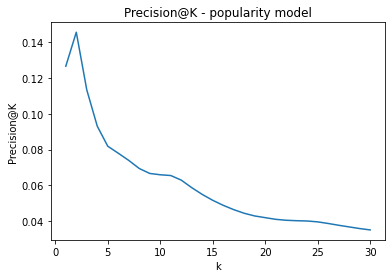

In [24]:
plt.plot(popularity_results['cutoff'],popularity_results['precision'] )
plt.title('Precision@K - popularity model')
plt.xlabel('k')
plt.ylabel('Precision@K')
plt.show()

# Item Based CF

- Compute an item-to-item similarity matrix. The idea is to calculate how similar a product is to another product. There are a number of ways of calculating this. (cosine, Jaccard,or pearson similarity measure)

Item-Based CF Prediction

- Given a purchase history vector H for a user, for each item k in H(k s.t. hk!=0),select the S items which are the most similar to k using the similarity matrix computed during training. We obtain ∥H∥1 lists of items with similarity scores for each item in each list. S is treated as a hyperparameter.  (Decreasing this decreases the amount of memory required for the model, but may also decrease the accuracy.)

- Merge the lists: concatenate the lists, and sort the items by decreasing associated score. If an item is in several lists, assign it its maximum score.

### cosine similarity 
 
 Hyperparameter: S = 30

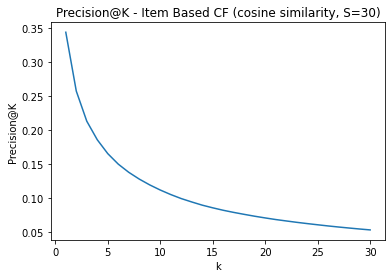

In [39]:
plt.plot(cosCF_results['cutoff'],cosCF_results['precision'] )
plt.title('Precision@K - Item Based CF (cosine similarity, S=30)')
plt.xlabel('k')
plt.ylabel('Precision@K')
plt.show()

### pearson similarity 
 
 Hyperparameter: S = 25

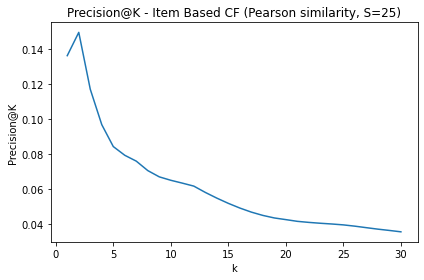

In [56]:
plt.plot(PearsonCF_results['cutoff'],PearsonCF_results['precision'] )
plt.title('Precision@K - Item Based CF (Pearson similarity, S=25)')
plt.xlabel('k')
plt.ylabel('Precision@K')
plt.tight_layout()
plt.show()

### Jaccard similarity 
 
 Hyperparameter: S = 30

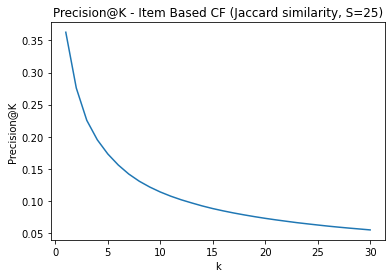

In [70]:
plt.plot(JaccardCF_results['cutoff'],JaccardCF_results['precision'] )
plt.title('Precision@K - Item Based CF (Jaccard similarity, S=25)')
plt.xlabel('k')
plt.ylabel('Precision@K')
plt.show()

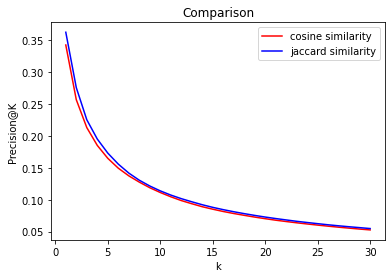

In [71]:
plt.plot(cosCF_results['cutoff'],cosCF_results['precision'],color = 'r',label = 'cosine similarity' )
plt.plot(JaccardCF_results['cutoff'],JaccardCF_results['precision'] ,color = 'b',label = 'jaccard similarity')
plt.title('Comparison')
plt.xlabel('k')
plt.ylabel('Precision@K')
plt.legend()
plt.show()

# Matrix Factorization iALS
ials_confidence_scaling_factor  = 40


number of feature = 2

reg  = 1e-4

max iter = 60

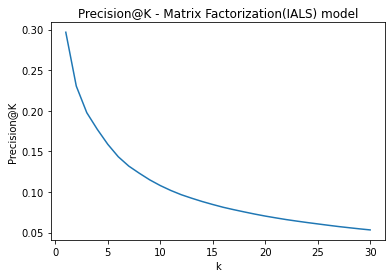

In [108]:
plt.plot(IALS_results['cutoff'],IALS_results['precision'] )
plt.title('Precision@K - Matrix Factorization(IALS) model')
plt.xlabel('k')
plt.ylabel('Precision@K')
plt.show()

In [2]:
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from pandas import Series, DataFrame
import time
import turicreate as tc
from sklearn.model_selection import train_test_split
from functools import reduce
import random

# Data Prep

In [3]:
file1 = "/Users/shengshiyuan/Desktop/1001/2019-Oct.csv"
file2 = "/Users/shengshiyuan/Desktop/1001/2019-Nov.csv"
file3 = "/Users/shengshiyuan/Desktop/1001/2019-Dec.csv"
file4 = "/Users/shengshiyuan/Desktop/1001/2020-Jan.csv"
file5 = "/Users/shengshiyuan/Desktop/1001/2020-Feb.csv"

In [4]:
def pre_process_df(filename):
    """
    This function removes the duplicated rows
                  removes product with prices <= 0 (might be coupons, gifts, or refunds)
                  removes products with missing brand information.
    @Input: filename (string): path to file
    @Output: df (Pandas DataFrame)
    """
    if filename:
        df = pd.read_csv(filename)
        df = df.drop_duplicates()
        df = df[df.brand.notnull()]
        return df[df.price > 0]
    return None
  
def gen_purchase_count(files):
    """
    This function generates the train data (user-brand purchase history).
    @Output: df (Pandas DataFrmae). Each entry indicates the purchase count.
    """
    df = pd.concat([pre_process_df(f) for f in files])
    df = df.loc[:, ['event_type', 'brand', 'user_id']]
    df['purchase_count'] = [1 if e == 'purchase' else 0 for e in df['event_type']]
    df = df.drop(['event_type'], axis = 1)
    df = df.groupby(['brand', 'user_id']).sum()
    df = df[df.purchase_count != 0]
    return df.reset_index()

In [5]:
purchase_count = gen_purchase_count([file1, file2 , file3, file4, file5])

In [6]:
user_id  = np.unique(purchase_count['user_id'])
num_brand_purchased = np.zeros(len(user_id))
for loc, user in enumerate(user_id):
    num_brand_purchased[loc] = np.sum(purchase_count['user_id'] == user)

In [7]:
idx = np.where(num_brand_purchased>=5)

In [8]:
filitered_user_id = user_id[idx]

In [9]:
filtered_data = purchase_count.loc[purchase_count['user_id'].isin(filitered_user_id)]

In [10]:
len(filitered_user_id)

22185

In [11]:
len(np.unique(filtered_data['brand']))

248

In [12]:
'''
train3 is training dataset
test is testing dataset
train4 is training dataset+validation dataset combined
validation is validation dataset
'''

sf = tc.SFrame(filtered_data)
train4, test = tc.recommender.util.random_split_by_user(sf, user_id = 'user_id', item_id = 'brand',max_num_users=22185,item_test_proportion= 0.2)
train3, validation = tc.recommender.util.random_split_by_user(train4, user_id = 'user_id', item_id = 'brand',max_num_users=22185,item_test_proportion=0.25)

# Popularity Model

In [26]:
# constant variables to define field names include:
user_id = 'user_id'
item_id = 'brand'
target = 'purchase_count'
# train model with train4
pop_model = tc.popularity_recommender.create(train4, user_id=user_id, item_id=item_id, target=target)

Preparing data set.

Data has 135114 observations with 22183 users and 248 items.

Data prepared in: 0.167131s

135114 observations to process; with 248 unique items.

In [27]:
results = pop_model.evaluate_precision_recall(test,cutoffs = list(range(1, 31)))

recommendations finished on 1000/17326 queries. users per second: 85433.6

recommendations finished on 2000/17326 queries. users per second: 110509

recommendations finished on 3000/17326 queries. users per second: 126572

recommendations finished on 4000/17326 queries. users per second: 135694

recommendations finished on 5000/17326 queries. users per second: 136668

recommendations finished on 6000/17326 queries. users per second: 140495

recommendations finished on 7000/17326 queries. users per second: 146954

recommendations finished on 8000/17326 queries. users per second: 148489

recommendations finished on 9000/17326 queries. users per second: 140618

recommendations finished on 10000/17326 queries. users per second: 137589

recommendations finished on 11000/17326 queries. users per second: 131210

recommendations finished on 12000/17326 queries. users per second: 129014

recommendations finished on 13000/17326 queries. users per second: 129988

recommendations finished on 14000/17326 queries. users per second: 127125

recommendations finished on 15000/17326 queries. users per second: 127260

recommendations finished on 16000/17326 queries. users per second: 128900

recommendations finished on 17000/17326 queries. users per second: 129743

In [28]:
col_names =  ['cutoff', 'precision', 'recall'] 
popularity_results  = pd.DataFrame(columns = col_names)
popularity_results['cutoff'] = np.array(results['precision_recall_overall']['cutoff'])
popularity_results['precision'] = np.array(results['precision_recall_overall']['precision'])
popularity_results['recall'] = np.array(results['precision_recall_overall']['recall'])

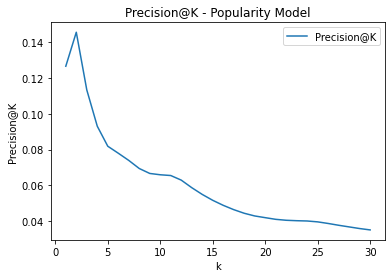

In [29]:
plt.plot(popularity_results['cutoff'],popularity_results['precision'], label = 'Precision@K' )
plt.title('Precision@K - Popularity Model')
plt.xlabel('k')
plt.ylabel('Precision@K')
plt.legend()
plt.show()

#  Item Based CF - Cosine

In [30]:
# constant variables to define field names include:
user_id = 'user_id'
item_id = 'brand'
target = 'purchase_count'

In [40]:
# hyperparameter tuning for S
test_s_values = np.arange(5,70,10)
def test_s_vals(name):
    s_list = []
    train = []
    val = []
    for loc, s in enumerate(test_s_values):
        model = tc.item_similarity_recommender.create(train3,similarity_type=name,user_id=user_id, item_id=item_id,target = target,only_top_k=s)
        rmse_train = tc.recommender.util.compare_models(train3, [model],exclude_known_for_precision_recall=False)
        rmse_train = rmse_train[0]['rmse_overall']
        s_list.append(s)
        train.append(rmse_train)
        rmse_val = tc.recommender.util.compare_models(validation, [model], model_names=["m1"], metric='rmse')
        rmse_val = rmse_val[0]['rmse_overall']
        val.append(rmse_val)
    return s_list,train,val

In [41]:
# hyperparameter tuning for cosine similarity 
cosCF_s, cosCF_train, cosCF_val = test_s_vals('cosine')

Preparing data set.

Data has 101335 observations with 22098 users and 246 items.

Data prepared in: 0.123383s

Training model from provided data.

Gathering per-item and per-user statistics.

+--------------------------------+------------+

PROGRESS: Evaluate model M0


| Elapsed Time (Item Statistics) | % Complete |

+--------------------------------+------------+

| 1.162ms                        | 4.5        |

| 5.593ms                        | 100        |

+--------------------------------+------------+

Setting up lookup tables.

Processing data in one pass using dense lookup tables.

+-------------------------------------+------------------+-----------------+

| Elapsed Time (Constructing Lookups) | Total % Complete | Items Processed |

+-------------------------------------+------------------+-----------------+

| 6.155ms                             | 0                | 0               |

| 12.242ms                            | 100              | 246             |

+-------------------------------------+------------------+-----------------+

Finalizing lookup tables.

Generating candidate set for working with new users.

Finished training in 0.025695s

recommendations finished on 1000/22098 queries. users per second: 79063.9

recommendations finished on 2000/22098 queries. users per second: 99537.2

recommendations finished on 3000/22098 queries. users per second: 93926.1

recommendations finished on 4000/22098 queries. users per second: 84207

recommendations finished on 5000/22098 queries. users per second: 79151.5

recommendations finished on 6000/22098 queries. users per second: 74801.8

recommendations finished on 7000/22098 queries. users per second: 73506.2

recommendations finished on 8000/22098 queries. users per second: 69650

recommendations finished on 9000/22098 queries. users per second: 69264.9

recommendations finished on 10000/22098 queries. users per second: 69133.8

recommendations finished on 11000/22098 queries. users per second: 68931.4

recommendations finished on 12000/22098 queries. users per second: 68903.3

recommendations finished on 13000/22098 queries. users per second: 69532.1

recommendations finished on 14000/22098 queries. users per second: 68708.3

recommendations finished on 15000/22098 queries. users per second: 69593

recommendations finished on 16000/22098 queries. users per second: 71077.6

recommendations finished on 17000/22098 queries. users per second: 69951.1

recommendations finished on 18000/22098 queries. users per second: 70567.8

recommendations finished on 19000/22098 queries. users per second: 71295.1

recommendations finished on 20000/22098 queries. users per second: 72120.2

recommendations finished on 21000/22098 queries. users per second: 71667.7

recommendations finished on 22000/22098 queries. users per second: 70308.4


Precision and recall summary statistics by cutoff
+--------+---------------------+----------------------+
| cutoff |    mean_precision   |     mean_recall      |
+--------+---------------------+----------------------+
|   1    |  0.1633179473255498 | 0.031327789809142415 |
|   2    |  0.1801067969952033 | 0.06851371907071467  |
|   3    |  0.1934564213956012 |  0.1123336134240721  |
|   4    | 0.19712191148520236 |  0.1566090826698971  |
|   5    | 0.20334871934111723 | 0.20626084433393171  |
|   6    |  0.2265438802908252 |  0.2865739206901548  |
|   7    | 0.21618633877661902 | 0.32057676842806365  |
|   8    |  0.2060197755452983 | 0.34976204566806407  |
|   9    |  0.1974437103408054 |  0.3761773819979274  |
|   10   | 0.18798533803964199 | 0.39557809888447815  |
+--------+---------------------+----------------------+
[10 rows x 3 columns]


Overall RMSE: 4.349016910451926

Per User RMSE (best)
+-----------+--------------------+-------+
|  user_id  |        rmse        | count |
+

Preparing data set.

Data has 101335 observations with 22098 users and 246 items.

Data prepared in: 0.127817s

Training model from provided data.

Gathering per-item and per-user statistics.

+--------------------------------+------------+

| Elapsed Time (Item Statistics) | % Complete |

+--------------------------------+------------+

| 901us                          | 4.5        |

| 6.585ms                        | 100        |

+--------------------------------+------------+

PROGRESS: Evaluate model M0

Setting up lookup tables.

Processing data in one pass using dense lookup tables.

+-------------------------------------+------------------+-----------------+

| Elapsed Time (Constructing Lookups) | Total % Complete | Items Processed |

+-------------------------------------+------------------+-----------------+

| 7.335ms                             | 0                | 0               |

| 16.923ms                            | 100              | 246             |

+-------------------------------------+------------------+-----------------+

Finalizing lookup tables.

Generating candidate set for working with new users.

Finished training in 0.047506s

recommendations finished on 1000/22098 queries. users per second: 47397.9

recommendations finished on 2000/22098 queries. users per second: 58424.9

recommendations finished on 3000/22098 queries. users per second: 55588.5

recommendations finished on 4000/22098 queries. users per second: 57875.4

recommendations finished on 5000/22098 queries. users per second: 57885.1

recommendations finished on 6000/22098 queries. users per second: 55564.3

recommendations finished on 7000/22098 queries. users per second: 56202.8

recommendations finished on 8000/22098 queries. users per second: 57215.2

recommendations finished on 9000/22098 queries. users per second: 54979.3

recommendations finished on 10000/22098 queries. users per second: 54701.6

recommendations finished on 11000/22098 queries. users per second: 54691.5

recommendations finished on 12000/22098 queries. users per second: 54590.9

recommendations finished on 13000/22098 queries. users per second: 55982.1

recommendations finished on 14000/22098 queries. users per second: 55757.8

recommendations finished on 15000/22098 queries. users per second: 56104.3

recommendations finished on 16000/22098 queries. users per second: 57106.8

recommendations finished on 17000/22098 queries. users per second: 57159.4

recommendations finished on 18000/22098 queries. users per second: 57762.1

recommendations finished on 19000/22098 queries. users per second: 57798.4

recommendations finished on 20000/22098 queries. users per second: 57724.2

recommendations finished on 21000/22098 queries. users per second: 57787.6

recommendations finished on 22000/22098 queries. users per second: 56786.8


Precision and recall summary statistics by cutoff
+--------+---------------------+----------------------+
| cutoff |    mean_precision   |     mean_recall      |
+--------+---------------------+----------------------+
|   1    | 0.14127975382387548 | 0.027059626734348915 |
|   2    | 0.12476242193863717 | 0.046505295786390795 |
|   3    | 0.12132319666938195 | 0.06695921332600482  |
|   4    | 0.12743234681871624 | 0.09407590831199801  |
|   5    | 0.13394877364467325 | 0.12459503357320661  |
|   6    | 0.13829305819531149 |  0.1554422029259849  |
|   7    |  0.1405557063987698 | 0.18550517663680915  |
|   8    | 0.14218481310525846 | 0.21558733321466636  |
|   9    | 0.14443237698735958 | 0.24798147829888417  |
|   10   | 0.14656077473074502 |  0.2820156709753054  |
+--------+---------------------+----------------------+
[10 rows x 3 columns]


Overall RMSE: 4.315929021025643

Per User RMSE (best)
+-----------+--------------------+-------+
|  user_id  |        rmse        | count |
+

Preparing data set.

Data has 101335 observations with 22098 users and 246 items.

Data prepared in: 0.122971s

Training model from provided data.

Gathering per-item and per-user statistics.

+--------------------------------+------------+

| Elapsed Time (Item Statistics) | % Complete |

+--------------------------------+------------+

| 1.11ms                         | 4.5        |

| 14.833ms                       | 100        |

+--------------------------------+------------+

Setting up lookup tables.

Processing data in one pass using dense lookup tables.

+-------------------------------------+------------------+-----------------+

| Elapsed Time (Constructing Lookups) | Total % Complete | Items Processed |

+-------------------------------------+------------------+-----------------+

| 17.3ms                              | 0                | 0               |

| 45.792ms                            | 100              | 246             |

+-------------------------------------+------------------+-----------------+

Finalizing lookup tables.

Generating candidate set for working with new users.

Finished training in 0.078001s

PROGRESS: Evaluate model M0


recommendations finished on 1000/22098 queries. users per second: 53322

recommendations finished on 2000/22098 queries. users per second: 56346

recommendations finished on 3000/22098 queries. users per second: 54450.4

recommendations finished on 4000/22098 queries. users per second: 55757.7

recommendations finished on 5000/22098 queries. users per second: 53104.5

recommendations finished on 6000/22098 queries. users per second: 53430.7

recommendations finished on 7000/22098 queries. users per second: 52645.4

recommendations finished on 8000/22098 queries. users per second: 54558

recommendations finished on 9000/22098 queries. users per second: 55871.1

recommendations finished on 10000/22098 queries. users per second: 55877.2

recommendations finished on 11000/22098 queries. users per second: 55977.4

recommendations finished on 12000/22098 queries. users per second: 54905.6

recommendations finished on 13000/22098 queries. users per second: 54808.4

recommendations finished on 14000/22098 queries. users per second: 54759.4

recommendations finished on 15000/22098 queries. users per second: 55882.6

recommendations finished on 16000/22098 queries. users per second: 55865.7

recommendations finished on 17000/22098 queries. users per second: 56309.8

recommendations finished on 18000/22098 queries. users per second: 57015.1

recommendations finished on 19000/22098 queries. users per second: 57684.5

recommendations finished on 20000/22098 queries. users per second: 58014.6

recommendations finished on 21000/22098 queries. users per second: 58157.9

recommendations finished on 22000/22098 queries. users per second: 56612


Precision and recall summary statistics by cutoff
+--------+---------------------+----------------------+
| cutoff |    mean_precision   |     mean_recall      |
+--------+---------------------+----------------------+
|   1    | 0.14073671825504602 | 0.026996437423323374 |
|   2    | 0.12489818083084425 | 0.046511926754959534 |
|   3    | 0.12007119799680203 |  0.0661747317214653  |
|   4    | 0.12351796542673539 | 0.09094709607376424  |
|   5    | 0.12833740610009964 | 0.11908025855735428  |
|   6    |  0.1328777868283708 |  0.1490562834663479  |
|   7    | 0.13411685608264562 | 0.17653213258571734  |
|   8    | 0.13299846139922203 | 0.20069784527492254  |
|   9    |  0.1318922778330874 | 0.22440182748090443  |
|   10   | 0.13067245904606717 |  0.2473235595976703  |
+--------+---------------------+----------------------+
[10 rows x 3 columns]


Overall RMSE: 4.3072894217953515

Per User RMSE (best)
+-----------+--------------------+-------+
|  user_id  |        rmse        | count |


Preparing data set.

Data has 101335 observations with 22098 users and 246 items.

Data prepared in: 0.140224s

Training model from provided data.

Gathering per-item and per-user statistics.

+--------------------------------+------------+

| Elapsed Time (Item Statistics) | % Complete |

+--------------------------------+------------+

| 1.219ms                        | 4.5        |

| 23.501ms                       | 100        |

+--------------------------------+------------+

Setting up lookup tables.

Processing data in one pass using dense lookup tables.

+-------------------------------------+------------------+-----------------+

| Elapsed Time (Constructing Lookups) | Total % Complete | Items Processed |

+-------------------------------------+------------------+-----------------+

| 24.26ms                             | 0                | 0               |

| 57.806ms                            | 100              | 246             |

+-------------------------------------+------------------+-----------------+

Finalizing lookup tables.

Generating candidate set for working with new users.

Finished training in 0.074787s

PROGRESS: Evaluate model M0


recommendations finished on 1000/22098 queries. users per second: 43905.9

recommendations finished on 2000/22098 queries. users per second: 42301.2

recommendations finished on 3000/22098 queries. users per second: 39374.2

recommendations finished on 4000/22098 queries. users per second: 42483.1

recommendations finished on 5000/22098 queries. users per second: 46021

recommendations finished on 6000/22098 queries. users per second: 46501.2

recommendations finished on 7000/22098 queries. users per second: 48841.1

recommendations finished on 8000/22098 queries. users per second: 49417.2

recommendations finished on 9000/22098 queries. users per second: 50074

recommendations finished on 10000/22098 queries. users per second: 50881.3

recommendations finished on 11000/22098 queries. users per second: 49654.9

recommendations finished on 12000/22098 queries. users per second: 49391.9

recommendations finished on 13000/22098 queries. users per second: 50049.3

recommendations finished on 14000/22098 queries. users per second: 49771.2

recommendations finished on 15000/22098 queries. users per second: 50887.5

recommendations finished on 16000/22098 queries. users per second: 51237.2

recommendations finished on 17000/22098 queries. users per second: 51991.7

recommendations finished on 18000/22098 queries. users per second: 51591

recommendations finished on 19000/22098 queries. users per second: 50722.7

recommendations finished on 20000/22098 queries. users per second: 50668.7

recommendations finished on 21000/22098 queries. users per second: 50498

recommendations finished on 22000/22098 queries. users per second: 49516.8


Precision and recall summary statistics by cutoff
+--------+---------------------+----------------------+
| cutoff |    mean_precision   |     mean_recall      |
+--------+---------------------+----------------------+
|   1    | 0.14001267082993926 | 0.026820455306667955 |
|   2    | 0.12338220653452799 | 0.04597997365609177  |
|   3    | 0.11869852475337136 | 0.06536697188228527  |
|   4    |  0.1226694723504391 | 0.09026117365554193  |
|   5    | 0.12773101638157297 | 0.11842685084097998  |
|   6    |  0.1318068000120669 |  0.1476872013542506  |
|   7    | 0.13314714970973535 |  0.1751252224377205  |
|   8    |  0.1320538057742786 | 0.19915449299212767  |
|   9    | 0.13092688126627886 | 0.22257460767983278  |
|   10   | 0.12956376142637274 | 0.24485494120091372  |
+--------+---------------------+----------------------+
[10 rows x 3 columns]


Overall RMSE: 4.303181300617608

Per User RMSE (best)
+-----------+--------------------+-------+
|  user_id  |        rmse        | count |
+

Preparing data set.

Data has 101335 observations with 22098 users and 246 items.

Data prepared in: 0.145591s

Training model from provided data.

Gathering per-item and per-user statistics.

+--------------------------------+------------+

| Elapsed Time (Item Statistics) | % Complete |

+--------------------------------+------------+

| 1.41ms                         | 4.5        |

| 22.258ms                       | 100        |

+--------------------------------+------------+

Setting up lookup tables.

Processing data in one pass using dense lookup tables.

+-------------------------------------+------------------+-----------------+

| Elapsed Time (Constructing Lookups) | Total % Complete | Items Processed |

+-------------------------------------+------------------+-----------------+

| 34.792ms                            | 0                | 0               |

| 61.717ms                            | 100              | 246             |

+-------------------------------------+------------------+-----------------+

Finalizing lookup tables.

Generating candidate set for working with new users.

Finished training in 0.083998s

PROGRESS: Evaluate model M0


recommendations finished on 1000/22098 queries. users per second: 51762.5

recommendations finished on 2000/22098 queries. users per second: 54442.5

recommendations finished on 3000/22098 queries. users per second: 46447.5

recommendations finished on 4000/22098 queries. users per second: 45428.2

recommendations finished on 5000/22098 queries. users per second: 45480.6

recommendations finished on 6000/22098 queries. users per second: 45063

recommendations finished on 7000/22098 queries. users per second: 44408.1

recommendations finished on 8000/22098 queries. users per second: 45333.7

recommendations finished on 9000/22098 queries. users per second: 45844

recommendations finished on 10000/22098 queries. users per second: 46416.4

recommendations finished on 11000/22098 queries. users per second: 46177.5

recommendations finished on 12000/22098 queries. users per second: 45081.1

recommendations finished on 13000/22098 queries. users per second: 45480

recommendations finished on 14000/22098 queries. users per second: 45630.5

recommendations finished on 15000/22098 queries. users per second: 44546.5

recommendations finished on 16000/22098 queries. users per second: 45437.9

recommendations finished on 17000/22098 queries. users per second: 46210.7

recommendations finished on 18000/22098 queries. users per second: 46558.7

recommendations finished on 19000/22098 queries. users per second: 46534.1

recommendations finished on 20000/22098 queries. users per second: 47261.2

recommendations finished on 21000/22098 queries. users per second: 46632.8

recommendations finished on 22000/22098 queries. users per second: 44724.7


Precision and recall summary statistics by cutoff
+--------+---------------------+---------------------+
| cutoff |    mean_precision   |     mean_recall     |
+--------+---------------------+---------------------+
|   1    | 0.13987691193773216 | 0.02678637192341263 |
|   2    |  0.1233822065345281 | 0.04599368324993437 |
|   3    | 0.11782363411470131 | 0.06493256927491563 |
|   4    | 0.12246583401212797 | 0.09004767858221815 |
|   5    |  0.127396144447461  | 0.11804757868660538 |
|   6    |  0.1317162940839288 | 0.14759302001705768 |
|   7    | 0.13303724965413868 |  0.1747491312868675 |
|   8    | 0.13179925785138918 | 0.19844834212210904 |
|   9    |  0.1306805040174576 | 0.22188255667162327 |
|   10   | 0.12935107249524866 | 0.24438385161624096 |
+--------+---------------------+---------------------+
[10 rows x 3 columns]


Overall RMSE: 4.300673402255604

Per User RMSE (best)
+-----------+--------------------+-------+
|  user_id  |        rmse        | count |
+-----------+--

Preparing data set.

Data has 101335 observations with 22098 users and 246 items.

Data prepared in: 0.148796s

Training model from provided data.

Gathering per-item and per-user statistics.

+--------------------------------+------------+

| Elapsed Time (Item Statistics) | % Complete |

+--------------------------------+------------+

| 1.754ms                        | 4.5        |

| 19.406ms                       | 100        |

+--------------------------------+------------+

Setting up lookup tables.

Processing data in one pass using dense lookup tables.

+-------------------------------------+------------------+-----------------+

| Elapsed Time (Constructing Lookups) | Total % Complete | Items Processed |

+-------------------------------------+------------------+-----------------+

| 20.383ms                            | 0                | 0               |

| 49.575ms                            | 100              | 246             |

+-------------------------------------+------------------+-----------------+

Finalizing lookup tables.

Generating candidate set for working with new users.

Finished training in 0.073925s

PROGRESS: Evaluate model M0


recommendations finished on 1000/22098 queries. users per second: 45819

recommendations finished on 2000/22098 queries. users per second: 50398.1

recommendations finished on 3000/22098 queries. users per second: 44611.7

recommendations finished on 4000/22098 queries. users per second: 46294.2

recommendations finished on 5000/22098 queries. users per second: 45937.3

recommendations finished on 6000/22098 queries. users per second: 44806.5

recommendations finished on 7000/22098 queries. users per second: 45302.8

recommendations finished on 8000/22098 queries. users per second: 45361

recommendations finished on 9000/22098 queries. users per second: 45812.3

recommendations finished on 10000/22098 queries. users per second: 46419.4

recommendations finished on 11000/22098 queries. users per second: 46833.8

recommendations finished on 12000/22098 queries. users per second: 45725.6

recommendations finished on 13000/22098 queries. users per second: 46148.5

recommendations finished on 14000/22098 queries. users per second: 46636.2

recommendations finished on 15000/22098 queries. users per second: 47056.9

recommendations finished on 16000/22098 queries. users per second: 47145.9

recommendations finished on 17000/22098 queries. users per second: 47505.1

recommendations finished on 18000/22098 queries. users per second: 47768.2

recommendations finished on 19000/22098 queries. users per second: 48244

recommendations finished on 20000/22098 queries. users per second: 48344.9

recommendations finished on 21000/22098 queries. users per second: 48638.6

recommendations finished on 22000/22098 queries. users per second: 47719.1


Precision and recall summary statistics by cutoff
+--------+---------------------+----------------------+
| cutoff |    mean_precision   |     mean_recall      |
+--------+---------------------+----------------------+
|   1    | 0.14019368268621626 | 0.026872220636399536 |
|   2    | 0.12326907412435532 | 0.04601762634508308  |
|   3    | 0.11722026126044571 | 0.06456843360668026  |
|   4    | 0.12200199113041915 | 0.08968812878261413  |
|   5    |  0.126916463028328  |  0.1175487420994353  |
|   6    | 0.13115817419374315 | 0.14692417220618129  |
|   7    | 0.13242310228462859 | 0.17383925172710654  |
|   8    |  0.131284505385103  | 0.19754428804375168  |
|   9    | 0.13021289005540987 | 0.22083452040286666  |
|   10   | 0.12902525115395042 | 0.24342576656929807  |
+--------+---------------------+----------------------+
[10 rows x 3 columns]


Overall RMSE: 4.299117797123962

Per User RMSE (best)
+-----------+--------------------+-------+
|  user_id  |        rmse        | count |
+

Preparing data set.

Data has 101335 observations with 22098 users and 246 items.

Data prepared in: 0.109936s

Training model from provided data.

Gathering per-item and per-user statistics.

+--------------------------------+------------+

| Elapsed Time (Item Statistics) | % Complete |

+--------------------------------+------------+

| 1.087ms                        | 4.5        |

| 14.441ms                       | 100        |

+--------------------------------+------------+

Setting up lookup tables.

Processing data in one pass using dense lookup tables.

+-------------------------------------+------------------+-----------------+

| Elapsed Time (Constructing Lookups) | Total % Complete | Items Processed |

+-------------------------------------+------------------+-----------------+

| 15.728ms                            | 0                | 0               |

| 48.577ms                            | 100              | 246             |

+-------------------------------------+------------------+-----------------+

Finalizing lookup tables.

Generating candidate set for working with new users.

Finished training in 0.064793s

PROGRESS: Evaluate model M0


recommendations finished on 1000/22098 queries. users per second: 27933

recommendations finished on 2000/22098 queries. users per second: 34652.4

recommendations finished on 3000/22098 queries. users per second: 36186.4

recommendations finished on 4000/22098 queries. users per second: 38021.4

recommendations finished on 5000/22098 queries. users per second: 41119.8

recommendations finished on 6000/22098 queries. users per second: 43141.6

recommendations finished on 7000/22098 queries. users per second: 45245.7

recommendations finished on 8000/22098 queries. users per second: 46707.7

recommendations finished on 9000/22098 queries. users per second: 47659.9

recommendations finished on 10000/22098 queries. users per second: 48555

recommendations finished on 11000/22098 queries. users per second: 47903.1

recommendations finished on 12000/22098 queries. users per second: 46712.6

recommendations finished on 13000/22098 queries. users per second: 44659.6

recommendations finished on 14000/22098 queries. users per second: 45635

recommendations finished on 15000/22098 queries. users per second: 45867.8

recommendations finished on 16000/22098 queries. users per second: 46005.4

recommendations finished on 17000/22098 queries. users per second: 46495.7

recommendations finished on 18000/22098 queries. users per second: 47031.3

recommendations finished on 19000/22098 queries. users per second: 47457.5

recommendations finished on 20000/22098 queries. users per second: 48321.2

recommendations finished on 21000/22098 queries. users per second: 48822.3

recommendations finished on 22000/22098 queries. users per second: 48115.5


Precision and recall summary statistics by cutoff
+--------+---------------------+----------------------+
| cutoff |    mean_precision   |     mean_recall      |
+--------+---------------------+----------------------+
|   1    |  0.1412797538238755 | 0.027049247554534295 |
|   2    | 0.12487555434880972 | 0.046559086549182435 |
|   3    | 0.12046339035206828 | 0.06635239854059069  |
|   4    |  0.1247850484206715 | 0.09188030267754402  |
|   5    |  0.1290433523395782 | 0.11980130924285631  |
|   6    | 0.13210848643919573 |  0.1482676034389655  |
|   7    | 0.13281744954294578 |  0.1746787105131306  |
|   8    |  0.1316578423386733 | 0.19850631304910207  |
|   9    |  0.1304592673042314 | 0.22163175636202898  |
|   10   | 0.12917006063897113 | 0.24410278689383708  |
+--------+---------------------+----------------------+
[10 rows x 3 columns]


Overall RMSE: 4.300297723318331

Per User RMSE (best)
+-----------+--------------------+-------+
|  user_id  |        rmse        | count |
+

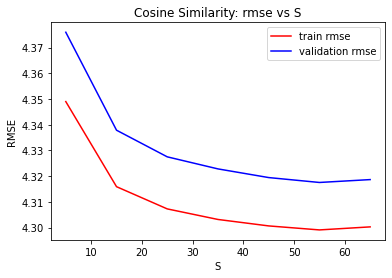

In [42]:
plt.plot(cosCF_s,cosCF_train, color= 'r' ,label='train rmse' )
plt.plot(cosCF_s,cosCF_val, color= 'b',label='validation rmse' )
plt.xlabel('S')
plt.ylabel('RMSE')
plt.title('Cosine Similarity: rmse vs S')
plt.legend()
plt.show()

In [43]:
cosCF_model = tc.item_similarity_recommender.create(train4,similarity_type='cosine',user_id=user_id, item_id=item_id,target = target,only_top_k=30)

Preparing data set.

Data has 135114 observations with 22183 users and 248 items.

Data prepared in: 0.168836s

Training model from provided data.

Gathering per-item and per-user statistics.

+--------------------------------+------------+

| Elapsed Time (Item Statistics) | % Complete |

+--------------------------------+------------+

| 1.116ms                        | 4.5        |

| 5.723ms                        | 100        |

+--------------------------------+------------+

Setting up lookup tables.

Processing data in one pass using dense lookup tables.

+-------------------------------------+------------------+-----------------+

| Elapsed Time (Constructing Lookups) | Total % Complete | Items Processed |

+-------------------------------------+------------------+-----------------+

| 6.538ms                             | 0                | 0               |

| 16.408ms                            | 100              | 248             |

+-------------------------------------+------------------+-----------------+

Finalizing lookup tables.

Generating candidate set for working with new users.

Finished training in 0.039679s

In [44]:
cosCF_evaluation = cosCF_model.evaluate_precision_recall(test,cutoffs = list(range(1, 31)))

recommendations finished on 1000/17326 queries. users per second: 64238.5

recommendations finished on 2000/17326 queries. users per second: 83829.3

recommendations finished on 3000/17326 queries. users per second: 91920.2

recommendations finished on 4000/17326 queries. users per second: 94784.5

recommendations finished on 5000/17326 queries. users per second: 97189.3

recommendations finished on 6000/17326 queries. users per second: 94485.2

recommendations finished on 7000/17326 queries. users per second: 94292.6

recommendations finished on 8000/17326 queries. users per second: 90672.1

recommendations finished on 9000/17326 queries. users per second: 91312.2

recommendations finished on 10000/17326 queries. users per second: 90853.8

recommendations finished on 11000/17326 queries. users per second: 92266.4

recommendations finished on 12000/17326 queries. users per second: 86758.5

recommendations finished on 13000/17326 queries. users per second: 87788.6

recommendations finished on 14000/17326 queries. users per second: 89841.5

recommendations finished on 15000/17326 queries. users per second: 90958.7

recommendations finished on 16000/17326 queries. users per second: 91479.3

recommendations finished on 17000/17326 queries. users per second: 88177

In [45]:
col_names =  ['cutoff', 'precision', 'recall'] 
cosCF_results  = pd.DataFrame(columns = col_names)
cosCF_results['cutoff'] = np.array(cosCF_evaluation['precision_recall_overall']['cutoff'])
cosCF_results['precision'] = np.array(cosCF_evaluation['precision_recall_overall']['precision'])
cosCF_results['recall'] = np.array(cosCF_evaluation['precision_recall_overall']['recall'])

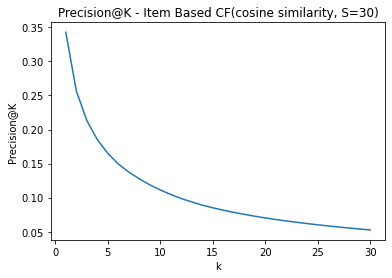

In [46]:
plt.plot(cosCF_results['cutoff'],cosCF_results['precision'] )
plt.title('Precision@K - Item Based CF(cosine similarity, S=30)')
plt.xlabel('k')
plt.ylabel('Precision@K')
plt.show()

# Item Based CF - Pearson

In [47]:
PearsonCF_s, PearsonCF_train, PearsonCF_val = test_s_vals('pearson')

Preparing data set.

Data has 101335 observations with 22098 users and 246 items.

Data prepared in: 0.124915s

Training model from provided data.

Gathering per-item and per-user statistics.

+--------------------------------+------------+

| Elapsed Time (Item Statistics) | % Complete |

+--------------------------------+------------+

| 1.237ms                        | 4.5        |

| 17.071ms                       | 100        |

+--------------------------------+------------+

Setting up lookup tables.

Processing data in one pass using dense lookup tables.

+-------------------------------------+------------------+-----------------+

| Elapsed Time (Constructing Lookups) | Total % Complete | Items Processed |

PROGRESS: Evaluate model M0


+-------------------------------------+------------------+-----------------+

| 18.107ms                            | 0                | 0               |

| 33.844ms                            | 100              | 246             |

+-------------------------------------+------------------+-----------------+

Finalizing lookup tables.

Generating candidate set for working with new users.

Finished training in 0.050229s

recommendations finished on 1000/22098 queries. users per second: 67096.1

recommendations finished on 2000/22098 queries. users per second: 74167.5

recommendations finished on 3000/22098 queries. users per second: 79120.2

recommendations finished on 4000/22098 queries. users per second: 84992.5

recommendations finished on 5000/22098 queries. users per second: 82384.5

recommendations finished on 6000/22098 queries. users per second: 77160.5

recommendations finished on 7000/22098 queries. users per second: 76268.5

recommendations finished on 8000/22098 queries. users per second: 76997.9

recommendations finished on 9000/22098 queries. users per second: 77241.3

recommendations finished on 10000/22098 queries. users per second: 77365.2

recommendations finished on 11000/22098 queries. users per second: 79559.1

recommendations finished on 12000/22098 queries. users per second: 75477.4

recommendations finished on 13000/22098 queries. users per second: 67520.2

recommendations finished on 14000/22098 queries. users per second: 68001.8

recommendations finished on 15000/22098 queries. users per second: 68482.2

recommendations finished on 16000/22098 queries. users per second: 69564.6

recommendations finished on 17000/22098 queries. users per second: 70356.1

recommendations finished on 18000/22098 queries. users per second: 70998.4

recommendations finished on 19000/22098 queries. users per second: 71832.3

recommendations finished on 20000/22098 queries. users per second: 70085.9

recommendations finished on 21000/22098 queries. users per second: 71101.4

recommendations finished on 22000/22098 queries. users per second: 70678.4


Precision and recall summary statistics by cutoff
+--------+---------------------+---------------------+
| cutoff |    mean_precision   |     mean_recall     |
+--------+---------------------+---------------------+
|   1    | 0.19205357950945803 | 0.04840323147899084 |
|   2    |  0.2854104443841076 | 0.13217329483173249 |
|   3    | 0.20817871903943097 |  0.1461730363597835 |
|   4    |  0.1885464747940989 | 0.17422606620303793 |
|   5    | 0.17084804054665584 | 0.19575150571206515 |
|   6    | 0.17922436419585458 | 0.24445408320659268 |
|   7    | 0.16309814721435678 | 0.25804920625738964 |
|   8    | 0.14801678884966954 | 0.26779380363922817 |
|   9    | 0.13702094709425713 |  0.2778397098506801 |
|   10   | 0.12988053217485718 |  0.2917043823911253 |
+--------+---------------------+---------------------+
[10 rows x 3 columns]


Overall RMSE: 3.5418065485028145

Per User RMSE (best)
+-----------+------+-------+
|  user_id  | rmse | count |
+-----------+------+-------+
| 604070433 |

Preparing data set.

Data has 101335 observations with 22098 users and 246 items.

Data prepared in: 0.120313s

Training model from provided data.

Gathering per-item and per-user statistics.

+--------------------------------+------------+

| Elapsed Time (Item Statistics) | % Complete |

+--------------------------------+------------+

| 1.514ms                        | 4.5        |

| 20.028ms                       | 100        |

+--------------------------------+------------+

Setting up lookup tables.

Processing data in one pass using dense lookup tables.

+-------------------------------------+------------------+-----------------+

| Elapsed Time (Constructing Lookups) | Total % Complete | Items Processed |

+-------------------------------------+------------------+-----------------+

| 20.717ms                            | 0                | 0               |

| 44.297ms                            | 100              | 246             |

+-------------------------------------+------------------+-----------------+

Finalizing lookup tables.

Generating candidate set for working with new users.

Finished training in 0.067067s

PROGRESS: Evaluate model M0


recommendations finished on 1000/22098 queries. users per second: 51342.6

recommendations finished on 2000/22098 queries. users per second: 59765.7

recommendations finished on 3000/22098 queries. users per second: 61135.9

recommendations finished on 4000/22098 queries. users per second: 62550.8

recommendations finished on 5000/22098 queries. users per second: 63043

recommendations finished on 6000/22098 queries. users per second: 64359.7

recommendations finished on 7000/22098 queries. users per second: 63701.8

recommendations finished on 8000/22098 queries. users per second: 63631.4

recommendations finished on 9000/22098 queries. users per second: 63734.4

recommendations finished on 10000/22098 queries. users per second: 59476.4

recommendations finished on 11000/22098 queries. users per second: 59723.5

recommendations finished on 12000/22098 queries. users per second: 56678.1

recommendations finished on 13000/22098 queries. users per second: 54404

recommendations finished on 14000/22098 queries. users per second: 54565.2

recommendations finished on 15000/22098 queries. users per second: 54035

recommendations finished on 16000/22098 queries. users per second: 54047.1

recommendations finished on 17000/22098 queries. users per second: 54465.9

recommendations finished on 18000/22098 queries. users per second: 54076.1

recommendations finished on 19000/22098 queries. users per second: 53755.4

recommendations finished on 20000/22098 queries. users per second: 53651.2

recommendations finished on 21000/22098 queries. users per second: 53961.7

recommendations finished on 22000/22098 queries. users per second: 52056.7


Precision and recall summary statistics by cutoff
+--------+---------------------+---------------------+
| cutoff |    mean_precision   |     mean_recall     |
+--------+---------------------+---------------------+
|   1    | 0.19191782061725063 | 0.04825788326820696 |
|   2    |  0.2807267626029504 | 0.12986271422560466 |
|   3    | 0.20867650164419144 | 0.14622830099916823 |
|   4    | 0.18520906869399917 | 0.17071661261232854 |
|   5    | 0.17077563580414507 | 0.19561413064256963 |
|   6    | 0.17770838989953774 | 0.24218569738539641 |
|   7    | 0.16285895297570593 |  0.2573439435061911 |
|   8    | 0.14796587926509236 |  0.2668031928196938 |
|   9    | 0.13763437616274982 |  0.278585500252742  |
|   10   | 0.13055932663589453 |  0.2927554176616855 |
+--------+---------------------+---------------------+
[10 rows x 3 columns]


Overall RMSE: 3.538879606850182

Per User RMSE (best)
+-----------+------+-------+
|  user_id  | rmse | count |
+-----------+------+-------+
| 604070433 | 

Preparing data set.

Data has 101335 observations with 22098 users and 246 items.

Data prepared in: 0.128597s

Training model from provided data.

Gathering per-item and per-user statistics.

+--------------------------------+------------+

| Elapsed Time (Item Statistics) | % Complete |

+--------------------------------+------------+

| 1.308ms                        | 4.5        |

| 19.387ms                       | 100        |

+--------------------------------+------------+

Setting up lookup tables.

Processing data in one pass using dense lookup tables.

+-------------------------------------+------------------+-----------------+

| Elapsed Time (Constructing Lookups) | Total % Complete | Items Processed |

+-------------------------------------+------------------+-----------------+

| 21.048ms                            | 0                | 0               |

| 54.604ms                            | 100              | 246             |

+-------------------------------------+------------------+-----------------+

Finalizing lookup tables.

Generating candidate set for working with new users.

Finished training in 0.07662s

PROGRESS: Evaluate model M0


recommendations finished on 1000/22098 queries. users per second: 44027.6

recommendations finished on 2000/22098 queries. users per second: 51711.7

recommendations finished on 3000/22098 queries. users per second: 50722.8

recommendations finished on 4000/22098 queries. users per second: 52786.5

recommendations finished on 5000/22098 queries. users per second: 52769.9

recommendations finished on 6000/22098 queries. users per second: 52172.6

recommendations finished on 7000/22098 queries. users per second: 48613.1

recommendations finished on 8000/22098 queries. users per second: 50653.1

recommendations finished on 9000/22098 queries. users per second: 51095.1

recommendations finished on 10000/22098 queries. users per second: 52447.7

recommendations finished on 11000/22098 queries. users per second: 48651.3

recommendations finished on 12000/22098 queries. users per second: 48439.4

recommendations finished on 13000/22098 queries. users per second: 48954.1

recommendations finished on 14000/22098 queries. users per second: 49624.8

recommendations finished on 15000/22098 queries. users per second: 49960.4

recommendations finished on 16000/22098 queries. users per second: 50004.4

recommendations finished on 17000/22098 queries. users per second: 50262.5

recommendations finished on 18000/22098 queries. users per second: 51337.5

recommendations finished on 19000/22098 queries. users per second: 51601.3

recommendations finished on 20000/22098 queries. users per second: 52448.8

recommendations finished on 21000/22098 queries. users per second: 52686

recommendations finished on 22000/22098 queries. users per second: 51519.1


Precision and recall summary statistics by cutoff
+--------+---------------------+---------------------+
| cutoff |    mean_precision   |     mean_recall     |
+--------+---------------------+---------------------+
|   1    | 0.19083174947959108 | 0.04811772754496662 |
|   2    |  0.2800932211059824 | 0.12958377722049297 |
|   3    | 0.20867650164419105 |  0.1462388600241181 |
|   4    | 0.18529957462213797 | 0.17082660408805514 |
|   5    | 0.17075753461851736 |  0.1955862246480603 |
|   6    | 0.17732373970495077 | 0.24163458239272925 |
|   7    |  0.1627619823384149 |  0.2571795647136552 |
|   8    | 0.14795456602407495 | 0.26683495038946486 |
|   9    | 0.13769974155529424 | 0.27861307748640096 |
|   10   | 0.13029233414788594 |  0.2921256630677741 |
+--------+---------------------+---------------------+
[10 rows x 3 columns]


Overall RMSE: 3.538464108524871

Per User RMSE (best)
+-----------+------+-------+
|  user_id  | rmse | count |
+-----------+------+-------+
| 604070433 | 

Preparing data set.

Data has 101335 observations with 22098 users and 246 items.

Data prepared in: 0.159109s

Training model from provided data.

Gathering per-item and per-user statistics.

+--------------------------------+------------+

| Elapsed Time (Item Statistics) | % Complete |

+--------------------------------+------------+

| 7.122ms                        | 4.5        |

| 31.525ms                       | 100        |

+--------------------------------+------------+

Setting up lookup tables.

Processing data in one pass using dense lookup tables.

+-------------------------------------+------------------+-----------------+

| Elapsed Time (Constructing Lookups) | Total % Complete | Items Processed |

+-------------------------------------+------------------+-----------------+

| 33.63ms                             | 0                | 0               |

| 69.582ms                            | 100              | 246             |

+-------------------------------------+------------------+-----------------+

Finalizing lookup tables.

Generating candidate set for working with new users.

Finished training in 0.09203s

PROGRESS: Evaluate model M0


recommendations finished on 1000/22098 queries. users per second: 46829.6

recommendations finished on 2000/22098 queries. users per second: 57979.4

recommendations finished on 3000/22098 queries. users per second: 62047.6

recommendations finished on 4000/22098 queries. users per second: 65620

recommendations finished on 5000/22098 queries. users per second: 67476.4

recommendations finished on 6000/22098 queries. users per second: 67886.4

recommendations finished on 7000/22098 queries. users per second: 69549.3

recommendations finished on 8000/22098 queries. users per second: 71007

recommendations finished on 9000/22098 queries. users per second: 72090

recommendations finished on 10000/22098 queries. users per second: 71736.5

recommendations finished on 11000/22098 queries. users per second: 65544.9

recommendations finished on 12000/22098 queries. users per second: 64946.7

recommendations finished on 13000/22098 queries. users per second: 66196.5

recommendations finished on 14000/22098 queries. users per second: 63917.6

recommendations finished on 15000/22098 queries. users per second: 64658.2

recommendations finished on 16000/22098 queries. users per second: 65531.3

recommendations finished on 17000/22098 queries. users per second: 66201.2

recommendations finished on 18000/22098 queries. users per second: 63700.8

recommendations finished on 19000/22098 queries. users per second: 64043.6

recommendations finished on 20000/22098 queries. users per second: 63967.2

recommendations finished on 21000/22098 queries. users per second: 58189.6

recommendations finished on 22000/22098 queries. users per second: 54304.9


Precision and recall summary statistics by cutoff
+--------+---------------------+---------------------+
| cutoff |    mean_precision   |     mean_recall     |
+--------+---------------------+---------------------+
|   1    | 0.19087700244366007 | 0.04813281186632303 |
|   2    |  0.2801158475880171 |  0.1295913193811717 |
|   3    | 0.20866141732283408 |  0.1462332034036089 |
|   4    | 0.18567291157570825 |  0.1711517414108843 |
|   5    | 0.17073038284007622 |  0.1955511878834552 |
|   6    |  0.1776706790961468 | 0.24217217683135614 |
|   7    |  0.1626068293187495 |  0.2568501513649648 |
|   8    | 0.14791496968051415 |  0.2667833420938974 |
|   9    | 0.13770979776953207 |  0.2786394750487754 |
|   10   | 0.13027423296225915 |  0.2920455424471314 |
+--------+---------------------+---------------------+
[10 rows x 3 columns]


Overall RMSE: 3.538351122812927

Per User RMSE (best)
+-----------+------+-------+
|  user_id  | rmse | count |
+-----------+------+-------+
| 604070433 | 

Preparing data set.

Data has 101335 observations with 22098 users and 246 items.

Data prepared in: 0.157929s

Training model from provided data.

Gathering per-item and per-user statistics.

+--------------------------------+------------+

| Elapsed Time (Item Statistics) | % Complete |

+--------------------------------+------------+

| 1.655ms                        | 4.5        |

| 24.702ms                       | 100        |

+--------------------------------+------------+

Setting up lookup tables.

Processing data in one pass using dense lookup tables.

+-------------------------------------+------------------+-----------------+

| Elapsed Time (Constructing Lookups) | Total % Complete | Items Processed |

+-------------------------------------+------------------+-----------------+

| 25.5ms                              | 0                | 0               |

| 51.079ms                            | 100              | 246             |

+-------------------------------------+------------------+-----------------+

Finalizing lookup tables.

Generating candidate set for working with new users.

PROGRESS: Evaluate model M0

Finished training in 0.070719s

recommendations finished on 1000/22098 queries. users per second: 56860.2

recommendations finished on 2000/22098 queries. users per second: 67206.6

recommendations finished on 3000/22098 queries. users per second: 70609.8

recommendations finished on 4000/22098 queries. users per second: 72944.8

recommendations finished on 5000/22098 queries. users per second: 75348.9

recommendations finished on 6000/22098 queries. users per second: 73617.8

recommendations finished on 7000/22098 queries. users per second: 74572.8

recommendations finished on 8000/22098 queries. users per second: 76144.1

recommendations finished on 9000/22098 queries. users per second: 77112.9

recommendations finished on 10000/22098 queries. users per second: 78127.4

recommendations finished on 11000/22098 queries. users per second: 69886.1

recommendations finished on 12000/22098 queries. users per second: 70392

recommendations finished on 13000/22098 queries. users per second: 70795.7

recommendations finished on 14000/22098 queries. users per second: 69976.2

recommendations finished on 15000/22098 queries. users per second: 70885.5

recommendations finished on 16000/22098 queries. users per second: 72230.2

recommendations finished on 17000/22098 queries. users per second: 72813.6

recommendations finished on 18000/22098 queries. users per second: 71767.8

recommendations finished on 19000/22098 queries. users per second: 71826

recommendations finished on 20000/22098 queries. users per second: 72388.5

recommendations finished on 21000/22098 queries. users per second: 71717.4

recommendations finished on 22000/22098 queries. users per second: 70553.5


Precision and recall summary statistics by cutoff
+--------+---------------------+----------------------+
| cutoff |    mean_precision   |     mean_recall      |
+--------+---------------------+----------------------+
|   1    | 0.19078649651552176 | 0.048106414303949366 |
|   2    | 0.28002534165987847 |  0.1295506635436105  |
|   3    | 0.20866141732283486 | 0.14623320340360937  |
|   4    | 0.18610281473436485 | 0.17154966058425825  |
|   5    | 0.17065797809756555 | 0.19539129407707725  |
|   6    | 0.17765559477479073 | 0.24211938170660843  |
|   7    | 0.16261975873705453 |  0.2568577462680245  |
|   8    | 0.14788668657797105 | 0.26670231773918385  |
|   9    | 0.13777013505495722 |  0.2787565597470441  |
|   10   | 0.13032853651914172 |  0.2922285461261278  |
+--------+---------------------+----------------------+
[10 rows x 3 columns]


Overall RMSE: 3.5383038774449833

Per User RMSE (best)
+-----------+------+-------+
|  user_id  | rmse | count |
+-----------+------+-------+

Preparing data set.

Data has 101335 observations with 22098 users and 246 items.

Data prepared in: 0.167391s

Training model from provided data.

Gathering per-item and per-user statistics.

+--------------------------------+------------+

| Elapsed Time (Item Statistics) | % Complete |

+--------------------------------+------------+

| 1.71ms                         | 4.5        |

| 24.633ms                       | 100        |

+--------------------------------+------------+

Setting up lookup tables.

Processing data in one pass using dense lookup tables.

+-------------------------------------+------------------+-----------------+

| Elapsed Time (Constructing Lookups) | Total % Complete | Items Processed |

+-------------------------------------+------------------+-----------------+

| 25.649ms                            | 0                | 0               |

| 57.03ms                             | 100              | 246             |

+-------------------------------------+------------------+-----------------+

Finalizing lookup tables.

Generating candidate set for working with new users.

Finished training in 0.086047s

PROGRESS: Evaluate model M0


recommendations finished on 1000/22098 queries. users per second: 33754.1

recommendations finished on 2000/22098 queries. users per second: 39072.4

recommendations finished on 3000/22098 queries. users per second: 42078.1

recommendations finished on 4000/22098 queries. users per second: 44403

recommendations finished on 5000/22098 queries. users per second: 45826.2

recommendations finished on 6000/22098 queries. users per second: 43087.4

recommendations finished on 7000/22098 queries. users per second: 44576.9

recommendations finished on 8000/22098 queries. users per second: 46171.8

recommendations finished on 9000/22098 queries. users per second: 46761

recommendations finished on 10000/22098 queries. users per second: 43128.4

recommendations finished on 11000/22098 queries. users per second: 43102.9

recommendations finished on 12000/22098 queries. users per second: 43633

recommendations finished on 13000/22098 queries. users per second: 43695.9

recommendations finished on 14000/22098 queries. users per second: 44259.5

recommendations finished on 15000/22098 queries. users per second: 45321.7

recommendations finished on 16000/22098 queries. users per second: 46391.6

recommendations finished on 17000/22098 queries. users per second: 45457.3

recommendations finished on 18000/22098 queries. users per second: 45113.1

recommendations finished on 19000/22098 queries. users per second: 45617.5

recommendations finished on 20000/22098 queries. users per second: 45742.9

recommendations finished on 21000/22098 queries. users per second: 45720.3

recommendations finished on 22000/22098 queries. users per second: 44848.3


Precision and recall summary statistics by cutoff
+--------+---------------------+---------------------+
| cutoff |    mean_precision   |     mean_recall     |
+--------+---------------------+---------------------+
|   1    | 0.19078649651552185 | 0.04810641430394932 |
|   2    | 0.28002534165987847 |  0.1295484008954071 |
|   3    |  0.2086614173228352 | 0.14623320340360932 |
|   4    | 0.18617069418046878 | 0.17158622537102686 |
|   5    | 0.17064892750475164 | 0.19538482936792484 |
|   6    | 0.17798744984463147 | 0.24264964947486148 |
|   7    | 0.16259389990044396 |   0.25683218994665  |
|   8    | 0.14771133134220266 |  0.2664435329704883 |
|   9    |  0.1377349383051257 | 0.27869156983003196 |
|   10   |  0.130278758258666  | 0.29214933384898056 |
+--------+---------------------+---------------------+
[10 rows x 3 columns]


Overall RMSE: 3.538282434800361

Per User RMSE (best)
+-----------+------+-------+
|  user_id  | rmse | count |
+-----------+------+-------+
| 604070433 | 

Preparing data set.

Data has 101335 observations with 22098 users and 246 items.

Data prepared in: 0.122655s

Training model from provided data.

Gathering per-item and per-user statistics.

+--------------------------------+------------+

| Elapsed Time (Item Statistics) | % Complete |

+--------------------------------+------------+

| 1.418ms                        | 4.5        |

| 25.512ms                       | 100        |

+--------------------------------+------------+

Setting up lookup tables.

Processing data in one pass using dense lookup tables.

+-------------------------------------+------------------+-----------------+

| Elapsed Time (Constructing Lookups) | Total % Complete | Items Processed |

+-------------------------------------+------------------+-----------------+

| 26.492ms                            | 0                | 0               |

| 59.754ms                            | 100              | 246             |

+-------------------------------------+------------------+-----------------+

Finalizing lookup tables.

Generating candidate set for working with new users.

Finished training in 0.077356s

PROGRESS: Evaluate model M0


recommendations finished on 1000/22098 queries. users per second: 29697.4

recommendations finished on 2000/22098 queries. users per second: 34572.2

recommendations finished on 3000/22098 queries. users per second: 36817.5

recommendations finished on 4000/22098 queries. users per second: 37556.9

recommendations finished on 5000/22098 queries. users per second: 39406.7

recommendations finished on 6000/22098 queries. users per second: 38428.3

recommendations finished on 7000/22098 queries. users per second: 40275

recommendations finished on 8000/22098 queries. users per second: 41591.3

recommendations finished on 9000/22098 queries. users per second: 43250.3

recommendations finished on 10000/22098 queries. users per second: 41603.9

recommendations finished on 11000/22098 queries. users per second: 41462.3

recommendations finished on 12000/22098 queries. users per second: 41963.2

recommendations finished on 13000/22098 queries. users per second: 43051.3

recommendations finished on 14000/22098 queries. users per second: 43212.7

recommendations finished on 15000/22098 queries. users per second: 43680.2

recommendations finished on 16000/22098 queries. users per second: 44584.5

recommendations finished on 17000/22098 queries. users per second: 45372.4

recommendations finished on 18000/22098 queries. users per second: 46100.8

recommendations finished on 19000/22098 queries. users per second: 47041.1

recommendations finished on 20000/22098 queries. users per second: 47990.2

recommendations finished on 21000/22098 queries. users per second: 48133

recommendations finished on 22000/22098 queries. users per second: 48464.2


Precision and recall summary statistics by cutoff
+--------+---------------------+---------------------+
| cutoff |    mean_precision   |     mean_recall     |
+--------+---------------------+---------------------+
|   1    | 0.19083174947959083 | 0.04811546489676312 |
|   2    | 0.28002534165988047 | 0.12954840089540734 |
|   3    |  0.2086614173228347 | 0.14623320340360932 |
|   4    | 0.18615938093945128 |  0.1715821114652016 |
|   5    | 0.17064892750475186 | 0.19538482936792445 |
|   6    |  0.1779044860771713 | 0.24253080657160406 |
|   7    |  0.1625680410638328 |  0.2567635024119022 |
|   8    | 0.14773961444474631 | 0.26647528350793964 |
|   9    | 0.13775002262648206 |  0.2787213809547369 |
|   10   | 0.13029685944429317 | 0.29218479996169094 |
+--------+---------------------+---------------------+
[10 rows x 3 columns]


Overall RMSE: 3.5383241902542797

Per User RMSE (best)
+-----------+------+-------+
|  user_id  | rmse | count |
+-----------+------+-------+
| 604070433 |

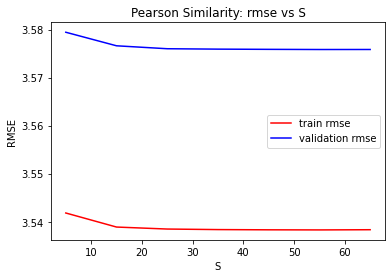

In [50]:
plt.plot(PearsonCF_s,PearsonCF_train, color= 'r' ,label='train rmse' )
plt.plot(PearsonCF_s,PearsonCF_val, color= 'b',label='validation rmse' )
plt.xlabel('S')
plt.ylabel('RMSE')
plt.title('Pearson Similarity: rmse vs S')
plt.legend()
plt.show()

In [51]:
PearsonCF_model = tc.item_similarity_recommender.create(train4,similarity_type='pearson',user_id=user_id, item_id=item_id,target = target,only_top_k=25)

Preparing data set.

Data has 135114 observations with 22183 users and 248 items.

Data prepared in: 0.188729s

Training model from provided data.

Gathering per-item and per-user statistics.

+--------------------------------+------------+

| Elapsed Time (Item Statistics) | % Complete |

+--------------------------------+------------+

| 1.126ms                        | 4.5        |

| 16.974ms                       | 100        |

+--------------------------------+------------+

Setting up lookup tables.

Processing data in one pass using dense lookup tables.

+-------------------------------------+------------------+-----------------+

| Elapsed Time (Constructing Lookups) | Total % Complete | Items Processed |

+-------------------------------------+------------------+-----------------+

| 17.648ms                            | 0                | 0               |

| 46.025ms                            | 100              | 248             |

+-------------------------------------+------------------+-----------------+

Finalizing lookup tables.

Generating candidate set for working with new users.

Finished training in 0.062102s

In [52]:
PearsonCF_evaluation = PearsonCF_model.evaluate_precision_recall(test,cutoffs = list(range(1, 31)))

recommendations finished on 1000/17326 queries. users per second: 78021.4

recommendations finished on 2000/17326 queries. users per second: 99775.5

recommendations finished on 3000/17326 queries. users per second: 108448

recommendations finished on 4000/17326 queries. users per second: 118529

recommendations finished on 5000/17326 queries. users per second: 124091

recommendations finished on 6000/17326 queries. users per second: 127111

recommendations finished on 7000/17326 queries. users per second: 126970

recommendations finished on 8000/17326 queries. users per second: 126044

recommendations finished on 9000/17326 queries. users per second: 125946

recommendations finished on 10000/17326 queries. users per second: 123153

recommendations finished on 11000/17326 queries. users per second: 124508

recommendations finished on 12000/17326 queries. users per second: 119851

recommendations finished on 13000/17326 queries. users per second: 115747

recommendations finished on 14000/17326 queries. users per second: 115408

recommendations finished on 15000/17326 queries. users per second: 114029

recommendations finished on 16000/17326 queries. users per second: 112757

recommendations finished on 17000/17326 queries. users per second: 109822

In [53]:
col_names =  ['cutoff', 'precision', 'recall'] 
PearsonCF_results  = pd.DataFrame(columns = col_names)
PearsonCF_results['cutoff'] = np.array(PearsonCF_evaluation['precision_recall_overall']['cutoff'])
PearsonCF_results['precision'] = np.array(PearsonCF_evaluation['precision_recall_overall']['precision'])
PearsonCF_results['recall'] = np.array(PearsonCF_evaluation['precision_recall_overall']['recall'])

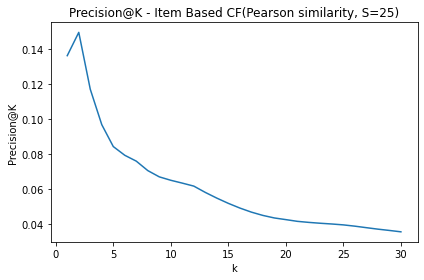

In [55]:
plt.plot(PearsonCF_results['cutoff'],PearsonCF_results['precision'] )
plt.title('Precision@K - Item Based CF(Pearson similarity, S=25)')
plt.xlabel('k')
plt.ylabel('Precision@K')
plt.tight_layout()
plt.show()

# Item Based CF - Jaccard

In [57]:
JaccardCF_s, JaccardCF_train, JaccardCF_val = test_s_vals('jaccard')

Preparing data set.

Data has 101335 observations with 22098 users and 246 items.

Data prepared in: 0.130187s

Training model from provided data.

Gathering per-item and per-user statistics.

+--------------------------------+------------+

| Elapsed Time (Item Statistics) | % Complete |

+--------------------------------+------------+

| 1.117ms                        | 4.5        |

| 20.31ms                        | 100        |

+--------------------------------+------------+

Setting up lookup tables.

Processing data in one pass using dense lookup tables.

+-------------------------------------+------------------+-----------------+

| Elapsed Time (Constructing Lookups) | Total % Complete | Items Processed |

+-------------------------------------+------------------+-----------------+

| 20.87ms                             | 0                | 0               |

| 35.368ms                            | 100              | 246             |

+-------------------------------------+------------------+-----------------+

Finalizing lookup tables.

Generating candidate set for working with new users.

PROGRESS: Evaluate model M0

Finished training in 0.048458s

recommendations finished on 1000/22098 queries. users per second: 70013.3

recommendations finished on 2000/22098 queries. users per second: 90179.5

recommendations finished on 3000/22098 queries. users per second: 93867.3

recommendations finished on 4000/22098 queries. users per second: 85182.5

recommendations finished on 5000/22098 queries. users per second: 78854.4

recommendations finished on 6000/22098 queries. users per second: 78378.1

recommendations finished on 7000/22098 queries. users per second: 79787.5

recommendations finished on 8000/22098 queries. users per second: 79954.4

recommendations finished on 9000/22098 queries. users per second: 75327

recommendations finished on 10000/22098 queries. users per second: 77801.6

recommendations finished on 11000/22098 queries. users per second: 78942.5

recommendations finished on 12000/22098 queries. users per second: 77290.7

recommendations finished on 13000/22098 queries. users per second: 77603.1

recommendations finished on 14000/22098 queries. users per second: 78258.2

recommendations finished on 15000/22098 queries. users per second: 79940.3

recommendations finished on 16000/22098 queries. users per second: 79556.5

recommendations finished on 17000/22098 queries. users per second: 79414.4

recommendations finished on 18000/22098 queries. users per second: 81020.9

recommendations finished on 19000/22098 queries. users per second: 81944.9

recommendations finished on 20000/22098 queries. users per second: 81540.8

recommendations finished on 21000/22098 queries. users per second: 81696.8

recommendations finished on 22000/22098 queries. users per second: 79387.1


Precision and recall summary statistics by cutoff
+--------+---------------------+---------------------+
| cutoff |    mean_precision   |     mean_recall     |
+--------+---------------------+---------------------+
|   1    | 0.07688478595348001 | 0.01204339369235127 |
|   2    | 0.11313241017286635 | 0.03774330509021073 |
|   3    |  0.148731408573928  | 0.07924616214053729 |
|   4    |  0.1916236763508009 | 0.14614177577395576 |
|   5    | 0.24033849217123665 |  0.2435946561240208 |
|   6    |  0.2638700334871936 |  0.3388006823923075 |
|   7    |  0.2508307151261272 | 0.37608512851689846 |
|   8    | 0.23402570368359127 | 0.39955897615779984 |
|   9    | 0.21820979274142485 |  0.4178097261811092 |
|   10   | 0.20412707032310584 |  0.432571142818636  |
+--------+---------------------+---------------------+
[10 rows x 3 columns]


Overall RMSE: 4.416789562828138

Per User RMSE (best)
+-----------+--------------------+-------+
|  user_id  |        rmse        | count |
+-----------+--

Preparing data set.

Data has 101335 observations with 22098 users and 246 items.

Data prepared in: 0.170306s

Training model from provided data.

Gathering per-item and per-user statistics.

+--------------------------------+------------+

| Elapsed Time (Item Statistics) | % Complete |

+--------------------------------+------------+

| 1.052ms                        | 4.5        |

| 16.947ms                       | 100        |

+--------------------------------+------------+

Setting up lookup tables.

Processing data in one pass using dense lookup tables.

+-------------------------------------+------------------+-----------------+

| Elapsed Time (Constructing Lookups) | Total % Complete | Items Processed |

+-------------------------------------+------------------+-----------------+

| 17.573ms                            | 0                | 0               |

| 36.431ms                            | 100              | 246             |

+-------------------------------------+------------------+-----------------+

Finalizing lookup tables.

Generating candidate set for working with new users.

Finished training in 0.051261s

PROGRESS: Evaluate model M0


recommendations finished on 1000/22098 queries. users per second: 37369.2

recommendations finished on 2000/22098 queries. users per second: 40285.2

recommendations finished on 3000/22098 queries. users per second: 42599.7

recommendations finished on 4000/22098 queries. users per second: 44343.4

recommendations finished on 5000/22098 queries. users per second: 44151.3

recommendations finished on 6000/22098 queries. users per second: 44079.7

recommendations finished on 7000/22098 queries. users per second: 44247.2

recommendations finished on 8000/22098 queries. users per second: 45750.9

recommendations finished on 9000/22098 queries. users per second: 46167.1

recommendations finished on 10000/22098 queries. users per second: 46683.6

recommendations finished on 11000/22098 queries. users per second: 47057.8

recommendations finished on 12000/22098 queries. users per second: 48151.4

recommendations finished on 13000/22098 queries. users per second: 47842.1

recommendations finished on 14000/22098 queries. users per second: 47965.6

recommendations finished on 15000/22098 queries. users per second: 47338.6

recommendations finished on 16000/22098 queries. users per second: 48366.3

recommendations finished on 17000/22098 queries. users per second: 49422.9

recommendations finished on 18000/22098 queries. users per second: 48018.1

recommendations finished on 19000/22098 queries. users per second: 45469.1

recommendations finished on 20000/22098 queries. users per second: 43772.4

recommendations finished on 21000/22098 queries. users per second: 43582.4

recommendations finished on 22000/22098 queries. users per second: 41987


Precision and recall summary statistics by cutoff
+--------+---------------------+----------------------+
| cutoff |    mean_precision   |     mean_recall      |
+--------+---------------------+----------------------+
|   1    | 0.05204090867951848 | 0.007738233010762516 |
|   2    |  0.071522309711286  | 0.022173618551708258 |
|   3    | 0.09160708359730897 | 0.045212550778515305 |
|   4    | 0.11657163544212154 | 0.08090612770793953  |
|   5    | 0.13517060367454053 | 0.12163307950649463  |
|   6    | 0.14502820768093663 | 0.16026657888684806  |
|   7    | 0.15144874132112812 | 0.19650974369776802  |
|   8    | 0.15725970676079293 |  0.2356037121345298  |
|   9    | 0.16413250067879498 |  0.2797668394860708  |
|   10   |  0.1694995022173956 | 0.32816197488937304  |
+--------+---------------------+----------------------+
[10 rows x 3 columns]


Overall RMSE: 4.409329638424776

Per User RMSE (best)
+-----------+--------------------+-------+
|  user_id  |        rmse        | count |
+

Preparing data set.

Data has 101335 observations with 22098 users and 246 items.

Data prepared in: 0.123s

Training model from provided data.

Gathering per-item and per-user statistics.

+--------------------------------+------------+

| Elapsed Time (Item Statistics) | % Complete |

+--------------------------------+------------+

| 1.627ms                        | 4.5        |

| 24.115ms                       | 100        |

+--------------------------------+------------+

Setting up lookup tables.

Processing data in one pass using dense lookup tables.

+-------------------------------------+------------------+-----------------+

| Elapsed Time (Constructing Lookups) | Total % Complete | Items Processed |

+-------------------------------------+------------------+-----------------+

| 24.898ms                            | 0                | 0               |

| 47.529ms                            | 100              | 246             |

+-------------------------------------+------------------+-----------------+

Finalizing lookup tables.

Generating candidate set for working with new users.

Finished training in 0.065306s

PROGRESS: Evaluate model M0


recommendations finished on 1000/22098 queries. users per second: 32511.9

recommendations finished on 2000/22098 queries. users per second: 40420.4

recommendations finished on 3000/22098 queries. users per second: 45680.9

recommendations finished on 4000/22098 queries. users per second: 45711.7

recommendations finished on 5000/22098 queries. users per second: 46982.8

recommendations finished on 6000/22098 queries. users per second: 49379.1

recommendations finished on 7000/22098 queries. users per second: 50638.4

recommendations finished on 8000/22098 queries. users per second: 51071.2

recommendations finished on 9000/22098 queries. users per second: 51568.2

recommendations finished on 10000/22098 queries. users per second: 52413.4

recommendations finished on 11000/22098 queries. users per second: 51561.6

recommendations finished on 12000/22098 queries. users per second: 52266.2

recommendations finished on 13000/22098 queries. users per second: 52239

recommendations finished on 14000/22098 queries. users per second: 53212.1

recommendations finished on 15000/22098 queries. users per second: 53779.4

recommendations finished on 16000/22098 queries. users per second: 54252.7

recommendations finished on 17000/22098 queries. users per second: 54452.4

recommendations finished on 18000/22098 queries. users per second: 55785.6

recommendations finished on 19000/22098 queries. users per second: 55563

recommendations finished on 20000/22098 queries. users per second: 55616.3

recommendations finished on 21000/22098 queries. users per second: 55348.7

recommendations finished on 22000/22098 queries. users per second: 55105


Precision and recall summary statistics by cutoff
+--------+---------------------+----------------------+
| cutoff |    mean_precision   |     mean_recall      |
+--------+---------------------+----------------------+
|   1    | 0.04407638700334857 | 0.006554571097860344 |
|   2    | 0.06358041451715071 | 0.020054826737754345 |
|   3    | 0.08506048812863892 | 0.04234411333474477  |
|   4    | 0.11086976196940908 |  0.0770343243655746  |
|   5    | 0.12956828672278106 | 0.11655675549349472  |
|   6    | 0.14072917609436736 |  0.1560287425331221  |
|   7    | 0.14556585599213911 |  0.1891955277979227  |
|   8    | 0.14824305367001542 |  0.2220676245926299  |
|   9    | 0.15210526845063918 |  0.257895348207822   |
|   10   |  0.1580550276043078 |  0.3030763774653465  |
+--------+---------------------+----------------------+
[10 rows x 3 columns]


Overall RMSE: 4.40722701920031

Per User RMSE (best)
+-----------+--------------------+-------+
|  user_id  |        rmse        | count |
+-

Preparing data set.

Data has 101335 observations with 22098 users and 246 items.

Data prepared in: 0.185056s

Training model from provided data.

Gathering per-item and per-user statistics.

+--------------------------------+------------+

| Elapsed Time (Item Statistics) | % Complete |

+--------------------------------+------------+

| 1.209ms                        | 4.5        |

| 17.962ms                       | 100        |

+--------------------------------+------------+

Setting up lookup tables.

Processing data in one pass using dense lookup tables.

+-------------------------------------+------------------+-----------------+

| Elapsed Time (Constructing Lookups) | Total % Complete | Items Processed |

+-------------------------------------+------------------+-----------------+

| 18.749ms                            | 0                | 0               |

| 42.145ms                            | 100              | 246             |

+-------------------------------------+------------------+-----------------+

Finalizing lookup tables.

Generating candidate set for working with new users.

PROGRESS: Evaluate model M0

Finished training in 0.058573s

recommendations finished on 1000/22098 queries. users per second: 53541.8

recommendations finished on 2000/22098 queries. users per second: 64758.5

recommendations finished on 3000/22098 queries. users per second: 65704.5

recommendations finished on 4000/22098 queries. users per second: 63900.8

recommendations finished on 5000/22098 queries. users per second: 60859.1

recommendations finished on 6000/22098 queries. users per second: 58713.6

recommendations finished on 7000/22098 queries. users per second: 56926.8

recommendations finished on 8000/22098 queries. users per second: 57313.6

recommendations finished on 9000/22098 queries. users per second: 57009.3

recommendations finished on 10000/22098 queries. users per second: 56264.8

recommendations finished on 11000/22098 queries. users per second: 56528.8

recommendations finished on 12000/22098 queries. users per second: 55819.1

recommendations finished on 13000/22098 queries. users per second: 57254.6

recommendations finished on 14000/22098 queries. users per second: 56699

recommendations finished on 15000/22098 queries. users per second: 57669.9

recommendations finished on 16000/22098 queries. users per second: 57801

recommendations finished on 17000/22098 queries. users per second: 58646.4

recommendations finished on 18000/22098 queries. users per second: 59007.7

recommendations finished on 19000/22098 queries. users per second: 59579.6

recommendations finished on 20000/22098 queries. users per second: 59672.3

recommendations finished on 21000/22098 queries. users per second: 59263.4

recommendations finished on 22000/22098 queries. users per second: 58459.6


Precision and recall summary statistics by cutoff
+--------+----------------------+----------------------+
| cutoff |    mean_precision    |     mean_recall      |
+--------+----------------------+----------------------+
|   1    | 0.046248529278667655 | 0.006711373065772097 |
|   2    | 0.06507376233143276  | 0.019955777919569668 |
|   3    | 0.08475880170151104  | 0.04139642621631072  |
|   4    | 0.11126572540501403  | 0.07666962948066912  |
|   5    | 0.12984885510000882  | 0.11634263493443305  |
|   6    | 0.14057079072012552  | 0.15558209793639335  |
|   7    | 0.14544302651823654  |  0.1886658960612439  |
|   8    | 0.14827699339306719  |  0.2217988649228957  |
|   9    |  0.1514063615611266  |  0.256214262044177   |
|   10   | 0.15673816634989554  |  0.3002815631842595  |
+--------+----------------------+----------------------+
[10 rows x 3 columns]


Overall RMSE: 4.406134113743418

Per User RMSE (best)
+-----------+--------------------+-------+
|  user_id  |        rmse     

Preparing data set.

Data has 101335 observations with 22098 users and 246 items.

Data prepared in: 0.135628s

Training model from provided data.

Gathering per-item and per-user statistics.

+--------------------------------+------------+

| Elapsed Time (Item Statistics) | % Complete |

+--------------------------------+------------+

| 28.105ms                       | 4.5        |

| 42.005ms                       | 100        |

+--------------------------------+------------+

Setting up lookup tables.

Processing data in one pass using dense lookup tables.

+-------------------------------------+------------------+-----------------+

| Elapsed Time (Constructing Lookups) | Total % Complete | Items Processed |

+-------------------------------------+------------------+-----------------+

| 43.638ms                            | 0                | 0               |

| 78.31ms                             | 100              | 246             |

+-------------------------------------+------------------+-----------------+

Finalizing lookup tables.

Generating candidate set for working with new users.

Finished training in 0.108343s

PROGRESS: Evaluate model M0


recommendations finished on 1000/22098 queries. users per second: 42622.1

recommendations finished on 2000/22098 queries. users per second: 33943.2

recommendations finished on 3000/22098 queries. users per second: 33483.3

recommendations finished on 4000/22098 queries. users per second: 38215.3

recommendations finished on 5000/22098 queries. users per second: 38798.5

recommendations finished on 6000/22098 queries. users per second: 38003.1

recommendations finished on 7000/22098 queries. users per second: 39598.4

recommendations finished on 8000/22098 queries. users per second: 40162.5

recommendations finished on 9000/22098 queries. users per second: 38947.7

recommendations finished on 10000/22098 queries. users per second: 40233.2

recommendations finished on 11000/22098 queries. users per second: 40247.8

recommendations finished on 12000/22098 queries. users per second: 41595.6

recommendations finished on 13000/22098 queries. users per second: 41163.1

recommendations finished on 14000/22098 queries. users per second: 42068.3

recommendations finished on 15000/22098 queries. users per second: 42998.2

recommendations finished on 16000/22098 queries. users per second: 43531

recommendations finished on 17000/22098 queries. users per second: 44406.8

recommendations finished on 18000/22098 queries. users per second: 44220

recommendations finished on 19000/22098 queries. users per second: 45168.5

recommendations finished on 20000/22098 queries. users per second: 46045.2

recommendations finished on 21000/22098 queries. users per second: 46985.4

recommendations finished on 22000/22098 queries. users per second: 46074


Precision and recall summary statistics by cutoff
+--------+---------------------+----------------------+
| cutoff |    mean_precision   |     mean_recall      |
+--------+---------------------+----------------------+
|   1    | 0.04629378224273696 | 0.006694390230148849 |
|   2    | 0.06548103900805505 | 0.019970493874302483 |
|   3    | 0.08492472923643125 | 0.04136396340554229  |
|   4    |  0.1110734003077202 | 0.07650935050619032  |
|   5    | 0.12970404561498694 | 0.11639708412381829  |
|   6    | 0.14033698373910183 | 0.15543895309804817  |
|   7    | 0.14491292036771286 |  0.1879913663174389  |
|   8    | 0.14769436148067683 | 0.22089700838437268  |
|   9    | 0.15096388813467304 | 0.25526799545339623  |
|   10   |  0.1561815548918443 | 0.29910074417622273  |
+--------+---------------------+----------------------+
[10 rows x 3 columns]


Overall RMSE: 4.405680375888086

Per User RMSE (best)
+-----------+--------------------+-------+
|  user_id  |        rmse        | count |
+

Preparing data set.

Data has 101335 observations with 22098 users and 246 items.

Data prepared in: 0.142464s

Training model from provided data.

Gathering per-item and per-user statistics.

+--------------------------------+------------+

| Elapsed Time (Item Statistics) | % Complete |

+--------------------------------+------------+

| 1.211ms                        | 4.5        |

| 22.565ms                       | 100        |

+--------------------------------+------------+

Setting up lookup tables.

Processing data in one pass using dense lookup tables.

+-------------------------------------+------------------+-----------------+

| Elapsed Time (Constructing Lookups) | Total % Complete | Items Processed |

+-------------------------------------+------------------+-----------------+

| 23.482ms                            | 0                | 0               |

| 47.261ms                            | 100              | 246             |

+-------------------------------------+------------------+-----------------+

Finalizing lookup tables.

Generating candidate set for working with new users.

Finished training in 0.065845s

PROGRESS: Evaluate model M0


recommendations finished on 1000/22098 queries. users per second: 29753.9

recommendations finished on 2000/22098 queries. users per second: 38706.4

recommendations finished on 3000/22098 queries. users per second: 43141.9

recommendations finished on 4000/22098 queries. users per second: 45558.1

recommendations finished on 5000/22098 queries. users per second: 47876.7

recommendations finished on 6000/22098 queries. users per second: 48502.1

recommendations finished on 7000/22098 queries. users per second: 47697.2

recommendations finished on 8000/22098 queries. users per second: 47875.5

recommendations finished on 9000/22098 queries. users per second: 49417.4

recommendations finished on 10000/22098 queries. users per second: 50130.6

recommendations finished on 11000/22098 queries. users per second: 51024.9

recommendations finished on 12000/22098 queries. users per second: 51060.8

recommendations finished on 13000/22098 queries. users per second: 51021.2

recommendations finished on 14000/22098 queries. users per second: 52055.3

recommendations finished on 15000/22098 queries. users per second: 53031.3

recommendations finished on 16000/22098 queries. users per second: 53758.4

recommendations finished on 17000/22098 queries. users per second: 54116.7

recommendations finished on 18000/22098 queries. users per second: 54265.6

recommendations finished on 19000/22098 queries. users per second: 54700

recommendations finished on 20000/22098 queries. users per second: 55316.6

recommendations finished on 21000/22098 queries. users per second: 56074.5

recommendations finished on 22000/22098 queries. users per second: 55290.8


Precision and recall summary statistics by cutoff
+--------+----------------------+----------------------+
| cutoff |    mean_precision    |     mean_recall      |
+--------+----------------------+----------------------+
|   1    | 0.047651371164811315 | 0.006879436815887799 |
|   2    | 0.06570730382840062  | 0.020233694543282468 |
|   3    | 0.08539234319847966  | 0.04200338090621415  |
|   4    | 0.11171825504570558  | 0.07751807857912617  |
|   5    | 0.13020182821974846  | 0.11711286891140209  |
|   6    | 0.14063867016622947  |  0.1558482264690423  |
|   7    |  0.1454042382633202  | 0.18885208399074813  |
|   8    |  0.1481978007059461  | 0.22175891409227225  |
|   9    | 0.15141641777536374  | 0.25619115573204015  |
|   10   | 0.15648022445470122  | 0.29968455502956953  |
+--------+----------------------+----------------------+
[10 rows x 3 columns]


Overall RMSE: 4.405634758014774

Per User RMSE (best)
+-----------+--------------------+-------+
|  user_id  |        rmse     

Preparing data set.

Data has 101335 observations with 22098 users and 246 items.

Data prepared in: 0.158453s

Training model from provided data.

Gathering per-item and per-user statistics.

+--------------------------------+------------+

| Elapsed Time (Item Statistics) | % Complete |

+--------------------------------+------------+

| 1.14ms                         | 4.5        |

| 17.99ms                        | 100        |

+--------------------------------+------------+

Setting up lookup tables.

Processing data in one pass using dense lookup tables.

+-------------------------------------+------------------+-----------------+

| Elapsed Time (Constructing Lookups) | Total % Complete | Items Processed |

+-------------------------------------+------------------+-----------------+

| 18.962ms                            | 0                | 0               |

| 47.713ms                            | 100              | 246             |

+-------------------------------------+------------------+-----------------+

Finalizing lookup tables.

Generating candidate set for working with new users.

Finished training in 0.068621s

PROGRESS: Evaluate model M0


recommendations finished on 1000/22098 queries. users per second: 47943.2

recommendations finished on 2000/22098 queries. users per second: 54561.3

recommendations finished on 3000/22098 queries. users per second: 56527

recommendations finished on 4000/22098 queries. users per second: 57124.1

recommendations finished on 5000/22098 queries. users per second: 57050.3

recommendations finished on 6000/22098 queries. users per second: 56295.2

recommendations finished on 7000/22098 queries. users per second: 56340.7

recommendations finished on 8000/22098 queries. users per second: 55312.4

recommendations finished on 9000/22098 queries. users per second: 55213.7

recommendations finished on 10000/22098 queries. users per second: 55745.7

recommendations finished on 11000/22098 queries. users per second: 55218.1

recommendations finished on 12000/22098 queries. users per second: 54067.4

recommendations finished on 13000/22098 queries. users per second: 52731.1

recommendations finished on 14000/22098 queries. users per second: 51831.9

recommendations finished on 15000/22098 queries. users per second: 52255

recommendations finished on 16000/22098 queries. users per second: 53205.6

recommendations finished on 17000/22098 queries. users per second: 53707.4

recommendations finished on 18000/22098 queries. users per second: 53687

recommendations finished on 19000/22098 queries. users per second: 53865

recommendations finished on 20000/22098 queries. users per second: 53191.5

recommendations finished on 21000/22098 queries. users per second: 53634

recommendations finished on 22000/22098 queries. users per second: 53268


Precision and recall summary statistics by cutoff
+--------+----------------------+----------------------+
| cutoff |    mean_precision    |     mean_recall      |
+--------+----------------------+----------------------+
|   1    | 0.058331070685129875 | 0.008489356858719026 |
|   2    |  0.0805729025251153  | 0.024634022882842832 |
|   3    | 0.10476061182007446  | 0.052212849371350074 |
|   4    | 0.12283917096569826  | 0.08592024868158966  |
|   5    | 0.13269979183636563  | 0.12003528416946779  |
|   6    | 0.14000512866926149  |  0.1557628726040905  |
|   7    | 0.14409836701446846  | 0.18807033882288454  |
|   8    | 0.14816386098289416  | 0.22244115078993593  |
|   9    |  0.1526633883408251  |  0.2592925555367321  |
|   10   | 0.15871572087971772  |  0.3051799283220508  |
+--------+----------------------+----------------------+
[10 rows x 3 columns]


Overall RMSE: 4.40606593707818

Per User RMSE (best)
+-----------+--------------------+-------+
|  user_id  |        rmse      

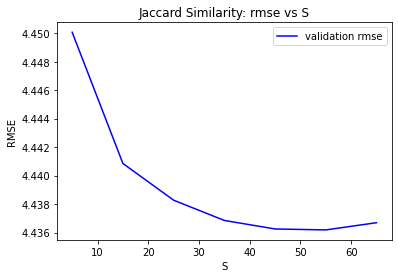

In [65]:
#plt.plot(JaccardCF_s,JaccardCF_train, color= 'r' ,label='train rmse' )
plt.plot(JaccardCF_s,JaccardCF_val, color= 'b',label='validation rmse' )
plt.xlabel('S')
plt.ylabel('RMSE')
plt.title('Jaccard Similarity: rmse vs S')
plt.legend()
plt.show()

In [66]:
JaccardCF_model = tc.item_similarity_recommender.create(train4,similarity_type='jaccard',user_id=user_id, item_id=item_id,target = target,only_top_k=30)

Preparing data set.

Data has 135114 observations with 22183 users and 248 items.

Data prepared in: 0.138719s

Training model from provided data.

Gathering per-item and per-user statistics.

+--------------------------------+------------+

| Elapsed Time (Item Statistics) | % Complete |

+--------------------------------+------------+

| 1.256ms                        | 4.5        |

| 6.462ms                        | 100        |

+--------------------------------+------------+

Setting up lookup tables.

Processing data in one pass using dense lookup tables.

+-------------------------------------+------------------+-----------------+

| Elapsed Time (Constructing Lookups) | Total % Complete | Items Processed |

+-------------------------------------+------------------+-----------------+

| 7.33ms                              | 0                | 0               |

| 18.117ms                            | 100              | 248             |

+-------------------------------------+------------------+-----------------+

Finalizing lookup tables.

Generating candidate set for working with new users.

Finished training in 0.032742s

In [67]:
JaccardCF_evaluation = JaccardCF_model.evaluate_precision_recall(test,cutoffs = list(range(1, 31)))

recommendations finished on 1000/17326 queries. users per second: 68596.5

recommendations finished on 2000/17326 queries. users per second: 73879.8

recommendations finished on 3000/17326 queries. users per second: 77010

recommendations finished on 4000/17326 queries. users per second: 79192.2

recommendations finished on 5000/17326 queries. users per second: 85623.8

recommendations finished on 6000/17326 queries. users per second: 92363.1

recommendations finished on 7000/17326 queries. users per second: 96295.4

recommendations finished on 8000/17326 queries. users per second: 100059

recommendations finished on 9000/17326 queries. users per second: 100416

recommendations finished on 10000/17326 queries. users per second: 102254

recommendations finished on 11000/17326 queries. users per second: 101064

recommendations finished on 12000/17326 queries. users per second: 101382

recommendations finished on 13000/17326 queries. users per second: 102000

recommendations finished on 14000/17326 queries. users per second: 103240

recommendations finished on 15000/17326 queries. users per second: 103440

recommendations finished on 16000/17326 queries. users per second: 105372

recommendations finished on 17000/17326 queries. users per second: 101406

In [68]:
col_names =  ['cutoff', 'precision', 'recall'] 
JaccardCF_results  = pd.DataFrame(columns = col_names)
JaccardCF_results['cutoff'] = np.array(JaccardCF_evaluation['precision_recall_overall']['cutoff'])
JaccardCF_results['precision'] = np.array(JaccardCF_evaluation['precision_recall_overall']['precision'])
JaccardCF_results['recall'] = np.array(JaccardCF_evaluation['precision_recall_overall']['recall'])

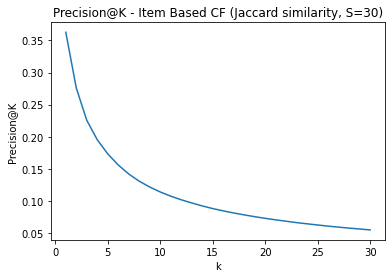

In [69]:
plt.plot(JaccardCF_results['cutoff'],JaccardCF_results['precision'] )
plt.title('Precision@K - Item Based CF (Jaccard similarity, S=30)')
plt.xlabel('k')
plt.ylabel('Precision@K')
plt.show()

# Matrix Factorization iALS
ials_confidence_scaling_factor  = 50


number of feature = 2

reg  = 1e-4

max iter = 20

In [13]:
# constant variables to define field names include:
user_id = 'user_id'
item_id = 'brand'
target = 'purchase_count'

In [74]:
# hyperparameter tuning for number of feature
num_features = np.arange(1,50,2)
def test_k_vals():
    k_list = []
    train = []
    val = []
    for loc, k in enumerate(num_features):
        model = tc.ranking_factorization_recommender.create(train3,item_id = item_id, target = target,\
                                                                   user_id = user_id, binary_target = False,\
                                                                   solver = 'ials', num_factors = k)
        rmse_train = tc.recommender.util.compare_models(train3, [model],exclude_known_for_precision_recall=False)
        rmse_train = rmse_train[0]['rmse_overall']
        k_list.append(k)
        train.append(rmse_train)
        rmse_val = tc.recommender.util.compare_models(validation, [model], model_names=["m1"], metric='rmse')
        rmse_val = rmse_val[0]['rmse_overall']
        val.append(rmse_val)
    return k_list,train,val

In [75]:
ials_k, ials_train_k, ials_val_k = test_k_vals() 

Preparing data set.

Data has 101335 observations with 22098 users and 246 items.

Data prepared in: 0.130819s

Training ranking_factorization_recommender for recommendations.

+------------------------------+--------------------------------------------------+----------+

| Parameter                    | Description                                      | Value    |

+------------------------------+--------------------------------------------------+----------+

| num_factors                  | Factor Dimension                                 | 1        |

| regularization               | L2 Regularization on Factors                     | 1e-09    |

| max_iterations               | Maximum Number of Iterations                     | 25       |

| solver                       | Solver used for training                         | ials     |

+------------------------------+--------------------------------------------------+----------+

+---------+--------------+---------------------------+

| Iter.   | Elapsed time | Estimated Objective Value |

+---------+--------------+---------------------------+

| Initial | 329us        | NA                        |

+---------+--------------+---------------------------+

| 0       | 29.555ms     | 4.36387                   |

| 1       | 53.373ms     | 4.18029                   |

| 2       | 86.909ms     | 4.17791                   |

| 3       | 107.309ms    | 4.17793                   |

| 4       | 130.033ms    | 4.17797                   |

| 5       | 151.103ms    | 4.17801                   |

| 6       | 175.397ms    | 4.17804                   |

| 7       | 240.223ms    | 4.17806                   |

| 8       | 265.417ms    | 4.17809                   |

| 9       | 292.682ms    | 4.17811                   |

| 10      | 322.078ms    | 4.17813                   |

| 11      | 345.234ms    | 4.17815                   |

| 12      | 373.001ms    | 4.17817                   |

| 13      | 404.463ms    | 4.17819                   |

| 14      | 428.853ms    | 4.1782                    |

| 15      | 457.491ms    | 4.17821                   |

| 16      | 499.007ms    | 4.17823                   |

| 17      | 527.041ms    | 4.17824                   |

| 18      | 569.507ms    | 4.17825                   |

| 19      | 594.808ms    | 4.17826                   |

| 20      | 624.852ms    | 4.17827                   |

| 21      | 650.573ms    | 4.17828                   |

| 22      | 683.137ms    | 4.17829                   |

| 23      | 716.25ms     | 4.1783                    |

| 24      | 749.022ms    | 4.17831                   |

| FINAL   | 749.098ms    | 4.17831                   |

+---------+--------------+---------------------------+

Optimization Complete: Iteration limit reached.

PROGRESS: Evaluate model M0


recommendations finished on 1000/22098 queries. users per second: 55444.7

recommendations finished on 2000/22098 queries. users per second: 73019.4

recommendations finished on 3000/22098 queries. users per second: 76053.3

recommendations finished on 4000/22098 queries. users per second: 78015.3

recommendations finished on 5000/22098 queries. users per second: 72295.1

recommendations finished on 6000/22098 queries. users per second: 74203.2

recommendations finished on 7000/22098 queries. users per second: 75943.3

recommendations finished on 8000/22098 queries. users per second: 78447.5

recommendations finished on 9000/22098 queries. users per second: 80683.5

recommendations finished on 10000/22098 queries. users per second: 81654

recommendations finished on 11000/22098 queries. users per second: 82737.2

recommendations finished on 12000/22098 queries. users per second: 79058.7

recommendations finished on 13000/22098 queries. users per second: 79616.9

recommendations finished on 14000/22098 queries. users per second: 81158

recommendations finished on 15000/22098 queries. users per second: 82380.9

recommendations finished on 16000/22098 queries. users per second: 83644.4

recommendations finished on 17000/22098 queries. users per second: 84927.4

recommendations finished on 18000/22098 queries. users per second: 85876.2

recommendations finished on 19000/22098 queries. users per second: 84293.8

recommendations finished on 20000/22098 queries. users per second: 84816.2

recommendations finished on 21000/22098 queries. users per second: 85088.1

recommendations finished on 22000/22098 queries. users per second: 84139.4


Precision and recall summary statistics by cutoff
+--------+---------------------+---------------------+
| cutoff |    mean_precision   |     mean_recall     |
+--------+---------------------+---------------------+
|   1    |  0.4375509095845777 | 0.10345141081884354 |
|   2    |  0.422526925513621  | 0.19861616590499648 |
|   3    | 0.35954988385072567 | 0.25081199488863476 |
|   4    |  0.3211602859987324 |  0.2954038019209522 |
|   5    | 0.29292243641958593 |  0.3367359451399461 |
|   6    | 0.27757413943946685 |  0.3800203922345458 |
|   7    | 0.25575035879135866 | 0.40596783760655253 |
|   8    | 0.24119264186804218 | 0.43659901228670855 |
|   9    | 0.22771794330306364 |  0.4613961382302129 |
|   10   | 0.21954475518146435 | 0.49215438608988993 |
+--------+---------------------+---------------------+
[10 rows x 3 columns]


Overall RMSE: 4.178306554584746

Per User RMSE (best)
+-----------+---------------------+-------+
|  user_id  |         rmse        | count |
+-----------+

Preparing data set.

Data has 101335 observations with 22098 users and 246 items.

Data prepared in: 0.132412s

Training ranking_factorization_recommender for recommendations.

+------------------------------+--------------------------------------------------+----------+

| Parameter                    | Description                                      | Value    |

+------------------------------+--------------------------------------------------+----------+

| num_factors                  | Factor Dimension                                 | 3        |

| regularization               | L2 Regularization on Factors                     | 1e-09    |

| max_iterations               | Maximum Number of Iterations                     | 25       |

| solver                       | Solver used for training                         | ials     |

+------------------------------+--------------------------------------------------+----------+

+---------+--------------+---------------------------+

| Iter.   | Elapsed time | Estimated Objective Value |

+---------+--------------+---------------------------+

| Initial | 131us        | NA                        |

+---------+--------------+---------------------------+

| 0       | 51.747ms     | 4.27839                   |

| 1       | 91.962ms     | 4.14246                   |

| 2       | 133.438ms    | 4.13872                   |

| 3       | 177.707ms    | 4.13774                   |

| 4       | 216.362ms    | 4.13669                   |

| 5       | 254.573ms    | 4.13596                   |

| 6       | 293.889ms    | 4.13551                   |

| 7       | 331.042ms    | 4.13515                   |

| 8       | 368.387ms    | 4.1349                    |

| 9       | 418.364ms    | 4.1347                    |

| 10      | 465.639ms    | 4.13451                   |

| 11      | 516.09ms     | 4.13432                   |

| 12      | 553.102ms    | 4.13415                   |

| 13      | 590.758ms    | 4.134                     |

| 14      | 630.49ms     | 4.13389                   |

| 15      | 672.508ms    | 4.1338                    |

| 16      | 720.7ms      | 4.13373                   |

| 17      | 760.127ms    | 4.13368                   |

| 18      | 793.484ms    | 4.13365                   |

| 19      | 824.688ms    | 4.13362                   |

| 20      | 856.748ms    | 4.13361                   |

| 21      | 888.454ms    | 4.1336                    |

| 22      | 920.419ms    | 4.13359                   |

| 23      | 959.133ms    | 4.13359                   |

| 24      | 993.672ms    | 4.13359                   |

| FINAL   | 993.748ms    | 4.13359                   |

+---------+--------------+---------------------------+

Optimization Complete: Iteration limit reached.

PROGRESS: Evaluate model M0


recommendations finished on 1000/22098 queries. users per second: 63580.9

recommendations finished on 2000/22098 queries. users per second: 72142.3

recommendations finished on 3000/22098 queries. users per second: 73960.9

recommendations finished on 4000/22098 queries. users per second: 73405.3

recommendations finished on 5000/22098 queries. users per second: 72003.6

recommendations finished on 6000/22098 queries. users per second: 73413.4

recommendations finished on 7000/22098 queries. users per second: 75504.3

recommendations finished on 8000/22098 queries. users per second: 77655.6

recommendations finished on 9000/22098 queries. users per second: 79596

recommendations finished on 10000/22098 queries. users per second: 80548.4

recommendations finished on 11000/22098 queries. users per second: 79499.9

recommendations finished on 12000/22098 queries. users per second: 79185.4

recommendations finished on 13000/22098 queries. users per second: 79480.6

recommendations finished on 14000/22098 queries. users per second: 79900.5

recommendations finished on 15000/22098 queries. users per second: 79822.9

recommendations finished on 16000/22098 queries. users per second: 80579.8

recommendations finished on 17000/22098 queries. users per second: 80832.7

recommendations finished on 18000/22098 queries. users per second: 80891.6

recommendations finished on 19000/22098 queries. users per second: 81592.3

recommendations finished on 20000/22098 queries. users per second: 81908.8

recommendations finished on 21000/22098 queries. users per second: 81145

recommendations finished on 22000/22098 queries. users per second: 78691.2


Precision and recall summary statistics by cutoff
+--------+---------------------+---------------------+
| cutoff |    mean_precision   |     mean_recall     |
+--------+---------------------+---------------------+
|   1    |  0.5898271336772558 | 0.15465128892920071 |
|   2    |  0.535048420671556  | 0.26556866142061014 |
|   3    |  0.4697257670377408 |  0.3432614278592314 |
|   4    |  0.4154561498778165 | 0.39797109025360106 |
|   5    | 0.38024255588741024 |  0.4515118945873752 |
|   6    |  0.3468790539113655 | 0.48907869620069133 |
|   7    | 0.32125725663602367 |  0.5258312001024452 |
|   8    |  0.2984432980360212 |  0.5549586948072803 |
|   9    | 0.27861244355949777 |  0.580449567657181  |
|   10   | 0.26129061453525204 |  0.6030884500881981 |
+--------+---------------------+---------------------+
[10 rows x 3 columns]


Overall RMSE: 4.133590108247794

Per User RMSE (best)
+-----------+---------------------+-------+
|  user_id  |         rmse        | count |
+-----------+

Preparing data set.

Data has 101335 observations with 22098 users and 246 items.

Data prepared in: 0.116027s

Training ranking_factorization_recommender for recommendations.

+------------------------------+--------------------------------------------------+----------+

| Parameter                    | Description                                      | Value    |

+------------------------------+--------------------------------------------------+----------+

| num_factors                  | Factor Dimension                                 | 5        |

| regularization               | L2 Regularization on Factors                     | 1e-09    |

| max_iterations               | Maximum Number of Iterations                     | 25       |

| solver                       | Solver used for training                         | ials     |

+------------------------------+--------------------------------------------------+----------+

+---------+--------------+---------------------------+

| Iter.   | Elapsed time | Estimated Objective Value |

+---------+--------------+---------------------------+

| Initial | 133us        | NA                        |

+---------+--------------+---------------------------+

| 0       | 47.215ms     | 4.25469                   |

| 1       | 90.917ms     | 4.1193                    |

| 2       | 153.984ms    | 4.11511                   |

| 3       | 221.474ms    | 4.11196                   |

| 4       | 285.404ms    | 4.10985                   |

| 5       | 366.957ms    | 4.10858                   |

| 6       | 411.32ms     | 4.10778                   |

| 7       | 520.318ms    | 4.10722                   |

| 8       | 559.749ms    | 4.10684                   |

| 9       | 603.375ms    | 4.10662                   |

| 10      | 644.957ms    | 4.10651                   |

| 11      | 691.124ms    | 4.10646                   |

| 12      | 736.22ms     | 4.10644                   |

| 13      | 782.534ms    | 4.10644                   |

| 14      | 824.979ms    | 4.10644                   |

| 15      | 870.032ms    | 4.10644                   |

| 16      | 910.076ms    | 4.10645                   |

| 17      | 950.823ms    | 4.10645                   |

| 18      | 993.005ms    | 4.10646                   |

| 19      | 1.03s        | 4.10646                   |

| 20      | 1.06s        | 4.10646                   |

| 21      | 1.10s        | 4.10646                   |

| 22      | 1.13s        | 4.10647                   |

| 23      | 1.17s        | 4.10647                   |

| 24      | 1.21s        | 4.10647                   |

| FINAL   | 1.21s        | 4.10647                   |

+---------+--------------+---------------------------+

Optimization Complete: Iteration limit reached.

PROGRESS: Evaluate model M0


recommendations finished on 1000/22098 queries. users per second: 59883.8

recommendations finished on 2000/22098 queries. users per second: 67170.4

recommendations finished on 3000/22098 queries. users per second: 72205.6

recommendations finished on 4000/22098 queries. users per second: 76305.3

recommendations finished on 5000/22098 queries. users per second: 79916.9

recommendations finished on 6000/22098 queries. users per second: 80022.4

recommendations finished on 7000/22098 queries. users per second: 81263.1

recommendations finished on 8000/22098 queries. users per second: 82425.8

recommendations finished on 9000/22098 queries. users per second: 84322.6

recommendations finished on 10000/22098 queries. users per second: 84975.5

recommendations finished on 11000/22098 queries. users per second: 84631

recommendations finished on 12000/22098 queries. users per second: 82787.7

recommendations finished on 13000/22098 queries. users per second: 83405.5

recommendations finished on 14000/22098 queries. users per second: 83587.1

recommendations finished on 15000/22098 queries. users per second: 84217.1

recommendations finished on 16000/22098 queries. users per second: 84889.6

recommendations finished on 17000/22098 queries. users per second: 85723.5

recommendations finished on 18000/22098 queries. users per second: 85359

recommendations finished on 19000/22098 queries. users per second: 85946

recommendations finished on 20000/22098 queries. users per second: 86312.9

recommendations finished on 21000/22098 queries. users per second: 86434

recommendations finished on 22000/22098 queries. users per second: 84197.3


Precision and recall summary statistics by cutoff
+--------+---------------------+---------------------+
| cutoff |    mean_precision   |     mean_recall     |
+--------+---------------------+---------------------+
|   1    |  0.6809666033125175 | 0.18060456629338256 |
|   2    |  0.6150104081817364 |  0.3121301959179452 |
|   3    |  0.5444987480013286 |  0.4023159447332628 |
|   4    |  0.4873744230247081 | 0.47373278958710247 |
|   5    | 0.43602135939904085 |  0.5231204058606865 |
|   6    |  0.3936102814734365 |  0.5616582995346308 |
|   7    | 0.35888832861409553 |  0.5924027668474645 |
|   8    | 0.33100846230428066 |  0.6203057562480232 |
|   9    |  0.3079665329190178 |  0.6458286024185049 |
|   10   | 0.28810299574622106 |  0.6680017628354431 |
+--------+---------------------+---------------------+
[10 rows x 3 columns]


Overall RMSE: 4.106468588775255

Per User RMSE (best)
+-----------+----------------------+-------+
|  user_id  |         rmse         | count |
+----------

Preparing data set.

Data has 101335 observations with 22098 users and 246 items.

Data prepared in: 0.108627s

Training ranking_factorization_recommender for recommendations.

+------------------------------+--------------------------------------------------+----------+

| Parameter                    | Description                                      | Value    |

+------------------------------+--------------------------------------------------+----------+

| num_factors                  | Factor Dimension                                 | 7        |

| regularization               | L2 Regularization on Factors                     | 1e-09    |

| max_iterations               | Maximum Number of Iterations                     | 25       |

| solver                       | Solver used for training                         | ials     |

+------------------------------+--------------------------------------------------+----------+

+---------+--------------+---------------------------+

| Iter.   | Elapsed time | Estimated Objective Value |

+---------+--------------+---------------------------+

| Initial | 107us        | NA                        |

+---------+--------------+---------------------------+

| 0       | 67.83ms      | 4.17672                   |

| 1       | 122.304ms    | 4.09391                   |

| 2       | 170.515ms    | 4.0903                    |

| 3       | 225.047ms    | 4.08914                   |

| 4       | 277.059ms    | 4.08857                   |

| 5       | 338.561ms    | 4.08825                   |

| 6       | 390.674ms    | 4.08807                   |

| 7       | 444.505ms    | 4.08797                   |

| 8       | 513.964ms    | 4.08794                   |

| 9       | 565.118ms    | 4.08794                   |

| 10      | 619.198ms    | 4.08795                   |

| 11      | 671.372ms    | 4.08797                   |

| 12      | 721.781ms    | 4.08799                   |

| 13      | 773.192ms    | 4.088                     |

| 14      | 828.037ms    | 4.08801                   |

| 15      | 881.992ms    | 4.08801                   |

| 16      | 941.669ms    | 4.08802                   |

| 17      | 1.00s        | 4.08803                   |

| 18      | 1.06s        | 4.08804                   |

| 19      | 1.13s        | 4.08805                   |

| 20      | 1.19s        | 4.08806                   |

| 21      | 1.25s        | 4.08808                   |

| 22      | 1.32s        | 4.0881                    |

| 23      | 1.38s        | 4.08812                   |

| 24      | 1.44s        | 4.08814                   |

| FINAL   | 1.44s        | 4.08814                   |

+---------+--------------+---------------------------+

Optimization Complete: Iteration limit reached.

PROGRESS: Evaluate model M0


recommendations finished on 1000/22098 queries. users per second: 42356.7

recommendations finished on 2000/22098 queries. users per second: 39972

recommendations finished on 3000/22098 queries. users per second: 40998.2

recommendations finished on 4000/22098 queries. users per second: 44897.4

recommendations finished on 5000/22098 queries. users per second: 48547

recommendations finished on 6000/22098 queries. users per second: 47507.4

recommendations finished on 7000/22098 queries. users per second: 48164.6

recommendations finished on 8000/22098 queries. users per second: 48147.8

recommendations finished on 9000/22098 queries. users per second: 47846.9

recommendations finished on 10000/22098 queries. users per second: 49107.7

recommendations finished on 11000/22098 queries. users per second: 49960.5

recommendations finished on 12000/22098 queries. users per second: 50682.3

recommendations finished on 13000/22098 queries. users per second: 51888.8

recommendations finished on 14000/22098 queries. users per second: 52787.4

recommendations finished on 15000/22098 queries. users per second: 53879.1

recommendations finished on 16000/22098 queries. users per second: 55124.1

recommendations finished on 17000/22098 queries. users per second: 55817.5

recommendations finished on 18000/22098 queries. users per second: 56550.8

recommendations finished on 19000/22098 queries. users per second: 56793.4

recommendations finished on 20000/22098 queries. users per second: 57652

recommendations finished on 21000/22098 queries. users per second: 58208.3

recommendations finished on 22000/22098 queries. users per second: 57867


Precision and recall summary statistics by cutoff
+--------+---------------------+---------------------+
| cutoff |    mean_precision   |     mean_recall     |
+--------+---------------------+---------------------+
|   1    |  0.8302561317766315 | 0.22165379387427883 |
|   2    |  0.7265589646121816 | 0.37092134624160333 |
|   3    |  0.6291067064892727 | 0.46783585057898286 |
|   4    |  0.5493936102814735 |  0.5348532289542235 |
|   5    |  0.484016653090778  |  0.5806955432267528 |
|   6    |  0.4339759254231157 |  0.6173722530324149 |
|   7    |  0.3941274582056557 |  0.6486640936320694 |
|   8    |  0.3602871300570192 |  0.6723774877500939 |
|   9    |  0.3325740891583955 |  0.695003448663019  |
|   10   | 0.30857543669110393 |  0.7129883391354178 |
+--------+---------------------+---------------------+
[10 rows x 3 columns]


Overall RMSE: 4.088138943649045

Per User RMSE (best)
+-----------+----------------------+-------+
|  user_id  |         rmse         | count |
+----------

Preparing data set.

Data has 101335 observations with 22098 users and 246 items.

Data prepared in: 0.175949s

Training ranking_factorization_recommender for recommendations.

+------------------------------+--------------------------------------------------+----------+

| Parameter                    | Description                                      | Value    |

+------------------------------+--------------------------------------------------+----------+

| num_factors                  | Factor Dimension                                 | 9        |

| regularization               | L2 Regularization on Factors                     | 1e-09    |

| max_iterations               | Maximum Number of Iterations                     | 25       |

| solver                       | Solver used for training                         | ials     |

+------------------------------+--------------------------------------------------+----------+

+---------+--------------+---------------------------+

| Iter.   | Elapsed time | Estimated Objective Value |

+---------+--------------+---------------------------+

| Initial | 120us        | NA                        |

+---------+--------------+---------------------------+

| 0       | 92.006ms     | 4.17925                   |

| 1       | 160.889ms    | 4.07889                   |

| 2       | 227.008ms    | 4.07402                   |

| 3       | 328.322ms    | 4.07286                   |

| 4       | 439.291ms    | 4.07251                   |

| 5       | 543.144ms    | 4.0724                    |

| 6       | 625.003ms    | 4.07236                   |

| 7       | 711.201ms    | 4.07234                   |

| 8       | 781.255ms    | 4.07232                   |

| 9       | 848.226ms    | 4.07232                   |

| 10      | 903.845ms    | 4.07232                   |

| 11      | 974.846ms    | 4.07233                   |

| 12      | 1.07s        | 4.07235                   |

| 13      | 1.19s        | 4.07237                   |

| 14      | 1.27s        | 4.0724                    |

| 15      | 1.35s        | 4.07242                   |

| 16      | 1.42s        | 4.07244                   |

| 17      | 1.49s        | 4.07246                   |

| 18      | 1.60s        | 4.07248                   |

| 19      | 1.66s        | 4.0725                    |

| 20      | 1.73s        | 4.07252                   |

| 21      | 1.80s        | 4.07254                   |

| 22      | 1.87s        | 4.07256                   |

| 23      | 1.94s        | 4.07258                   |

| 24      | 2.02s        | 4.0726                    |

| FINAL   | 2.02s        | 4.0726                    |

+---------+--------------+---------------------------+

Optimization Complete: Iteration limit reached.

PROGRESS: Evaluate model M0


recommendations finished on 1000/22098 queries. users per second: 30235.2

recommendations finished on 2000/22098 queries. users per second: 39710.1

recommendations finished on 3000/22098 queries. users per second: 28867

recommendations finished on 4000/22098 queries. users per second: 29660.4

recommendations finished on 5000/22098 queries. users per second: 32524.3

recommendations finished on 6000/22098 queries. users per second: 33908.5

recommendations finished on 7000/22098 queries. users per second: 36076.3

recommendations finished on 8000/22098 queries. users per second: 37842.8

recommendations finished on 9000/22098 queries. users per second: 39539.2

recommendations finished on 10000/22098 queries. users per second: 40409.3

recommendations finished on 11000/22098 queries. users per second: 40153.9

recommendations finished on 12000/22098 queries. users per second: 40783.5

recommendations finished on 13000/22098 queries. users per second: 41653.7

recommendations finished on 14000/22098 queries. users per second: 42180.2

recommendations finished on 15000/22098 queries. users per second: 42982.2

recommendations finished on 16000/22098 queries. users per second: 43666.6

recommendations finished on 17000/22098 queries. users per second: 44275.8

recommendations finished on 18000/22098 queries. users per second: 44708.5

recommendations finished on 19000/22098 queries. users per second: 44601.8

recommendations finished on 20000/22098 queries. users per second: 45464.2

recommendations finished on 21000/22098 queries. users per second: 45797.7

recommendations finished on 22000/22098 queries. users per second: 45089.4


Precision and recall summary statistics by cutoff
+--------+---------------------+--------------------+
| cutoff |    mean_precision   |    mean_recall     |
+--------+---------------------+--------------------+
|   1    |  0.8803964159652452 | 0.2397904883974356 |
|   2    |  0.7853425649380031 | 0.4071448180599841 |
|   3    |  0.684179563761426  | 0.5134634551077398 |
|   4    |  0.5967168974567839 | 0.5817084373940719 |
|   5    |  0.525938999004435  | 0.6298762714513838 |
|   6    |  0.4699822005007977 | 0.6671199932089501 |
|   7    |  0.4238845144356965 | 0.6954033306777547 |
|   8    | 0.38585505475608617 | 0.7178729547095017 |
|   9    |  0.3541949497692088 | 0.7366700580456841 |
|   10   |  0.3272513349624403 | 0.7525119017042828 |
+--------+---------------------+--------------------+
[10 rows x 3 columns]


Overall RMSE: 4.072596623017547

Per User RMSE (best)
+-----------+---------------------+-------+
|  user_id  |         rmse        | count |
+-----------+--------------

Preparing data set.

Data has 101335 observations with 22098 users and 246 items.

Data prepared in: 0.11012s

Training ranking_factorization_recommender for recommendations.

+------------------------------+--------------------------------------------------+----------+

| Parameter                    | Description                                      | Value    |

+------------------------------+--------------------------------------------------+----------+

| num_factors                  | Factor Dimension                                 | 11       |

| regularization               | L2 Regularization on Factors                     | 1e-09    |

| max_iterations               | Maximum Number of Iterations                     | 25       |

| solver                       | Solver used for training                         | ials     |

+------------------------------+--------------------------------------------------+----------+

+---------+--------------+---------------------------+

| Iter.   | Elapsed time | Estimated Objective Value |

+---------+--------------+---------------------------+

| Initial | 100us        | NA                        |

+---------+--------------+---------------------------+

| 0       | 82.943ms     | 4.16106                   |

| 1       | 155.614ms    | 4.06579                   |

| 2       | 225.256ms    | 4.06122                   |

| 3       | 293.56ms     | 4.05963                   |

| 4       | 359.782ms    | 4.05902                   |

| 5       | 427.259ms    | 4.05882                   |

| 6       | 490.047ms    | 4.05878                   |

| 7       | 554.102ms    | 4.05881                   |

| 8       | 623.286ms    | 4.05886                   |

| 9       | 689.183ms    | 4.05893                   |

| 10      | 755.596ms    | 4.05901                   |

| 11      | 820.732ms    | 4.05908                   |

| 12      | 885.57ms     | 4.05916                   |

| 13      | 952.161ms    | 4.05922                   |

| 14      | 1.01s        | 4.05928                   |

| 15      | 1.08s        | 4.05934                   |

| 16      | 1.15s        | 4.05939                   |

| 17      | 1.22s        | 4.05943                   |

| 18      | 1.29s        | 4.05947                   |

| 19      | 1.35s        | 4.0595                    |

| 20      | 1.42s        | 4.05953                   |

| 21      | 1.50s        | 4.05956                   |

| 22      | 1.59s        | 4.05958                   |

| 23      | 1.70s        | 4.0596                    |

| 24      | 1.79s        | 4.05962                   |

| FINAL   | 1.79s        | 4.05962                   |

+---------+--------------+---------------------------+

Optimization Complete: Iteration limit reached.

PROGRESS: Evaluate model M0


recommendations finished on 1000/22098 queries. users per second: 42883.5

recommendations finished on 2000/22098 queries. users per second: 45683

recommendations finished on 3000/22098 queries. users per second: 46170.2

recommendations finished on 4000/22098 queries. users per second: 45471.1

recommendations finished on 5000/22098 queries. users per second: 44578.8

recommendations finished on 6000/22098 queries. users per second: 41871.4

recommendations finished on 7000/22098 queries. users per second: 36615.1

recommendations finished on 8000/22098 queries. users per second: 37461.4

recommendations finished on 9000/22098 queries. users per second: 36112.2

recommendations finished on 10000/22098 queries. users per second: 31372.7

recommendations finished on 11000/22098 queries. users per second: 28920.3

recommendations finished on 12000/22098 queries. users per second: 29923.3

recommendations finished on 13000/22098 queries. users per second: 30958.4

recommendations finished on 14000/22098 queries. users per second: 31824.2

recommendations finished on 15000/22098 queries. users per second: 32342

recommendations finished on 16000/22098 queries. users per second: 33042.7

recommendations finished on 17000/22098 queries. users per second: 33756.8

recommendations finished on 18000/22098 queries. users per second: 31454.1

recommendations finished on 19000/22098 queries. users per second: 31990.7

recommendations finished on 20000/22098 queries. users per second: 32172.1

recommendations finished on 21000/22098 queries. users per second: 32430.5

recommendations finished on 22000/22098 queries. users per second: 32087.9


Precision and recall summary statistics by cutoff
+--------+---------------------+---------------------+
| cutoff |    mean_precision   |     mean_recall     |
+--------+---------------------+---------------------+
|   1    |  0.909494071861707  |  0.2503412001889814 |
|   2    |  0.8265906416870296 | 0.43192207372428526 |
|   3    |  0.7314839955350391 |  0.550966662736216  |
|   4    |  0.6416417775364284 |  0.6254045915029928 |
|   5    |  0.564213956014121  |  0.6740685172896838 |
|   6    |  0.5009126014420622 |  0.7081497728591439 |
|   7    |   0.44982092755647  |  0.733968708373526  |
|   8    | 0.40779142908860533 |  0.7544433514297679 |
|   9    | 0.37276877746603543 |  0.7708919627648805 |
|   10   |  0.3433251877998017 |  0.7853748847208564 |
+--------+---------------------+---------------------+
[10 rows x 3 columns]


Overall RMSE: 4.059623690580653

Per User RMSE (best)
+-----------+----------------------+-------+
|  user_id  |         rmse         | count |
+----------

Preparing data set.

Data has 101335 observations with 22098 users and 246 items.

Data prepared in: 0.117106s

Training ranking_factorization_recommender for recommendations.

+------------------------------+--------------------------------------------------+----------+

| Parameter                    | Description                                      | Value    |

+------------------------------+--------------------------------------------------+----------+

| num_factors                  | Factor Dimension                                 | 13       |

| regularization               | L2 Regularization on Factors                     | 1e-09    |

| max_iterations               | Maximum Number of Iterations                     | 25       |

| solver                       | Solver used for training                         | ials     |

+------------------------------+--------------------------------------------------+----------+

+---------+--------------+---------------------------+

| Iter.   | Elapsed time | Estimated Objective Value |

+---------+--------------+---------------------------+

| Initial | 110us        | NA                        |

+---------+--------------+---------------------------+

| 0       | 122.272ms    | 4.17715                   |

| 1       | 226.617ms    | 4.05431                   |

| 2       | 356.056ms    | 4.0496                    |

| 3       | 470.513ms    | 4.04882                   |

| 4       | 579.829ms    | 4.04872                   |

| 5       | 684.977ms    | 4.04876                   |

| 6       | 791.894ms    | 4.04883                   |

| 7       | 906.529ms    | 4.0489                    |

| 8       | 1.02s        | 4.04895                   |

| 9       | 1.12s        | 4.049                     |

| 10      | 1.24s        | 4.04905                   |

| 11      | 1.35s        | 4.04909                   |

| 12      | 1.45s        | 4.04913                   |

| 13      | 1.54s        | 4.04917                   |

| 14      | 1.66s        | 4.0492                    |

| 15      | 1.76s        | 4.04923                   |

| 16      | 1.86s        | 4.04925                   |

| 17      | 1.96s        | 4.04928                   |

| 18      | 2.05s        | 4.0493                    |

| 19      | 2.16s        | 4.04932                   |

| 20      | 2.25s        | 4.04934                   |

| 21      | 2.35s        | 4.04936                   |

| 22      | 2.44s        | 4.04938                   |

| 23      | 2.53s        | 4.0494                    |

| 24      | 2.62s        | 4.04941                   |

| FINAL   | 2.62s        | 4.04941                   |

+---------+--------------+---------------------------+

Optimization Complete: Iteration limit reached.

PROGRESS: Evaluate model M0


recommendations finished on 1000/22098 queries. users per second: 29349.6

recommendations finished on 2000/22098 queries. users per second: 39886.7

recommendations finished on 3000/22098 queries. users per second: 40388.8

recommendations finished on 4000/22098 queries. users per second: 43531.3

recommendations finished on 5000/22098 queries. users per second: 42893.4

recommendations finished on 6000/22098 queries. users per second: 43543.3

recommendations finished on 7000/22098 queries. users per second: 44951.3

recommendations finished on 8000/22098 queries. users per second: 45664.2

recommendations finished on 9000/22098 queries. users per second: 46674

recommendations finished on 10000/22098 queries. users per second: 46947.3

recommendations finished on 11000/22098 queries. users per second: 45390.2

recommendations finished on 12000/22098 queries. users per second: 45233.9

recommendations finished on 13000/22098 queries. users per second: 46011.3

recommendations finished on 14000/22098 queries. users per second: 46572

recommendations finished on 15000/22098 queries. users per second: 47563.6

recommendations finished on 16000/22098 queries. users per second: 47881.4

recommendations finished on 17000/22098 queries. users per second: 48251.5

recommendations finished on 18000/22098 queries. users per second: 49003.5

recommendations finished on 19000/22098 queries. users per second: 49402.1

recommendations finished on 20000/22098 queries. users per second: 50030

recommendations finished on 21000/22098 queries. users per second: 49581.7

recommendations finished on 22000/22098 queries. users per second: 47636.1


Precision and recall summary statistics by cutoff
+--------+---------------------+--------------------+
| cutoff |    mean_precision   |    mean_recall     |
+--------+---------------------+--------------------+
|   1    |  0.9337044076387003 | 0.2590891774685348 |
|   2    |  0.863041904244728  | 0.4537853127893296 |
|   3    |  0.7714725314508074 | 0.5815057920542244 |
|   4    |  0.6771992940537602 | 0.6590862635812422 |
|   5    |  0.5945786949045155 | 0.7073218871494105 |
|   6    |  0.5263975623736701 | 0.7404716562137083 |
|   7    |  0.4708312323028585 | 0.7649291534742925 |
|   8    |  0.4252138202552268 | 0.7834174146839853 |
|   9    | 0.38759666535935783 | 0.7983386894183249 |
|   10   |  0.3558783600325836 | 0.8103776689340441 |
+--------+---------------------+--------------------+
[10 rows x 3 columns]


Overall RMSE: 4.0494146328747425

Per User RMSE (best)
+-----------+---------------------+-------+
|  user_id  |         rmse        | count |
+-----------+-------------

Preparing data set.

Data has 101335 observations with 22098 users and 246 items.

Data prepared in: 0.250556s

Training ranking_factorization_recommender for recommendations.

+------------------------------+--------------------------------------------------+----------+

| Parameter                    | Description                                      | Value    |

+------------------------------+--------------------------------------------------+----------+

| num_factors                  | Factor Dimension                                 | 15       |

| regularization               | L2 Regularization on Factors                     | 1e-09    |

| max_iterations               | Maximum Number of Iterations                     | 25       |

| solver                       | Solver used for training                         | ials     |

+------------------------------+--------------------------------------------------+----------+

+---------+--------------+---------------------------+

| Iter.   | Elapsed time | Estimated Objective Value |

+---------+--------------+---------------------------+

| Initial | 374us        | NA                        |

+---------+--------------+---------------------------+

| 0       | 217.064ms    | 4.145                     |

| 1       | 367.616ms    | 4.04369                   |

| 2       | 523.701ms    | 4.03927                   |

| 3       | 717.1ms      | 4.03833                   |

| 4       | 864.565ms    | 4.03828                   |

| 5       | 1.04s        | 4.0385                    |

| 6       | 1.19s        | 4.03876                   |

| 7       | 1.31s        | 4.03899                   |

| 8       | 1.42s        | 4.03918                   |

| 9       | 1.53s        | 4.03934                   |

| 10      | 1.67s        | 4.03947                   |

| 11      | 1.80s        | 4.03959                   |

| 12      | 1.93s        | 4.03968                   |

| 13      | 2.06s        | 4.03976                   |

| 14      | 2.18s        | 4.03984                   |

| 15      | 2.30s        | 4.0399                    |

| 16      | 2.47s        | 4.03996                   |

| 17      | 2.61s        | 4.04001                   |

| 18      | 2.74s        | 4.04006                   |

| 19      | 2.87s        | 4.0401                    |

| 20      | 2.98s        | 4.04015                   |

| 21      | 3.09s        | 4.04018                   |

| 22      | 3.22s        | 4.04022                   |

| 23      | 3.31s        | 4.04026                   |

| 24      | 3.40s        | 4.04029                   |

| FINAL   | 3.40s        | 4.04029                   |

+---------+--------------+---------------------------+

Optimization Complete: Iteration limit reached.

PROGRESS: Evaluate model M0


recommendations finished on 1000/22098 queries. users per second: 56420.7

recommendations finished on 2000/22098 queries. users per second: 64141.6

recommendations finished on 3000/22098 queries. users per second: 67671.2

recommendations finished on 4000/22098 queries. users per second: 69737.4

recommendations finished on 5000/22098 queries. users per second: 72958.6

recommendations finished on 6000/22098 queries. users per second: 72154.4

recommendations finished on 7000/22098 queries. users per second: 71347.8

recommendations finished on 8000/22098 queries. users per second: 73299

recommendations finished on 9000/22098 queries. users per second: 73875.2

recommendations finished on 10000/22098 queries. users per second: 74231.3

recommendations finished on 11000/22098 queries. users per second: 74358.5

recommendations finished on 12000/22098 queries. users per second: 72644.9

recommendations finished on 13000/22098 queries. users per second: 73679.4

recommendations finished on 14000/22098 queries. users per second: 73599.8

recommendations finished on 15000/22098 queries. users per second: 74076.3

recommendations finished on 16000/22098 queries. users per second: 74182.3

recommendations finished on 17000/22098 queries. users per second: 74804.5

recommendations finished on 18000/22098 queries. users per second: 75005.9

recommendations finished on 19000/22098 queries. users per second: 75535.6

recommendations finished on 20000/22098 queries. users per second: 75305.5

recommendations finished on 21000/22098 queries. users per second: 75696.7

recommendations finished on 22000/22098 queries. users per second: 74254.8


Precision and recall summary statistics by cutoff
+--------+---------------------+--------------------+
| cutoff |    mean_precision   |    mean_recall     |
+--------+---------------------+--------------------+
|   1    |  0.9457869490451626 | 0.2632687398716974 |
|   2    |  0.8814372341388359 | 0.4646206220062399 |
|   3    |  0.7930129423477241 | 0.598089272819968  |
|   4    |  0.7003009322110594 | 0.6811404992830506 |
|   5    |  0.6157570820888791 | 0.7309484055302768 |
|   6    |  0.5449286511599817 | 0.7638405604903452 |
|   7    | 0.48697361105723846 | 0.7877755793868276 |
|   8    |  0.4391121368449634 | 0.8052153369911004 |
|   9    | 0.39963898190887137 | 0.819879886677976  |
|   10   |  0.3664766042175764 | 0.8314348937304599 |
+--------+---------------------+--------------------+
[10 rows x 3 columns]


Overall RMSE: 4.040292345340297

Per User RMSE (best)
+-----------+---------------------+-------+
|  user_id  |         rmse        | count |
+-----------+--------------

Preparing data set.

Data has 101335 observations with 22098 users and 246 items.

Data prepared in: 0.21285s

Training ranking_factorization_recommender for recommendations.

+------------------------------+--------------------------------------------------+----------+

| Parameter                    | Description                                      | Value    |

+------------------------------+--------------------------------------------------+----------+

| num_factors                  | Factor Dimension                                 | 17       |

| regularization               | L2 Regularization on Factors                     | 1e-09    |

| max_iterations               | Maximum Number of Iterations                     | 25       |

| solver                       | Solver used for training                         | ials     |

+------------------------------+--------------------------------------------------+----------+

+---------+--------------+---------------------------+

| Iter.   | Elapsed time | Estimated Objective Value |

+---------+--------------+---------------------------+

| Initial | 115us        | NA                        |

+---------+--------------+---------------------------+

| 0       | 204.142ms    | 4.14689                   |

| 1       | 350.194ms    | 4.035                     |

| 2       | 490.934ms    | 4.03058                   |

| 3       | 604.493ms    | 4.0303                    |

| 4       | 723.275ms    | 4.03063                   |

| 5       | 866.273ms    | 4.03097                   |

| 6       | 1.00s        | 4.03125                   |

| 7       | 1.15s        | 4.03147                   |

| 8       | 1.28s        | 4.03166                   |

| 9       | 1.43s        | 4.03181                   |

| 10      | 1.56s        | 4.03195                   |

| 11      | 1.70s        | 4.03206                   |

| 12      | 1.83s        | 4.03216                   |

| 13      | 2.00s        | 4.03225                   |

| 14      | 2.16s        | 4.03232                   |

| 15      | 2.30s        | 4.03239                   |

| 16      | 2.43s        | 4.03245                   |

| 17      | 2.56s        | 4.03251                   |

| 18      | 2.70s        | 4.03257                   |

| 19      | 2.83s        | 4.03262                   |

| 20      | 2.97s        | 4.03266                   |

| 21      | 3.11s        | 4.03271                   |

| 22      | 3.29s        | 4.03275                   |

| 23      | 3.46s        | 4.03279                   |

| 24      | 3.71s        | 4.03283                   |

| FINAL   | 3.71s        | 4.03283                   |

+---------+--------------+---------------------------+

Optimization Complete: Iteration limit reached.

PROGRESS: Evaluate model M0


recommendations finished on 1000/22098 queries. users per second: 45226.4

recommendations finished on 2000/22098 queries. users per second: 51640.9

recommendations finished on 3000/22098 queries. users per second: 53663.4

recommendations finished on 4000/22098 queries. users per second: 52733.6

recommendations finished on 5000/22098 queries. users per second: 51321.5

recommendations finished on 6000/22098 queries. users per second: 51545.1

recommendations finished on 7000/22098 queries. users per second: 52601.5

recommendations finished on 8000/22098 queries. users per second: 50098.3

recommendations finished on 9000/22098 queries. users per second: 52193.9

recommendations finished on 10000/22098 queries. users per second: 53343

recommendations finished on 11000/22098 queries. users per second: 55206.2

recommendations finished on 12000/22098 queries. users per second: 55015.3

recommendations finished on 13000/22098 queries. users per second: 55557.2

recommendations finished on 14000/22098 queries. users per second: 55223.6

recommendations finished on 15000/22098 queries. users per second: 55453.9

recommendations finished on 16000/22098 queries. users per second: 51295.9

recommendations finished on 17000/22098 queries. users per second: 49589.4

recommendations finished on 18000/22098 queries. users per second: 48459.9

recommendations finished on 19000/22098 queries. users per second: 48251.8

recommendations finished on 20000/22098 queries. users per second: 47197.9

recommendations finished on 21000/22098 queries. users per second: 46338.3

recommendations finished on 22000/22098 queries. users per second: 44394


Precision and recall summary statistics by cutoff
+--------+---------------------+---------------------+
| cutoff |    mean_precision   |     mean_recall     |
+--------+---------------------+---------------------+
|   1    |  0.958910308625215  | 0.26755720623552653 |
|   2    |  0.9016653090777442 |  0.4763846700494673 |
|   3    |  0.8205719974658345 |  0.6199596259213178 |
|   4    |  0.7280070594623957 |  0.7069597665419733 |
|   5    |  0.6398407095664751 |  0.7567689714116735 |
|   6    |  0.5650888466527867 |  0.7883537977173525 |
|   7    |  0.5026505307526218 |  0.8092162637603412 |
|   8    | 0.45190741243551447 |  0.8247546706859503 |
|   9    |  0.4103387938576648 |  0.8374750009525044 |
|   10   |  0.3753688116571642 |  0.8478606004771063 |
+--------+---------------------+---------------------+
[10 rows x 3 columns]


Overall RMSE: 4.032833463601349

Per User RMSE (best)
+-----------+---------------------+-------+
|  user_id  |         rmse        | count |
+-----------+

Preparing data set.

Data has 101335 observations with 22098 users and 246 items.

Data prepared in: 0.104549s

Training ranking_factorization_recommender for recommendations.

+------------------------------+--------------------------------------------------+----------+

| Parameter                    | Description                                      | Value    |

+------------------------------+--------------------------------------------------+----------+

| num_factors                  | Factor Dimension                                 | 19       |

| regularization               | L2 Regularization on Factors                     | 1e-09    |

| max_iterations               | Maximum Number of Iterations                     | 25       |

| solver                       | Solver used for training                         | ials     |

+------------------------------+--------------------------------------------------+----------+

+---------+--------------+---------------------------+

| Iter.   | Elapsed time | Estimated Objective Value |

+---------+--------------+---------------------------+

| Initial | 114us        | NA                        |

+---------+--------------+---------------------------+

| 0       | 131.628ms    | 4.13131                   |

| 1       | 252.269ms    | 4.02679                   |

| 2       | 366.144ms    | 4.0239                    |

| 3       | 478.185ms    | 4.02338                   |

| 4       | 589.159ms    | 4.02373                   |

| 5       | 714.051ms    | 4.02412                   |

| 6       | 837.17ms     | 4.02443                   |

| 7       | 949.707ms    | 4.02466                   |

| 8       | 1.06s        | 4.02484                   |

| 9       | 1.18s        | 4.02499                   |

| 10      | 1.30s        | 4.02511                   |

| 11      | 1.42s        | 4.02521                   |

| 12      | 1.53s        | 4.02531                   |

| 13      | 1.67s        | 4.02539                   |

| 14      | 1.86s        | 4.02547                   |

| 15      | 2.04s        | 4.02554                   |

| 16      | 2.22s        | 4.0256                    |

| 17      | 2.44s        | 4.02567                   |

| 18      | 2.69s        | 4.02573                   |

| 19      | 2.88s        | 4.02578                   |

| 20      | 3.04s        | 4.02583                   |

| 21      | 3.19s        | 4.02589                   |

| 22      | 3.32s        | 4.02593                   |

| 23      | 3.45s        | 4.02598                   |

| 24      | 3.57s        | 4.02602                   |

| FINAL   | 3.57s        | 4.02602                   |

+---------+--------------+---------------------------+

Optimization Complete: Iteration limit reached.

PROGRESS: Evaluate model M0


recommendations finished on 1000/22098 queries. users per second: 50160.5

recommendations finished on 2000/22098 queries. users per second: 56486

recommendations finished on 3000/22098 queries. users per second: 58631.5

recommendations finished on 4000/22098 queries. users per second: 55586.4

recommendations finished on 5000/22098 queries. users per second: 55232.1

recommendations finished on 6000/22098 queries. users per second: 52936.2

recommendations finished on 7000/22098 queries. users per second: 53852

recommendations finished on 8000/22098 queries. users per second: 54746.1

recommendations finished on 9000/22098 queries. users per second: 55832.7

recommendations finished on 10000/22098 queries. users per second: 56838.2

recommendations finished on 11000/22098 queries. users per second: 55832.5

recommendations finished on 12000/22098 queries. users per second: 54728.3

recommendations finished on 13000/22098 queries. users per second: 54765.9

recommendations finished on 14000/22098 queries. users per second: 55081.7

recommendations finished on 15000/22098 queries. users per second: 55703.1

recommendations finished on 16000/22098 queries. users per second: 54947.7

recommendations finished on 17000/22098 queries. users per second: 54801.2

recommendations finished on 18000/22098 queries. users per second: 54778.2

recommendations finished on 19000/22098 queries. users per second: 54692

recommendations finished on 20000/22098 queries. users per second: 54875.7

recommendations finished on 21000/22098 queries. users per second: 54873.6

recommendations finished on 22000/22098 queries. users per second: 53400.3


Precision and recall summary statistics by cutoff
+--------+---------------------+--------------------+
| cutoff |    mean_precision   |    mean_recall     |
+--------+---------------------+--------------------+
|   1    |  0.9666938184451078 | 0.2700699601779519 |
|   2    |  0.9148112951398313 | 0.4847399842137488 |
|   3    |  0.8384921712372165 | 0.6349856380714108 |
|   4    |  0.7471830029866969 | 0.7253836893429866 |
|   5    |  0.6566929133858269 | 0.7752234806715366 |
|   6    |  0.5791776027996515 | 0.8060639204405273 |
|   7    |  0.5150821664533333 | 0.8267644309000639 |
|   8    | 0.46258711195583313 |  0.84180698858341  |
|   9    |  0.4191279251013162 | 0.8527763031409049 |
|   10   | 0.38255498235134444 | 0.861274802362909  |
+--------+---------------------+--------------------+
[10 rows x 3 columns]


Overall RMSE: 4.026022278219504

Per User RMSE (best)
+-----------+----------------------+-------+
|  user_id  |         rmse         | count |
+-----------+------------

Preparing data set.

Data has 101335 observations with 22098 users and 246 items.

Data prepared in: 0.151829s

Training ranking_factorization_recommender for recommendations.

+------------------------------+--------------------------------------------------+----------+

| Parameter                    | Description                                      | Value    |

+------------------------------+--------------------------------------------------+----------+

| num_factors                  | Factor Dimension                                 | 21       |

| regularization               | L2 Regularization on Factors                     | 1e-09    |

| max_iterations               | Maximum Number of Iterations                     | 25       |

| solver                       | Solver used for training                         | ials     |

+------------------------------+--------------------------------------------------+----------+

+---------+--------------+---------------------------+

| Iter.   | Elapsed time | Estimated Objective Value |

+---------+--------------+---------------------------+

| Initial | 168us        | NA                        |

+---------+--------------+---------------------------+

| 0       | 257.347ms    | 4.12958                   |

| 1       | 465.421ms    | 4.01772                   |

| 2       | 628.72ms     | 4.01575                   |

| 3       | 783.132ms    | 4.0166                    |

| 4       | 1.01s        | 4.01726                   |

| 5       | 1.32s        | 4.01777                   |

| 6       | 1.55s        | 4.01816                   |

| 7       | 1.69s        | 4.01847                   |

| 8       | 1.90s        | 4.01873                   |

| 9       | 2.11s        | 4.01893                   |

| 10      | 2.31s        | 4.0191                    |

| 11      | 2.64s        | 4.01925                   |

| 12      | 2.87s        | 4.01938                   |

| 13      | 3.05s        | 4.01949                   |

| 14      | 3.27s        | 4.01959                   |

| 15      | 3.49s        | 4.01969                   |

| 16      | 3.69s        | 4.01977                   |

| 17      | 3.89s        | 4.01985                   |

| 18      | 4.06s        | 4.01992                   |

| 19      | 4.36s        | 4.01999                   |

| 20      | 4.60s        | 4.02005                   |

| 21      | 4.83s        | 4.02011                   |

| 22      | 5.03s        | 4.02017                   |

| 23      | 5.22s        | 4.02022                   |

| 24      | 5.40s        | 4.02027                   |

| FINAL   | 5.40s        | 4.02027                   |

+---------+--------------+---------------------------+

Optimization Complete: Iteration limit reached.

PROGRESS: Evaluate model M0


recommendations finished on 1000/22098 queries. users per second: 50035

recommendations finished on 2000/22098 queries. users per second: 60290

recommendations finished on 3000/22098 queries. users per second: 62309.2

recommendations finished on 4000/22098 queries. users per second: 63098.4

recommendations finished on 5000/22098 queries. users per second: 65959.6

recommendations finished on 6000/22098 queries. users per second: 63667.9

recommendations finished on 7000/22098 queries. users per second: 63327.2

recommendations finished on 8000/22098 queries. users per second: 63948.8

recommendations finished on 9000/22098 queries. users per second: 64948.2

recommendations finished on 10000/22098 queries. users per second: 65353.9

recommendations finished on 11000/22098 queries. users per second: 64664.8

recommendations finished on 12000/22098 queries. users per second: 63249.8

recommendations finished on 13000/22098 queries. users per second: 63878

recommendations finished on 14000/22098 queries. users per second: 63507.9

recommendations finished on 15000/22098 queries. users per second: 64122

recommendations finished on 16000/22098 queries. users per second: 64582.3

recommendations finished on 17000/22098 queries. users per second: 63679

recommendations finished on 18000/22098 queries. users per second: 63221.6

recommendations finished on 19000/22098 queries. users per second: 63346

recommendations finished on 20000/22098 queries. users per second: 64019.5

recommendations finished on 21000/22098 queries. users per second: 63655.8

recommendations finished on 22000/22098 queries. users per second: 62572.7


Precision and recall summary statistics by cutoff
+--------+---------------------+---------------------+
| cutoff |    mean_precision   |     mean_recall     |
+--------+---------------------+---------------------+
|   1    |  0.9706760792831928 | 0.27108188037983444 |
|   2    |  0.9241107792560412 |  0.4904000428316776 |
|   3    |  0.852550758741365  |  0.646188149283642  |
|   4    |  0.7621956738166353 |  0.7395003570294456 |
|   5    |  0.6713096207801604 |  0.7909359342495378 |
|   6    |  0.5916447944007008 |  0.8209947381866546 |
|   7    |  0.5257683306828013 |  0.8409445851727632 |
|   8    |  0.4717904335233958 |  0.8553437612658144 |
|   9    | 0.42655443931577536 |  0.8650348005094515 |
|   10   |  0.3889990044347904 |  0.8732445278071596 |
+--------+---------------------+---------------------+
[10 rows x 3 columns]


Overall RMSE: 4.020265189739383

Per User RMSE (best)
+-----------+----------------------+-------+
|  user_id  |         rmse         | count |
+----------

Preparing data set.

Data has 101335 observations with 22098 users and 246 items.

Data prepared in: 0.123639s

Training ranking_factorization_recommender for recommendations.

+------------------------------+--------------------------------------------------+----------+

| Parameter                    | Description                                      | Value    |

+------------------------------+--------------------------------------------------+----------+

| num_factors                  | Factor Dimension                                 | 23       |

| regularization               | L2 Regularization on Factors                     | 1e-09    |

| max_iterations               | Maximum Number of Iterations                     | 25       |

| solver                       | Solver used for training                         | ials     |

+------------------------------+--------------------------------------------------+----------+

+---------+--------------+---------------------------+

| Iter.   | Elapsed time | Estimated Objective Value |

+---------+--------------+---------------------------+

| Initial | 138us        | NA                        |

+---------+--------------+---------------------------+

| 0       | 194.91ms     | 4.1252                    |

| 1       | 385.164ms    | 4.01196                   |

| 2       | 568.75ms     | 4.01074                   |

| 3       | 740.876ms    | 4.01162                   |

| 4       | 946.032ms    | 4.0123                    |

| 5       | 1.14s        | 4.01281                   |

| 6       | 1.39s        | 4.0132                    |

| 7       | 1.69s        | 4.01351                   |

| 8       | 1.97s        | 4.01375                   |

| 9       | 2.17s        | 4.01395                   |

| 10      | 2.32s        | 4.01411                   |

| 11      | 2.58s        | 4.01425                   |

| 12      | 2.79s        | 4.01437                   |

| 13      | 3.03s        | 4.01448                   |

| 14      | 3.24s        | 4.01458                   |

| 15      | 3.42s        | 4.01466                   |

| 16      | 3.68s        | 4.01475                   |

| 17      | 3.90s        | 4.01482                   |

| 18      | 4.11s        | 4.01489                   |

| 19      | 4.31s        | 4.01496                   |

| 20      | 4.50s        | 4.01502                   |

| 21      | 4.68s        | 4.01508                   |

| 22      | 4.85s        | 4.01513                   |

| 23      | 5.02s        | 4.01518                   |

| 24      | 5.16s        | 4.01523                   |

| FINAL   | 5.16s        | 4.01523                   |

+---------+--------------+---------------------------+

Optimization Complete: Iteration limit reached.

PROGRESS: Evaluate model M0


recommendations finished on 1000/22098 queries. users per second: 46494.3

recommendations finished on 2000/22098 queries. users per second: 57278.7

recommendations finished on 3000/22098 queries. users per second: 59757.4

recommendations finished on 4000/22098 queries. users per second: 63279.1

recommendations finished on 5000/22098 queries. users per second: 66027.5

recommendations finished on 6000/22098 queries. users per second: 65530.8

recommendations finished on 7000/22098 queries. users per second: 66225.8

recommendations finished on 8000/22098 queries. users per second: 67665.3

recommendations finished on 9000/22098 queries. users per second: 68156.5

recommendations finished on 10000/22098 queries. users per second: 68371.9

recommendations finished on 11000/22098 queries. users per second: 68302.2

recommendations finished on 12000/22098 queries. users per second: 66609.7

recommendations finished on 13000/22098 queries. users per second: 65781.8

recommendations finished on 14000/22098 queries. users per second: 66275.3

recommendations finished on 15000/22098 queries. users per second: 66730.1

recommendations finished on 16000/22098 queries. users per second: 67206.8

recommendations finished on 17000/22098 queries. users per second: 67032.3

recommendations finished on 18000/22098 queries. users per second: 65354.5

recommendations finished on 19000/22098 queries. users per second: 64543.5

recommendations finished on 20000/22098 queries. users per second: 63705

recommendations finished on 21000/22098 queries. users per second: 63342.7

recommendations finished on 22000/22098 queries. users per second: 61257.1


Precision and recall summary statistics by cutoff
+--------+---------------------+---------------------+
| cutoff |    mean_precision   |     mean_recall     |
+--------+---------------------+---------------------+
|   1    |  0.9766042175762513 | 0.27392710836116485 |
|   2    |  0.9334781428183543 |  0.4968021398115567 |
|   3    |  0.8628231815850613 |  0.654880697442644  |
|   4    |  0.773248710290524  |  0.7502963968916518 |
|   5    |  0.6816091954022977 |  0.8022659607988606 |
|   6    |  0.6010649530877614 |  0.8324481020403649 |
|   7    |  0.5341142701989826 |  0.8522159299730375 |
|   8    | 0.47845958910308617 |  0.8653042991660339 |
|   9    | 0.43242726843052615 |  0.8751000094828024 |
|   10   |  0.3940266087428726 |  0.882627495042409  |
+--------+---------------------+---------------------+
[10 rows x 3 columns]


Overall RMSE: 4.015232466115878

Per User RMSE (best)
+-----------+----------------------+-------+
|  user_id  |         rmse         | count |
+----------

Preparing data set.

Data has 101335 observations with 22098 users and 246 items.

Data prepared in: 0.171114s

Training ranking_factorization_recommender for recommendations.

+------------------------------+--------------------------------------------------+----------+

| Parameter                    | Description                                      | Value    |

+------------------------------+--------------------------------------------------+----------+

| num_factors                  | Factor Dimension                                 | 25       |

| regularization               | L2 Regularization on Factors                     | 1e-09    |

| max_iterations               | Maximum Number of Iterations                     | 25       |

| solver                       | Solver used for training                         | ials     |

+------------------------------+--------------------------------------------------+----------+

+---------+--------------+---------------------------+

| Iter.   | Elapsed time | Estimated Objective Value |

+---------+--------------+---------------------------+

| Initial | 140us        | NA                        |

+---------+--------------+---------------------------+

| 0       | 248.535ms    | 4.1342                    |

| 1       | 485.525ms    | 4.00822                   |

| 2       | 690.818ms    | 4.00668                   |

| 3       | 913.833ms    | 4.00754                   |

| 4       | 1.11s        | 4.00814                   |

| 5       | 1.30s        | 4.00855                   |

| 6       | 1.47s        | 4.00885                   |

| 7       | 1.64s        | 4.00909                   |

| 8       | 1.82s        | 4.00929                   |

| 9       | 2.01s        | 4.00946                   |

| 10      | 2.19s        | 4.00961                   |

| 11      | 2.37s        | 4.00974                   |

| 12      | 2.57s        | 4.00986                   |

| 13      | 2.78s        | 4.00997                   |

| 14      | 3.05s        | 4.01006                   |

| 15      | 3.34s        | 4.01015                   |

| 16      | 3.53s        | 4.01023                   |

| 17      | 3.80s        | 4.01031                   |

| 18      | 3.97s        | 4.01038                   |

| 19      | 4.20s        | 4.01045                   |

| 20      | 4.51s        | 4.01051                   |

| 21      | 4.74s        | 4.01057                   |

| 22      | 4.99s        | 4.01062                   |

| 23      | 5.27s        | 4.01067                   |

| 24      | 5.51s        | 4.01072                   |

| FINAL   | 5.51s        | 4.01072                   |

+---------+--------------+---------------------------+

Optimization Complete: Iteration limit reached.

PROGRESS: Evaluate model M0


recommendations finished on 1000/22098 queries. users per second: 35348.2

recommendations finished on 2000/22098 queries. users per second: 43023.7

recommendations finished on 3000/22098 queries. users per second: 47221

recommendations finished on 4000/22098 queries. users per second: 48794.8

recommendations finished on 5000/22098 queries. users per second: 51101.2

recommendations finished on 6000/22098 queries. users per second: 51877.1

recommendations finished on 7000/22098 queries. users per second: 47383.4

recommendations finished on 8000/22098 queries. users per second: 46361.2

recommendations finished on 9000/22098 queries. users per second: 45004.7

recommendations finished on 10000/22098 queries. users per second: 43377.4

recommendations finished on 11000/22098 queries. users per second: 41192.3

recommendations finished on 12000/22098 queries. users per second: 41033.9

recommendations finished on 13000/22098 queries. users per second: 42203.3

recommendations finished on 14000/22098 queries. users per second: 42710.7

recommendations finished on 15000/22098 queries. users per second: 42196.9

recommendations finished on 16000/22098 queries. users per second: 41774.9

recommendations finished on 17000/22098 queries. users per second: 40759.5

recommendations finished on 18000/22098 queries. users per second: 38885.3

recommendations finished on 19000/22098 queries. users per second: 37724.8

recommendations finished on 20000/22098 queries. users per second: 36694.4

recommendations finished on 21000/22098 queries. users per second: 36471.4

recommendations finished on 22000/22098 queries. users per second: 33891.7


Precision and recall summary statistics by cutoff
+--------+---------------------+--------------------+
| cutoff |    mean_precision   |    mean_recall     |
+--------+---------------------+--------------------+
|   1    |  0.9785048420671554 | 0.2747213971049417 |
|   2    |  0.9371436329079554 | 0.4993206316832966 |
|   3    |  0.8692340181615197 | 0.6603079094693501 |
|   4    |  0.7815413159561951 | 0.758668042428169  |
|   5    |  0.6899719431622754 | 0.8123569732763969 |
|   6    |  0.6090747277279985 | 0.8433198422533594 |
|   7    |  0.5410573678290208 | 0.8625232087870982 |
|   8    | 0.48446126346275664 | 0.8752812697660671 |
|   9    |  0.4378073430476365 | 0.8850730170467502 |
|   10   | 0.39873291700606445 | 0.8921118611499544 |
+--------+---------------------+--------------------+
[10 rows x 3 columns]


Overall RMSE: 4.010723364636521

Per User RMSE (best)
+-----------+---------------------+-------+
|  user_id  |         rmse        | count |
+-----------+--------------

Preparing data set.

Data has 101335 observations with 22098 users and 246 items.

Data prepared in: 0.182531s

Training ranking_factorization_recommender for recommendations.

+------------------------------+--------------------------------------------------+----------+

| Parameter                    | Description                                      | Value    |

+------------------------------+--------------------------------------------------+----------+

| num_factors                  | Factor Dimension                                 | 27       |

| regularization               | L2 Regularization on Factors                     | 1e-09    |

| max_iterations               | Maximum Number of Iterations                     | 25       |

| solver                       | Solver used for training                         | ials     |

+------------------------------+--------------------------------------------------+----------+

+---------+--------------+---------------------------+

| Iter.   | Elapsed time | Estimated Objective Value |

+---------+--------------+---------------------------+

| Initial | 167us        | NA                        |

+---------+--------------+---------------------------+

| 0       | 330.422ms    | 4.12641                   |

| 1       | 573.649ms    | 4.00542                   |

| 2       | 947.823ms    | 4.00335                   |

| 3       | 1.27s        | 4.00356                   |

| 4       | 1.55s        | 4.00402                   |

| 5       | 1.79s        | 4.00443                   |

| 6       | 2.10s        | 4.00477                   |

| 7       | 2.39s        | 4.00505                   |

| 8       | 2.72s        | 4.00529                   |

| 9       | 2.99s        | 4.00548                   |

| 10      | 3.18s        | 4.00565                   |

| 11      | 3.38s        | 4.0058                    |

| 12      | 3.56s        | 4.00592                   |

| 13      | 3.73s        | 4.00604                   |

| 14      | 3.91s        | 4.00614                   |

| 15      | 4.10s        | 4.00624                   |

| 16      | 4.29s        | 4.00632                   |

| 17      | 4.48s        | 4.0064                    |

| 18      | 4.75s        | 4.00647                   |

| 19      | 5.24s        | 4.00654                   |

| 20      | 5.59s        | 4.0066                    |

| 21      | 5.89s        | 4.00666                   |

| 22      | 6.12s        | 4.00671                   |

| 23      | 6.40s        | 4.00676                   |

| 24      | 6.63s        | 4.0068                    |

| FINAL   | 6.63s        | 4.0068                    |

+---------+--------------+---------------------------+

Optimization Complete: Iteration limit reached.

PROGRESS: Evaluate model M0


recommendations finished on 1000/22098 queries. users per second: 35520.2

recommendations finished on 2000/22098 queries. users per second: 40257.6

recommendations finished on 3000/22098 queries. users per second: 43484.6

recommendations finished on 4000/22098 queries. users per second: 43774.7

recommendations finished on 5000/22098 queries. users per second: 45642.5

recommendations finished on 6000/22098 queries. users per second: 48170.7

recommendations finished on 7000/22098 queries. users per second: 48484.2

recommendations finished on 8000/22098 queries. users per second: 49237.7

recommendations finished on 9000/22098 queries. users per second: 48885.1

recommendations finished on 10000/22098 queries. users per second: 48172.6

recommendations finished on 11000/22098 queries. users per second: 48357.4

recommendations finished on 12000/22098 queries. users per second: 47572

recommendations finished on 13000/22098 queries. users per second: 46122.2

recommendations finished on 14000/22098 queries. users per second: 47105.9

recommendations finished on 15000/22098 queries. users per second: 47780.6

recommendations finished on 16000/22098 queries. users per second: 48394.4

recommendations finished on 17000/22098 queries. users per second: 48806.3

recommendations finished on 18000/22098 queries. users per second: 48536.9

recommendations finished on 19000/22098 queries. users per second: 48700.5

recommendations finished on 20000/22098 queries. users per second: 48823.8

recommendations finished on 21000/22098 queries. users per second: 48366.5

recommendations finished on 22000/22098 queries. users per second: 47447


Precision and recall summary statistics by cutoff
+--------+---------------------+--------------------+
| cutoff |    mean_precision   |    mean_recall     |
+--------+---------------------+--------------------+
|   1    |  0.9804507195221287 | 0.2754007648281121 |
|   2    |  0.9419630735813194 | 0.5022622091732911 |
|   3    |  0.8761275530213904 | 0.6659890614428237 |
|   4    |  0.7894379581862612 | 0.7668197924560836 |
|   5    |  0.6980722237306526 | 0.8218275095915312 |
|   6    |  0.6159305517844724 | 0.8526291878414723 |
|   7    |  0.5473604592529407 | 0.8720286139392103 |
|   8    |  0.4897219205357951 | 0.8836966985448944 |
|   9    |  0.4421667119196316 | 0.8922983636853506 |
|   10   | 0.40255679246990733 | 0.8990594147095765 |
+--------+---------------------+--------------------+
[10 rows x 3 columns]


Overall RMSE: 4.006804750496683

Per User RMSE (best)
+-----------+----------------------+-------+
|  user_id  |         rmse         | count |
+-----------+------------

Preparing data set.

Data has 101335 observations with 22098 users and 246 items.

Data prepared in: 0.155641s

Training ranking_factorization_recommender for recommendations.

+------------------------------+--------------------------------------------------+----------+

| Parameter                    | Description                                      | Value    |

+------------------------------+--------------------------------------------------+----------+

| num_factors                  | Factor Dimension                                 | 29       |

| regularization               | L2 Regularization on Factors                     | 1e-09    |

| max_iterations               | Maximum Number of Iterations                     | 25       |

| solver                       | Solver used for training                         | ials     |

+------------------------------+--------------------------------------------------+----------+

+---------+--------------+---------------------------+

| Iter.   | Elapsed time | Estimated Objective Value |

+---------+--------------+---------------------------+

| Initial | 155us        | NA                        |

+---------+--------------+---------------------------+

| 0       | 388.21ms     | 4.12086                   |

| 1       | 642.265ms    | 4.0005                    |

| 2       | 852.478ms    | 3.99934                   |

| 3       | 1.08s        | 4                         |

| 4       | 1.30s        | 4.00061                   |

| 5       | 1.52s        | 4.00107                   |

| 6       | 1.71s        | 4.00141                   |

| 7       | 1.91s        | 4.00168                   |

| 8       | 2.13s        | 4.00188                   |

| 9       | 2.40s        | 4.00205                   |

| 10      | 2.82s        | 4.0022                    |

| 11      | 3.07s        | 4.00233                   |

| 12      | 3.30s        | 4.00244                   |

| 13      | 3.66s        | 4.00254                   |

| 14      | 3.87s        | 4.00263                   |

| 15      | 4.06s        | 4.00272                   |

| 16      | 4.25s        | 4.0028                    |

| 17      | 4.44s        | 4.00288                   |

| 18      | 4.64s        | 4.00295                   |

| 19      | 4.83s        | 4.00301                   |

| 20      | 5.02s        | 4.00307                   |

| 21      | 5.23s        | 4.00313                   |

| 22      | 5.56s        | 4.00319                   |

| 23      | 5.86s        | 4.00324                   |

| 24      | 6.26s        | 4.00329                   |

| FINAL   | 6.26s        | 4.00329                   |

+---------+--------------+---------------------------+

Optimization Complete: Iteration limit reached.

PROGRESS: Evaluate model M0


recommendations finished on 1000/22098 queries. users per second: 41498.9

recommendations finished on 2000/22098 queries. users per second: 37581.3

recommendations finished on 3000/22098 queries. users per second: 40529

recommendations finished on 4000/22098 queries. users per second: 42614.8

recommendations finished on 5000/22098 queries. users per second: 43626.6

recommendations finished on 6000/22098 queries. users per second: 43757

recommendations finished on 7000/22098 queries. users per second: 44236.3

recommendations finished on 8000/22098 queries. users per second: 44538.2

recommendations finished on 9000/22098 queries. users per second: 45601

recommendations finished on 10000/22098 queries. users per second: 46385.2

recommendations finished on 11000/22098 queries. users per second: 46354.8

recommendations finished on 12000/22098 queries. users per second: 45939.9

recommendations finished on 13000/22098 queries. users per second: 46662.6

recommendations finished on 14000/22098 queries. users per second: 47175.9

recommendations finished on 15000/22098 queries. users per second: 46871.3

recommendations finished on 16000/22098 queries. users per second: 47388.5

recommendations finished on 17000/22098 queries. users per second: 47541.5

recommendations finished on 18000/22098 queries. users per second: 46751.5

recommendations finished on 19000/22098 queries. users per second: 46401.1

recommendations finished on 20000/22098 queries. users per second: 45511.2

recommendations finished on 21000/22098 queries. users per second: 45504.4

recommendations finished on 22000/22098 queries. users per second: 44567.1


Precision and recall summary statistics by cutoff
+--------+---------------------+---------------------+
| cutoff |    mean_precision   |     mean_recall     |
+--------+---------------------+---------------------+
|   1    |  0.9834374151506924 | 0.27680998404157486 |
|   2    |  0.9456964431170245 |  0.5049679163672115 |
|   3    |  0.8816031616737566 |  0.6709126162662783 |
|   4    |  0.7957620599149244 |  0.7734168672278752 |
|   5    |  0.7044890940356605 |  0.8294004213045513 |
|   6    |  0.6222131716294097 |  0.860633193102809  |
|   7    |  0.552868391451069  |  0.8798695374938853 |
|   8    | 0.49495995112679797 |  0.892044909188184  |
|   9    | 0.44672720507637625 |  0.9004724493323345 |
|   10   |  0.4067969952031858 |  0.9074866638314999 |
+--------+---------------------+---------------------+
[10 rows x 3 columns]


Overall RMSE: 4.003285885330734

Per User RMSE (best)
+-----------+----------------------+-------+
|  user_id  |         rmse         | count |
+----------

Preparing data set.

Data has 101335 observations with 22098 users and 246 items.

Data prepared in: 0.174562s

Training ranking_factorization_recommender for recommendations.

+------------------------------+--------------------------------------------------+----------+

| Parameter                    | Description                                      | Value    |

+------------------------------+--------------------------------------------------+----------+

| num_factors                  | Factor Dimension                                 | 31       |

| regularization               | L2 Regularization on Factors                     | 1e-09    |

| max_iterations               | Maximum Number of Iterations                     | 25       |

| solver                       | Solver used for training                         | ials     |

+------------------------------+--------------------------------------------------+----------+

+---------+--------------+---------------------------+

| Iter.   | Elapsed time | Estimated Objective Value |

+---------+--------------+---------------------------+

| Initial | 167us        | NA                        |

+---------+--------------+---------------------------+

| 0       | 323.018ms    | 4.11701                   |

| 1       | 592.187ms    | 3.99457                   |

| 2       | 831.093ms    | 3.99551                   |

| 3       | 1.08s        | 3.99655                   |

| 4       | 1.37s        | 3.99723                   |

| 5       | 1.78s        | 3.9977                    |

| 6       | 2.17s        | 3.99805                   |

| 7       | 2.52s        | 3.99833                   |

| 8       | 2.91s        | 3.99855                   |

| 9       | 3.34s        | 3.99874                   |

| 10      | 3.63s        | 3.99891                   |

| 11      | 4.06s        | 3.99905                   |

| 12      | 4.36s        | 3.99918                   |

| 13      | 4.62s        | 3.9993                    |

| 14      | 4.93s        | 3.9994                    |

| 15      | 5.19s        | 3.9995                    |

| 16      | 5.52s        | 3.99959                   |

| 17      | 5.84s        | 3.99967                   |

| 18      | 6.22s        | 3.99975                   |

| 19      | 6.61s        | 3.99982                   |

| 20      | 6.85s        | 3.99988                   |

| 21      | 7.11s        | 3.99994                   |

| 22      | 7.33s        | 4                         |

| 23      | 7.64s        | 4.00006                   |

| 24      | 8.05s        | 4.00011                   |

| FINAL   | 8.05s        | 4.00011                   |

+---------+--------------+---------------------------+

Optimization Complete: Iteration limit reached.

PROGRESS: Evaluate model M0


recommendations finished on 1000/22098 queries. users per second: 32364.6

recommendations finished on 2000/22098 queries. users per second: 37584.8

recommendations finished on 3000/22098 queries. users per second: 34763.3

recommendations finished on 4000/22098 queries. users per second: 32484.1

recommendations finished on 5000/22098 queries. users per second: 34226.9

recommendations finished on 6000/22098 queries. users per second: 35530.3

recommendations finished on 7000/22098 queries. users per second: 33942

recommendations finished on 8000/22098 queries. users per second: 35082

recommendations finished on 9000/22098 queries. users per second: 35786.3

recommendations finished on 10000/22098 queries. users per second: 35870.5

recommendations finished on 11000/22098 queries. users per second: 36465

recommendations finished on 12000/22098 queries. users per second: 36437.2

recommendations finished on 13000/22098 queries. users per second: 36757.9

recommendations finished on 14000/22098 queries. users per second: 37217.7

recommendations finished on 15000/22098 queries. users per second: 37397

recommendations finished on 16000/22098 queries. users per second: 37959.8

recommendations finished on 17000/22098 queries. users per second: 38599.7

recommendations finished on 18000/22098 queries. users per second: 39658.6

recommendations finished on 19000/22098 queries. users per second: 40714.8

recommendations finished on 20000/22098 queries. users per second: 41573.4

recommendations finished on 21000/22098 queries. users per second: 42409.5

recommendations finished on 22000/22098 queries. users per second: 42753.1


Precision and recall summary statistics by cutoff
+--------+---------------------+--------------------+
| cutoff |    mean_precision   |    mean_recall     |
+--------+---------------------+--------------------+
|   1    |  0.9846139922164902 | 0.2772801183162098 |
|   2    |  0.9485473798533806 | 0.5071257325603755 |
|   3    |  0.8860530364738906 | 0.6751941327203875 |
|   4    |  0.8014186804235678 | 0.7797295992931057 |
|   5    |  0.7106253959634354 | 0.836820523765096  |
|   6    |  0.6278999607807648 | 0.8680835401358955 |
|   7    |  0.5575294467501912 | 0.8863452733146682 |
|   8    | 0.49892524210335554 | 0.8981011165770628 |
|   9    | 0.45033738598767115 | 0.9063660298498886 |
|   10   | 0.40976558964612164 | 0.9125336598271632 |
+--------+---------------------+--------------------+
[10 rows x 3 columns]


Overall RMSE: 4.000105867637049

Per User RMSE (best)
+-----------+---------------------+-------+
|  user_id  |         rmse        | count |
+-----------+--------------

Preparing data set.

Data has 101335 observations with 22098 users and 246 items.

Data prepared in: 0.13742s

Training ranking_factorization_recommender for recommendations.

+------------------------------+--------------------------------------------------+----------+

| Parameter                    | Description                                      | Value    |

+------------------------------+--------------------------------------------------+----------+

| num_factors                  | Factor Dimension                                 | 33       |

| regularization               | L2 Regularization on Factors                     | 1e-09    |

| max_iterations               | Maximum Number of Iterations                     | 25       |

| solver                       | Solver used for training                         | ials     |

+------------------------------+--------------------------------------------------+----------+

+---------+--------------+---------------------------+

| Iter.   | Elapsed time | Estimated Objective Value |

+---------+--------------+---------------------------+

| Initial | 151us        | NA                        |

+---------+--------------+---------------------------+

| 0       | 378.916ms    | 4.12511                   |

| 1       | 623.131ms    | 3.99274                   |

| 2       | 951.65ms     | 3.99275                   |

| 3       | 1.23s        | 3.994                     |

| 4       | 1.52s        | 3.99476                   |

| 5       | 1.84s        | 3.99526                   |

| 6       | 2.15s        | 3.99562                   |

| 7       | 2.47s        | 3.99588                   |

| 8       | 2.80s        | 3.99608                   |

| 9       | 3.10s        | 3.99625                   |

| 10      | 3.37s        | 3.99639                   |

| 11      | 3.71s        | 3.99651                   |

| 12      | 4.09s        | 3.99662                   |

| 13      | 4.46s        | 3.99672                   |

| 14      | 5.04s        | 3.99681                   |

| 15      | 5.35s        | 3.99689                   |

| 16      | 5.77s        | 3.99696                   |

| 17      | 6.12s        | 3.99703                   |

| 18      | 6.50s        | 3.9971                    |

| 19      | 6.85s        | 3.99716                   |

| 20      | 7.12s        | 3.99722                   |

| 21      | 7.36s        | 3.99727                   |

| 22      | 7.58s        | 3.99732                   |

| 23      | 7.82s        | 3.99737                   |

| 24      | 8.05s        | 3.99741                   |

| FINAL   | 8.05s        | 3.99741                   |

+---------+--------------+---------------------------+

Optimization Complete: Iteration limit reached.

PROGRESS: Evaluate model M0


recommendations finished on 1000/22098 queries. users per second: 40983.6

recommendations finished on 2000/22098 queries. users per second: 42830.2

recommendations finished on 3000/22098 queries. users per second: 39713

recommendations finished on 4000/22098 queries. users per second: 37984.9

recommendations finished on 5000/22098 queries. users per second: 37367.8

recommendations finished on 6000/22098 queries. users per second: 38739.9

recommendations finished on 7000/22098 queries. users per second: 39241.2

recommendations finished on 8000/22098 queries. users per second: 39939.3

recommendations finished on 9000/22098 queries. users per second: 40753.5

recommendations finished on 10000/22098 queries. users per second: 41696.4

recommendations finished on 11000/22098 queries. users per second: 41679.5

recommendations finished on 12000/22098 queries. users per second: 40482

recommendations finished on 13000/22098 queries. users per second: 40501.1

recommendations finished on 14000/22098 queries. users per second: 40541.4

recommendations finished on 15000/22098 queries. users per second: 39678.9

recommendations finished on 16000/22098 queries. users per second: 40130.6

recommendations finished on 17000/22098 queries. users per second: 40146.1

recommendations finished on 18000/22098 queries. users per second: 40241.6

recommendations finished on 19000/22098 queries. users per second: 40243.5

recommendations finished on 20000/22098 queries. users per second: 40519.2

recommendations finished on 21000/22098 queries. users per second: 39681.5

recommendations finished on 22000/22098 queries. users per second: 38803.5


Precision and recall summary statistics by cutoff
+--------+---------------------+--------------------+
| cutoff |    mean_precision   |    mean_recall     |
+--------+---------------------+--------------------+
|   1    |  0.9871481582043624 | 0.2780763327418811 |
|   2    |  0.9523938817992582 | 0.5098647355767513 |
|   3    |  0.8906839231302986 | 0.6795238321555775 |
|   4    |  0.8068716625939015 | 0.7855268584058793 |
|   5    |  0.7160648022445497 | 0.8432459904874733 |
|   6    |  0.6326439798473453 | 0.8741790326194624 |
|   7    |  0.5615892840981089 | 0.8921025728521124 |
|   8    |  0.5024380034392263 | 0.903779669746871  |
|   9    | 0.45354531832946215 | 0.9120053254646872 |
|   10   |  0.4124445651190159 | 0.9177326549679728 |
+--------+---------------------+--------------------+
[10 rows x 3 columns]


Overall RMSE: 3.9974140610699345

Per User RMSE (best)
+-----------+----------------------+-------+
|  user_id  |         rmse         | count |
+-----------+-----------

Preparing data set.

Data has 101335 observations with 22098 users and 246 items.

Data prepared in: 0.153208s

Training ranking_factorization_recommender for recommendations.

+------------------------------+--------------------------------------------------+----------+

| Parameter                    | Description                                      | Value    |

+------------------------------+--------------------------------------------------+----------+

| num_factors                  | Factor Dimension                                 | 35       |

| regularization               | L2 Regularization on Factors                     | 1e-09    |

| max_iterations               | Maximum Number of Iterations                     | 25       |

| solver                       | Solver used for training                         | ials     |

+------------------------------+--------------------------------------------------+----------+

+---------+--------------+---------------------------+

| Iter.   | Elapsed time | Estimated Objective Value |

+---------+--------------+---------------------------+

| Initial | 133us        | NA                        |

+---------+--------------+---------------------------+

| 0       | 363.469ms    | 4.11832                   |

| 1       | 649.633ms    | 3.98916                   |

| 2       | 940.916ms    | 3.99041                   |

| 3       | 1.28s        | 3.99154                   |

| 4       | 1.81s        | 3.99222                   |

| 5       | 2.25s        | 3.99268                   |

| 6       | 2.64s        | 3.99301                   |

| 7       | 3.08s        | 3.99327                   |

| 8       | 3.52s        | 3.99348                   |

| 9       | 3.88s        | 3.99366                   |

| 10      | 4.30s        | 3.99381                   |

| 11      | 4.72s        | 3.99394                   |

| 12      | 5.03s        | 3.99405                   |

| 13      | 5.32s        | 3.99416                   |

| 14      | 5.57s        | 3.99425                   |

| 15      | 5.83s        | 3.99433                   |

| 16      | 6.08s        | 3.9944                    |

| 17      | 6.42s        | 3.99447                   |

| 18      | 6.84s        | 3.99454                   |

| 19      | 7.32s        | 3.9946                    |

| 20      | 7.65s        | 3.99465                   |

| 21      | 7.92s        | 3.99471                   |

| 22      | 8.20s        | 3.99476                   |

| 23      | 8.45s        | 3.9948                    |

| 24      | 8.76s        | 3.99485                   |

| FINAL   | 8.76s        | 3.99485                   |

+---------+--------------+---------------------------+

Optimization Complete: Iteration limit reached.

PROGRESS: Evaluate model M0


recommendations finished on 1000/22098 queries. users per second: 36863.6

recommendations finished on 2000/22098 queries. users per second: 43188.1

recommendations finished on 3000/22098 queries. users per second: 39702

recommendations finished on 4000/22098 queries. users per second: 36770.1

recommendations finished on 5000/22098 queries. users per second: 38050.6

recommendations finished on 6000/22098 queries. users per second: 37939.6

recommendations finished on 7000/22098 queries. users per second: 38141.5

recommendations finished on 8000/22098 queries. users per second: 39309.9

recommendations finished on 9000/22098 queries. users per second: 40470.2

recommendations finished on 10000/22098 queries. users per second: 41215.7

recommendations finished on 11000/22098 queries. users per second: 41605.4

recommendations finished on 12000/22098 queries. users per second: 41532.6

recommendations finished on 13000/22098 queries. users per second: 42110.9

recommendations finished on 14000/22098 queries. users per second: 42403.3

recommendations finished on 15000/22098 queries. users per second: 42869.8

recommendations finished on 16000/22098 queries. users per second: 43054.2

recommendations finished on 17000/22098 queries. users per second: 43394.4

recommendations finished on 18000/22098 queries. users per second: 43840.6

recommendations finished on 19000/22098 queries. users per second: 43861.6

recommendations finished on 20000/22098 queries. users per second: 43933

recommendations finished on 21000/22098 queries. users per second: 44268.6

recommendations finished on 22000/22098 queries. users per second: 43580.8


Precision and recall summary statistics by cutoff
+--------+---------------------+--------------------+
| cutoff |    mean_precision   |    mean_recall     |
+--------+---------------------+--------------------+
|   1    |  0.9890940356593357 | 0.2789217371238045 |
|   2    |  0.9552900714996833 | 0.5119606521949386 |
|   3    |  0.8955259902856978 | 0.6843377026880957 |
|   4    |  0.8119513078106616 | 0.7909695520443362 |
|   5    |  0.7204271879808137 | 0.8484150135732781 |
|   6    |  0.6364678553111885 | 0.8792253534224989 |
|   7    |  0.5651125505863517 | 0.8979538087775383 |
|   8    |  0.5057697529188163 | 0.9095949832308655 |
|   9    |  0.4564213956014114 | 0.9176574748144554 |
|   10   | 0.41508281292424654 | 0.9233263198305515 |
+--------+---------------------+--------------------+
[10 rows x 3 columns]


Overall RMSE: 3.9948473023594167

Per User RMSE (best)
+-----------+----------------------+-------+
|  user_id  |         rmse         | count |
+-----------+-----------

Preparing data set.

Data has 101335 observations with 22098 users and 246 items.

Data prepared in: 0.292906s

Training ranking_factorization_recommender for recommendations.

+------------------------------+--------------------------------------------------+----------+

| Parameter                    | Description                                      | Value    |

+------------------------------+--------------------------------------------------+----------+

| num_factors                  | Factor Dimension                                 | 37       |

| regularization               | L2 Regularization on Factors                     | 1e-09    |

| max_iterations               | Maximum Number of Iterations                     | 25       |

| solver                       | Solver used for training                         | ials     |

+------------------------------+--------------------------------------------------+----------+

+---------+--------------+---------------------------+

| Iter.   | Elapsed time | Estimated Objective Value |

+---------+--------------+---------------------------+

| Initial | 371us        | NA                        |

+---------+--------------+---------------------------+

| 0       | 458.899ms    | 4.1191                    |

| 1       | 789.786ms    | 3.98676                   |

| 2       | 1.12s        | 3.98725                   |

| 3       | 1.59s        | 3.98852                   |

| 4       | 2.02s        | 3.98934                   |

| 5       | 2.38s        | 3.98989                   |

| 6       | 2.66s        | 3.99029                   |

| 7       | 2.93s        | 3.9906                    |

| 8       | 3.28s        | 3.99085                   |

| 9       | 3.73s        | 3.99106                   |

| 10      | 4.51s        | 3.99124                   |

| 11      | 4.87s        | 3.99139                   |

| 12      | 5.16s        | 3.99152                   |

| 13      | 5.48s        | 3.99164                   |

| 14      | 5.77s        | 3.99175                   |

| 15      | 6.08s        | 3.99184                   |

| 16      | 6.43s        | 3.99193                   |

| 17      | 6.77s        | 3.99201                   |

| 18      | 7.18s        | 3.99208                   |

| 19      | 7.53s        | 3.99215                   |

| 20      | 7.91s        | 3.99221                   |

| 21      | 8.21s        | 3.99227                   |

| 22      | 8.53s        | 3.99233                   |

| 23      | 8.84s        | 3.99238                   |

| 24      | 9.23s        | 3.99243                   |

| FINAL   | 9.23s        | 3.99243                   |

+---------+--------------+---------------------------+

Optimization Complete: Iteration limit reached.

PROGRESS: Evaluate model M0


recommendations finished on 1000/22098 queries. users per second: 27908.8

recommendations finished on 2000/22098 queries. users per second: 24515.8

recommendations finished on 3000/22098 queries. users per second: 23448.5

recommendations finished on 4000/22098 queries. users per second: 26680.9

recommendations finished on 5000/22098 queries. users per second: 28901.9

recommendations finished on 6000/22098 queries. users per second: 28246.2

recommendations finished on 7000/22098 queries. users per second: 29611.3

recommendations finished on 8000/22098 queries. users per second: 31069.4

recommendations finished on 9000/22098 queries. users per second: 31055.2

recommendations finished on 10000/22098 queries. users per second: 31770.3

recommendations finished on 11000/22098 queries. users per second: 31650.2

recommendations finished on 12000/22098 queries. users per second: 31498.1

recommendations finished on 13000/22098 queries. users per second: 31925.3

recommendations finished on 14000/22098 queries. users per second: 32181.3

recommendations finished on 15000/22098 queries. users per second: 32977.6

recommendations finished on 16000/22098 queries. users per second: 33426.4

recommendations finished on 17000/22098 queries. users per second: 34146.6

recommendations finished on 18000/22098 queries. users per second: 34278.1

recommendations finished on 19000/22098 queries. users per second: 34802.2

recommendations finished on 20000/22098 queries. users per second: 35396.7

recommendations finished on 21000/22098 queries. users per second: 35473.2

recommendations finished on 22000/22098 queries. users per second: 34990.6


Precision and recall summary statistics by cutoff
+--------+--------------------+--------------------+
| cutoff |   mean_precision   |    mean_recall     |
+--------+--------------------+--------------------+
|   1    | 0.9907231423658249 | 0.2798026063428401 |
|   2    | 0.9586161643587653 | 0.5146880774283269 |
|   3    | 0.8998401061936219 | 0.6884521790721229 |
|   4    | 0.8159109421667116 | 0.795219601529247  |
|   5    | 0.7244003982260845 | 0.853271412050081  |
|   6    | 0.6398769119377308 | 0.8845789259131092 |
|   7    | 0.5685194523098411 | 0.9033056432810714 |
|   8    | 0.508897864060095  | 0.915086292704176  |
|   9    | 0.4592823885520065 | 0.9230447286763652 |
|   10   | 0.4175717259480505 | 0.9282371051006676 |
+--------+--------------------+--------------------+
[10 rows x 3 columns]


Overall RMSE: 3.9924298043180664

Per User RMSE (best)
+-----------+----------------------+-------+
|  user_id  |         rmse         | count |
+-----------+----------------------+--

Preparing data set.

Data has 101335 observations with 22098 users and 246 items.

Data prepared in: 0.134734s

Training ranking_factorization_recommender for recommendations.

+------------------------------+--------------------------------------------------+----------+

| Parameter                    | Description                                      | Value    |

+------------------------------+--------------------------------------------------+----------+

| num_factors                  | Factor Dimension                                 | 39       |

| regularization               | L2 Regularization on Factors                     | 1e-09    |

| max_iterations               | Maximum Number of Iterations                     | 25       |

| solver                       | Solver used for training                         | ials     |

+------------------------------+--------------------------------------------------+----------+

+---------+--------------+---------------------------+

| Iter.   | Elapsed time | Estimated Objective Value |

+---------+--------------+---------------------------+

| Initial | 123us        | NA                        |

+---------+--------------+---------------------------+

| 0       | 334.041ms    | 4.11954                   |

| 1       | 626.348ms    | 3.98416                   |

| 2       | 922.534ms    | 3.98582                   |

| 3       | 1.21s        | 3.98729                   |

| 4       | 1.50s        | 3.98812                   |

| 5       | 2.01s        | 3.98863                   |

| 6       | 2.51s        | 3.98898                   |

| 7       | 3.05s        | 3.98923                   |

| 8       | 3.46s        | 3.98943                   |

| 9       | 3.78s        | 3.98959                   |

| 10      | 4.17s        | 3.98972                   |

| 11      | 4.59s        | 3.98984                   |

| 12      | 5.02s        | 3.98994                   |

| 13      | 5.46s        | 3.99002                   |

| 14      | 5.88s        | 3.9901                    |

| 15      | 6.27s        | 3.99017                   |

| 16      | 6.63s        | 3.99024                   |

| 17      | 6.98s        | 3.99029                   |

| 18      | 7.34s        | 3.99035                   |

| 19      | 7.80s        | 3.9904                    |

| 20      | 8.49s        | 3.99044                   |

| 21      | 8.95s        | 3.99049                   |

| 22      | 9.41s        | 3.99052                   |

| 23      | 9.76s        | 3.99056                   |

| 24      | 10.11s       | 3.9906                    |

| FINAL   | 10.11s       | 3.9906                    |

+---------+--------------+---------------------------+

Optimization Complete: Iteration limit reached.

PROGRESS: Evaluate model M0


recommendations finished on 1000/22098 queries. users per second: 36695.9

recommendations finished on 2000/22098 queries. users per second: 40171.1

recommendations finished on 3000/22098 queries. users per second: 42669.4

recommendations finished on 4000/22098 queries. users per second: 45001

recommendations finished on 5000/22098 queries. users per second: 43019.3

recommendations finished on 6000/22098 queries. users per second: 43874.7

recommendations finished on 7000/22098 queries. users per second: 44247.8

recommendations finished on 8000/22098 queries. users per second: 45261.2

recommendations finished on 9000/22098 queries. users per second: 46475.1

recommendations finished on 10000/22098 queries. users per second: 45807.9

recommendations finished on 11000/22098 queries. users per second: 46649.5

recommendations finished on 12000/22098 queries. users per second: 46780

recommendations finished on 13000/22098 queries. users per second: 47389.4

recommendations finished on 14000/22098 queries. users per second: 47542.6

recommendations finished on 15000/22098 queries. users per second: 47578.4

recommendations finished on 16000/22098 queries. users per second: 46613.3

recommendations finished on 17000/22098 queries. users per second: 46924.9

recommendations finished on 18000/22098 queries. users per second: 47694.8

recommendations finished on 19000/22098 queries. users per second: 48292.1

recommendations finished on 20000/22098 queries. users per second: 48897.5

recommendations finished on 21000/22098 queries. users per second: 49251.5

recommendations finished on 22000/22098 queries. users per second: 49102.3


Precision and recall summary statistics by cutoff
+--------+--------------------+--------------------+
| cutoff |   mean_precision   |    mean_recall     |
+--------+--------------------+--------------------+
|   1    | 0.9914471897909313 | 0.2802413554036371 |
|   2    | 0.9603357769933932 | 0.5159357052643337 |
|   3    | 0.9026307056445533 | 0.6910547111801532 |
|   4    | 0.819350167435967  | 0.7990795151293254 |
|   5    | 0.7279120282378502 | 0.8577697130280068 |
|   6    | 0.6432859685642729 | 0.8896056972742439 |
|   7    | 0.5717905951411257 | 0.9085116717468635 |
|   8    | 0.5120712281654437 | 0.9203985955403765 |
|   9    | 0.4619925382890353 | 0.927886973608637  |
|   10   | 0.4199475065616796 | 0.9331663612732152 |
+--------+--------------------+--------------------+
[10 rows x 3 columns]


Overall RMSE: 3.9905959447456834

Per User RMSE (best)
+-----------+----------------------+-------+
|  user_id  |         rmse         | count |
+-----------+----------------------+--

Preparing data set.

Data has 101335 observations with 22098 users and 246 items.

Data prepared in: 0.126023s

Training ranking_factorization_recommender for recommendations.

+------------------------------+--------------------------------------------------+----------+

| Parameter                    | Description                                      | Value    |

+------------------------------+--------------------------------------------------+----------+

| num_factors                  | Factor Dimension                                 | 41       |

| regularization               | L2 Regularization on Factors                     | 1e-09    |

| max_iterations               | Maximum Number of Iterations                     | 25       |

| solver                       | Solver used for training                         | ials     |

+------------------------------+--------------------------------------------------+----------+

+---------+--------------+---------------------------+

| Iter.   | Elapsed time | Estimated Objective Value |

+---------+--------------+---------------------------+

| Initial | 131us        | NA                        |

+---------+--------------+---------------------------+

| 0       | 463.948ms    | 4.11782                   |

| 1       | 1.09s        | 3.98244                   |

| 2       | 1.61s        | 3.98396                   |

| 3       | 1.96s        | 3.98523                   |

| 4       | 2.33s        | 3.98601                   |

| 5       | 2.66s        | 3.98651                   |

| 6       | 3.01s        | 3.98685                   |

| 7       | 3.46s        | 3.98711                   |

| 8       | 3.81s        | 3.98731                   |

| 9       | 4.22s        | 3.98747                   |

| 10      | 4.62s        | 3.98761                   |

| 11      | 5.04s        | 3.98773                   |

| 12      | 5.44s        | 3.98783                   |

| 13      | 5.81s        | 3.98792                   |

| 14      | 6.21s        | 3.988                     |

| 15      | 6.81s        | 3.98808                   |

| 16      | 7.21s        | 3.98814                   |

| 17      | 7.66s        | 3.98821                   |

| 18      | 8.14s        | 3.98826                   |

| 19      | 8.77s        | 3.98832                   |

| 20      | 9.44s        | 3.98837                   |

| 21      | 10.14s       | 3.98841                   |

| 22      | 10.93s       | 3.98846                   |

| 23      | 11.60s       | 3.9885                    |

| 24      | 12.07s       | 3.98854                   |

| FINAL   | 12.07s       | 3.98854                   |

+---------+--------------+---------------------------+

Optimization Complete: Iteration limit reached.

PROGRESS: Evaluate model M0


recommendations finished on 1000/22098 queries. users per second: 37674.7

recommendations finished on 2000/22098 queries. users per second: 44088.8

recommendations finished on 3000/22098 queries. users per second: 46549.2

recommendations finished on 4000/22098 queries. users per second: 49712.9

recommendations finished on 5000/22098 queries. users per second: 51596.4

recommendations finished on 6000/22098 queries. users per second: 51469

recommendations finished on 7000/22098 queries. users per second: 52344.3

recommendations finished on 8000/22098 queries. users per second: 53664.3

recommendations finished on 9000/22098 queries. users per second: 54166.6

recommendations finished on 10000/22098 queries. users per second: 56065.1

recommendations finished on 11000/22098 queries. users per second: 55890.9

recommendations finished on 12000/22098 queries. users per second: 54562.1

recommendations finished on 13000/22098 queries. users per second: 55487.5

recommendations finished on 14000/22098 queries. users per second: 55970

recommendations finished on 15000/22098 queries. users per second: 56228.4

recommendations finished on 16000/22098 queries. users per second: 56728.1

recommendations finished on 17000/22098 queries. users per second: 57089.1

recommendations finished on 18000/22098 queries. users per second: 57274.3

recommendations finished on 19000/22098 queries. users per second: 57103.2

recommendations finished on 20000/22098 queries. users per second: 56002.2

recommendations finished on 21000/22098 queries. users per second: 55946

recommendations finished on 22000/22098 queries. users per second: 54544


Precision and recall summary statistics by cutoff
+--------+---------------------+--------------------+
| cutoff |    mean_precision   |    mean_recall     |
+--------+---------------------+--------------------+
|   1    |  0.9923069961082451 | 0.2806688359288638 |
|   2    |  0.9621458955561591 | 0.5173015562806044 |
|   3    |  0.9049386068120805 |  0.69327277484332  |
|   4    |  0.8219635261109606 | 0.8020685305436747 |
|   5    |  0.7309530274232977 | 0.8620279803319204 |
|   6    |  0.646785531118954  | 0.8949259226124082 |
|   7    |  0.5749841614625734 | 0.9136385443275277 |
|   8    |  0.5146959000814547 | 0.9251299484121193 |
|   9    | 0.46429541134944297 | 0.9322027561897093 |
|   10   | 0.42216037650466226 | 0.9373428004033912 |
+--------+---------------------+--------------------+
[10 rows x 3 columns]


Overall RMSE: 3.988538320268465

Per User RMSE (best)
+-----------+-----------------------+-------+
|  user_id  |          rmse         | count |
+-----------+----------

Preparing data set.

Data has 101335 observations with 22098 users and 246 items.

Data prepared in: 0.196438s

Training ranking_factorization_recommender for recommendations.

+------------------------------+--------------------------------------------------+----------+

| Parameter                    | Description                                      | Value    |

+------------------------------+--------------------------------------------------+----------+

| num_factors                  | Factor Dimension                                 | 43       |

| regularization               | L2 Regularization on Factors                     | 1e-09    |

| max_iterations               | Maximum Number of Iterations                     | 25       |

| solver                       | Solver used for training                         | ials     |

+------------------------------+--------------------------------------------------+----------+

+---------+--------------+---------------------------+

| Iter.   | Elapsed time | Estimated Objective Value |

+---------+--------------+---------------------------+

| Initial | 171us        | NA                        |

+---------+--------------+---------------------------+

| 0       | 785.222ms    | 4.11388                   |

| 1       | 1.50s        | 3.97908                   |

| 2       | 2.22s        | 3.98179                   |

| 3       | 2.76s        | 3.98317                   |

| 4       | 3.43s        | 3.98396                   |

| 5       | 4.03s        | 3.98446                   |

| 6       | 4.58s        | 3.98481                   |

| 7       | 5.23s        | 3.98509                   |

| 8       | 5.87s        | 3.9853                    |

| 9       | 6.58s        | 3.98549                   |

| 10      | 7.14s        | 3.98564                   |

| 11      | 7.69s        | 3.98577                   |

| 12      | 8.31s        | 3.98589                   |

| 13      | 8.71s        | 3.98599                   |

| 14      | 9.21s        | 3.98608                   |

| 15      | 9.93s        | 3.98617                   |

| 16      | 10.71s       | 3.98624                   |

| 17      | 11.39s       | 3.98631                   |

| 18      | 12.00s       | 3.98638                   |

| 19      | 12.55s       | 3.98644                   |

| 20      | 13.18s       | 3.98649                   |

| 21      | 13.75s       | 3.98654                   |

| 22      | 14.31s       | 3.98659                   |

| 23      | 14.88s       | 3.98663                   |

| 24      | 15.41s       | 3.98668                   |

| FINAL   | 15.41s       | 3.98668                   |

+---------+--------------+---------------------------+

Optimization Complete: Iteration limit reached.

PROGRESS: Evaluate model M0


recommendations finished on 1000/22098 queries. users per second: 33009.8

recommendations finished on 2000/22098 queries. users per second: 38404.7

recommendations finished on 3000/22098 queries. users per second: 39096.6

recommendations finished on 4000/22098 queries. users per second: 37765.4

recommendations finished on 5000/22098 queries. users per second: 38546.3

recommendations finished on 6000/22098 queries. users per second: 38708.7

recommendations finished on 7000/22098 queries. users per second: 38886.9

recommendations finished on 8000/22098 queries. users per second: 38805.2

recommendations finished on 9000/22098 queries. users per second: 39309.2

recommendations finished on 10000/22098 queries. users per second: 39452.6

recommendations finished on 11000/22098 queries. users per second: 38463.6

recommendations finished on 12000/22098 queries. users per second: 38301.6

recommendations finished on 13000/22098 queries. users per second: 38836.2

recommendations finished on 14000/22098 queries. users per second: 38990.2

recommendations finished on 15000/22098 queries. users per second: 37945.3

recommendations finished on 16000/22098 queries. users per second: 38538.2

recommendations finished on 17000/22098 queries. users per second: 39259.4

recommendations finished on 18000/22098 queries. users per second: 39719.5

recommendations finished on 19000/22098 queries. users per second: 39668.2

recommendations finished on 20000/22098 queries. users per second: 39926.5

recommendations finished on 21000/22098 queries. users per second: 39652.3

recommendations finished on 22000/22098 queries. users per second: 39013.5


Precision and recall summary statistics by cutoff
+--------+--------------------+---------------------+
| cutoff |   mean_precision   |     mean_recall     |
+--------+--------------------+---------------------+
|   1    | 0.9927142727848675 | 0.28083649581971937 |
|   2    | 0.962983075391438  |  0.5178278997842863 |
|   3    | 0.9065526291972125 |  0.6948772775622032 |
|   4    | 0.8244863788578152 |  0.8055205252010205 |
|   5    | 0.7339306724590471 |  0.866518372161933  |
|   6    | 0.6496666364980225 |  0.8991965558741146 |
|   7    | 0.5776670157609585 |  0.9180538551555112 |
|   8    | 0.5171904697257681 |  0.9295377601127132 |
|   9    | 0.466553031445783  |  0.9366485825704516 |
|   10   | 0.4241650828129241 |  0.9415842324716748 |
+--------+--------------------+---------------------+
[10 rows x 3 columns]


Overall RMSE: 3.98667578934333

Per User RMSE (best)
+-----------+-----------------------+-------+
|  user_id  |          rmse         | count |
+-----------+-----------

Preparing data set.

Data has 101335 observations with 22098 users and 246 items.

Data prepared in: 0.22122s

Training ranking_factorization_recommender for recommendations.

+------------------------------+--------------------------------------------------+----------+

| Parameter                    | Description                                      | Value    |

+------------------------------+--------------------------------------------------+----------+

| num_factors                  | Factor Dimension                                 | 45       |

| regularization               | L2 Regularization on Factors                     | 1e-09    |

| max_iterations               | Maximum Number of Iterations                     | 25       |

| solver                       | Solver used for training                         | ials     |

+------------------------------+--------------------------------------------------+----------+

+---------+--------------+---------------------------+

| Iter.   | Elapsed time | Estimated Objective Value |

+---------+--------------+---------------------------+

| Initial | 131us        | NA                        |

+---------+--------------+---------------------------+

| 0       | 591.161ms    | 4.11031                   |

| 1       | 1.24s        | 3.97612                   |

| 2       | 1.93s        | 3.97996                   |

| 3       | 2.66s        | 3.98142                   |

| 4       | 3.48s        | 3.98224                   |

| 5       | 4.24s        | 3.98276                   |

| 6       | 4.92s        | 3.98313                   |

| 7       | 5.55s        | 3.98341                   |

| 8       | 6.17s        | 3.98363                   |

| 9       | 6.85s        | 3.98381                   |

| 10      | 7.51s        | 3.98396                   |

| 11      | 8.13s        | 3.98409                   |

| 12      | 8.67s        | 3.98421                   |

| 13      | 9.08s        | 3.98431                   |

| 14      | 9.69s        | 3.9844                    |

| 15      | 10.19s       | 3.98448                   |

| 16      | 10.64s       | 3.98456                   |

| 17      | 11.11s       | 3.98463                   |

| 18      | 11.52s       | 3.98469                   |

| 19      | 12.11s       | 3.98475                   |

| 20      | 12.56s       | 3.9848                    |

| 21      | 12.94s       | 3.98486                   |

| 22      | 13.32s       | 3.9849                    |

| 23      | 13.69s       | 3.98495                   |

| 24      | 14.06s       | 3.98499                   |

| FINAL   | 14.06s       | 3.98499                   |

+---------+--------------+---------------------------+

Optimization Complete: Iteration limit reached.

PROGRESS: Evaluate model M0


recommendations finished on 1000/22098 queries. users per second: 47036.7

recommendations finished on 2000/22098 queries. users per second: 55464.7

recommendations finished on 3000/22098 queries. users per second: 58643

recommendations finished on 4000/22098 queries. users per second: 60836.5

recommendations finished on 5000/22098 queries. users per second: 62608.8

recommendations finished on 6000/22098 queries. users per second: 61862.7

recommendations finished on 7000/22098 queries. users per second: 58214

recommendations finished on 8000/22098 queries. users per second: 56976

recommendations finished on 9000/22098 queries. users per second: 56944.4

recommendations finished on 10000/22098 queries. users per second: 56314.2

recommendations finished on 11000/22098 queries. users per second: 50537.3

recommendations finished on 12000/22098 queries. users per second: 44919.3

recommendations finished on 13000/22098 queries. users per second: 42456

recommendations finished on 14000/22098 queries. users per second: 42195

recommendations finished on 15000/22098 queries. users per second: 41692.8

recommendations finished on 16000/22098 queries. users per second: 41093.5

recommendations finished on 17000/22098 queries. users per second: 40767.4

recommendations finished on 18000/22098 queries. users per second: 40964.9

recommendations finished on 19000/22098 queries. users per second: 41301.1

recommendations finished on 20000/22098 queries. users per second: 41788.5

recommendations finished on 21000/22098 queries. users per second: 41806.6

recommendations finished on 22000/22098 queries. users per second: 41349.4


Precision and recall summary statistics by cutoff
+--------+---------------------+---------------------+
| cutoff |    mean_precision   |     mean_recall     |
+--------+---------------------+---------------------+
|   1    |  0.9931668024255589 | 0.28117067969706655 |
|   2    |  0.9650647117386189 |  0.5202217220401701 |
|   3    |  0.9098108426101895 |  0.6985781219810693 |
|   4    |  0.8286949045162453 |  0.810422939395924  |
|   5    |  0.7378043261833666 |  0.8713677863530487 |
|   6    |  0.6530756931245681 |  0.9038003364212094 |
|   7    |  0.5807183584810497 |  0.9227506496566049 |
|   8    |  0.5197020092316025 |  0.9336609758454304 |
|   9    | 0.46889110125602046 |  0.9407823753054699 |
|   10   |  0.4262783962349536 |  0.9458025684432717 |
+--------+---------------------+---------------------+
[10 rows x 3 columns]


Overall RMSE: 3.984992256115505

Per User RMSE (best)
+-----------+-----------------------+-------+
|  user_id  |          rmse         | count |
+--------

Preparing data set.

Data has 101335 observations with 22098 users and 246 items.

Data prepared in: 0.152237s

Training ranking_factorization_recommender for recommendations.

+------------------------------+--------------------------------------------------+----------+

| Parameter                    | Description                                      | Value    |

+------------------------------+--------------------------------------------------+----------+

| num_factors                  | Factor Dimension                                 | 47       |

| regularization               | L2 Regularization on Factors                     | 1e-09    |

| max_iterations               | Maximum Number of Iterations                     | 25       |

| solver                       | Solver used for training                         | ials     |

+------------------------------+--------------------------------------------------+----------+

+---------+--------------+---------------------------+

| Iter.   | Elapsed time | Estimated Objective Value |

+---------+--------------+---------------------------+

| Initial | 146us        | NA                        |

+---------+--------------+---------------------------+

| 0       | 493.4ms      | 4.12254                   |

| 1       | 924.066ms    | 3.97746                   |

| 2       | 1.34s        | 3.97941                   |

| 3       | 1.97s        | 3.98066                   |

| 4       | 2.60s        | 3.98136                   |

| 5       | 3.04s        | 3.98181                   |

| 6       | 3.65s        | 3.98212                   |

| 7       | 4.30s        | 3.98236                   |

| 8       | 5.05s        | 3.98254                   |

| 9       | 5.90s        | 3.9827                    |

| 10      | 6.51s        | 3.98282                   |

| 11      | 7.07s        | 3.98293                   |

| 12      | 7.70s        | 3.98303                   |

| 13      | 8.42s        | 3.98311                   |

| 14      | 8.98s        | 3.98319                   |

| 15      | 9.58s        | 3.98326                   |

| 16      | 10.20s       | 3.98332                   |

| 17      | 10.86s       | 3.98338                   |

| 18      | 11.38s       | 3.98343                   |

| 19      | 11.81s       | 3.98348                   |

| 20      | 12.31s       | 3.98353                   |

| 21      | 12.73s       | 3.98357                   |

| 22      | 13.19s       | 3.98361                   |

| 23      | 13.61s       | 3.98365                   |

| 24      | 14.03s       | 3.98368                   |

| FINAL   | 14.03s       | 3.98368                   |

+---------+--------------+---------------------------+

Optimization Complete: Iteration limit reached.

PROGRESS: Evaluate model M0


recommendations finished on 1000/22098 queries. users per second: 37030.2

recommendations finished on 2000/22098 queries. users per second: 44039.3

recommendations finished on 3000/22098 queries. users per second: 43415.3

recommendations finished on 4000/22098 queries. users per second: 44410.9

recommendations finished on 5000/22098 queries. users per second: 46358.1

recommendations finished on 6000/22098 queries. users per second: 43634.5

recommendations finished on 7000/22098 queries. users per second: 44378.8

recommendations finished on 8000/22098 queries. users per second: 45760.3

recommendations finished on 9000/22098 queries. users per second: 46170.9

recommendations finished on 10000/22098 queries. users per second: 46711.7

recommendations finished on 11000/22098 queries. users per second: 47621.3

recommendations finished on 12000/22098 queries. users per second: 46334.4

recommendations finished on 13000/22098 queries. users per second: 47309.9

recommendations finished on 14000/22098 queries. users per second: 48067.5

recommendations finished on 15000/22098 queries. users per second: 49063.4

recommendations finished on 16000/22098 queries. users per second: 48965.2

recommendations finished on 17000/22098 queries. users per second: 48863.6

recommendations finished on 18000/22098 queries. users per second: 49784

recommendations finished on 19000/22098 queries. users per second: 50072.9

recommendations finished on 20000/22098 queries. users per second: 49792.7

recommendations finished on 21000/22098 queries. users per second: 49706.6

recommendations finished on 22000/22098 queries. users per second: 48860.4


Precision and recall summary statistics by cutoff
+--------+--------------------+--------------------+
| cutoff |   mean_precision   |    mean_recall     |
+--------+--------------------+--------------------+
|   1    | 0.9936645850303195 | 0.2815228711191812 |
|   2    | 0.9665354330708661 | 0.5214617448608577 |
|   3    | 0.9124958518116277 | 0.7015185412516773 |
|   4    | 0.8320209973753285 | 0.8145082782475054 |
|   5    | 0.7410987419675994 | 0.8757445829605062 |
|   6    | 0.6561000995565203 | 0.9080972117432083 |
|   7    | 0.5833818186519806 | 0.9266619284349817 |
|   8    | 0.5220947597067619 | 0.9376391287624294 |
|   9    | 0.4708922878893013 | 0.9444677202847386 |
|   10   | 0.427961806498326  | 0.9489965022231481 |
+--------+--------------------+--------------------+
[10 rows x 3 columns]


Overall RMSE: 3.983680907822766

Per User RMSE (best)
+-----------+-----------------------+-------+
|  user_id  |          rmse         | count |
+-----------+-----------------------+

Preparing data set.

Data has 101335 observations with 22098 users and 246 items.

Data prepared in: 0.183099s

Training ranking_factorization_recommender for recommendations.

+------------------------------+--------------------------------------------------+----------+

| Parameter                    | Description                                      | Value    |

+------------------------------+--------------------------------------------------+----------+

| num_factors                  | Factor Dimension                                 | 49       |

| regularization               | L2 Regularization on Factors                     | 1e-09    |

| max_iterations               | Maximum Number of Iterations                     | 25       |

| solver                       | Solver used for training                         | ials     |

+------------------------------+--------------------------------------------------+----------+

+---------+--------------+---------------------------+

| Iter.   | Elapsed time | Estimated Objective Value |

+---------+--------------+---------------------------+

| Initial | 167us        | NA                        |

+---------+--------------+---------------------------+

| 0       | 621.311ms    | 4.10417                   |

| 1       | 1.11s        | 3.97388                   |

| 2       | 1.62s        | 3.97746                   |

| 3       | 2.19s        | 3.97893                   |

| 4       | 2.67s        | 3.97971                   |

| 5       | 3.30s        | 3.98017                   |

| 6       | 3.79s        | 3.9805                    |

| 7       | 4.27s        | 3.98074                   |

| 8       | 4.76s        | 3.98093                   |

| 9       | 5.21s        | 3.98109                   |

| 10      | 5.69s        | 3.98122                   |

| 11      | 6.16s        | 3.98134                   |

| 12      | 6.67s        | 3.98144                   |

| 13      | 7.09s        | 3.98153                   |

| 14      | 7.55s        | 3.98161                   |

| 15      | 7.98s        | 3.98169                   |

| 16      | 8.40s        | 3.98175                   |

| 17      | 8.85s        | 3.98182                   |

| 18      | 9.29s        | 3.98187                   |

| 19      | 9.71s        | 3.98193                   |

| 20      | 10.13s       | 3.98198                   |

| 21      | 10.57s       | 3.98202                   |

| 22      | 11.00s       | 3.98206                   |

| 23      | 11.43s       | 3.9821                    |

| 24      | 11.85s       | 3.98214                   |

| FINAL   | 11.85s       | 3.98214                   |

+---------+--------------+---------------------------+

Optimization Complete: Iteration limit reached.

PROGRESS: Evaluate model M0


recommendations finished on 1000/22098 queries. users per second: 51972.4

recommendations finished on 2000/22098 queries. users per second: 55865.9

recommendations finished on 3000/22098 queries. users per second: 56717.2

recommendations finished on 4000/22098 queries. users per second: 55663

recommendations finished on 5000/22098 queries. users per second: 53428.5

recommendations finished on 6000/22098 queries. users per second: 53681.2

recommendations finished on 7000/22098 queries. users per second: 52678.3

recommendations finished on 8000/22098 queries. users per second: 52585.9

recommendations finished on 9000/22098 queries. users per second: 53091.4

recommendations finished on 10000/22098 queries. users per second: 53802.2

recommendations finished on 11000/22098 queries. users per second: 51941.4

recommendations finished on 12000/22098 queries. users per second: 52094.4

recommendations finished on 13000/22098 queries. users per second: 52483.9

recommendations finished on 14000/22098 queries. users per second: 52871.7

recommendations finished on 15000/22098 queries. users per second: 52895.1

recommendations finished on 16000/22098 queries. users per second: 53249.6

recommendations finished on 17000/22098 queries. users per second: 53914.3

recommendations finished on 18000/22098 queries. users per second: 54235.8

recommendations finished on 19000/22098 queries. users per second: 54020.9

recommendations finished on 20000/22098 queries. users per second: 54047.2

recommendations finished on 21000/22098 queries. users per second: 54260.8

recommendations finished on 22000/22098 queries. users per second: 52882.2


Precision and recall summary statistics by cutoff
+--------+--------------------+--------------------+
| cutoff |   mean_precision   |    mean_recall     |
+--------+--------------------+--------------------+
|   1    | 0.994433885419495  | 0.2820879530038408 |
|   2    | 0.9682550457054937 | 0.5229160132069233 |
|   3    | 0.914441729266601  | 0.7035819272276317 |
|   4    | 0.8339329351072495 | 0.8165131300368429 |
|   5    | 0.7431532265363386 | 0.8782670116731475 |
|   6    | 0.6580082662081072 | 0.910767612600156  |
|   7    | 0.5850820371591477 | 0.9293033523759036 |
|   8    | 0.5236729568286735 | 0.9402381655574328 |
|   9    | 0.4727727999517301 | 0.9479065148245384 |
|   10   | 0.4297130962078002 | 0.9525553055867982 |
+--------+--------------------+--------------------+
[10 rows x 3 columns]


Overall RMSE: 3.9821428593861237

Per User RMSE (best)
+-----------+-----------------------+-------+
|  user_id  |          rmse         | count |
+-----------+-----------------------

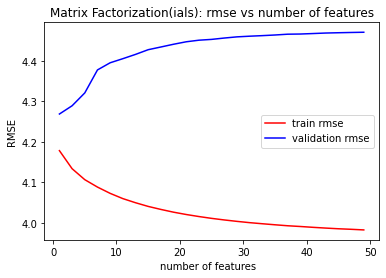

In [76]:
# optimal number of feature = 2
plt.plot(ials_k, ials_train_k, color= 'r' ,label='train rmse' )
plt.plot(ials_k,  ials_val_k, color= 'b',label='validation rmse' )
plt.xlabel('number of features  ')
plt.ylabel('RMSE')
plt.title('Matrix Factorization(ials): rmse vs number of features')
plt.legend()
plt.show()

In [77]:
# hyperparameter tuning for confidence_scaling_factor 
num_scales = np.arange(1,200,2)
def test_scale_vals():
    scale_list = []
    train = []
    val = []
    for loc, scale in enumerate(num_scales):
        model = tc.ranking_factorization_recommender.create(train3,item_id = item_id, target = target,\
                                                                   user_id = user_id, binary_target = False,\
                                                                   solver = 'ials',num_factors = 2,\
                                                                   ials_confidence_scaling_factor = scale)
        rmse_train = tc.recommender.util.compare_models(train3, [model],exclude_known_for_precision_recall=False)
        rmse_train = rmse_train[0]['rmse_overall']
        scale_list.append(scale)
        train.append(rmse_train)
        rmse_val = tc.recommender.util.compare_models(validation, [model], model_names=["m1"], metric='rmse')
        rmse_val = rmse_val[0]['rmse_overall']
        val.append(rmse_val)
    return scale_list,train,val

In [78]:
ials_scale, ials_train_scale, ials_val_scale = test_scale_vals() 

Preparing data set.

Data has 101335 observations with 22098 users and 246 items.

Data prepared in: 0.168537s

Training ranking_factorization_recommender for recommendations.

+------------------------------+--------------------------------------------------+----------+

| Parameter                    | Description                                      | Value    |

+------------------------------+--------------------------------------------------+----------+

| num_factors                  | Factor Dimension                                 | 2        |

| regularization               | L2 Regularization on Factors                     | 1e-09    |

| max_iterations               | Maximum Number of Iterations                     | 25       |

| solver                       | Solver used for training                         | ials     |

+------------------------------+--------------------------------------------------+----------+

+---------+--------------+---------------------------+

| Iter.   | Elapsed time | Estimated Objective Value |

+---------+--------------+---------------------------+

| Initial | 164us        | NA                        |

+---------+--------------+---------------------------+

| 0       | 43.948ms     | 4.33348                   |

| 1       | 79.672ms     | 4.15995                   |

| 2       | 122.764ms    | 4.1554                    |

| 3       | 159.025ms    | 4.1537                    |

| 4       | 195.511ms    | 4.15253                   |

| 5       | 239.69ms     | 4.15178                   |

| 6       | 280.027ms    | 4.15148                   |

| 7       | 319.839ms    | 4.15137                   |

| 8       | 358.037ms    | 4.15127                   |

| 9       | 403.198ms    | 4.15118                   |

| 10      | 456.735ms    | 4.15112                   |

| 11      | 496.67ms     | 4.15111                   |

| 12      | 537.474ms    | 4.15113                   |

| 13      | 575.26ms     | 4.15116                   |

| 14      | 621.087ms    | 4.15118                   |

| 15      | 658.46ms     | 4.15121                   |

| 16      | 699.467ms    | 4.15123                   |

| 17      | 738.621ms    | 4.15126                   |

| 18      | 776.521ms    | 4.15128                   |

| 19      | 825.882ms    | 4.1513                    |

| 20      | 874.873ms    | 4.15131                   |

| 21      | 906.081ms    | 4.15133                   |

| 22      | 943.968ms    | 4.15134                   |

| 23      | 996.663ms    | 4.15136                   |

| 24      | 1.04s        | 4.15137                   |

| FINAL   | 1.04s        | 4.15137                   |

+---------+--------------+---------------------------+

Optimization Complete: Iteration limit reached.

PROGRESS: Evaluate model M0


recommendations finished on 1000/22098 queries. users per second: 38907.5

recommendations finished on 2000/22098 queries. users per second: 50956.7

recommendations finished on 3000/22098 queries. users per second: 53824.2

recommendations finished on 4000/22098 queries. users per second: 58836.5

recommendations finished on 5000/22098 queries. users per second: 60259.1

recommendations finished on 6000/22098 queries. users per second: 56251.9

recommendations finished on 7000/22098 queries. users per second: 55279.6

recommendations finished on 8000/22098 queries. users per second: 56362.6

recommendations finished on 9000/22098 queries. users per second: 58204.2

recommendations finished on 10000/22098 queries. users per second: 59119.1

recommendations finished on 11000/22098 queries. users per second: 59044.6

recommendations finished on 12000/22098 queries. users per second: 57202.5

recommendations finished on 13000/22098 queries. users per second: 56205

recommendations finished on 14000/22098 queries. users per second: 57499.4

recommendations finished on 15000/22098 queries. users per second: 57386.4

recommendations finished on 16000/22098 queries. users per second: 57966.4

recommendations finished on 17000/22098 queries. users per second: 58765.6

recommendations finished on 18000/22098 queries. users per second: 58777.6

recommendations finished on 19000/22098 queries. users per second: 58086.9

recommendations finished on 20000/22098 queries. users per second: 59061.9

recommendations finished on 21000/22098 queries. users per second: 58883.7

recommendations finished on 22000/22098 queries. users per second: 57785.6


Precision and recall summary statistics by cutoff
+--------+---------------------+---------------------+
| cutoff |    mean_precision   |     mean_recall     |
+--------+---------------------+---------------------+
|   1    |  0.491990225359761  | 0.11970036503786279 |
|   2    | 0.47504299031586567 |  0.2300166836901692 |
|   3    | 0.41154553956617546 |  0.2953842363210713 |
|   4    |  0.3764480948502127 | 0.35678617723114014 |
|   5    |  0.3473617521947691 | 0.40826026440771096 |
|   6    | 0.32014209430717716 |  0.4470717796223045 |
|   7    | 0.29641984407121436 |  0.4811856047209092 |
|   8    |  0.2785150239840712 |  0.5150560539952485 |
|   9    | 0.26175320039018135 |  0.5436400456874761 |
|   10   | 0.24625305457507407 |  0.5661402496038563 |
+--------+---------------------+---------------------+
[10 rows x 3 columns]


Overall RMSE: 4.1513713341832705

Per User RMSE (best)
+-----------+-------------------+-------+
|  user_id  |        rmse       | count |
+-----------+---

Preparing data set.

Data has 101335 observations with 22098 users and 246 items.

Data prepared in: 0.126236s

Training ranking_factorization_recommender for recommendations.

+------------------------------+--------------------------------------------------+----------+

| Parameter                    | Description                                      | Value    |

+------------------------------+--------------------------------------------------+----------+

| num_factors                  | Factor Dimension                                 | 2        |

| regularization               | L2 Regularization on Factors                     | 1e-09    |

| max_iterations               | Maximum Number of Iterations                     | 25       |

| solver                       | Solver used for training                         | ials     |

+------------------------------+--------------------------------------------------+----------+

+---------+--------------+---------------------------+

| Iter.   | Elapsed time | Estimated Objective Value |

+---------+--------------+---------------------------+

| Initial | 118us        | NA                        |

+---------+--------------+---------------------------+

| 0       | 46.737ms     | 4.22827                   |

| 1       | 92.944ms     | 4.09771                   |

| 2       | 140.407ms    | 4.09471                   |

| 3       | 177.855ms    | 4.09404                   |

| 4       | 216.053ms    | 4.09381                   |

| 5       | 259.938ms    | 4.09372                   |

| 6       | 301.721ms    | 4.09367                   |

| 7       | 339.445ms    | 4.09362                   |

| 8       | 376.989ms    | 4.09356                   |

| 9       | 413.099ms    | 4.09354                   |

| 10      | 451.653ms    | 4.09355                   |

| 11      | 495.022ms    | 4.09357                   |

| 12      | 533.33ms     | 4.09359                   |

| 13      | 577.978ms    | 4.0936                    |

| 14      | 616.423ms    | 4.09357                   |

| 15      | 680.999ms    | 4.09349                   |

| 16      | 720.618ms    | 4.09338                   |

| 17      | 759.663ms    | 4.09332                   |

| 18      | 806.53ms     | 4.09331                   |

| 19      | 846.249ms    | 4.09331                   |

| 20      | 891.376ms    | 4.0933                    |

| 21      | 928.528ms    | 4.09324                   |

| 22      | 968.491ms    | 4.09312                   |

| 23      | 1.00s        | 4.09304                   |

| 24      | 1.05s        | 4.09299                   |

| FINAL   | 1.05s        | 4.09299                   |

+---------+--------------+---------------------------+

Optimization Complete: Iteration limit reached.

PROGRESS: Evaluate model M0


recommendations finished on 1000/22098 queries. users per second: 48959.6

recommendations finished on 2000/22098 queries. users per second: 52866.7

recommendations finished on 3000/22098 queries. users per second: 51288.2

recommendations finished on 4000/22098 queries. users per second: 52541

recommendations finished on 5000/22098 queries. users per second: 54392.2

recommendations finished on 6000/22098 queries. users per second: 55663.8

recommendations finished on 7000/22098 queries. users per second: 55785.8

recommendations finished on 8000/22098 queries. users per second: 55276.5

recommendations finished on 9000/22098 queries. users per second: 56897.2

recommendations finished on 10000/22098 queries. users per second: 56614.2

recommendations finished on 11000/22098 queries. users per second: 53948

recommendations finished on 12000/22098 queries. users per second: 54800

recommendations finished on 13000/22098 queries. users per second: 54418.4

recommendations finished on 14000/22098 queries. users per second: 54640.8

recommendations finished on 15000/22098 queries. users per second: 55658.4

recommendations finished on 16000/22098 queries. users per second: 55851.1

recommendations finished on 17000/22098 queries. users per second: 56241.1

recommendations finished on 18000/22098 queries. users per second: 56840.8

recommendations finished on 19000/22098 queries. users per second: 57168

recommendations finished on 20000/22098 queries. users per second: 57328.3

recommendations finished on 21000/22098 queries. users per second: 57356.8

recommendations finished on 22000/22098 queries. users per second: 56354.3


Precision and recall summary statistics by cutoff
+--------+---------------------+---------------------+
| cutoff |    mean_precision   |     mean_recall     |
+--------+---------------------+---------------------+
|   1    | 0.48153679065978844 | 0.11877142005603056 |
|   2    |  0.456308263191239  | 0.22478134522105386 |
|   3    |  0.3961897004253782 | 0.29040295757961126 |
|   4    |  0.3529165535342568 | 0.33917622610521836 |
|   5    |  0.3286541768485845 | 0.38937853936769284 |
|   6    | 0.30836123932784215 |  0.4332573721753507 |
|   7    | 0.29023311741204716 | 0.47273283047469644 |
|   8    | 0.27291496968051415 |  0.5062903366236352 |
|   9    |  0.2577206584809072 |  0.5355531596197801 |
|   10   |  0.2455923612996645 |  0.5674664546346738 |
+--------+---------------------+---------------------+
[10 rows x 3 columns]


Overall RMSE: 4.092994425429205

Per User RMSE (best)
+-----------+---------------------+-------+
|  user_id  |         rmse        | count |
+-----------+

Preparing data set.

Data has 101335 observations with 22098 users and 246 items.

Data prepared in: 0.137931s

Training ranking_factorization_recommender for recommendations.

+------------------------------+--------------------------------------------------+----------+

| Parameter                    | Description                                      | Value    |

+------------------------------+--------------------------------------------------+----------+

| num_factors                  | Factor Dimension                                 | 2        |

| regularization               | L2 Regularization on Factors                     | 1e-09    |

| max_iterations               | Maximum Number of Iterations                     | 25       |

| solver                       | Solver used for training                         | ials     |

+------------------------------+--------------------------------------------------+----------+

+---------+--------------+---------------------------+

| Iter.   | Elapsed time | Estimated Objective Value |

+---------+--------------+---------------------------+

| Initial | 105us        | NA                        |

+---------+--------------+---------------------------+

| 0       | 52.985ms     | 4.2995                    |

| 1       | 91.175ms     | 4.09902                   |

| 2       | 169.501ms    | 4.07107                   |

| 3       | 214.1ms      | 4.06765                   |

| 4       | 257.595ms    | 4.06658                   |

| 5       | 295.956ms    | 4.06618                   |

| 6       | 337.101ms    | 4.06603                   |

| 7       | 379.702ms    | 4.06597                   |

| 8       | 422.394ms    | 4.06595                   |

| 9       | 467.365ms    | 4.06592                   |

| 10      | 512.25ms     | 4.06589                   |

| 11      | 551.346ms    | 4.06588                   |

| 12      | 588.054ms    | 4.0659                    |

| 13      | 627.981ms    | 4.06592                   |

| 14      | 667.105ms    | 4.06595                   |

| 15      | 711.52ms     | 4.06597                   |

| 16      | 750.417ms    | 4.06599                   |

| 17      | 793.492ms    | 4.06601                   |

| 18      | 833.858ms    | 4.06602                   |

| 19      | 872.872ms    | 4.06604                   |

| 20      | 914.948ms    | 4.06605                   |

| 21      | 954.304ms    | 4.06607                   |

| 22      | 992.754ms    | 4.06608                   |

| 23      | 1.03s        | 4.06609                   |

| 24      | 1.08s        | 4.0661                    |

| FINAL   | 1.08s        | 4.0661                    |

+---------+--------------+---------------------------+

Optimization Complete: Iteration limit reached.

PROGRESS: Evaluate model M0


recommendations finished on 1000/22098 queries. users per second: 39472.6

recommendations finished on 2000/22098 queries. users per second: 45720.6

recommendations finished on 3000/22098 queries. users per second: 42803.9

recommendations finished on 4000/22098 queries. users per second: 45225.3

recommendations finished on 5000/22098 queries. users per second: 47815.8

recommendations finished on 6000/22098 queries. users per second: 45916.1

recommendations finished on 7000/22098 queries. users per second: 46475.8

recommendations finished on 8000/22098 queries. users per second: 48418.2

recommendations finished on 9000/22098 queries. users per second: 47731.4

recommendations finished on 10000/22098 queries. users per second: 48581.2

recommendations finished on 11000/22098 queries. users per second: 49149.3

recommendations finished on 12000/22098 queries. users per second: 48093.1

recommendations finished on 13000/22098 queries. users per second: 48075.3

recommendations finished on 14000/22098 queries. users per second: 48441.9

recommendations finished on 15000/22098 queries. users per second: 49385.3

recommendations finished on 16000/22098 queries. users per second: 49396.3

recommendations finished on 17000/22098 queries. users per second: 50133.6

recommendations finished on 18000/22098 queries. users per second: 50323.3

recommendations finished on 19000/22098 queries. users per second: 49633.4

recommendations finished on 20000/22098 queries. users per second: 50220.7

recommendations finished on 21000/22098 queries. users per second: 49127.5

recommendations finished on 22000/22098 queries. users per second: 48788.9


Precision and recall summary statistics by cutoff
+--------+---------------------+---------------------+
| cutoff |    mean_precision   |     mean_recall     |
+--------+---------------------+---------------------+
|   1    |  0.4521676169789123 | 0.11154602119188242 |
|   2    | 0.43279934835731765 |  0.2113487898472863 |
|   3    |  0.3758711195583313 | 0.27327992121587297 |
|   4    | 0.34198796271155796 | 0.32729067742138673 |
|   5    |  0.3195311792922441 |  0.3789488254775979 |
|   6    |  0.3028102090686932 | 0.42692059720184844 |
|   7    | 0.28564963862275855 |  0.4657347455771452 |
|   8    | 0.26836139017105554 |  0.4978727042801869 |
|   9    |  0.2541909272835144 |  0.5278326899488285 |
|   10   | 0.24206715539867865 |  0.5578599519008123 |
+--------+---------------------+---------------------+
[10 rows x 3 columns]


Overall RMSE: 4.066098886038306

Per User RMSE (best)
+-----------+--------------------+-------+
|  user_id  |        rmse        | count |
+-----------+--

Preparing data set.

Data has 101335 observations with 22098 users and 246 items.

Data prepared in: 0.162458s

Training ranking_factorization_recommender for recommendations.

+------------------------------+--------------------------------------------------+----------+

| Parameter                    | Description                                      | Value    |

+------------------------------+--------------------------------------------------+----------+

| num_factors                  | Factor Dimension                                 | 2        |

| regularization               | L2 Regularization on Factors                     | 1e-09    |

| max_iterations               | Maximum Number of Iterations                     | 25       |

| solver                       | Solver used for training                         | ials     |

+------------------------------+--------------------------------------------------+----------+

+---------+--------------+---------------------------+

| Iter.   | Elapsed time | Estimated Objective Value |

+---------+--------------+---------------------------+

| Initial | 102us        | NA                        |

+---------+--------------+---------------------------+

| 0       | 65.806ms     | 4.21019                   |

| 1       | 113.944ms    | 4.05655                   |

| 2       | 151.544ms    | 4.05219                   |

| 3       | 193.312ms    | 4.05142                   |

| 4       | 236.9ms      | 4.05099                   |

| 5       | 276.44ms     | 4.05054                   |

| 6       | 319.977ms    | 4.04996                   |

| 7       | 359.71ms     | 4.04949                   |

| 8       | 426.407ms    | 4.04936                   |

| 9       | 473.243ms    | 4.0493                    |

| 10      | 516.922ms    | 4.0493                    |

| 11      | 555.003ms    | 4.04933                   |

| 12      | 595.967ms    | 4.04936                   |

| 13      | 635.318ms    | 4.04939                   |

| 14      | 675.121ms    | 4.04942                   |

| 15      | 712.432ms    | 4.04944                   |

| 16      | 756.571ms    | 4.04946                   |

| 17      | 796.63ms     | 4.04948                   |

| 18      | 846.943ms    | 4.0495                    |

| 19      | 883.079ms    | 4.04951                   |

| 20      | 921.06ms     | 4.04952                   |

| 21      | 972.826ms    | 4.04953                   |

| 22      | 1.01s        | 4.04954                   |

| 23      | 1.06s        | 4.04955                   |

| 24      | 1.10s        | 4.04956                   |

| FINAL   | 1.10s        | 4.04956                   |

+---------+--------------+---------------------------+

Optimization Complete: Iteration limit reached.

PROGRESS: Evaluate model M0


recommendations finished on 1000/22098 queries. users per second: 51054.3

recommendations finished on 2000/22098 queries. users per second: 58198.7

recommendations finished on 3000/22098 queries. users per second: 59375.4

recommendations finished on 4000/22098 queries. users per second: 56292.8

recommendations finished on 5000/22098 queries. users per second: 54312.4

recommendations finished on 6000/22098 queries. users per second: 53936.9

recommendations finished on 7000/22098 queries. users per second: 55310.6

recommendations finished on 8000/22098 queries. users per second: 57327.9

recommendations finished on 9000/22098 queries. users per second: 56604.8

recommendations finished on 10000/22098 queries. users per second: 57384.5

recommendations finished on 11000/22098 queries. users per second: 56589.6

recommendations finished on 12000/22098 queries. users per second: 56173.7

recommendations finished on 13000/22098 queries. users per second: 56738.6

recommendations finished on 14000/22098 queries. users per second: 56921.4

recommendations finished on 15000/22098 queries. users per second: 57461.4

recommendations finished on 16000/22098 queries. users per second: 57743.8

recommendations finished on 17000/22098 queries. users per second: 58296.6

recommendations finished on 18000/22098 queries. users per second: 58229.8

recommendations finished on 19000/22098 queries. users per second: 58833.7

recommendations finished on 20000/22098 queries. users per second: 59123.8

recommendations finished on 21000/22098 queries. users per second: 59521.4

recommendations finished on 22000/22098 queries. users per second: 58195.5


Precision and recall summary statistics by cutoff
+--------+---------------------+---------------------+
| cutoff |    mean_precision   |     mean_recall     |
+--------+---------------------+---------------------+
|   1    | 0.44094488188976394 | 0.10756174327049951 |
|   2    |  0.4190424472802969 | 0.20299960975477868 |
|   3    |  0.3634114701179597 |  0.2616268074869949 |
|   4    | 0.32947551814643816 |  0.3140770787865535 |
|   5    | 0.31005520861616226 |  0.3652176324186878 |
|   6    |  0.2951247473376173 |  0.4146724342867926 |
|   7    |  0.2769804636489394 | 0.44924218476106426 |
|   8    | 0.26132455425830375 | 0.48337994038102294 |
|   9    |  0.2474985167083996 |  0.5141824150864142 |
|   10   |  0.2369264186804238 |  0.5453347480360983 |
+--------+---------------------+---------------------+
[10 rows x 3 columns]


Overall RMSE: 4.049556403601159

Per User RMSE (best)
+-----------+---------------------+-------+
|  user_id  |         rmse        | count |
+-----------+

Preparing data set.

Data has 101335 observations with 22098 users and 246 items.

Data prepared in: 0.128903s

Training ranking_factorization_recommender for recommendations.

+------------------------------+--------------------------------------------------+----------+

| Parameter                    | Description                                      | Value    |

+------------------------------+--------------------------------------------------+----------+

| num_factors                  | Factor Dimension                                 | 2        |

| regularization               | L2 Regularization on Factors                     | 1e-09    |

| max_iterations               | Maximum Number of Iterations                     | 25       |

| solver                       | Solver used for training                         | ials     |

+------------------------------+--------------------------------------------------+----------+

+---------+--------------+---------------------------+

| Iter.   | Elapsed time | Estimated Objective Value |

+---------+--------------+---------------------------+

| Initial | 174us        | NA                        |

+---------+--------------+---------------------------+

| 0       | 55.218ms     | 4.18868                   |

| 1       | 103.453ms    | 4.04557                   |

| 2       | 141.378ms    | 4.04116                   |

| 3       | 184.686ms    | 4.03988                   |

| 4       | 226.092ms    | 4.03922                   |

| 5       | 263.083ms    | 4.03871                   |

| 6       | 305.858ms    | 4.03829                   |

| 7       | 344.653ms    | 4.03818                   |

| 8       | 380.03ms     | 4.03817                   |

| 9       | 421.744ms    | 4.03817                   |

| 10      | 466.8ms      | 4.03818                   |

| 11      | 517.052ms    | 4.03819                   |

| 12      | 560.649ms    | 4.0382                    |

| 13      | 607.489ms    | 4.03822                   |

| 14      | 649.638ms    | 4.03824                   |

| 15      | 693.707ms    | 4.03824                   |

| 16      | 736.38ms     | 4.03821                   |

| 17      | 787.104ms    | 4.03814                   |

| 18      | 832.941ms    | 4.03812                   |

| 19      | 880.314ms    | 4.03813                   |

| 20      | 922.688ms    | 4.03815                   |

| 21      | 964.459ms    | 4.03817                   |

| 22      | 1.01s        | 4.03818                   |

| 23      | 1.05s        | 4.0382                    |

| 24      | 1.09s        | 4.03821                   |

| FINAL   | 1.09s        | 4.03821                   |

+---------+--------------+---------------------------+

Optimization Complete: Iteration limit reached.

PROGRESS: Evaluate model M0


recommendations finished on 1000/22098 queries. users per second: 23190.6

recommendations finished on 2000/22098 queries. users per second: 30046.7

recommendations finished on 3000/22098 queries. users per second: 33805.1

recommendations finished on 4000/22098 queries. users per second: 34478.3

recommendations finished on 5000/22098 queries. users per second: 36812.6

recommendations finished on 6000/22098 queries. users per second: 37861.3

recommendations finished on 7000/22098 queries. users per second: 38330.5

recommendations finished on 8000/22098 queries. users per second: 39666.8

recommendations finished on 9000/22098 queries. users per second: 40005.9

recommendations finished on 10000/22098 queries. users per second: 40511.3

recommendations finished on 11000/22098 queries. users per second: 41726.9

recommendations finished on 12000/22098 queries. users per second: 42122.6

recommendations finished on 13000/22098 queries. users per second: 43142.6

recommendations finished on 14000/22098 queries. users per second: 43967.9

recommendations finished on 15000/22098 queries. users per second: 44983.7

recommendations finished on 16000/22098 queries. users per second: 44952.2

recommendations finished on 17000/22098 queries. users per second: 45885.3

recommendations finished on 18000/22098 queries. users per second: 46608.8

recommendations finished on 19000/22098 queries. users per second: 47488.6

recommendations finished on 20000/22098 queries. users per second: 47642.3

recommendations finished on 21000/22098 queries. users per second: 48125.3

recommendations finished on 22000/22098 queries. users per second: 48032


Precision and recall summary statistics by cutoff
+--------+---------------------+---------------------+
| cutoff |    mean_precision   |     mean_recall     |
+--------+---------------------+---------------------+
|   1    |  0.4327088424291791 | 0.10615678509828895 |
|   2    |  0.4185899176396051 |  0.203152355463446  |
|   3    |  0.3574079102181195 |  0.2576363979038735 |
|   4    |  0.3261946782514258 | 0.30891427072097283 |
|   5    | 0.30759344737080235 | 0.36179698327829934 |
|   6    |  0.2931713277219649 |  0.4116754168245947 |
|   7    |  0.2761335867499327 | 0.44804703817363356 |
|   8    |  0.2602611096026795 | 0.48167777487545277 |
|   9    |  0.2468096660331262 |  0.5121836826518712 |
|   10   | 0.23687664041994805 |  0.5455546796232438 |
+--------+---------------------+---------------------+
[10 rows x 3 columns]


Overall RMSE: 4.038206165639317

Per User RMSE (best)
+-----------+---------------------+-------+
|  user_id  |         rmse        | count |
+-----------+

Preparing data set.

Data has 101335 observations with 22098 users and 246 items.

Data prepared in: 0.14272s

Training ranking_factorization_recommender for recommendations.

+------------------------------+--------------------------------------------------+----------+

| Parameter                    | Description                                      | Value    |

+------------------------------+--------------------------------------------------+----------+

| num_factors                  | Factor Dimension                                 | 2        |

| regularization               | L2 Regularization on Factors                     | 1e-09    |

| max_iterations               | Maximum Number of Iterations                     | 25       |

| solver                       | Solver used for training                         | ials     |

+------------------------------+--------------------------------------------------+----------+

+---------+--------------+---------------------------+

| Iter.   | Elapsed time | Estimated Objective Value |

+---------+--------------+---------------------------+

| Initial | 152us        | NA                        |

+---------+--------------+---------------------------+

| 0       | 45.122ms     | 4.17815                   |

| 1       | 81.825ms     | 4.03784                   |

| 2       | 121.491ms    | 4.03259                   |

| 3       | 163.126ms    | 4.03059                   |

| 4       | 206.271ms    | 4.02994                   |

| 5       | 259.24ms     | 4.02965                   |

| 6       | 300.852ms    | 4.02961                   |

| 7       | 339.117ms    | 4.02961                   |

| 8       | 380.581ms    | 4.02959                   |

| 9       | 422.686ms    | 4.02955                   |

| 10      | 467.855ms    | 4.02954                   |

| 11      | 515.936ms    | 4.02956                   |

| 12      | 569.37ms     | 4.02959                   |

| 13      | 623.834ms    | 4.02962                   |

| 14      | 674.301ms    | 4.02965                   |

| 15      | 728.656ms    | 4.02969                   |

| 16      | 778.736ms    | 4.02971                   |

| 17      | 821.104ms    | 4.02974                   |

| 18      | 882.302ms    | 4.02977                   |

| 19      | 937.566ms    | 4.02979                   |

| 20      | 993.127ms    | 4.02981                   |

| 21      | 1.03s        | 4.02983                   |

| 22      | 1.10s        | 4.02984                   |

| 23      | 1.14s        | 4.02985                   |

| 24      | 1.19s        | 4.02986                   |

| FINAL   | 1.19s        | 4.02986                   |

+---------+--------------+---------------------------+

Optimization Complete: Iteration limit reached.

PROGRESS: Evaluate model M0


recommendations finished on 1000/22098 queries. users per second: 39477.3

recommendations finished on 2000/22098 queries. users per second: 43576.8

recommendations finished on 3000/22098 queries. users per second: 46674.4

recommendations finished on 4000/22098 queries. users per second: 49323.6

recommendations finished on 5000/22098 queries. users per second: 51764.1

recommendations finished on 6000/22098 queries. users per second: 51171.8

recommendations finished on 7000/22098 queries. users per second: 51575.3

recommendations finished on 8000/22098 queries. users per second: 52842.6

recommendations finished on 9000/22098 queries. users per second: 52037.6

recommendations finished on 10000/22098 queries. users per second: 52561.6

recommendations finished on 11000/22098 queries. users per second: 53178.6

recommendations finished on 12000/22098 queries. users per second: 51761.8

recommendations finished on 13000/22098 queries. users per second: 52528.2

recommendations finished on 14000/22098 queries. users per second: 53021.9

recommendations finished on 15000/22098 queries. users per second: 53612.8

recommendations finished on 16000/22098 queries. users per second: 53987.3

recommendations finished on 17000/22098 queries. users per second: 54312.8

recommendations finished on 18000/22098 queries. users per second: 54202.2

recommendations finished on 19000/22098 queries. users per second: 53954.1

recommendations finished on 20000/22098 queries. users per second: 54475.7

recommendations finished on 21000/22098 queries. users per second: 54729.1

recommendations finished on 22000/22098 queries. users per second: 54047


Precision and recall summary statistics by cutoff
+--------+---------------------+---------------------+
| cutoff |    mean_precision   |     mean_recall     |
+--------+---------------------+---------------------+
|   1    | 0.42822879898633354 | 0.10289650369481218 |
|   2    | 0.41453977735541686 | 0.20104565732739382 |
|   3    |  0.354119528162427  |  0.2545667225320073 |
|   4    | 0.32304959724861976 |  0.306676626678375  |
|   5    |  0.3046972576703759 |  0.3574093954360476 |
|   6    | 0.28906839231303094 |  0.404081185776787  |
|   7    |  0.2713238431402969 |  0.4402091184753261 |
|   8    |  0.256335414969681  | 0.47437413381858506 |
|   9    | 0.24279220844520868 |  0.5040844305020523 |
|   10   | 0.23248257760883426 |  0.5351396727493923 |
+--------+---------------------+---------------------+
[10 rows x 3 columns]


Overall RMSE: 4.029861119181907

Per User RMSE (best)
+-----------+---------------------+-------+
|  user_id  |         rmse        | count |
+-----------+

Preparing data set.

Data has 101335 observations with 22098 users and 246 items.

Data prepared in: 0.148093s

Training ranking_factorization_recommender for recommendations.

+------------------------------+--------------------------------------------------+----------+

| Parameter                    | Description                                      | Value    |

+------------------------------+--------------------------------------------------+----------+

| num_factors                  | Factor Dimension                                 | 2        |

| regularization               | L2 Regularization on Factors                     | 1e-09    |

| max_iterations               | Maximum Number of Iterations                     | 25       |

| solver                       | Solver used for training                         | ials     |

+------------------------------+--------------------------------------------------+----------+

+---------+--------------+---------------------------+

| Iter.   | Elapsed time | Estimated Objective Value |

+---------+--------------+---------------------------+

| Initial | 106us        | NA                        |

+---------+--------------+---------------------------+

| 0       | 58.569ms     | 4.16084                   |

| 1       | 100.261ms    | 4.02983                   |

| 2       | 150.791ms    | 4.02481                   |

| 3       | 232.933ms    | 4.02358                   |

| 4       | 286.651ms    | 4.02303                   |

| 5       | 329.647ms    | 4.02287                   |

| 6       | 369.734ms    | 4.02285                   |

| 7       | 421.405ms    | 4.02289                   |

| 8       | 460.73ms     | 4.02294                   |

| 9       | 504.274ms    | 4.02299                   |

| 10      | 556.401ms    | 4.02299                   |

| 11      | 608.73ms     | 4.02295                   |

| 12      | 659.389ms    | 4.0229                    |

| 13      | 704.331ms    | 4.02289                   |

| 14      | 746.334ms    | 4.02292                   |

| 15      | 793.581ms    | 4.02296                   |

| 16      | 842.308ms    | 4.02299                   |

| 17      | 897.662ms    | 4.02303                   |

| 18      | 943.144ms    | 4.02306                   |

| 19      | 982.996ms    | 4.02308                   |

| 20      | 1.02s        | 4.02311                   |

| 21      | 1.08s        | 4.02314                   |

| 22      | 1.13s        | 4.02316                   |

| 23      | 1.17s        | 4.02318                   |

| 24      | 1.22s        | 4.0232                    |

| FINAL   | 1.22s        | 4.0232                    |

+---------+--------------+---------------------------+

Optimization Complete: Iteration limit reached.

PROGRESS: Evaluate model M0


recommendations finished on 1000/22098 queries. users per second: 38981.8

recommendations finished on 2000/22098 queries. users per second: 45459.7

recommendations finished on 3000/22098 queries. users per second: 47412.1

recommendations finished on 4000/22098 queries. users per second: 49158.2

recommendations finished on 5000/22098 queries. users per second: 50722.3

recommendations finished on 6000/22098 queries. users per second: 50778.2

recommendations finished on 7000/22098 queries. users per second: 52065.5

recommendations finished on 8000/22098 queries. users per second: 53428.1

recommendations finished on 9000/22098 queries. users per second: 54537.5

recommendations finished on 10000/22098 queries. users per second: 53730.5

recommendations finished on 11000/22098 queries. users per second: 54582.4

recommendations finished on 12000/22098 queries. users per second: 53090.5

recommendations finished on 13000/22098 queries. users per second: 53432.6

recommendations finished on 14000/22098 queries. users per second: 54205.2

recommendations finished on 15000/22098 queries. users per second: 53395.8

recommendations finished on 16000/22098 queries. users per second: 54078.2

recommendations finished on 17000/22098 queries. users per second: 52444.9

recommendations finished on 18000/22098 queries. users per second: 51811.8

recommendations finished on 19000/22098 queries. users per second: 50092.1

recommendations finished on 20000/22098 queries. users per second: 50243.3

recommendations finished on 21000/22098 queries. users per second: 50294.8

recommendations finished on 22000/22098 queries. users per second: 48974.2


Precision and recall summary statistics by cutoff
+--------+---------------------+---------------------+
| cutoff |    mean_precision   |     mean_recall     |
+--------+---------------------+---------------------+
|   1    |  0.4195854828491269 | 0.10497747534777073 |
|   2    | 0.40311340392795697 | 0.19475988593282714 |
|   3    | 0.35229432527830445 |  0.2551295315058308 |
|   4    | 0.32694135215856557 |  0.3119154225400824 |
|   5    |  0.3044166892931492 | 0.35829394036813234 |
|   6    | 0.28998099375508996 |  0.4066902369071824 |
|   7    | 0.27696106952148225 |  0.4526505619709996 |
|   8    |  0.2634514435695541 |  0.490563842936688  |
|   9    | 0.24948461902032157 |  0.5200556484642224 |
|   10   | 0.23723413883609382 |  0.5462590409575158 |
+--------+---------------------+---------------------+
[10 rows x 3 columns]


Overall RMSE: 4.023203839839129

Per User RMSE (best)
+-----------+---------------------+-------+
|  user_id  |         rmse        | count |
+-----------+

Preparing data set.

Data has 101335 observations with 22098 users and 246 items.

Data prepared in: 0.150036s

Training ranking_factorization_recommender for recommendations.

+------------------------------+--------------------------------------------------+----------+

| Parameter                    | Description                                      | Value    |

+------------------------------+--------------------------------------------------+----------+

| num_factors                  | Factor Dimension                                 | 2        |

| regularization               | L2 Regularization on Factors                     | 1e-09    |

| max_iterations               | Maximum Number of Iterations                     | 25       |

| solver                       | Solver used for training                         | ials     |

+------------------------------+--------------------------------------------------+----------+

+---------+--------------+---------------------------+

| Iter.   | Elapsed time | Estimated Objective Value |

+---------+--------------+---------------------------+

| Initial | 103us        | NA                        |

+---------+--------------+---------------------------+

| 0       | 57.414ms     | 4.29012                   |

| 1       | 98.754ms     | 4.09756                   |

| 2       | 136ms        | 4.03236                   |

| 3       | 176.665ms    | 4.02268                   |

| 4       | 222.033ms    | 4.02136                   |

| 5       | 255.815ms    | 4.02077                   |

| 6       | 300.623ms    | 4.02041                   |

| 7       | 345.1ms      | 4.02014                   |

| 8       | 391.868ms    | 4.02001                   |

| 9       | 431.767ms    | 4.01998                   |

| 10      | 471.541ms    | 4.01998                   |

| 11      | 510.278ms    | 4.01998                   |

| 12      | 551.413ms    | 4.01996                   |

| 13      | 597.024ms    | 4.01987                   |

| 14      | 643.637ms    | 4.01958                   |

| 15      | 691.966ms    | 4.019                     |

| 16      | 737.535ms    | 4.01824                   |

| 17      | 780.153ms    | 4.01784                   |

| 18      | 828.562ms    | 4.01781                   |

| 19      | 866.665ms    | 4.01783                   |

| 20      | 906.917ms    | 4.01785                   |

| 21      | 949.298ms    | 4.01788                   |

| 22      | 987.807ms    | 4.0179                    |

| 23      | 1.03s        | 4.01792                   |

| 24      | 1.08s        | 4.01794                   |

| FINAL   | 1.08s        | 4.01794                   |

+---------+--------------+---------------------------+

Optimization Complete: Iteration limit reached.

PROGRESS: Evaluate model M0


recommendations finished on 1000/22098 queries. users per second: 36119.3

recommendations finished on 2000/22098 queries. users per second: 42576.7

recommendations finished on 3000/22098 queries. users per second: 43849.4

recommendations finished on 4000/22098 queries. users per second: 42441.2

recommendations finished on 5000/22098 queries. users per second: 45210.8

recommendations finished on 6000/22098 queries. users per second: 45160.3

recommendations finished on 7000/22098 queries. users per second: 44524.2

recommendations finished on 8000/22098 queries. users per second: 44914.3

recommendations finished on 9000/22098 queries. users per second: 46491.9

recommendations finished on 10000/22098 queries. users per second: 46692.1

recommendations finished on 11000/22098 queries. users per second: 46886.5

recommendations finished on 12000/22098 queries. users per second: 45941.1

recommendations finished on 13000/22098 queries. users per second: 47516.7

recommendations finished on 14000/22098 queries. users per second: 48508.4

recommendations finished on 15000/22098 queries. users per second: 49044.6

recommendations finished on 16000/22098 queries. users per second: 50015.6

recommendations finished on 17000/22098 queries. users per second: 50764.3

recommendations finished on 18000/22098 queries. users per second: 51545.1

recommendations finished on 19000/22098 queries. users per second: 51496.8

recommendations finished on 20000/22098 queries. users per second: 52064.6

recommendations finished on 21000/22098 queries. users per second: 52641.3

recommendations finished on 22000/22098 queries. users per second: 52223.3


Precision and recall summary statistics by cutoff
+--------+---------------------+---------------------+
| cutoff |    mean_precision   |     mean_recall     |
+--------+---------------------+---------------------+
|   1    |  0.4218481310525838 | 0.10135137529987161 |
|   2    | 0.40987872205629516 |  0.1984612570360523 |
|   3    |  0.3441487917458599 | 0.24628224512258237 |
|   4    |  0.3184451081545838 | 0.30155211976961477 |
|   5    |  0.301538600778351  |  0.3538858226212654 |
|   6    |  0.2864361782363425 | 0.40044145933543973 |
|   7    | 0.26747734119441896 | 0.43339208848529254 |
|   8    | 0.25308285817721055 | 0.46823333057405364 |
|   9    | 0.24037368892106892 |  0.4989353676949289 |
|   10   | 0.23063625667481233 |  0.531729830934237  |
+--------+---------------------+---------------------+
[10 rows x 3 columns]


Overall RMSE: 4.017940685863255

Per User RMSE (best)
+-----------+---------------------+-------+
|  user_id  |         rmse        | count |
+-----------+

Preparing data set.

Data has 101335 observations with 22098 users and 246 items.

Data prepared in: 0.19956s

Training ranking_factorization_recommender for recommendations.

+------------------------------+--------------------------------------------------+----------+

| Parameter                    | Description                                      | Value    |

+------------------------------+--------------------------------------------------+----------+

| num_factors                  | Factor Dimension                                 | 2        |

| regularization               | L2 Regularization on Factors                     | 1e-09    |

| max_iterations               | Maximum Number of Iterations                     | 25       |

| solver                       | Solver used for training                         | ials     |

+------------------------------+--------------------------------------------------+----------+

+---------+--------------+---------------------------+

| Iter.   | Elapsed time | Estimated Objective Value |

+---------+--------------+---------------------------+

| Initial | 634us        | NA                        |

+---------+--------------+---------------------------+

| 0       | 60.228ms     | 4.19322                   |

| 1       | 105.628ms    | 4.02327                   |

| 2       | 149.497ms    | 4.01843                   |

| 3       | 192.868ms    | 4.01717                   |

| 4       | 236.651ms    | 4.01648                   |

| 5       | 280.518ms    | 4.0161                    |

| 6       | 320.885ms    | 4.01586                   |

| 7       | 364.647ms    | 4.01571                   |

| 8       | 409.214ms    | 4.01562                   |

| 9       | 457.85ms     | 4.01557                   |

| 10      | 503.104ms    | 4.01557                   |

| 11      | 545.072ms    | 4.01559                   |

| 12      | 584.17ms     | 4.01561                   |

| 13      | 627.513ms    | 4.01562                   |

| 14      | 679.833ms    | 4.01562                   |

| 15      | 721.249ms    | 4.01561                   |

| 16      | 763.526ms    | 4.01558                   |

| 17      | 819.06ms     | 4.01555                   |

| 18      | 865.312ms    | 4.01553                   |

| 19      | 927.318ms    | 4.01552                   |

| 20      | 978.477ms    | 4.01552                   |

| 21      | 1.02s        | 4.01551                   |

| 22      | 1.07s        | 4.01547                   |

| 23      | 1.11s        | 4.01534                   |

| 24      | 1.16s        | 4.01517                   |

| FINAL   | 1.16s        | 4.01517                   |

+---------+--------------+---------------------------+

Optimization Complete: Iteration limit reached.

PROGRESS: Evaluate model M0


recommendations finished on 1000/22098 queries. users per second: 39782

recommendations finished on 2000/22098 queries. users per second: 48673.6

recommendations finished on 3000/22098 queries. users per second: 50000.8

recommendations finished on 4000/22098 queries. users per second: 51911

recommendations finished on 5000/22098 queries. users per second: 51382.7

recommendations finished on 6000/22098 queries. users per second: 51853.8

recommendations finished on 7000/22098 queries. users per second: 53433.1

recommendations finished on 8000/22098 queries. users per second: 54346

recommendations finished on 9000/22098 queries. users per second: 56232.8

recommendations finished on 10000/22098 queries. users per second: 56878

recommendations finished on 11000/22098 queries. users per second: 57889.3

recommendations finished on 12000/22098 queries. users per second: 57846.7

recommendations finished on 13000/22098 queries. users per second: 56358.8

recommendations finished on 14000/22098 queries. users per second: 57263.7

recommendations finished on 15000/22098 queries. users per second: 57142.4

recommendations finished on 16000/22098 queries. users per second: 58392.9

recommendations finished on 17000/22098 queries. users per second: 57961.1

recommendations finished on 18000/22098 queries. users per second: 58207

recommendations finished on 19000/22098 queries. users per second: 57817.2

recommendations finished on 20000/22098 queries. users per second: 57587.8

recommendations finished on 21000/22098 queries. users per second: 58255.2

recommendations finished on 22000/22098 queries. users per second: 56475.3


Precision and recall summary statistics by cutoff
+--------+---------------------+---------------------+
| cutoff |    mean_precision   |     mean_recall     |
+--------+---------------------+---------------------+
|   1    | 0.42877183455516354 | 0.10294661552722237 |
|   2    |  0.413227441397412  | 0.19800055253843815 |
|   3    |  0.3488852686517629 | 0.24941863660263622 |
|   4    |  0.3190107702054491 | 0.30133824376820506 |
|   5    |  0.3009593628382651 | 0.35335097378190566 |
|   6    |  0.284686396959001  | 0.39800781779110167 |
|   7    | 0.26524701653672644 | 0.42957968099415866 |
|   8    |  0.2503337406100103 |  0.4627354621034501 |
|   9    |  0.2363662875473899 |  0.4892876100599501 |
|   10   | 0.22610643497149044 |  0.5199603350602393 |
+--------+---------------------+---------------------+
[10 rows x 3 columns]


Overall RMSE: 4.015173898434691

Per User RMSE (best)
+-----------+---------------------+-------+
|  user_id  |         rmse        | count |
+-----------+

Preparing data set.

Data has 101335 observations with 22098 users and 246 items.

Data prepared in: 0.15971s

Training ranking_factorization_recommender for recommendations.

+------------------------------+--------------------------------------------------+----------+

| Parameter                    | Description                                      | Value    |

+------------------------------+--------------------------------------------------+----------+

| num_factors                  | Factor Dimension                                 | 2        |

| regularization               | L2 Regularization on Factors                     | 1e-09    |

| max_iterations               | Maximum Number of Iterations                     | 25       |

| solver                       | Solver used for training                         | ials     |

+------------------------------+--------------------------------------------------+----------+

+---------+--------------+---------------------------+

| Iter.   | Elapsed time | Estimated Objective Value |

+---------+--------------+---------------------------+

| Initial | 159us        | NA                        |

+---------+--------------+---------------------------+

| 0       | 67.972ms     | 4.19603                   |

| 1       | 181.787ms    | 4.05097                   |

| 2       | 229.633ms    | 4.01638                   |

| 3       | 284.216ms    | 4.01324                   |

| 4       | 331.42ms     | 4.01139                   |

| 5       | 389.472ms    | 4.01045                   |

| 6       | 435.106ms    | 4.01001                   |

| 7       | 485.538ms    | 4.00985                   |

| 8       | 539.702ms    | 4.00986                   |

| 9       | 594.301ms    | 4.00991                   |

| 10      | 648.214ms    | 4.00996                   |

| 11      | 699.507ms    | 4.01001                   |

| 12      | 761.846ms    | 4.01006                   |

| 13      | 814.956ms    | 4.01009                   |

| 14      | 868.427ms    | 4.01008                   |

| 15      | 913.088ms    | 4.01007                   |

| 16      | 958.531ms    | 4.01009                   |

| 17      | 1.01s        | 4.01012                   |

| 18      | 1.06s        | 4.01015                   |

| 19      | 1.10s        | 4.01018                   |

| 20      | 1.14s        | 4.01021                   |

| 21      | 1.19s        | 4.01024                   |

| 22      | 1.25s        | 4.01026                   |

| 23      | 1.29s        | 4.01029                   |

| 24      | 1.33s        | 4.01031                   |

| FINAL   | 1.33s        | 4.01031                   |

+---------+--------------+---------------------------+

Optimization Complete: Iteration limit reached.

PROGRESS: Evaluate model M0


recommendations finished on 1000/22098 queries. users per second: 37808.6

recommendations finished on 2000/22098 queries. users per second: 43811.6

recommendations finished on 3000/22098 queries. users per second: 43224.6

recommendations finished on 4000/22098 queries. users per second: 43222.2

recommendations finished on 5000/22098 queries. users per second: 44561.7

recommendations finished on 6000/22098 queries. users per second: 45556

recommendations finished on 7000/22098 queries. users per second: 42591.8

recommendations finished on 8000/22098 queries. users per second: 42025.9

recommendations finished on 9000/22098 queries. users per second: 42276.3

recommendations finished on 10000/22098 queries. users per second: 41859.9

recommendations finished on 11000/22098 queries. users per second: 40361.3

recommendations finished on 12000/22098 queries. users per second: 41010.9

recommendations finished on 13000/22098 queries. users per second: 39329.6

recommendations finished on 14000/22098 queries. users per second: 39978.6

recommendations finished on 15000/22098 queries. users per second: 40766.3

recommendations finished on 16000/22098 queries. users per second: 41121.6

recommendations finished on 17000/22098 queries. users per second: 41174.5

recommendations finished on 18000/22098 queries. users per second: 41136.7

recommendations finished on 19000/22098 queries. users per second: 41199.6

recommendations finished on 20000/22098 queries. users per second: 41472.2

recommendations finished on 21000/22098 queries. users per second: 42025.2

recommendations finished on 22000/22098 queries. users per second: 41336.4


Precision and recall summary statistics by cutoff
+--------+---------------------+---------------------+
| cutoff |    mean_precision   |     mean_recall     |
+--------+---------------------+---------------------+
|   1    | 0.40763870033487176 | 0.09891932804986536 |
|   2    |  0.3956466648565481 | 0.19093407563850864 |
|   3    | 0.34511418831266716 | 0.24827569476491257 |
|   4    | 0.32102452710652607 |  0.3052552906422527 |
|   5    |  0.2998913928862336 |  0.3536164810108575 |
|   6    |  0.286194829094639  | 0.40153806891677507 |
|   7    |  0.2727719379905102 |  0.4457699367046983 |
|   8    | 0.25938433342383965 | 0.48222050041035386 |
|   9    | 0.24625154614293887 |  0.5123536467309131 |
|   10   | 0.23495338944700905 |  0.5417408723362013 |
+--------+---------------------+---------------------+
[10 rows x 3 columns]


Overall RMSE: 4.0103084269886375

Per User RMSE (best)
+-----------+--------------------+-------+
|  user_id  |        rmse        | count |
+-----------+-

Preparing data set.

Data has 101335 observations with 22098 users and 246 items.

Data prepared in: 0.173552s

Training ranking_factorization_recommender for recommendations.

+------------------------------+--------------------------------------------------+----------+

| Parameter                    | Description                                      | Value    |

+------------------------------+--------------------------------------------------+----------+

| num_factors                  | Factor Dimension                                 | 2        |

| regularization               | L2 Regularization on Factors                     | 1e-09    |

| max_iterations               | Maximum Number of Iterations                     | 25       |

| solver                       | Solver used for training                         | ials     |

+------------------------------+--------------------------------------------------+----------+

+---------+--------------+---------------------------+

| Iter.   | Elapsed time | Estimated Objective Value |

+---------+--------------+---------------------------+

| Initial | 157us        | NA                        |

+---------+--------------+---------------------------+

| 0       | 61.46ms      | 4.265                     |

| 1       | 114.705ms    | 4.16116                   |

| 2       | 149.737ms    | 4.04633                   |

| 3       | 190.052ms    | 4.01116                   |

| 4       | 228.073ms    | 4.00852                   |

| 5       | 269.292ms    | 4.00741                   |

| 6       | 318.856ms    | 4.00698                   |

| 7       | 364.848ms    | 4.00688                   |

| 8       | 405.952ms    | 4.00686                   |

| 9       | 447.048ms    | 4.00687                   |

| 10      | 486.977ms    | 4.00689                   |

| 11      | 527.951ms    | 4.00693                   |

| 12      | 572.277ms    | 4.00695                   |

| 13      | 615.134ms    | 4.00695                   |

| 14      | 670.092ms    | 4.00695                   |

| 15      | 721.307ms    | 4.00698                   |

| 16      | 771.134ms    | 4.00701                   |

| 17      | 819.293ms    | 4.00704                   |

| 18      | 875.343ms    | 4.00708                   |

| 19      | 914.913ms    | 4.00711                   |

| 20      | 956.609ms    | 4.00714                   |

| 21      | 994.826ms    | 4.00717                   |

| 22      | 1.04s        | 4.00719                   |

| 23      | 1.09s        | 4.00722                   |

| 24      | 1.16s        | 4.00724                   |

| FINAL   | 1.16s        | 4.00724                   |

+---------+--------------+---------------------------+

Optimization Complete: Iteration limit reached.

PROGRESS: Evaluate model M0


recommendations finished on 1000/22098 queries. users per second: 37009.6

recommendations finished on 2000/22098 queries. users per second: 45174.3

recommendations finished on 3000/22098 queries. users per second: 46919

recommendations finished on 4000/22098 queries. users per second: 46866.9

recommendations finished on 5000/22098 queries. users per second: 49795.3

recommendations finished on 6000/22098 queries. users per second: 51269.8

recommendations finished on 7000/22098 queries. users per second: 50736

recommendations finished on 8000/22098 queries. users per second: 52864.9

recommendations finished on 9000/22098 queries. users per second: 54539.5

recommendations finished on 10000/22098 queries. users per second: 52469.8

recommendations finished on 11000/22098 queries. users per second: 53287.3

recommendations finished on 12000/22098 queries. users per second: 51336

recommendations finished on 13000/22098 queries. users per second: 52169.7

recommendations finished on 14000/22098 queries. users per second: 53251.2

recommendations finished on 15000/22098 queries. users per second: 51918.9

recommendations finished on 16000/22098 queries. users per second: 53014.7

recommendations finished on 17000/22098 queries. users per second: 54138.4

recommendations finished on 18000/22098 queries. users per second: 52361.8

recommendations finished on 19000/22098 queries. users per second: 52699.3

recommendations finished on 20000/22098 queries. users per second: 51831.7

recommendations finished on 21000/22098 queries. users per second: 52008.4

recommendations finished on 22000/22098 queries. users per second: 50377.5


Precision and recall summary statistics by cutoff
+--------+---------------------+---------------------+
| cutoff |    mean_precision   |     mean_recall     |
+--------+---------------------+---------------------+
|   1    |  0.4073219295863879 |  0.0986976962222214 |
|   2    |  0.399470540320391  | 0.19204967961942707 |
|   3    |  0.346592451805593  |  0.2511582581985779 |
|   4    | 0.31906733641053575 |  0.304644033158791  |
|   5    |  0.2985700063354146 |  0.3516196994197252 |
|   6    |  0.2846185175128971 | 0.39905032398446943 |
|   7    | 0.26886078895310556 | 0.43744545981402844 |
|   8    |  0.2547741877092947 |  0.472109092375004  |
|   9    | 0.24270673062418888 |  0.504760766296385  |
|   10   | 0.23376323649199035 |  0.5383086035763076 |
+--------+---------------------+---------------------+
[10 rows x 3 columns]


Overall RMSE: 4.0072428649785925

Per User RMSE (best)
+-----------+---------------------+-------+
|  user_id  |         rmse        | count |
+-----------

Preparing data set.

Data has 101335 observations with 22098 users and 246 items.

Data prepared in: 0.191534s

Training ranking_factorization_recommender for recommendations.

+------------------------------+--------------------------------------------------+----------+

| Parameter                    | Description                                      | Value    |

+------------------------------+--------------------------------------------------+----------+

| num_factors                  | Factor Dimension                                 | 2        |

| regularization               | L2 Regularization on Factors                     | 1e-09    |

| max_iterations               | Maximum Number of Iterations                     | 25       |

| solver                       | Solver used for training                         | ials     |

+------------------------------+--------------------------------------------------+----------+

+---------+--------------+---------------------------+

| Iter.   | Elapsed time | Estimated Objective Value |

+---------+--------------+---------------------------+

| Initial | 174us        | NA                        |

+---------+--------------+---------------------------+

| 0       | 68.922ms     | 4.2684                    |

| 1       | 111.249ms    | 4.20545                   |

| 2       | 156.95ms     | 4.11238                   |

| 3       | 200.869ms    | 4.01388                   |

| 4       | 252.739ms    | 4.00707                   |

| 5       | 312.221ms    | 4.00536                   |

| 6       | 358.916ms    | 4.00466                   |

| 7       | 409.948ms    | 4.00434                   |

| 8       | 459.383ms    | 4.00424                   |

| 9       | 517.039ms    | 4.00423                   |

| 10      | 557.118ms    | 4.00425                   |

| 11      | 597.167ms    | 4.00428                   |

| 12      | 635.285ms    | 4.0043                    |

| 13      | 671.726ms    | 4.00432                   |

| 14      | 712.272ms    | 4.00434                   |

| 15      | 754.498ms    | 4.00435                   |

| 16      | 801.578ms    | 4.00438                   |

| 17      | 842.727ms    | 4.0044                    |

| 18      | 896.736ms    | 4.00443                   |

| 19      | 940.523ms    | 4.00446                   |

| 20      | 979.27ms     | 4.00449                   |

| 21      | 1.03s        | 4.00451                   |

| 22      | 1.09s        | 4.00453                   |

| 23      | 1.15s        | 4.00456                   |

| 24      | 1.19s        | 4.00458                   |

| FINAL   | 1.19s        | 4.00458                   |

+---------+--------------+---------------------------+

Optimization Complete: Iteration limit reached.

PROGRESS: Evaluate model M0


recommendations finished on 1000/22098 queries. users per second: 42254.7

recommendations finished on 2000/22098 queries. users per second: 55440.1

recommendations finished on 3000/22098 queries. users per second: 57136.3

recommendations finished on 4000/22098 queries. users per second: 56873.1

recommendations finished on 5000/22098 queries. users per second: 56939.8

recommendations finished on 6000/22098 queries. users per second: 54350.3

recommendations finished on 7000/22098 queries. users per second: 52727.5

recommendations finished on 8000/22098 queries. users per second: 52308.1

recommendations finished on 9000/22098 queries. users per second: 49758.1

recommendations finished on 10000/22098 queries. users per second: 50719.7

recommendations finished on 11000/22098 queries. users per second: 50742.9

recommendations finished on 12000/22098 queries. users per second: 50580.2

recommendations finished on 13000/22098 queries. users per second: 51464

recommendations finished on 14000/22098 queries. users per second: 52021

recommendations finished on 15000/22098 queries. users per second: 51974.3

recommendations finished on 16000/22098 queries. users per second: 52790.5

recommendations finished on 17000/22098 queries. users per second: 53398.8

recommendations finished on 18000/22098 queries. users per second: 54162.9

recommendations finished on 19000/22098 queries. users per second: 54196.5

recommendations finished on 20000/22098 queries. users per second: 54514.8

recommendations finished on 21000/22098 queries. users per second: 54454.1

recommendations finished on 22000/22098 queries. users per second: 53896.5


Precision and recall summary statistics by cutoff
+--------+---------------------+---------------------+
| cutoff |    mean_precision   |     mean_recall     |
+--------+---------------------+---------------------+
|   1    |  0.4077744592270792 | 0.09841511623007934 |
|   2    |  0.3987012399312159 | 0.19118758244558728 |
|   3    |  0.3452801158475867 | 0.24862601439617507 |
|   4    |  0.3179812652728754 | 0.30319365027404044 |
|   5    | 0.29742963164087016 | 0.34955789780572805 |
|   6    | 0.28415844571152765 | 0.39761089738574695 |
|   7    |  0.2672122881191579 | 0.43378006869557023 |
|   8    | 0.25362023712553233 |  0.4695353348081672 |
|   9    |  0.2416759686648359 |  0.5021610018739605 |
|   10   | 0.23302108788125597 |  0.5378322305731806 |
+--------+---------------------+---------------------+
[10 rows x 3 columns]


Overall RMSE: 4.004575902755997

Per User RMSE (best)
+-----------+--------------------+-------+
|  user_id  |        rmse        | count |
+-----------+--

Preparing data set.

Data has 101335 observations with 22098 users and 246 items.

Data prepared in: 0.153037s

Training ranking_factorization_recommender for recommendations.

+------------------------------+--------------------------------------------------+----------+

| Parameter                    | Description                                      | Value    |

+------------------------------+--------------------------------------------------+----------+

| num_factors                  | Factor Dimension                                 | 2        |

| regularization               | L2 Regularization on Factors                     | 1e-09    |

| max_iterations               | Maximum Number of Iterations                     | 25       |

| solver                       | Solver used for training                         | ials     |

+------------------------------+--------------------------------------------------+----------+

+---------+--------------+---------------------------+

| Iter.   | Elapsed time | Estimated Objective Value |

+---------+--------------+---------------------------+

| Initial | 143us        | NA                        |

+---------+--------------+---------------------------+

| 0       | 68.345ms     | 4.2443                    |

| 1       | 125.132ms    | 4.03506                   |

| 2       | 163.783ms    | 4.00508                   |

| 3       | 201.551ms    | 4.00299                   |

| 4       | 236.577ms    | 4.00236                   |

| 5       | 270.542ms    | 4.00208                   |

| 6       | 304.697ms    | 4.0019                    |

| 7       | 340.611ms    | 4.00182                   |

| 8       | 377.19ms     | 4.00183                   |

| 9       | 415.04ms     | 4.00188                   |

| 10      | 448.801ms    | 4.00193                   |

| 11      | 485.273ms    | 4.00198                   |

| 12      | 522.094ms    | 4.00202                   |

| 13      | 557.172ms    | 4.00206                   |

| 14      | 602.635ms    | 4.0021                    |

| 15      | 636.745ms    | 4.00211                   |

| 16      | 671.591ms    | 4.00211                   |

| 17      | 708.75ms     | 4.00212                   |

| 18      | 743.067ms    | 4.00215                   |

| 19      | 782.958ms    | 4.00218                   |

| 20      | 840.202ms    | 4.00221                   |

| 21      | 912.426ms    | 4.00224                   |

| 22      | 964.613ms    | 4.00227                   |

| 23      | 1.02s        | 4.0023                    |

| 24      | 1.08s        | 4.00232                   |

| FINAL   | 1.08s        | 4.00232                   |

+---------+--------------+---------------------------+

Optimization Complete: Iteration limit reached.

PROGRESS: Evaluate model M0


recommendations finished on 1000/22098 queries. users per second: 43502.8

recommendations finished on 2000/22098 queries. users per second: 54095

recommendations finished on 3000/22098 queries. users per second: 54834.6

recommendations finished on 4000/22098 queries. users per second: 53156.9

recommendations finished on 5000/22098 queries. users per second: 53600.3

recommendations finished on 6000/22098 queries. users per second: 53553.3

recommendations finished on 7000/22098 queries. users per second: 54970.9

recommendations finished on 8000/22098 queries. users per second: 53928.3

recommendations finished on 9000/22098 queries. users per second: 55218.8

recommendations finished on 10000/22098 queries. users per second: 54559.5

recommendations finished on 11000/22098 queries. users per second: 53001.6

recommendations finished on 12000/22098 queries. users per second: 52847.4

recommendations finished on 13000/22098 queries. users per second: 53900.8

recommendations finished on 14000/22098 queries. users per second: 54680.9

recommendations finished on 15000/22098 queries. users per second: 54503.2

recommendations finished on 16000/22098 queries. users per second: 54204.2

recommendations finished on 17000/22098 queries. users per second: 54634.1

recommendations finished on 18000/22098 queries. users per second: 55594.8

recommendations finished on 19000/22098 queries. users per second: 56204.4

recommendations finished on 20000/22098 queries. users per second: 55029.7

recommendations finished on 21000/22098 queries. users per second: 55425.2

recommendations finished on 22000/22098 queries. users per second: 55092


Precision and recall summary statistics by cutoff
+--------+---------------------+---------------------+
| cutoff |    mean_precision   |     mean_recall     |
+--------+---------------------+---------------------+
|   1    | 0.40347542764051014 | 0.09808494301694322 |
|   2    | 0.39313512535071066 |  0.1891467397175679 |
|   3    |  0.3399704347301413 |  0.2436718856940099 |
|   4    | 0.31614852022807427 | 0.29946864071983054 |
|   5    |  0.296425015838538  |  0.3491708172553617 |
|   6    |  0.2831477961806492 |  0.396961291481113  |
|   7    |  0.2698434247443213 | 0.44056811815192554 |
|   8    | 0.25614874649289415 |  0.4759453877138728 |
|   9    |  0.2433503283353944 |  0.5064386139237449 |
|   10   | 0.23224273689926708 |  0.5348657088199742 |
+--------+---------------------+---------------------+
[10 rows x 3 columns]


Overall RMSE: 4.002323991968555

Per User RMSE (best)
+-----------+--------------------+-------+
|  user_id  |        rmse        | count |
+-----------+--

Preparing data set.

Data has 101335 observations with 22098 users and 246 items.

Data prepared in: 0.136958s

Training ranking_factorization_recommender for recommendations.

+------------------------------+--------------------------------------------------+----------+

| Parameter                    | Description                                      | Value    |

+------------------------------+--------------------------------------------------+----------+

| num_factors                  | Factor Dimension                                 | 2        |

| regularization               | L2 Regularization on Factors                     | 1e-09    |

| max_iterations               | Maximum Number of Iterations                     | 25       |

| solver                       | Solver used for training                         | ials     |

+------------------------------+--------------------------------------------------+----------+

+---------+--------------+---------------------------+

| Iter.   | Elapsed time | Estimated Objective Value |

+---------+--------------+---------------------------+

| Initial | 172us        | NA                        |

+---------+--------------+---------------------------+

| 0       | 57.187ms     | 4.17202                   |

| 1       | 95.083ms     | 4.0072                    |

| 2       | 130.223ms    | 4.00166                   |

| 3       | 175.518ms    | 4.00059                   |

| 4       | 217.732ms    | 4.00014                   |

| 5       | 259.96ms     | 3.99985                   |

| 6       | 303.376ms    | 3.99968                   |

| 7       | 345.795ms    | 3.99967                   |

| 8       | 385.469ms    | 3.99972                   |

| 9       | 429.19ms     | 3.99977                   |

| 10      | 463.622ms    | 3.99983                   |

| 11      | 501.577ms    | 3.99988                   |

| 12      | 537.54ms     | 3.99993                   |

| 13      | 592.081ms    | 3.99998                   |

| 14      | 635.528ms    | 4.00002                   |

| 15      | 677.845ms    | 4.00005                   |

| 16      | 721.635ms    | 4.00008                   |

| 17      | 766.179ms    | 4.0001                    |

| 18      | 806.967ms    | 4.00013                   |

| 19      | 847.571ms    | 4.00015                   |

| 20      | 890.613ms    | 4.00018                   |

| 21      | 929.4ms      | 4.00021                   |

| 22      | 971.094ms    | 4.00023                   |

| 23      | 1.00s        | 4.00026                   |

| 24      | 1.05s        | 4.00028                   |

| FINAL   | 1.05s        | 4.00028                   |

+---------+--------------+---------------------------+

Optimization Complete: Iteration limit reached.

PROGRESS: Evaluate model M0


recommendations finished on 1000/22098 queries. users per second: 37854.4

recommendations finished on 2000/22098 queries. users per second: 43785.7

recommendations finished on 3000/22098 queries. users per second: 46369.3

recommendations finished on 4000/22098 queries. users per second: 47974.3

recommendations finished on 5000/22098 queries. users per second: 48836.2

recommendations finished on 6000/22098 queries. users per second: 49052.9

recommendations finished on 7000/22098 queries. users per second: 50517.4

recommendations finished on 8000/22098 queries. users per second: 50393.1

recommendations finished on 9000/22098 queries. users per second: 52470.8

recommendations finished on 10000/22098 queries. users per second: 52993.3

recommendations finished on 11000/22098 queries. users per second: 52708.2

recommendations finished on 12000/22098 queries. users per second: 52087.2

recommendations finished on 13000/22098 queries. users per second: 52832.9

recommendations finished on 14000/22098 queries. users per second: 53463.3

recommendations finished on 15000/22098 queries. users per second: 53282.2

recommendations finished on 16000/22098 queries. users per second: 54337.1

recommendations finished on 17000/22098 queries. users per second: 54720.4

recommendations finished on 18000/22098 queries. users per second: 55373.2

recommendations finished on 19000/22098 queries. users per second: 55774.1

recommendations finished on 20000/22098 queries. users per second: 54881.6

recommendations finished on 21000/22098 queries. users per second: 54848.3

recommendations finished on 22000/22098 queries. users per second: 54129.2


Precision and recall summary statistics by cutoff
+--------+---------------------+---------------------+
| cutoff |    mean_precision   |     mean_recall     |
+--------+---------------------+---------------------+
|   1    |  0.4072766766223189 | 0.09838444307093429 |
|   2    | 0.40103176758077663 | 0.19385565277594147 |
|   3    | 0.34108667451051394 | 0.24471210536723983 |
|   4    |   0.31154403113404  |  0.2946023277077256 |
|   5    | 0.29626210516788765 |  0.3478154013693075 |
|   6    |  0.2810510755121139 | 0.39343325059353884 |
|   7    |  0.2622150679440938 |  0.4258623468263716 |
|   8    | 0.24742623766856728 |  0.4578421492752465 |
|   9    | 0.23562715580092755 |  0.4907480770614976 |
|   10   | 0.22516064802244581 |  0.5205592044412263 |
+--------+---------------------+---------------------+
[10 rows x 3 columns]


Overall RMSE: 4.000280597936565

Per User RMSE (best)
+-----------+---------------------+-------+
|  user_id  |         rmse        | count |
+-----------+

Preparing data set.

Data has 101335 observations with 22098 users and 246 items.

Data prepared in: 0.147674s

Training ranking_factorization_recommender for recommendations.

+------------------------------+--------------------------------------------------+----------+

| Parameter                    | Description                                      | Value    |

+------------------------------+--------------------------------------------------+----------+

| num_factors                  | Factor Dimension                                 | 2        |

| regularization               | L2 Regularization on Factors                     | 1e-09    |

| max_iterations               | Maximum Number of Iterations                     | 25       |

| solver                       | Solver used for training                         | ials     |

+------------------------------+--------------------------------------------------+----------+

+---------+--------------+---------------------------+

| Iter.   | Elapsed time | Estimated Objective Value |

+---------+--------------+---------------------------+

| Initial | 172us        | NA                        |

+---------+--------------+---------------------------+

| 0       | 50.856ms     | 4.2303                    |

| 1       | 95.329ms     | 4.00692                   |

| 2       | 151.734ms    | 4.00275                   |

| 3       | 195.387ms    | 4.00122                   |

| 4       | 232.919ms    | 4.00008                   |

| 5       | 274.029ms    | 3.99926                   |

| 6       | 308.634ms    | 3.99898                   |

| 7       | 351.345ms    | 3.99889                   |

| 8       | 391.55ms     | 3.99885                   |

| 9       | 444.913ms    | 3.99881                   |

| 10      | 490.995ms    | 3.99875                   |

| 11      | 531.061ms    | 3.99864                   |

| 12      | 578.406ms    | 3.9985                    |

| 13      | 621.472ms    | 3.99836                   |

| 14      | 660.834ms    | 3.99822                   |

| 15      | 703.34ms     | 3.99819                   |

| 16      | 745.981ms    | 3.99822                   |

| 17      | 786.814ms    | 3.99824                   |

| 18      | 827.873ms    | 3.99826                   |

| 19      | 868.699ms    | 3.99829                   |

| 20      | 908.496ms    | 3.9983                    |

| 21      | 948.726ms    | 3.99832                   |

| 22      | 988.296ms    | 3.99833                   |

| 23      | 1.03s        | 3.99835                   |

| 24      | 1.07s        | 3.99837                   |

| FINAL   | 1.07s        | 3.99837                   |

+---------+--------------+---------------------------+

Optimization Complete: Iteration limit reached.

PROGRESS: Evaluate model M0


recommendations finished on 1000/22098 queries. users per second: 35395.7

recommendations finished on 2000/22098 queries. users per second: 45114.1

recommendations finished on 3000/22098 queries. users per second: 48423.8

recommendations finished on 4000/22098 queries. users per second: 51266.3

recommendations finished on 5000/22098 queries. users per second: 51514.5

recommendations finished on 6000/22098 queries. users per second: 53506.9

recommendations finished on 7000/22098 queries. users per second: 54772.7

recommendations finished on 8000/22098 queries. users per second: 54959

recommendations finished on 9000/22098 queries. users per second: 55774.9

recommendations finished on 10000/22098 queries. users per second: 55602.5

recommendations finished on 11000/22098 queries. users per second: 56543.6

recommendations finished on 12000/22098 queries. users per second: 56725.5

recommendations finished on 13000/22098 queries. users per second: 57611.6

recommendations finished on 14000/22098 queries. users per second: 56740.8

recommendations finished on 15000/22098 queries. users per second: 57194.3

recommendations finished on 16000/22098 queries. users per second: 57711.5

recommendations finished on 17000/22098 queries. users per second: 58526.8

recommendations finished on 18000/22098 queries. users per second: 58274.7

recommendations finished on 19000/22098 queries. users per second: 58724.6

recommendations finished on 20000/22098 queries. users per second: 59038.5

recommendations finished on 21000/22098 queries. users per second: 59939.9

recommendations finished on 22000/22098 queries. users per second: 58343.5


Precision and recall summary statistics by cutoff
+--------+---------------------+---------------------+
| cutoff |    mean_precision   |     mean_recall     |
+--------+---------------------+---------------------+
|   1    |  0.4068241469816271 | 0.09836779715334296 |
|   2    |  0.3978188071318668 |  0.1915152250712692 |
|   3    | 0.33850725555857186 |  0.2428761276891719 |
|   4    | 0.31007330980179243 |  0.2936208829058555 |
|   5    | 0.29466920083265574 |  0.3467917182857846 |
|   6    | 0.27950493257308356 |  0.3920523780843517 |
|   7    |  0.2606570730382845 |  0.4232334786102608 |
|   8    | 0.24622137750022635 | 0.45613490955357217 |
|   9    |  0.234334932271397  |  0.4884438786669131 |
|   10   | 0.22206081998370933 |  0.5123945651979261 |
+--------+---------------------+---------------------+
[10 rows x 3 columns]


Overall RMSE: 3.9983680902659304

Per User RMSE (best)
+-----------+---------------------+-------+
|  user_id  |         rmse        | count |
+-----------

Preparing data set.

Data has 101335 observations with 22098 users and 246 items.

Data prepared in: 0.161713s

Training ranking_factorization_recommender for recommendations.

+------------------------------+--------------------------------------------------+----------+

| Parameter                    | Description                                      | Value    |

+------------------------------+--------------------------------------------------+----------+

| num_factors                  | Factor Dimension                                 | 2        |

| regularization               | L2 Regularization on Factors                     | 1e-09    |

| max_iterations               | Maximum Number of Iterations                     | 25       |

| solver                       | Solver used for training                         | ials     |

+------------------------------+--------------------------------------------------+----------+

+---------+--------------+---------------------------+

| Iter.   | Elapsed time | Estimated Objective Value |

+---------+--------------+---------------------------+

| Initial | 187us        | NA                        |

+---------+--------------+---------------------------+

| 0       | 52.23ms      | 4.12765                   |

| 1       | 91.861ms     | 4.00963                   |

| 2       | 130.383ms    | 3.9995                    |

| 3       | 170.957ms    | 3.9976                    |

| 4       | 211.513ms    | 3.99668                   |

| 5       | 258.78ms     | 3.99643                   |

| 6       | 306.949ms    | 3.9964                    |

| 7       | 349.301ms    | 3.99643                   |

| 8       | 387.979ms    | 3.99646                   |

| 9       | 427.585ms    | 3.99647                   |

| 10      | 468.456ms    | 3.99648                   |

| 11      | 509.585ms    | 3.9965                    |

| 12      | 549.952ms    | 3.99652                   |

| 13      | 587.74ms     | 3.99651                   |

| 14      | 631.15ms     | 3.9965                    |

| 15      | 669.302ms    | 3.99651                   |

| 16      | 711.25ms     | 3.99653                   |

| 17      | 753.597ms    | 3.99656                   |

| 18      | 790.091ms    | 3.99659                   |

| 19      | 828.81ms     | 3.99662                   |

| 20      | 867.564ms    | 3.99665                   |

| 21      | 920.89ms     | 3.99668                   |

| 22      | 954.967ms    | 3.9967                    |

| 23      | 996.855ms    | 3.99672                   |

| 24      | 1.03s        | 3.99674                   |

| FINAL   | 1.03s        | 3.99674                   |

+---------+--------------+---------------------------+

Optimization Complete: Iteration limit reached.

PROGRESS: Evaluate model M0


recommendations finished on 1000/22098 queries. users per second: 40761.4

recommendations finished on 2000/22098 queries. users per second: 47857.2

recommendations finished on 3000/22098 queries. users per second: 47858.3

recommendations finished on 4000/22098 queries. users per second: 50625.9

recommendations finished on 5000/22098 queries. users per second: 50057.6

recommendations finished on 6000/22098 queries. users per second: 50357.5

recommendations finished on 7000/22098 queries. users per second: 51854.5

recommendations finished on 8000/22098 queries. users per second: 51127

recommendations finished on 9000/22098 queries. users per second: 51669.2

recommendations finished on 10000/22098 queries. users per second: 53141.2

recommendations finished on 11000/22098 queries. users per second: 53257.4

recommendations finished on 12000/22098 queries. users per second: 52852.3

recommendations finished on 13000/22098 queries. users per second: 53145.2

recommendations finished on 14000/22098 queries. users per second: 54082

recommendations finished on 15000/22098 queries. users per second: 54380.1

recommendations finished on 16000/22098 queries. users per second: 54365.9

recommendations finished on 17000/22098 queries. users per second: 51940.6

recommendations finished on 18000/22098 queries. users per second: 52526.8

recommendations finished on 19000/22098 queries. users per second: 51982.6

recommendations finished on 20000/22098 queries. users per second: 51805.2

recommendations finished on 21000/22098 queries. users per second: 51429.4

recommendations finished on 22000/22098 queries. users per second: 50413


Precision and recall summary statistics by cutoff
+--------+---------------------+---------------------+
| cutoff |    mean_precision   |     mean_recall     |
+--------+---------------------+---------------------+
|   1    | 0.40238935650285096 | 0.09735407467021591 |
|   2    | 0.39462847316499233 | 0.18951954718033248 |
|   3    |  0.3397290855884381 | 0.24530129234422768 |
|   4    | 0.30947370802787605 |  0.2928381784836227 |
|   5    |  0.2951669834374143 |  0.3468989423289477 |
|   6    | 0.28095302742329603 | 0.39318360309229483 |
|   7    |  0.2620857737610385 | 0.42551477338239124 |
|   8    | 0.24753371345823144 |  0.4578081336315205 |
|   9    | 0.23605957301314348 | 0.49139520375556733 |
|   10   | 0.22616073852837398 |  0.5227314741797826 |
+--------+---------------------+---------------------+
[10 rows x 3 columns]


Overall RMSE: 3.99674331627791

Per User RMSE (best)
+-----------+---------------------+-------+
|  user_id  |         rmse        | count |
+-----------+-

Preparing data set.

Data has 101335 observations with 22098 users and 246 items.

Data prepared in: 0.153063s

Training ranking_factorization_recommender for recommendations.

+------------------------------+--------------------------------------------------+----------+

| Parameter                    | Description                                      | Value    |

+------------------------------+--------------------------------------------------+----------+

| num_factors                  | Factor Dimension                                 | 2        |

| regularization               | L2 Regularization on Factors                     | 1e-09    |

| max_iterations               | Maximum Number of Iterations                     | 25       |

| solver                       | Solver used for training                         | ials     |

+------------------------------+--------------------------------------------------+----------+

+---------+--------------+---------------------------+

| Iter.   | Elapsed time | Estimated Objective Value |

+---------+--------------+---------------------------+

| Initial | 212us        | NA                        |

+---------+--------------+---------------------------+

| 0       | 51.629ms     | 4.2268                    |

| 1       | 100.156ms    | 4.03715                   |

| 2       | 139.026ms    | 4.00152                   |

| 3       | 175.325ms    | 3.99773                   |

| 4       | 213.144ms    | 3.99602                   |

| 5       | 251.169ms    | 3.99539                   |

| 6       | 292.334ms    | 3.99524                   |

| 7       | 330.719ms    | 3.99519                   |

| 8       | 377.522ms    | 3.99516                   |

| 9       | 410.238ms    | 3.99514                   |

| 10      | 453.636ms    | 3.99514                   |

| 11      | 499.475ms    | 3.99516                   |

| 12      | 541.501ms    | 3.99519                   |

| 13      | 579.847ms    | 3.99512                   |

| 14      | 624.051ms    | 3.99508                   |

| 15      | 664.49ms     | 3.9951                    |

| 16      | 708.995ms    | 3.99512                   |

| 17      | 747.698ms    | 3.99515                   |

| 18      | 788.305ms    | 3.99518                   |

| 19      | 840.889ms    | 3.99521                   |

| 20      | 871.095ms    | 3.99524                   |

| 21      | 911.241ms    | 3.99526                   |

| 22      | 945.908ms    | 3.99529                   |

| 23      | 982.679ms    | 3.99531                   |

| 24      | 1.01s        | 3.99533                   |

| FINAL   | 1.02s        | 3.99533                   |

+---------+--------------+---------------------------+

Optimization Complete: Iteration limit reached.

PROGRESS: Evaluate model M0


recommendations finished on 1000/22098 queries. users per second: 49590.9

recommendations finished on 2000/22098 queries. users per second: 60257.3

recommendations finished on 3000/22098 queries. users per second: 59185.6

recommendations finished on 4000/22098 queries. users per second: 58447.9

recommendations finished on 5000/22098 queries. users per second: 58535

recommendations finished on 6000/22098 queries. users per second: 56855.9

recommendations finished on 7000/22098 queries. users per second: 57370.9

recommendations finished on 8000/22098 queries. users per second: 56199.9

recommendations finished on 9000/22098 queries. users per second: 56713.3

recommendations finished on 10000/22098 queries. users per second: 57657.8

recommendations finished on 11000/22098 queries. users per second: 58172.1

recommendations finished on 12000/22098 queries. users per second: 55787

recommendations finished on 13000/22098 queries. users per second: 55810.5

recommendations finished on 14000/22098 queries. users per second: 56533.9

recommendations finished on 15000/22098 queries. users per second: 56903.8

recommendations finished on 16000/22098 queries. users per second: 57318.3

recommendations finished on 17000/22098 queries. users per second: 57828.2

recommendations finished on 18000/22098 queries. users per second: 58258.5

recommendations finished on 19000/22098 queries. users per second: 58949.1

recommendations finished on 20000/22098 queries. users per second: 59188.6

recommendations finished on 21000/22098 queries. users per second: 59603.9

recommendations finished on 22000/22098 queries. users per second: 58469.6


Precision and recall summary statistics by cutoff
+--------+---------------------+---------------------+
| cutoff |    mean_precision   |     mean_recall     |
+--------+---------------------+---------------------+
|   1    | 0.39772830120372926 | 0.09637938963639403 |
|   2    |  0.3891981174766952 | 0.18695113994804413 |
|   3    |  0.3366669683530946 | 0.24110493500749774 |
|   4    | 0.31139695900081465 | 0.29572062434888174 |
|   5    |  0.2933659154674635 | 0.34531630583339457 |
|   6    |  0.280877605816515  | 0.39396141244911376 |
|   7    | 0.26446478672924617 | 0.43157805651533915 |
|   8    |  0.2511596072042726 | 0.46589732393256317 |
|   9    | 0.23969992256714984 | 0.49882317151680905 |
|   10   |  0.2291881618245996 |  0.5273149130479297 |
+--------+---------------------+---------------------+
[10 rows x 3 columns]


Overall RMSE: 3.995330304841409

Per User RMSE (best)
+-----------+--------------------+-------+
|  user_id  |        rmse        | count |
+-----------+--

Preparing data set.

Data has 101335 observations with 22098 users and 246 items.

Data prepared in: 0.142014s

Training ranking_factorization_recommender for recommendations.

+------------------------------+--------------------------------------------------+----------+

| Parameter                    | Description                                      | Value    |

+------------------------------+--------------------------------------------------+----------+

| num_factors                  | Factor Dimension                                 | 2        |

| regularization               | L2 Regularization on Factors                     | 1e-09    |

| max_iterations               | Maximum Number of Iterations                     | 25       |

| solver                       | Solver used for training                         | ials     |

+------------------------------+--------------------------------------------------+----------+

+---------+--------------+---------------------------+

| Iter.   | Elapsed time | Estimated Objective Value |

+---------+--------------+---------------------------+

| Initial | 133us        | NA                        |

+---------+--------------+---------------------------+

| 0       | 47.616ms     | 4.25514                   |

| 1       | 90.359ms     | 4.02341                   |

| 2       | 129.382ms    | 3.99703                   |

| 3       | 166.172ms    | 3.99416                   |

| 4       | 207.565ms    | 3.99364                   |

| 5       | 249.319ms    | 3.99352                   |

| 6       | 288.992ms    | 3.99351                   |

| 7       | 329.007ms    | 3.99354                   |

| 8       | 375.54ms     | 3.99359                   |

| 9       | 415.011ms    | 3.99363                   |

| 10      | 456.527ms    | 3.99367                   |

| 11      | 492.85ms     | 3.9937                    |

| 12      | 536.523ms    | 3.99372                   |

| 13      | 577.805ms    | 3.99364                   |

| 14      | 624.607ms    | 3.99357                   |

| 15      | 662.616ms    | 3.99356                   |

| 16      | 699.437ms    | 3.99359                   |

| 17      | 742.339ms    | 3.99362                   |

| 18      | 782.412ms    | 3.99365                   |

| 19      | 828.383ms    | 3.99367                   |

| 20      | 862.666ms    | 3.9937                    |

| 21      | 902.026ms    | 3.99373                   |

| 22      | 939.421ms    | 3.99375                   |

| 23      | 980.425ms    | 3.99377                   |

| 24      | 1.02s        | 3.9938                    |

| FINAL   | 1.02s        | 3.9938                    |

+---------+--------------+---------------------------+

Optimization Complete: Iteration limit reached.

PROGRESS: Evaluate model M0


recommendations finished on 1000/22098 queries. users per second: 36433.9

recommendations finished on 2000/22098 queries. users per second: 35703.4

recommendations finished on 3000/22098 queries. users per second: 36966.8

recommendations finished on 4000/22098 queries. users per second: 40496.5

recommendations finished on 5000/22098 queries. users per second: 42665

recommendations finished on 6000/22098 queries. users per second: 42410.3

recommendations finished on 7000/22098 queries. users per second: 43696.2

recommendations finished on 8000/22098 queries. users per second: 44546.7

recommendations finished on 9000/22098 queries. users per second: 46007.1

recommendations finished on 10000/22098 queries. users per second: 46769.2

recommendations finished on 11000/22098 queries. users per second: 46260.5

recommendations finished on 12000/22098 queries. users per second: 46114.1

recommendations finished on 13000/22098 queries. users per second: 46150.7

recommendations finished on 14000/22098 queries. users per second: 46616.9

recommendations finished on 15000/22098 queries. users per second: 46944.2

recommendations finished on 16000/22098 queries. users per second: 47622.6

recommendations finished on 17000/22098 queries. users per second: 48487.3

recommendations finished on 18000/22098 queries. users per second: 48540.4

recommendations finished on 19000/22098 queries. users per second: 48615.7

recommendations finished on 20000/22098 queries. users per second: 48953

recommendations finished on 21000/22098 queries. users per second: 49378.8

recommendations finished on 22000/22098 queries. users per second: 48521.3


Precision and recall summary statistics by cutoff
+--------+---------------------+---------------------+
| cutoff |    mean_precision   |     mean_recall     |
+--------+---------------------+---------------------+
|   1    |  0.3985881075210421 | 0.09681074568245206 |
|   2    |  0.3905557063987697 | 0.18770585567270362 |
|   3    |  0.3370893293510732 | 0.24140541885490313 |
|   4    |  0.3101185627658608 |  0.2940681993873475 |
|   5    |  0.293420219024347  |  0.3447368995098858 |
|   6    |  0.2803496545690416 |  0.3921671397936088 |
|   7    |  0.2627193152580065 |  0.4263879399219315 |
|   8    | 0.24984161462575807 |  0.4615450085635352 |
|   9    | 0.23871441357186612 |  0.4956343193827885 |
|   10   |  0.2296768938365464 |  0.5298744084525758 |
+--------+---------------------+---------------------+
[10 rows x 3 columns]


Overall RMSE: 3.993795384710383

Per User RMSE (best)
+-----------+---------------------+-------+
|  user_id  |         rmse        | count |
+-----------+

Preparing data set.

Data has 101335 observations with 22098 users and 246 items.

Data prepared in: 0.109146s

Training ranking_factorization_recommender for recommendations.

+------------------------------+--------------------------------------------------+----------+

| Parameter                    | Description                                      | Value    |

+------------------------------+--------------------------------------------------+----------+

| num_factors                  | Factor Dimension                                 | 2        |

| regularization               | L2 Regularization on Factors                     | 1e-09    |

| max_iterations               | Maximum Number of Iterations                     | 25       |

| solver                       | Solver used for training                         | ials     |

+------------------------------+--------------------------------------------------+----------+

+---------+--------------+---------------------------+

| Iter.   | Elapsed time | Estimated Objective Value |

+---------+--------------+---------------------------+

| Initial | 227us        | NA                        |

+---------+--------------+---------------------------+

| 0       | 57.954ms     | 4.19264                   |

| 1       | 101.675ms    | 4.03202                   |

| 2       | 146.642ms    | 3.99537                   |

| 3       | 185.623ms    | 3.99382                   |

| 4       | 232.333ms    | 3.99317                   |

| 5       | 277.625ms    | 3.99285                   |

| 6       | 321.257ms    | 3.99269                   |

| 7       | 368.19ms     | 3.99249                   |

| 8       | 415.693ms    | 3.99235                   |

| 9       | 458.518ms    | 3.99231                   |

| 10      | 498.316ms    | 3.99233                   |

| 11      | 539.065ms    | 3.99232                   |

| 12      | 576.342ms    | 3.99229                   |

| 13      | 616.512ms    | 3.99218                   |

| 14      | 667.658ms    | 3.99219                   |

| 15      | 714.337ms    | 3.99223                   |

| 16      | 763.21ms     | 3.99226                   |

| 17      | 823.032ms    | 3.9923                    |

| 18      | 874.436ms    | 3.99233                   |

| 19      | 934.287ms    | 3.99236                   |

| 20      | 980.481ms    | 3.99239                   |

| 21      | 1.02s        | 3.99242                   |

| 22      | 1.07s        | 3.99245                   |

| 23      | 1.11s        | 3.99247                   |

| 24      | 1.15s        | 3.9925                    |

| FINAL   | 1.15s        | 3.9925                    |

+---------+--------------+---------------------------+

Optimization Complete: Iteration limit reached.

PROGRESS: Evaluate model M0


recommendations finished on 1000/22098 queries. users per second: 47644

recommendations finished on 2000/22098 queries. users per second: 52792.7

recommendations finished on 3000/22098 queries. users per second: 53447.4

recommendations finished on 4000/22098 queries. users per second: 56027.9

recommendations finished on 5000/22098 queries. users per second: 57762.1

recommendations finished on 6000/22098 queries. users per second: 56186.1

recommendations finished on 7000/22098 queries. users per second: 57453.3

recommendations finished on 8000/22098 queries. users per second: 58360.1

recommendations finished on 9000/22098 queries. users per second: 58856.6

recommendations finished on 10000/22098 queries. users per second: 58801

recommendations finished on 11000/22098 queries. users per second: 57770.7

recommendations finished on 12000/22098 queries. users per second: 56857.5

recommendations finished on 13000/22098 queries. users per second: 57723.6

recommendations finished on 14000/22098 queries. users per second: 58481.2

recommendations finished on 15000/22098 queries. users per second: 58721.5

recommendations finished on 16000/22098 queries. users per second: 58905.4

recommendations finished on 17000/22098 queries. users per second: 58690.1

recommendations finished on 18000/22098 queries. users per second: 59477.4

recommendations finished on 19000/22098 queries. users per second: 60082.3

recommendations finished on 20000/22098 queries. users per second: 60362.6

recommendations finished on 21000/22098 queries. users per second: 59686.7

recommendations finished on 22000/22098 queries. users per second: 58784.4


Precision and recall summary statistics by cutoff
+--------+---------------------+---------------------+
| cutoff |    mean_precision   |     mean_recall     |
+--------+---------------------+---------------------+
|   1    |  0.4007602497963613 |  0.097193788874253  |
|   2    |  0.3922300660693283 |  0.1891481970475032 |
|   3    | 0.34045313301354596 | 0.24635465891874425 |
|   4    | 0.30796904697257715 | 0.29203672669758923 |
|   5    | 0.29360123088062323 |  0.3453592311848021 |
|   6    |  0.2794747639303704 | 0.39138424413350653 |
|   7    | 0.25998474328639837 | 0.42247430185747803 |
|   8    |  0.2456783419313965 | 0.45489483870923386 |
|   9    | 0.23370641888154745 |  0.4869354432062679 |
|   10   | 0.22321929586387912 |  0.5158640745011075 |
+--------+---------------------+---------------------+
[10 rows x 3 columns]


Overall RMSE: 3.9924963977815513

Per User RMSE (best)
+-----------+---------------------+-------+
|  user_id  |         rmse        | count |
+-----------

Preparing data set.

Data has 101335 observations with 22098 users and 246 items.

Data prepared in: 0.190693s

Training ranking_factorization_recommender for recommendations.

+------------------------------+--------------------------------------------------+----------+

| Parameter                    | Description                                      | Value    |

+------------------------------+--------------------------------------------------+----------+

| num_factors                  | Factor Dimension                                 | 2        |

| regularization               | L2 Regularization on Factors                     | 1e-09    |

| max_iterations               | Maximum Number of Iterations                     | 25       |

| solver                       | Solver used for training                         | ials     |

+------------------------------+--------------------------------------------------+----------+

+---------+--------------+---------------------------+

| Iter.   | Elapsed time | Estimated Objective Value |

+---------+--------------+---------------------------+

| Initial | 180us        | NA                        |

+---------+--------------+---------------------------+

| 0       | 44.623ms     | 4.22638                   |

| 1       | 95.314ms     | 4.02041                   |

| 2       | 142.617ms    | 3.9968                    |

| 3       | 183.008ms    | 3.99322                   |

| 4       | 237.062ms    | 3.99221                   |

| 5       | 273.815ms    | 3.99186                   |

| 6       | 316.606ms    | 3.99168                   |

| 7       | 371.025ms    | 3.99163                   |

| 8       | 424.919ms    | 3.99164                   |

| 9       | 484.067ms    | 3.99168                   |

| 10      | 536.651ms    | 3.99163                   |

| 11      | 581.944ms    | 3.99161                   |

| 12      | 626.126ms    | 3.99164                   |

| 13      | 670.898ms    | 3.99167                   |

| 14      | 710.026ms    | 3.9917                    |

| 15      | 751.401ms    | 3.99171                   |

| 16      | 800.597ms    | 3.99172                   |

| 17      | 849.413ms    | 3.99172                   |

| 18      | 892.154ms    | 3.99172                   |

| 19      | 932.852ms    | 3.99173                   |

| 20      | 976.857ms    | 3.99174                   |

| 21      | 1.02s        | 3.99176                   |

| 22      | 1.06s        | 3.99178                   |

| 23      | 1.10s        | 3.9918                    |

| 24      | 1.15s        | 3.99182                   |

| FINAL   | 1.15s        | 3.99182                   |

+---------+--------------+---------------------------+

Optimization Complete: Iteration limit reached.

PROGRESS: Evaluate model M0


recommendations finished on 1000/22098 queries. users per second: 37757.2

recommendations finished on 2000/22098 queries. users per second: 45381.3

recommendations finished on 3000/22098 queries. users per second: 48464.5

recommendations finished on 4000/22098 queries. users per second: 51270.2

recommendations finished on 5000/22098 queries. users per second: 53097.7

recommendations finished on 6000/22098 queries. users per second: 51735.7

recommendations finished on 7000/22098 queries. users per second: 54044

recommendations finished on 8000/22098 queries. users per second: 55655.3

recommendations finished on 9000/22098 queries. users per second: 56366.6

recommendations finished on 10000/22098 queries. users per second: 57571.8

recommendations finished on 11000/22098 queries. users per second: 55489.7

recommendations finished on 12000/22098 queries. users per second: 55344.7

recommendations finished on 13000/22098 queries. users per second: 55412.1

recommendations finished on 14000/22098 queries. users per second: 55896.7

recommendations finished on 15000/22098 queries. users per second: 55633

recommendations finished on 16000/22098 queries. users per second: 56663.6

recommendations finished on 17000/22098 queries. users per second: 57186.9

recommendations finished on 18000/22098 queries. users per second: 57699.5

recommendations finished on 19000/22098 queries. users per second: 57851.5

recommendations finished on 20000/22098 queries. users per second: 58074.9

recommendations finished on 21000/22098 queries. users per second: 58177.2

recommendations finished on 22000/22098 queries. users per second: 56523.9


Precision and recall summary statistics by cutoff
+--------+---------------------+---------------------+
| cutoff |    mean_precision   |     mean_recall     |
+--------+---------------------+---------------------+
|   1    |  0.3983618427006964 | 0.09660638549340306 |
|   2    | 0.38797628744682827 |  0.1864149976971442 |
|   3    |  0.3345249947204888 |  0.2397277614763538 |
|   4    | 0.30750520409086823 | 0.29171823278369285 |
|   5    |  0.2923160467010576 | 0.34386691641840805 |
|   6    | 0.27948984825172707 |  0.3913805574197286 |
|   7    |  0.2612065733162661 |  0.424091284168027  |
|   8    |  0.2486989772830119 | 0.45972822649724077 |
|   9    |  0.236899266901982  |  0.4918865120344732 |
|   10   | 0.22813829305819575 |  0.5274544069959877 |
+--------+---------------------+---------------------+
[10 rows x 3 columns]


Overall RMSE: 3.9918249526933423

Per User RMSE (best)
+-----------+---------------------+-------+
|  user_id  |         rmse        | count |
+-----------

Preparing data set.

Data has 101335 observations with 22098 users and 246 items.

Data prepared in: 0.160938s

Training ranking_factorization_recommender for recommendations.

+------------------------------+--------------------------------------------------+----------+

| Parameter                    | Description                                      | Value    |

+------------------------------+--------------------------------------------------+----------+

| num_factors                  | Factor Dimension                                 | 2        |

| regularization               | L2 Regularization on Factors                     | 1e-09    |

| max_iterations               | Maximum Number of Iterations                     | 25       |

| solver                       | Solver used for training                         | ials     |

+------------------------------+--------------------------------------------------+----------+

+---------+--------------+---------------------------+

| Iter.   | Elapsed time | Estimated Objective Value |

+---------+--------------+---------------------------+

| Initial | 121us        | NA                        |

+---------+--------------+---------------------------+

| 0       | 60.311ms     | 4.16451                   |

| 1       | 119.946ms    | 4.00813                   |

| 2       | 171.863ms    | 3.99295                   |

| 3       | 216.5ms      | 3.99105                   |

| 4       | 260.772ms    | 3.99068                   |

| 5       | 302.261ms    | 3.99053                   |

| 6       | 349.895ms    | 3.99043                   |

| 7       | 426.376ms    | 3.99042                   |

| 8       | 479.699ms    | 3.9904                    |

| 9       | 530.893ms    | 3.99035                   |

| 10      | 578.506ms    | 3.99037                   |

| 11      | 628.284ms    | 3.99032                   |

| 12      | 676.327ms    | 3.9903                    |

| 13      | 742.153ms    | 3.99033                   |

| 14      | 785.194ms    | 3.99037                   |

| 15      | 839.663ms    | 3.99041                   |

| 16      | 929.585ms    | 3.99044                   |

| 17      | 976.942ms    | 3.99047                   |

| 18      | 1.02s        | 3.9905                    |

| 19      | 1.07s        | 3.99052                   |

| 20      | 1.11s        | 3.99052                   |

| 21      | 1.16s        | 3.99052                   |

| 22      | 1.22s        | 3.99053                   |

| 23      | 1.26s        | 3.99054                   |

| 24      | 1.31s        | 3.99056                   |

| FINAL   | 1.31s        | 3.99056                   |

+---------+--------------+---------------------------+

Optimization Complete: Iteration limit reached.

PROGRESS: Evaluate model M0


recommendations finished on 1000/22098 queries. users per second: 44601

recommendations finished on 2000/22098 queries. users per second: 56025.5

recommendations finished on 3000/22098 queries. users per second: 59877.8

recommendations finished on 4000/22098 queries. users per second: 60802.3

recommendations finished on 5000/22098 queries. users per second: 63554.2

recommendations finished on 6000/22098 queries. users per second: 59759.2

recommendations finished on 7000/22098 queries. users per second: 61285.8

recommendations finished on 8000/22098 queries. users per second: 60948.2

recommendations finished on 9000/22098 queries. users per second: 62102.8

recommendations finished on 10000/22098 queries. users per second: 63232.3

recommendations finished on 11000/22098 queries. users per second: 62755.3

recommendations finished on 12000/22098 queries. users per second: 60381.6

recommendations finished on 13000/22098 queries. users per second: 60576.4

recommendations finished on 14000/22098 queries. users per second: 60679.1

recommendations finished on 15000/22098 queries. users per second: 60918.7

recommendations finished on 16000/22098 queries. users per second: 61379.1

recommendations finished on 17000/22098 queries. users per second: 59962.8

recommendations finished on 18000/22098 queries. users per second: 59849

recommendations finished on 19000/22098 queries. users per second: 60195.7

recommendations finished on 20000/22098 queries. users per second: 59335

recommendations finished on 21000/22098 queries. users per second: 59180.8

recommendations finished on 22000/22098 queries. users per second: 56755.4


Precision and recall summary statistics by cutoff
+--------+---------------------+---------------------+
| cutoff |    mean_precision   |     mean_recall     |
+--------+---------------------+---------------------+
|   1    | 0.39935740791021745 | 0.10009771891450295 |
|   2    |  0.3859625305457505 | 0.18586689000370019 |
|   3    |  0.3331975744411255 | 0.23882539018986687 |
|   4    | 0.30647569915829553 |  0.2915117096841517 |
|   5    | 0.29144718979093165 |  0.3426705778837825 |
|   6    |  0.2784565722388141 | 0.38961836416784473 |
|   7    |  0.2616397088294998 |  0.4250728442188505 |
|   8    | 0.24880079645216732 | 0.45946870549230756 |
|   9    |  0.237814382397603  | 0.49393551662045276 |
|   10   | 0.22833740610009945 |  0.5262527849914281 |
+--------+---------------------+---------------------+
[10 rows x 3 columns]


Overall RMSE: 3.99055777963092

Per User RMSE (best)
+-----------+---------------------+-------+
|  user_id  |         rmse        | count |
+-----------+-

Preparing data set.

Data has 101335 observations with 22098 users and 246 items.

Data prepared in: 0.178447s

Training ranking_factorization_recommender for recommendations.

+------------------------------+--------------------------------------------------+----------+

| Parameter                    | Description                                      | Value    |

+------------------------------+--------------------------------------------------+----------+

| num_factors                  | Factor Dimension                                 | 2        |

| regularization               | L2 Regularization on Factors                     | 1e-09    |

| max_iterations               | Maximum Number of Iterations                     | 25       |

| solver                       | Solver used for training                         | ials     |

+------------------------------+--------------------------------------------------+----------+

+---------+--------------+---------------------------+

| Iter.   | Elapsed time | Estimated Objective Value |

+---------+--------------+---------------------------+

| Initial | 183us        | NA                        |

+---------+--------------+---------------------------+

| 0       | 50.075ms     | 4.21803                   |

| 1       | 89.417ms     | 4.01754                   |

| 2       | 134.141ms    | 3.99422                   |

| 3       | 172.103ms    | 3.99161                   |

| 4       | 213.521ms    | 3.9908                    |

| 5       | 254.372ms    | 3.99016                   |

| 6       | 294.41ms     | 3.98948                   |

| 7       | 344.797ms    | 3.98914                   |

| 8       | 394.691ms    | 3.98912                   |

| 9       | 438.562ms    | 3.98916                   |

| 10      | 492.657ms    | 3.9892                    |

| 11      | 528.767ms    | 3.98923                   |

| 12      | 572.635ms    | 3.98926                   |

| 13      | 619.001ms    | 3.98928                   |

| 14      | 658.254ms    | 3.98931                   |

| 15      | 707.812ms    | 3.98935                   |

| 16      | 754.216ms    | 3.98939                   |

| 17      | 810.992ms    | 3.98942                   |

| 18      | 862.925ms    | 3.98946                   |

| 19      | 901.144ms    | 3.98949                   |

| 20      | 948.414ms    | 3.98952                   |

| 21      | 989.266ms    | 3.98955                   |

| 22      | 1.02s        | 3.98958                   |

| 23      | 1.06s        | 3.98961                   |

| 24      | 1.11s        | 3.98961                   |

| FINAL   | 1.11s        | 3.98961                   |

+---------+--------------+---------------------------+

Optimization Complete: Iteration limit reached.

PROGRESS: Evaluate model M0


recommendations finished on 1000/22098 queries. users per second: 23611.6

recommendations finished on 2000/22098 queries. users per second: 33257.9

recommendations finished on 3000/22098 queries. users per second: 36973.1

recommendations finished on 4000/22098 queries. users per second: 38608.2

recommendations finished on 5000/22098 queries. users per second: 40505.5

recommendations finished on 6000/22098 queries. users per second: 41102.6

recommendations finished on 7000/22098 queries. users per second: 41191.5

recommendations finished on 8000/22098 queries. users per second: 42077.8

recommendations finished on 9000/22098 queries. users per second: 43199

recommendations finished on 10000/22098 queries. users per second: 44237.4

recommendations finished on 11000/22098 queries. users per second: 45061.3

recommendations finished on 12000/22098 queries. users per second: 45313.1

recommendations finished on 13000/22098 queries. users per second: 46103.7

recommendations finished on 14000/22098 queries. users per second: 46169.3

recommendations finished on 15000/22098 queries. users per second: 46622.1

recommendations finished on 16000/22098 queries. users per second: 47365

recommendations finished on 17000/22098 queries. users per second: 48216.4

recommendations finished on 18000/22098 queries. users per second: 48713.6

recommendations finished on 19000/22098 queries. users per second: 49371.8

recommendations finished on 20000/22098 queries. users per second: 49143.4

recommendations finished on 21000/22098 queries. users per second: 48965.3

recommendations finished on 22000/22098 queries. users per second: 48207.7


Precision and recall summary statistics by cutoff
+--------+---------------------+---------------------+
| cutoff |    mean_precision   |     mean_recall     |
+--------+---------------------+---------------------+
|   1    | 0.39677798895827626 | 0.09642735515777547 |
|   2    | 0.38727486650375564 |  0.186307140488143  |
|   3    | 0.33354451383232264 | 0.23921789921497968 |
|   4    |  0.3064191329532085 | 0.29051118395052655 |
|   5    |  0.2912933297130966 | 0.34298332766739253 |
|   6    |  0.2777400669743869 |  0.3892470675290468 |
|   7    | 0.26063767891082606 |  0.4235887406990748 |
|   8    |  0.2474658340121279 |  0.4577623255140212 |
|   9    | 0.23639142808298394 | 0.49182135361749785 |
|   10   |  0.2269436148067699 |  0.5240284245002091 |
+--------+---------------------+---------------------+
[10 rows x 3 columns]


Overall RMSE: 3.989611480095265

Per User RMSE (best)
+-----------+---------------------+-------+
|  user_id  |         rmse        | count |
+-----------+

Preparing data set.

Data has 101335 observations with 22098 users and 246 items.

Data prepared in: 0.144732s

Training ranking_factorization_recommender for recommendations.

+------------------------------+--------------------------------------------------+----------+

| Parameter                    | Description                                      | Value    |

+------------------------------+--------------------------------------------------+----------+

| num_factors                  | Factor Dimension                                 | 2        |

| regularization               | L2 Regularization on Factors                     | 1e-09    |

| max_iterations               | Maximum Number of Iterations                     | 25       |

| solver                       | Solver used for training                         | ials     |

+------------------------------+--------------------------------------------------+----------+

+---------+--------------+---------------------------+

| Iter.   | Elapsed time | Estimated Objective Value |

+---------+--------------+---------------------------+

| Initial | 144us        | NA                        |

+---------+--------------+---------------------------+

| 0       | 47.959ms     | 4.2365                    |

| 1       | 86.455ms     | 4.02434                   |

| 2       | 125.242ms    | 3.99287                   |

| 3       | 164.95ms     | 3.99009                   |

| 4       | 204.814ms    | 3.9889                    |

| 5       | 247.309ms    | 3.98854                   |

| 6       | 282.871ms    | 3.98835                   |

| 7       | 323.367ms    | 3.98825                   |

| 8       | 362.965ms    | 3.98824                   |

| 9       | 404.311ms    | 3.98821                   |

| 10      | 440.682ms    | 3.98822                   |

| 11      | 480.502ms    | 3.98826                   |

| 12      | 519.288ms    | 3.98826                   |

| 13      | 561.75ms     | 3.98819                   |

| 14      | 606.987ms    | 3.98822                   |

| 15      | 648.578ms    | 3.98825                   |

| 16      | 692.905ms    | 3.98829                   |

| 17      | 736.26ms     | 3.98832                   |

| 18      | 774.338ms    | 3.98836                   |

| 19      | 816.156ms    | 3.98839                   |

| 20      | 857.365ms    | 3.98841                   |

| 21      | 892.656ms    | 3.98844                   |

| 22      | 928.085ms    | 3.98847                   |

| 23      | 972.681ms    | 3.98849                   |

| 24      | 1.00s        | 3.98852                   |

| FINAL   | 1.00s        | 3.98852                   |

+---------+--------------+---------------------------+

Optimization Complete: Iteration limit reached.

PROGRESS: Evaluate model M0


recommendations finished on 1000/22098 queries. users per second: 36809.4

recommendations finished on 2000/22098 queries. users per second: 43799.1

recommendations finished on 3000/22098 queries. users per second: 44606.3

recommendations finished on 4000/22098 queries. users per second: 46883.4

recommendations finished on 5000/22098 queries. users per second: 46853.3

recommendations finished on 6000/22098 queries. users per second: 46698.1

recommendations finished on 7000/22098 queries. users per second: 48635.1

recommendations finished on 8000/22098 queries. users per second: 48779

recommendations finished on 9000/22098 queries. users per second: 48992.4

recommendations finished on 10000/22098 queries. users per second: 49641.8

recommendations finished on 11000/22098 queries. users per second: 50208.4

recommendations finished on 12000/22098 queries. users per second: 49514.3

recommendations finished on 13000/22098 queries. users per second: 50341

recommendations finished on 14000/22098 queries. users per second: 51040.1

recommendations finished on 15000/22098 queries. users per second: 51487.1

recommendations finished on 16000/22098 queries. users per second: 51453.2

recommendations finished on 17000/22098 queries. users per second: 52446.2

recommendations finished on 18000/22098 queries. users per second: 53005.9

recommendations finished on 19000/22098 queries. users per second: 53431

recommendations finished on 20000/22098 queries. users per second: 53441.6

recommendations finished on 21000/22098 queries. users per second: 53606.7

recommendations finished on 22000/22098 queries. users per second: 53217.5


Precision and recall summary statistics by cutoff
+--------+---------------------+---------------------+
| cutoff |    mean_precision   |     mean_recall     |
+--------+---------------------+---------------------+
|   1    |  0.3970495067426913 |  0.0963687072577832 |
|   2    |  0.3885645759797263 | 0.18744513434263244 |
|   3    |  0.3310857694512328 | 0.23807474388185518 |
|   4    | 0.30450719522128694 | 0.28842901214122724 |
|   5    |  0.2903973210245266 | 0.34194098976240445 |
|   6    |  0.2770537303526717 | 0.38842463856690385 |
|   7    |  0.2601916139792866 |  0.4229083023298998 |
|   8    | 0.24679269617159924 |  0.4563720816152349 |
|   9    |  0.2348126024476823 | 0.48828052279382794 |
|   10   | 0.22608833378586327 |  0.521639150290779  |
+--------+---------------------+---------------------+
[10 rows x 3 columns]


Overall RMSE: 3.98851520410856

Per User RMSE (best)
+-----------+---------------------+-------+
|  user_id  |         rmse        | count |
+-----------+-

Preparing data set.

Data has 101335 observations with 22098 users and 246 items.

Data prepared in: 0.150901s

Training ranking_factorization_recommender for recommendations.

+------------------------------+--------------------------------------------------+----------+

| Parameter                    | Description                                      | Value    |

+------------------------------+--------------------------------------------------+----------+

| num_factors                  | Factor Dimension                                 | 2        |

| regularization               | L2 Regularization on Factors                     | 1e-09    |

| max_iterations               | Maximum Number of Iterations                     | 25       |

| solver                       | Solver used for training                         | ials     |

+------------------------------+--------------------------------------------------+----------+

+---------+--------------+---------------------------+

| Iter.   | Elapsed time | Estimated Objective Value |

+---------+--------------+---------------------------+

| Initial | 280us        | NA                        |

+---------+--------------+---------------------------+

| 0       | 46.353ms     | 4.19464                   |

| 1       | 91.147ms     | 4.00731                   |

| 2       | 136.454ms    | 3.99085                   |

| 3       | 178.379ms    | 3.9887                    |

| 4       | 218.117ms    | 3.9878                    |

| 5       | 260.797ms    | 3.98742                   |

| 6       | 295.725ms    | 3.98739                   |

| 7       | 335.126ms    | 3.98745                   |

| 8       | 376.701ms    | 3.98751                   |

| 9       | 419.442ms    | 3.98756                   |

| 10      | 477.925ms    | 3.98758                   |

| 11      | 521.284ms    | 3.9876                    |

| 12      | 567.839ms    | 3.98763                   |

| 13      | 617.601ms    | 3.98766                   |

| 14      | 666.712ms    | 3.9877                    |

| 15      | 712.135ms    | 3.98774                   |

| 16      | 761.658ms    | 3.98777                   |

| 17      | 812.087ms    | 3.98781                   |

| 18      | 850.519ms    | 3.98785                   |

| 19      | 894.471ms    | 3.98788                   |

| 20      | 941.543ms    | 3.98791                   |

| 21      | 991.292ms    | 3.98794                   |

| 22      | 1.03s        | 3.98796                   |

| 23      | 1.08s        | 3.98799                   |

| 24      | 1.13s        | 3.98802                   |

| FINAL   | 1.13s        | 3.98802                   |

+---------+--------------+---------------------------+

Optimization Complete: Iteration limit reached.

PROGRESS: Evaluate model M0


recommendations finished on 1000/22098 queries. users per second: 38565.4

recommendations finished on 2000/22098 queries. users per second: 47195.4

recommendations finished on 3000/22098 queries. users per second: 50262.2

recommendations finished on 4000/22098 queries. users per second: 52666.2

recommendations finished on 5000/22098 queries. users per second: 53169.4

recommendations finished on 6000/22098 queries. users per second: 53225.5

recommendations finished on 7000/22098 queries. users per second: 51271.9

recommendations finished on 8000/22098 queries. users per second: 52543.8

recommendations finished on 9000/22098 queries. users per second: 53539.6

recommendations finished on 10000/22098 queries. users per second: 53278.5

recommendations finished on 11000/22098 queries. users per second: 52323.1

recommendations finished on 12000/22098 queries. users per second: 50330.7

recommendations finished on 13000/22098 queries. users per second: 49899.8

recommendations finished on 14000/22098 queries. users per second: 49587.5

recommendations finished on 15000/22098 queries. users per second: 49823.5

recommendations finished on 16000/22098 queries. users per second: 50048.8

recommendations finished on 17000/22098 queries. users per second: 50144.2

recommendations finished on 18000/22098 queries. users per second: 49920.3

recommendations finished on 19000/22098 queries. users per second: 49380.9

recommendations finished on 20000/22098 queries. users per second: 49546

recommendations finished on 21000/22098 queries. users per second: 49194.3

recommendations finished on 22000/22098 queries. users per second: 47966.4


Precision and recall summary statistics by cutoff
+--------+---------------------+---------------------+
| cutoff |    mean_precision   |     mean_recall     |
+--------+---------------------+---------------------+
|   1    | 0.39329351072495267 | 0.09555769434472927 |
|   2    | 0.38467282106978007 |  0.1849689866944505 |
|   3    |  0.3285666877847172 | 0.23572844037969684 |
|   4    |  0.3041904244728033 |  0.288700261028066  |
|   5    | 0.28940175581500627 |  0.3404659051624681 |
|   6    | 0.27640510453434763 | 0.38730545719186943 |
|   7    | 0.25964211370130563 | 0.42227496173979046 |
|   8    |  0.2469906778894018 |  0.4565881185037266 |
|   9    |  0.2351545137317606 | 0.48954096463469393 |
|   10   |  0.2266223187618787 |  0.523300619798265  |
+--------+---------------------+---------------------+
[10 rows x 3 columns]


Overall RMSE: 3.9880165975044446

Per User RMSE (best)
+-----------+--------------------+-------+
|  user_id  |        rmse        | count |
+-----------+-

Preparing data set.

Data has 101335 observations with 22098 users and 246 items.

Data prepared in: 0.177694s

Training ranking_factorization_recommender for recommendations.

+------------------------------+--------------------------------------------------+----------+

| Parameter                    | Description                                      | Value    |

+------------------------------+--------------------------------------------------+----------+

| num_factors                  | Factor Dimension                                 | 2        |

| regularization               | L2 Regularization on Factors                     | 1e-09    |

| max_iterations               | Maximum Number of Iterations                     | 25       |

| solver                       | Solver used for training                         | ials     |

+------------------------------+--------------------------------------------------+----------+

+---------+--------------+---------------------------+

| Iter.   | Elapsed time | Estimated Objective Value |

+---------+--------------+---------------------------+

| Initial | 273us        | NA                        |

+---------+--------------+---------------------------+

| 0       | 59.688ms     | 4.20555                   |

| 1       | 103.909ms    | 4.07683                   |

| 2       | 147.643ms    | 3.99412                   |

| 3       | 187.159ms    | 3.98907                   |

| 4       | 229.689ms    | 3.98742                   |

| 5       | 269.663ms    | 3.98675                   |

| 6       | 309.093ms    | 3.9865                    |

| 7       | 373.554ms    | 3.98643                   |

| 8       | 422.153ms    | 3.98644                   |

| 9       | 464.699ms    | 3.98648                   |

| 10      | 506.561ms    | 3.98651                   |

| 11      | 557.372ms    | 3.98653                   |

| 12      | 617.738ms    | 3.98657                   |

| 13      | 673.306ms    | 3.98661                   |

| 14      | 717.091ms    | 3.98665                   |

| 15      | 763.685ms    | 3.98669                   |

| 16      | 805.031ms    | 3.98673                   |

| 17      | 849.486ms    | 3.98677                   |

| 18      | 893.289ms    | 3.9868                    |

| 19      | 936.767ms    | 3.98683                   |

| 20      | 986.527ms    | 3.98686                   |

| 21      | 1.02s        | 3.98689                   |

| 22      | 1.07s        | 3.98692                   |

| 23      | 1.12s        | 3.98694                   |

| 24      | 1.18s        | 3.98697                   |

| FINAL   | 1.18s        | 3.98697                   |

+---------+--------------+---------------------------+

Optimization Complete: Iteration limit reached.

PROGRESS: Evaluate model M0


recommendations finished on 1000/22098 queries. users per second: 47560.2

recommendations finished on 2000/22098 queries. users per second: 56713.5

recommendations finished on 3000/22098 queries. users per second: 54920.9

recommendations finished on 4000/22098 queries. users per second: 58215.7

recommendations finished on 5000/22098 queries. users per second: 58443.3

recommendations finished on 6000/22098 queries. users per second: 59646.9

recommendations finished on 7000/22098 queries. users per second: 59786.6

recommendations finished on 8000/22098 queries. users per second: 60975.1

recommendations finished on 9000/22098 queries. users per second: 60670.6

recommendations finished on 10000/22098 queries. users per second: 61153.5

recommendations finished on 11000/22098 queries. users per second: 60639.5

recommendations finished on 12000/22098 queries. users per second: 60186

recommendations finished on 13000/22098 queries. users per second: 60399.7

recommendations finished on 14000/22098 queries. users per second: 59471

recommendations finished on 15000/22098 queries. users per second: 59485.1

recommendations finished on 16000/22098 queries. users per second: 59949.8

recommendations finished on 17000/22098 queries. users per second: 60581.4

recommendations finished on 18000/22098 queries. users per second: 59992.4

recommendations finished on 19000/22098 queries. users per second: 60027.6

recommendations finished on 20000/22098 queries. users per second: 60346

recommendations finished on 21000/22098 queries. users per second: 59364.1

recommendations finished on 22000/22098 queries. users per second: 58472.4


Precision and recall summary statistics by cutoff
+--------+---------------------+---------------------+
| cutoff |    mean_precision   |     mean_recall     |
+--------+---------------------+---------------------+
|   1    |  0.3963254593175846 | 0.09633394394198087 |
|   2    |  0.3871391076115484 |  0.1869335278603142 |
|   3    | 0.33128186562886325 | 0.23979735577877156 |
|   4    | 0.30283283555072826 |  0.2875679772880408 |
|   5    |  0.2890759344737096 |  0.3409633488084585 |
|   6    | 0.27624671916010435 |  0.3875405315790091 |
|   7    |  0.2585754366911036 | 0.42054621990119895 |
|   8    | 0.24436034935288245 |  0.4528791174075791 |
|   9    | 0.23296728713508497 | 0.48477982641522105 |
|   10   | 0.22400669743868262 |  0.5167071761417698 |
+--------+---------------------+---------------------+
[10 rows x 3 columns]


Overall RMSE: 3.9869658349111483

Per User RMSE (best)
+-----------+--------------------+-------+
|  user_id  |        rmse        | count |
+-----------+-

Preparing data set.

Data has 101335 observations with 22098 users and 246 items.

Data prepared in: 0.155058s

Training ranking_factorization_recommender for recommendations.

+------------------------------+--------------------------------------------------+----------+

| Parameter                    | Description                                      | Value    |

+------------------------------+--------------------------------------------------+----------+

| num_factors                  | Factor Dimension                                 | 2        |

| regularization               | L2 Regularization on Factors                     | 1e-09    |

| max_iterations               | Maximum Number of Iterations                     | 25       |

| solver                       | Solver used for training                         | ials     |

+------------------------------+--------------------------------------------------+----------+

+---------+--------------+---------------------------+

| Iter.   | Elapsed time | Estimated Objective Value |

+---------+--------------+---------------------------+

| Initial | 310us        | NA                        |

+---------+--------------+---------------------------+

| 0       | 52.696ms     | 4.18554                   |

| 1       | 93.439ms     | 4.02787                   |

| 2       | 135.132ms    | 3.99096                   |

| 3       | 180.131ms    | 3.98829                   |

| 4       | 236.106ms    | 3.98684                   |

| 5       | 293.096ms    | 3.98617                   |

| 6       | 336.13ms     | 3.98596                   |

| 7       | 390.916ms    | 3.98591                   |

| 8       | 442.231ms    | 3.98591                   |

| 9       | 484.608ms    | 3.98592                   |

| 10      | 523.335ms    | 3.98594                   |

| 11      | 571.009ms    | 3.98597                   |

| 12      | 610.547ms    | 3.986                     |

| 13      | 654.784ms    | 3.98603                   |

| 14      | 696.188ms    | 3.98605                   |

| 15      | 745.636ms    | 3.98607                   |

| 16      | 793.004ms    | 3.98609                   |

| 17      | 836.691ms    | 3.98609                   |

| 18      | 879.781ms    | 3.98611                   |

| 19      | 929.409ms    | 3.98614                   |

| 20      | 979.178ms    | 3.98616                   |

| 21      | 1.02s        | 3.98619                   |

| 22      | 1.07s        | 3.98622                   |

| 23      | 1.10s        | 3.98624                   |

| 24      | 1.15s        | 3.98626                   |

| FINAL   | 1.15s        | 3.98626                   |

+---------+--------------+---------------------------+

Optimization Complete: Iteration limit reached.

PROGRESS: Evaluate model M0


recommendations finished on 1000/22098 queries. users per second: 49880.3

recommendations finished on 2000/22098 queries. users per second: 50366.4

recommendations finished on 3000/22098 queries. users per second: 43136.9

recommendations finished on 4000/22098 queries. users per second: 45805.9

recommendations finished on 5000/22098 queries. users per second: 48241.1

recommendations finished on 6000/22098 queries. users per second: 50621.8

recommendations finished on 7000/22098 queries. users per second: 51803.1

recommendations finished on 8000/22098 queries. users per second: 53814.1

recommendations finished on 9000/22098 queries. users per second: 54961.5

recommendations finished on 10000/22098 queries. users per second: 56312

recommendations finished on 11000/22098 queries. users per second: 55119.9

recommendations finished on 12000/22098 queries. users per second: 55294.4

recommendations finished on 13000/22098 queries. users per second: 55436.9

recommendations finished on 14000/22098 queries. users per second: 55447.1

recommendations finished on 15000/22098 queries. users per second: 56139.6

recommendations finished on 16000/22098 queries. users per second: 56893.7

recommendations finished on 17000/22098 queries. users per second: 57530.2

recommendations finished on 18000/22098 queries. users per second: 58205

recommendations finished on 19000/22098 queries. users per second: 58661.7

recommendations finished on 20000/22098 queries. users per second: 59387.2

recommendations finished on 21000/22098 queries. users per second: 59815.3

recommendations finished on 22000/22098 queries. users per second: 58267.3


Precision and recall summary statistics by cutoff
+--------+---------------------+---------------------+
| cutoff |    mean_precision   |     mean_recall     |
+--------+---------------------+---------------------+
|   1    |  0.393700787401575  | 0.09602170991741975 |
|   2    | 0.38449180921350323 | 0.18600080458801835 |
|   3    | 0.33058798684647106 | 0.23966328037317786 |
|   4    | 0.30079645216761675 |  0.2857157374426029 |
|   5    |  0.2877273961444462 |  0.3395756406998608 |
|   6    |  0.2752059009865143 |  0.3865639383961084 |
|   7    | 0.25683642992901856 |  0.4181866475239792 |
|   8    | 0.24349488641506026 | 0.45131736013083207 |
|   9    | 0.23148902364215979 |  0.4816331851880229 |
|   10   |  0.2231604670105898 |  0.5155241742200567 |
+--------+---------------------+---------------------+
[10 rows x 3 columns]


Overall RMSE: 3.9862645921798077

Per User RMSE (best)
+-----------+---------------------+-------+
|  user_id  |         rmse        | count |
+-----------

Preparing data set.

Data has 101335 observations with 22098 users and 246 items.

Data prepared in: 0.145256s

Training ranking_factorization_recommender for recommendations.

+------------------------------+--------------------------------------------------+----------+

| Parameter                    | Description                                      | Value    |

+------------------------------+--------------------------------------------------+----------+

| num_factors                  | Factor Dimension                                 | 2        |

| regularization               | L2 Regularization on Factors                     | 1e-09    |

| max_iterations               | Maximum Number of Iterations                     | 25       |

| solver                       | Solver used for training                         | ials     |

+------------------------------+--------------------------------------------------+----------+

+---------+--------------+---------------------------+

| Iter.   | Elapsed time | Estimated Objective Value |

+---------+--------------+---------------------------+

| Initial | 301us        | NA                        |

+---------+--------------+---------------------------+

| 0       | 47.805ms     | 4.17261                   |

| 1       | 84.637ms     | 4.02641                   |

| 2       | 124.536ms    | 3.99043                   |

| 3       | 166.5ms      | 3.98754                   |

| 4       | 207.829ms    | 3.98593                   |

| 5       | 247.28ms     | 3.98522                   |

| 6       | 291.5ms      | 3.98503                   |

| 7       | 328.122ms    | 3.985                     |

| 8       | 366.886ms    | 3.98503                   |

| 9       | 417.384ms    | 3.98507                   |

| 10      | 459.692ms    | 3.98511                   |

| 11      | 498.037ms    | 3.98515                   |

| 12      | 546.102ms    | 3.98519                   |

| 13      | 583.004ms    | 3.98524                   |

| 14      | 621.212ms    | 3.98528                   |

| 15      | 660.125ms    | 3.98532                   |

| 16      | 701.396ms    | 3.98536                   |

| 17      | 748.874ms    | 3.98539                   |

| 18      | 796.266ms    | 3.98543                   |

| 19      | 838.369ms    | 3.98546                   |

| 20      | 878.006ms    | 3.98549                   |

| 21      | 918.016ms    | 3.98552                   |

| 22      | 965.744ms    | 3.98554                   |

| 23      | 1.01s        | 3.98557                   |

| 24      | 1.06s        | 3.98559                   |

| FINAL   | 1.06s        | 3.98559                   |

+---------+--------------+---------------------------+

Optimization Complete: Iteration limit reached.

PROGRESS: Evaluate model M0


recommendations finished on 1000/22098 queries. users per second: 43735

recommendations finished on 2000/22098 queries. users per second: 47798.9

recommendations finished on 3000/22098 queries. users per second: 45851.9

recommendations finished on 4000/22098 queries. users per second: 48943.4

recommendations finished on 5000/22098 queries. users per second: 49636.7

recommendations finished on 6000/22098 queries. users per second: 50882.8

recommendations finished on 7000/22098 queries. users per second: 52322.8

recommendations finished on 8000/22098 queries. users per second: 51037.7

recommendations finished on 9000/22098 queries. users per second: 51829.9

recommendations finished on 10000/22098 queries. users per second: 52664.6

recommendations finished on 11000/22098 queries. users per second: 53128.8

recommendations finished on 12000/22098 queries. users per second: 52559.9

recommendations finished on 13000/22098 queries. users per second: 52819.5

recommendations finished on 14000/22098 queries. users per second: 52133.4

recommendations finished on 15000/22098 queries. users per second: 52738.4

recommendations finished on 16000/22098 queries. users per second: 53429.7

recommendations finished on 17000/22098 queries. users per second: 53454.9

recommendations finished on 18000/22098 queries. users per second: 53721.6

recommendations finished on 19000/22098 queries. users per second: 54081.3

recommendations finished on 20000/22098 queries. users per second: 53927.8

recommendations finished on 21000/22098 queries. users per second: 53955.9

recommendations finished on 22000/22098 queries. users per second: 53541.3


Precision and recall summary statistics by cutoff
+--------+---------------------+---------------------+
| cutoff |    mean_precision   |     mean_recall     |
+--------+---------------------+---------------------+
|   1    | 0.39356502850936703 | 0.09610625068211265 |
|   2    |  0.3836546293782246 | 0.18580492884446304 |
|   3    |  0.3312969499502218 | 0.24001431301276582 |
|   4    | 0.30124898180830756 | 0.28626412980350757 |
|   5    | 0.28762783962349536 |  0.3392031219650773 |
|   6    | 0.27485141943463903 |  0.3858870899358682 |
|   7    | 0.25760573031819445 | 0.41940432469197153 |
|   8    | 0.24288962802063527 |  0.4504960106655408 |
|   9    |  0.2310817469655369 | 0.48088156925686437 |
|   10   |  0.2226445832202009 |  0.5137940327661948 |
+--------+---------------------+---------------------+
[10 rows x 3 columns]


Overall RMSE: 3.985593051645636

Per User RMSE (best)
+-----------+---------------------+-------+
|  user_id  |         rmse        | count |
+-----------+

Preparing data set.

Data has 101335 observations with 22098 users and 246 items.

Data prepared in: 0.137146s

Training ranking_factorization_recommender for recommendations.

+------------------------------+--------------------------------------------------+----------+

| Parameter                    | Description                                      | Value    |

+------------------------------+--------------------------------------------------+----------+

| num_factors                  | Factor Dimension                                 | 2        |

| regularization               | L2 Regularization on Factors                     | 1e-09    |

| max_iterations               | Maximum Number of Iterations                     | 25       |

| solver                       | Solver used for training                         | ials     |

+------------------------------+--------------------------------------------------+----------+

+---------+--------------+---------------------------+

| Iter.   | Elapsed time | Estimated Objective Value |

+---------+--------------+---------------------------+

| Initial | 141us        | NA                        |

+---------+--------------+---------------------------+

| 0       | 46.926ms     | 4.24458                   |

| 1       | 86.137ms     | 4.06556                   |

| 2       | 125.265ms    | 3.9916                    |

| 3       | 160.328ms    | 3.988                     |

| 4       | 201.403ms    | 3.98647                   |

| 5       | 240.401ms    | 3.98543                   |

| 6       | 282.29ms     | 3.98478                   |

| 7       | 323.341ms    | 3.98456                   |

| 8       | 363.827ms    | 3.98448                   |

| 9       | 404.047ms    | 3.98443                   |

| 10      | 444.883ms    | 3.98437                   |

| 11      | 490.22ms     | 3.98439                   |

| 12      | 528.837ms    | 3.98444                   |

| 13      | 566.41ms     | 3.98449                   |

| 14      | 609.781ms    | 3.98454                   |

| 15      | 656.278ms    | 3.98458                   |

| 16      | 699.904ms    | 3.98463                   |

| 17      | 738.572ms    | 3.98467                   |

| 18      | 780.045ms    | 3.98471                   |

| 19      | 840.327ms    | 3.98475                   |

| 20      | 881.237ms    | 3.98478                   |

| 21      | 915.22ms     | 3.98482                   |

| 22      | 954.265ms    | 3.98485                   |

| 23      | 993.819ms    | 3.98488                   |

| 24      | 1.04s        | 3.9849                    |

| FINAL   | 1.04s        | 3.9849                    |

+---------+--------------+---------------------------+

Optimization Complete: Iteration limit reached.

PROGRESS: Evaluate model M0


recommendations finished on 1000/22098 queries. users per second: 43692.9

recommendations finished on 2000/22098 queries. users per second: 49940.1

recommendations finished on 3000/22098 queries. users per second: 49975.8

recommendations finished on 4000/22098 queries. users per second: 51327.5

recommendations finished on 5000/22098 queries. users per second: 55014.6

recommendations finished on 6000/22098 queries. users per second: 54255.4

recommendations finished on 7000/22098 queries. users per second: 55958.8

recommendations finished on 8000/22098 queries. users per second: 54987.4

recommendations finished on 9000/22098 queries. users per second: 55876

recommendations finished on 10000/22098 queries. users per second: 57189.9

recommendations finished on 11000/22098 queries. users per second: 56706.9

recommendations finished on 12000/22098 queries. users per second: 56321.9

recommendations finished on 13000/22098 queries. users per second: 55246.5

recommendations finished on 14000/22098 queries. users per second: 56135.2

recommendations finished on 15000/22098 queries. users per second: 57251.5

recommendations finished on 16000/22098 queries. users per second: 57136.3

recommendations finished on 17000/22098 queries. users per second: 58034.3

recommendations finished on 18000/22098 queries. users per second: 56938.1

recommendations finished on 19000/22098 queries. users per second: 57131.9

recommendations finished on 20000/22098 queries. users per second: 57673.1

recommendations finished on 21000/22098 queries. users per second: 57695.6

recommendations finished on 22000/22098 queries. users per second: 56941.7


Precision and recall summary statistics by cutoff
+--------+---------------------+---------------------+
| cutoff |    mean_precision   |     mean_recall     |
+--------+---------------------+---------------------+
|   1    |  0.390442573988596  | 0.09530217001956037 |
|   2    |  0.3821839080459772 |  0.1849535835751315 |
|   3    |  0.3272845204694236 | 0.23583105871813653 |
|   4    |  0.3008417051316864 | 0.28558653008231005 |
|   5    |  0.287365372431894  |  0.3388796637105327 |
|   6    | 0.27442905843666127 |  0.3852437265667071 |
|   7    |  0.2578578539751501 |  0.4198028677514927 |
|   8    |  0.2442472169427096 | 0.45218965402918593 |
|   9    | 0.23249967317303627 |  0.483128840821129  |
|   10   | 0.22311973934292745 |  0.5145167217763646 |
+--------+---------------------+---------------------+
[10 rows x 3 columns]


Overall RMSE: 3.984903105514599

Per User RMSE (best)
+-----------+---------------------+-------+
|  user_id  |         rmse        | count |
+-----------+

Preparing data set.

Data has 101335 observations with 22098 users and 246 items.

Data prepared in: 0.142095s

Training ranking_factorization_recommender for recommendations.

+------------------------------+--------------------------------------------------+----------+

| Parameter                    | Description                                      | Value    |

+------------------------------+--------------------------------------------------+----------+

| num_factors                  | Factor Dimension                                 | 2        |

| regularization               | L2 Regularization on Factors                     | 1e-09    |

| max_iterations               | Maximum Number of Iterations                     | 25       |

| solver                       | Solver used for training                         | ials     |

+------------------------------+--------------------------------------------------+----------+

+---------+--------------+---------------------------+

| Iter.   | Elapsed time | Estimated Objective Value |

+---------+--------------+---------------------------+

| Initial | 188us        | NA                        |

+---------+--------------+---------------------------+

| 0       | 48.322ms     | 4.24921                   |

| 1       | 90.014ms     | 4.0918                    |

| 2       | 130.255ms    | 3.99837                   |

| 3       | 168.002ms    | 3.98834                   |

| 4       | 212.471ms    | 3.98688                   |

| 5       | 252.031ms    | 3.98639                   |

| 6       | 298.583ms    | 3.98605                   |

| 7       | 335.254ms    | 3.98575                   |

| 8       | 374.695ms    | 3.98547                   |

| 9       | 414.611ms    | 3.98524                   |

| 10      | 454.702ms    | 3.98514                   |

| 11      | 492.002ms    | 3.98504                   |

| 12      | 528.892ms    | 3.98501                   |

| 13      | 571.341ms    | 3.98499                   |

| 14      | 610.25ms     | 3.98497                   |

| 15      | 653.708ms    | 3.98493                   |

| 16      | 693.963ms    | 3.98487                   |

| 17      | 736.564ms    | 3.9848                    |

| 18      | 780.628ms    | 3.98469                   |

| 19      | 825.118ms    | 3.98462                   |

| 20      | 866.168ms    | 3.98455                   |

| 21      | 914.767ms    | 3.98451                   |

| 22      | 952.308ms    | 3.9845                    |

| 23      | 991.78ms     | 3.98451                   |

| 24      | 1.02s        | 3.98452                   |

| FINAL   | 1.02s        | 3.98452                   |

+---------+--------------+---------------------------+

Optimization Complete: Iteration limit reached.

PROGRESS: Evaluate model M0


recommendations finished on 1000/22098 queries. users per second: 35641.7

recommendations finished on 2000/22098 queries. users per second: 45962.2

recommendations finished on 3000/22098 queries. users per second: 49735.6

recommendations finished on 4000/22098 queries. users per second: 52776

recommendations finished on 5000/22098 queries. users per second: 55762.5

recommendations finished on 6000/22098 queries. users per second: 53699

recommendations finished on 7000/22098 queries. users per second: 56029.1

recommendations finished on 8000/22098 queries. users per second: 57136.7

recommendations finished on 9000/22098 queries. users per second: 58369.2

recommendations finished on 10000/22098 queries. users per second: 59865.2

recommendations finished on 11000/22098 queries. users per second: 59960.5

recommendations finished on 12000/22098 queries. users per second: 57434.1

recommendations finished on 13000/22098 queries. users per second: 58005.7

recommendations finished on 14000/22098 queries. users per second: 58301

recommendations finished on 15000/22098 queries. users per second: 59131.5

recommendations finished on 16000/22098 queries. users per second: 58631

recommendations finished on 17000/22098 queries. users per second: 58942.2

recommendations finished on 18000/22098 queries. users per second: 59175.1

recommendations finished on 19000/22098 queries. users per second: 59633.7

recommendations finished on 20000/22098 queries. users per second: 60309.3

recommendations finished on 21000/22098 queries. users per second: 60150.2

recommendations finished on 22000/22098 queries. users per second: 58575.9


Precision and recall summary statistics by cutoff
+--------+---------------------+---------------------+
| cutoff |    mean_precision   |     mean_recall     |
+--------+---------------------+---------------------+
|   1    |  0.3863245542583038 | 0.09494650377798097 |
|   2    | 0.38204814915376933 | 0.18630317522425427 |
|   3    |  0.3266660632938114 | 0.23618157889895902 |
|   4    |  0.2992917911123182 | 0.28538826871815587 |
|   5    | 0.28278577246809705 |  0.3353786917032729 |
|   6    |  0.2698283404229648 |  0.3807328408709255 |
|   7    |  0.2528735632183906 | 0.41380982449360787 |
|   8    | 0.23909969227984423 | 0.44592241357007223 |
|   9    | 0.22691344616405665 |  0.4751628861538485 |
|   10   | 0.21556249434337932 | 0.49978601973262793 |
+--------+---------------------+---------------------+
[10 rows x 3 columns]


Overall RMSE: 3.9845169124340276

Per User RMSE (best)
+-----------+---------------------+-------+
|  user_id  |         rmse        | count |
+-----------

Preparing data set.

Data has 101335 observations with 22098 users and 246 items.

Data prepared in: 0.163918s

Training ranking_factorization_recommender for recommendations.

+------------------------------+--------------------------------------------------+----------+

| Parameter                    | Description                                      | Value    |

+------------------------------+--------------------------------------------------+----------+

| num_factors                  | Factor Dimension                                 | 2        |

| regularization               | L2 Regularization on Factors                     | 1e-09    |

| max_iterations               | Maximum Number of Iterations                     | 25       |

| solver                       | Solver used for training                         | ials     |

+------------------------------+--------------------------------------------------+----------+

+---------+--------------+---------------------------+

| Iter.   | Elapsed time | Estimated Objective Value |

+---------+--------------+---------------------------+

| Initial | 266us        | NA                        |

+---------+--------------+---------------------------+

| 0       | 49.02ms      | 4.18682                   |

| 1       | 87.773ms     | 4.02866                   |

| 2       | 131.273ms    | 3.98835                   |

| 3       | 169.489ms    | 3.98606                   |

| 4       | 213.83ms     | 3.98523                   |

| 5       | 260.144ms    | 3.98489                   |

| 6       | 303.39ms     | 3.98479                   |

| 7       | 345.495ms    | 3.98479                   |

| 8       | 393.803ms    | 3.98481                   |

| 9       | 428.124ms    | 3.98482                   |

| 10      | 466.074ms    | 3.98482                   |

| 11      | 507.691ms    | 3.98479                   |

| 12      | 547.895ms    | 3.98481                   |

| 13      | 590.378ms    | 3.98484                   |

| 14      | 629.89ms     | 3.98486                   |

| 15      | 672.623ms    | 3.98489                   |

| 16      | 711.522ms    | 3.98491                   |

| 17      | 766.568ms    | 3.98494                   |

| 18      | 807.482ms    | 3.98496                   |

| 19      | 862.933ms    | 3.98498                   |

| 20      | 904.638ms    | 3.985                     |

| 21      | 959.79ms     | 3.98495                   |

| 22      | 1.00s        | 3.98492                   |

| 23      | 1.06s        | 3.98491                   |

| 24      | 1.13s        | 3.98492                   |

| FINAL   | 1.13s        | 3.98492                   |

+---------+--------------+---------------------------+

Optimization Complete: Iteration limit reached.

PROGRESS: Evaluate model M0


recommendations finished on 1000/22098 queries. users per second: 40943.3

recommendations finished on 2000/22098 queries. users per second: 41552.4

recommendations finished on 3000/22098 queries. users per second: 46038.4

recommendations finished on 4000/22098 queries. users per second: 51021.7

recommendations finished on 5000/22098 queries. users per second: 50833.7

recommendations finished on 6000/22098 queries. users per second: 52507.2

recommendations finished on 7000/22098 queries. users per second: 54570.7

recommendations finished on 8000/22098 queries. users per second: 55095.3

recommendations finished on 9000/22098 queries. users per second: 55239.8

recommendations finished on 10000/22098 queries. users per second: 55766.2

recommendations finished on 11000/22098 queries. users per second: 56028.4

recommendations finished on 12000/22098 queries. users per second: 55446.5

recommendations finished on 13000/22098 queries. users per second: 54426.6

recommendations finished on 14000/22098 queries. users per second: 55076.3

recommendations finished on 15000/22098 queries. users per second: 55797.1

recommendations finished on 16000/22098 queries. users per second: 56149.4

recommendations finished on 17000/22098 queries. users per second: 56736.5

recommendations finished on 18000/22098 queries. users per second: 57344.7

recommendations finished on 19000/22098 queries. users per second: 57018.4

recommendations finished on 20000/22098 queries. users per second: 57097.2

recommendations finished on 21000/22098 queries. users per second: 57214.3

recommendations finished on 22000/22098 queries. users per second: 55788.7


Precision and recall summary statistics by cutoff
+--------+---------------------+---------------------+
| cutoff |    mean_precision   |     mean_recall     |
+--------+---------------------+---------------------+
|   1    | 0.41044438410715933 |  0.0995896199585121 |
|   2    | 0.39569191782061736 | 0.19063434562683418 |
|   3    |  0.3293963254593179 | 0.23621077032296067 |
|   4    | 0.30518598968232413 |  0.2899379835566325 |
|   5    | 0.28619784595891085 | 0.33652978472324147 |
|   6    | 0.27310163815729954 | 0.38180490743667234 |
|   7    |  0.257722095082942  |  0.4183044383774135 |
|   8    |  0.2429688207077564 |  0.4480222259060735 |
|   9    | 0.23154433282046613 | 0.48071204986023147 |
|   10   | 0.22072585754366914 |  0.507391334257249  |
+--------+---------------------+---------------------+
[10 rows x 3 columns]


Overall RMSE: 3.984922961772614

Per User RMSE (best)
+-----------+---------------------+-------+
|  user_id  |         rmse        | count |
+-----------+

Preparing data set.

Data has 101335 observations with 22098 users and 246 items.

Data prepared in: 0.146006s

Training ranking_factorization_recommender for recommendations.

+------------------------------+--------------------------------------------------+----------+

| Parameter                    | Description                                      | Value    |

+------------------------------+--------------------------------------------------+----------+

| num_factors                  | Factor Dimension                                 | 2        |

| regularization               | L2 Regularization on Factors                     | 1e-09    |

| max_iterations               | Maximum Number of Iterations                     | 25       |

| solver                       | Solver used for training                         | ials     |

+------------------------------+--------------------------------------------------+----------+

+---------+--------------+---------------------------+

| Iter.   | Elapsed time | Estimated Objective Value |

+---------+--------------+---------------------------+

| Initial | 152us        | NA                        |

+---------+--------------+---------------------------+

| 0       | 48.448ms     | 4.21964                   |

| 1       | 94.12ms      | 4.04011                   |

| 2       | 135.342ms    | 3.98985                   |

| 3       | 174.531ms    | 3.98575                   |

| 4       | 212.298ms    | 3.98498                   |

| 5       | 254.112ms    | 3.9847                    |

| 6       | 291.633ms    | 3.98459                   |

| 7       | 339.187ms    | 3.98453                   |

| 8       | 376.629ms    | 3.98448                   |

| 9       | 419.697ms    | 3.9844                    |

| 10      | 456.75ms     | 3.98427                   |

| 11      | 497.499ms    | 3.984                     |

| 12      | 539.508ms    | 3.9836                    |

| 13      | 576.904ms    | 3.98322                   |

| 14      | 619.029ms    | 3.98311                   |

| 15      | 655.953ms    | 3.98312                   |

| 16      | 697.851ms    | 3.98313                   |

| 17      | 740.811ms    | 3.98312                   |

| 18      | 786.581ms    | 3.98309                   |

| 19      | 825.283ms    | 3.98307                   |

| 20      | 861.257ms    | 3.98308                   |

| 21      | 899.993ms    | 3.98311                   |

| 22      | 939.335ms    | 3.98314                   |

| 23      | 993.656ms    | 3.98316                   |

| 24      | 1.03s        | 3.98319                   |

| FINAL   | 1.03s        | 3.98319                   |

+---------+--------------+---------------------------+

Optimization Complete: Iteration limit reached.

PROGRESS: Evaluate model M0


recommendations finished on 1000/22098 queries. users per second: 37228.7

recommendations finished on 2000/22098 queries. users per second: 42784.4

recommendations finished on 3000/22098 queries. users per second: 45944.6

recommendations finished on 4000/22098 queries. users per second: 49758.1

recommendations finished on 5000/22098 queries. users per second: 52197

recommendations finished on 6000/22098 queries. users per second: 53210.8

recommendations finished on 7000/22098 queries. users per second: 51749.1

recommendations finished on 8000/22098 queries. users per second: 52233

recommendations finished on 9000/22098 queries. users per second: 53391.5

recommendations finished on 10000/22098 queries. users per second: 54983.7

recommendations finished on 11000/22098 queries. users per second: 55041.6

recommendations finished on 12000/22098 queries. users per second: 53726.1

recommendations finished on 13000/22098 queries. users per second: 54837.5

recommendations finished on 14000/22098 queries. users per second: 54974.4

recommendations finished on 15000/22098 queries. users per second: 56015.7

recommendations finished on 16000/22098 queries. users per second: 56363.6

recommendations finished on 17000/22098 queries. users per second: 57249.9

recommendations finished on 18000/22098 queries. users per second: 57157.9

recommendations finished on 19000/22098 queries. users per second: 57257.9

recommendations finished on 20000/22098 queries. users per second: 57711.4

recommendations finished on 21000/22098 queries. users per second: 57964.3

recommendations finished on 22000/22098 queries. users per second: 56328.2


Precision and recall summary statistics by cutoff
+--------+---------------------+---------------------+
| cutoff |    mean_precision   |     mean_recall     |
+--------+---------------------+---------------------+
|   1    |  0.3880441668929311 | 0.09504015225460165 |
|   2    | 0.38026065707303847 | 0.18456607182754212 |
|   3    | 0.32793314628774833 |  0.2367724966839403 |
|   4    | 0.29822834645669244 |   0.28442381708294  |
|   5    | 0.28506652185718123 |  0.3376674011114213 |
|   6    |  0.2719853983769274 |  0.3833717968212363 |
|   7    |  0.2542893345228397 | 0.41561598229104585 |
|   8    |   0.24045162458141  | 0.44794764871173026 |
|   9    | 0.22884423929767428 | 0.47815048372450913 |
|   10   | 0.21984342474432123 |  0.5091389890379978 |
+--------+---------------------+---------------------+
[10 rows x 3 columns]


Overall RMSE: 3.9831883818787315

Per User RMSE (best)
+-----------+---------------------+-------+
|  user_id  |         rmse        | count |
+-----------

Preparing data set.

Data has 101335 observations with 22098 users and 246 items.

Data prepared in: 0.15179s

Training ranking_factorization_recommender for recommendations.

+------------------------------+--------------------------------------------------+----------+

| Parameter                    | Description                                      | Value    |

+------------------------------+--------------------------------------------------+----------+

| num_factors                  | Factor Dimension                                 | 2        |

| regularization               | L2 Regularization on Factors                     | 1e-09    |

| max_iterations               | Maximum Number of Iterations                     | 25       |

| solver                       | Solver used for training                         | ials     |

+------------------------------+--------------------------------------------------+----------+

+---------+--------------+---------------------------+

| Iter.   | Elapsed time | Estimated Objective Value |

+---------+--------------+---------------------------+

| Initial | 157us        | NA                        |

+---------+--------------+---------------------------+

| 0       | 47.065ms     | 4.18972                   |

| 1       | 91.696ms     | 4.00397                   |

| 2       | 131.263ms    | 3.98585                   |

| 3       | 186.241ms    | 3.98423                   |

| 4       | 239.212ms    | 3.98334                   |

| 5       | 302.35ms     | 3.98298                   |

| 6       | 348.46ms     | 3.98284                   |

| 7       | 400.954ms    | 3.98276                   |

| 8       | 449.148ms    | 3.98268                   |

| 9       | 490.495ms    | 3.98266                   |

| 10      | 533.251ms    | 3.98266                   |

| 11      | 577.603ms    | 3.98261                   |

| 12      | 625.812ms    | 3.98256                   |

| 13      | 674.032ms    | 3.98257                   |

| 14      | 715.343ms    | 3.9826                    |

| 15      | 759.541ms    | 3.98264                   |

| 16      | 806.657ms    | 3.98267                   |

| 17      | 851.048ms    | 3.98271                   |

| 18      | 895.507ms    | 3.98274                   |

| 19      | 942.728ms    | 3.98277                   |

| 20      | 986.293ms    | 3.9828                    |

| 21      | 1.04s        | 3.98283                   |

| 22      | 1.08s        | 3.98285                   |

| 23      | 1.13s        | 3.98284                   |

| 24      | 1.18s        | 3.98286                   |

| FINAL   | 1.18s        | 3.98286                   |

+---------+--------------+---------------------------+

Optimization Complete: Iteration limit reached.

PROGRESS: Evaluate model M0


recommendations finished on 1000/22098 queries. users per second: 44533.5

recommendations finished on 2000/22098 queries. users per second: 57888.8

recommendations finished on 3000/22098 queries. users per second: 53646.1

recommendations finished on 4000/22098 queries. users per second: 57530

recommendations finished on 5000/22098 queries. users per second: 59043

recommendations finished on 6000/22098 queries. users per second: 58084.9

recommendations finished on 7000/22098 queries. users per second: 57656.4

recommendations finished on 8000/22098 queries. users per second: 57016.2

recommendations finished on 9000/22098 queries. users per second: 58602.5

recommendations finished on 10000/22098 queries. users per second: 59860.2

recommendations finished on 11000/22098 queries. users per second: 58990.4

recommendations finished on 12000/22098 queries. users per second: 58712.7

recommendations finished on 13000/22098 queries. users per second: 58877.1

recommendations finished on 14000/22098 queries. users per second: 58645.1

recommendations finished on 15000/22098 queries. users per second: 59481.8

recommendations finished on 16000/22098 queries. users per second: 59702.4

recommendations finished on 17000/22098 queries. users per second: 60423.4

recommendations finished on 18000/22098 queries. users per second: 61064.1

recommendations finished on 19000/22098 queries. users per second: 60986.6

recommendations finished on 20000/22098 queries. users per second: 61081.4

recommendations finished on 21000/22098 queries. users per second: 60952.2

recommendations finished on 22000/22098 queries. users per second: 60222.2


Precision and recall summary statistics by cutoff
+--------+---------------------+---------------------+
| cutoff |    mean_precision   |     mean_recall     |
+--------+---------------------+---------------------+
|   1    |  0.3868223368630651 |  0.0948332008313842 |
|   2    |  0.3775002262648206 | 0.18308717518867562 |
|   3    |  0.3269074124355148 | 0.23811567739572184 |
|   4    |  0.2966218662322379 | 0.28263093765256436 |
|   5    | 0.28340121277943714 | 0.33558675881118943 |
|   6    |  0.2700772317253457 | 0.38054571417671307 |
|   7    |  0.2545673170164079 | 0.41561747435430746 |
|   8    |  0.2401122273508916 | 0.44653102785136656 |
|   9    | 0.22821069780070627 | 0.47614827873461485 |
|   10   | 0.22000633541496967 |  0.5090082477630281 |
+--------+---------------------+---------------------+
[10 rows x 3 columns]


Overall RMSE: 3.9828602492487444

Per User RMSE (best)
+-----------+-------------------+-------+
|  user_id  |        rmse       | count |
+-----------+---

Preparing data set.

Data has 101335 observations with 22098 users and 246 items.

Data prepared in: 0.152385s

Training ranking_factorization_recommender for recommendations.

+------------------------------+--------------------------------------------------+----------+

| Parameter                    | Description                                      | Value    |

+------------------------------+--------------------------------------------------+----------+

| num_factors                  | Factor Dimension                                 | 2        |

| regularization               | L2 Regularization on Factors                     | 1e-09    |

| max_iterations               | Maximum Number of Iterations                     | 25       |

| solver                       | Solver used for training                         | ials     |

+------------------------------+--------------------------------------------------+----------+

+---------+--------------+---------------------------+

| Iter.   | Elapsed time | Estimated Objective Value |

+---------+--------------+---------------------------+

| Initial | 220us        | NA                        |

+---------+--------------+---------------------------+

| 0       | 48.018ms     | 4.20821                   |

| 1       | 86.2ms       | 4.05894                   |

| 2       | 126.085ms    | 3.98694                   |

| 3       | 164.323ms    | 3.984                     |

| 4       | 203.959ms    | 3.9829                    |

| 5       | 239.146ms    | 3.98234                   |

| 6       | 307.977ms    | 3.98213                   |

| 7       | 351.829ms    | 3.98205                   |

| 8       | 393.505ms    | 3.98203                   |

| 9       | 429.944ms    | 3.98204                   |

| 10      | 470.759ms    | 3.98207                   |

| 11      | 506.185ms    | 3.98211                   |

| 12      | 545.702ms    | 3.98214                   |

| 13      | 585.252ms    | 3.98217                   |

| 14      | 621.539ms    | 3.9822                    |

| 15      | 667.4ms      | 3.98223                   |

| 16      | 706.383ms    | 3.98226                   |

| 17      | 754.51ms     | 3.98228                   |

| 18      | 815.497ms    | 3.98229                   |

| 19      | 850.391ms    | 3.9823                    |

| 20      | 901.722ms    | 3.98232                   |

| 21      | 935.351ms    | 3.98234                   |

| 22      | 981.178ms    | 3.98236                   |

| 23      | 1.03s        | 3.98238                   |

| 24      | 1.08s        | 3.98239                   |

| FINAL   | 1.08s        | 3.98239                   |

+---------+--------------+---------------------------+

Optimization Complete: Iteration limit reached.

PROGRESS: Evaluate model M0


recommendations finished on 1000/22098 queries. users per second: 39407.3

recommendations finished on 2000/22098 queries. users per second: 48112.8

recommendations finished on 3000/22098 queries. users per second: 52008.4

recommendations finished on 4000/22098 queries. users per second: 56781.9

recommendations finished on 5000/22098 queries. users per second: 53988.1

recommendations finished on 6000/22098 queries. users per second: 56687.2

recommendations finished on 7000/22098 queries. users per second: 58576.9

recommendations finished on 8000/22098 queries. users per second: 58069.1

recommendations finished on 9000/22098 queries. users per second: 59071

recommendations finished on 10000/22098 queries. users per second: 59625.7

recommendations finished on 11000/22098 queries. users per second: 60415

recommendations finished on 12000/22098 queries. users per second: 59632.1

recommendations finished on 13000/22098 queries. users per second: 58955

recommendations finished on 14000/22098 queries. users per second: 59110.6

recommendations finished on 15000/22098 queries. users per second: 59843.9

recommendations finished on 16000/22098 queries. users per second: 60593.2

recommendations finished on 17000/22098 queries. users per second: 60989.4

recommendations finished on 18000/22098 queries. users per second: 61589.4

recommendations finished on 19000/22098 queries. users per second: 61265

recommendations finished on 20000/22098 queries. users per second: 60967.4

recommendations finished on 21000/22098 queries. users per second: 61687.8

recommendations finished on 22000/22098 queries. users per second: 60553


Precision and recall summary statistics by cutoff
+--------+---------------------+---------------------+
| cutoff |    mean_precision   |     mean_recall     |
+--------+---------------------+---------------------+
|   1    |  0.3884966965336231 |  0.0948395598852902 |
|   2    |  0.3765046610552988 | 0.18202126096814725 |
|   3    | 0.31900322804477016 |  0.230332195081296  |
|   4    |  0.2988279482306097 | 0.28474468751244775 |
|   5    | 0.28464114399493234 | 0.33596409697415963 |
|   6    |  0.2724228436962624 |  0.3823870768659639 |
|   7    |  0.2560218765757739 |  0.4175077681442587 |
|   8    | 0.24373812109693205 |  0.4511161316136146 |
|   9    | 0.23302762442051028 | 0.48464215437016306 |
|   10   | 0.22307448637885777 |  0.5145620952178079 |
+--------+---------------------+---------------------+
[10 rows x 3 columns]


Overall RMSE: 3.982386781599246

Per User RMSE (best)
+-----------+--------------------+-------+
|  user_id  |        rmse        | count |
+-----------+--

Preparing data set.

Data has 101335 observations with 22098 users and 246 items.

Data prepared in: 0.134336s

Training ranking_factorization_recommender for recommendations.

+------------------------------+--------------------------------------------------+----------+

| Parameter                    | Description                                      | Value    |

+------------------------------+--------------------------------------------------+----------+

| num_factors                  | Factor Dimension                                 | 2        |

| regularization               | L2 Regularization on Factors                     | 1e-09    |

| max_iterations               | Maximum Number of Iterations                     | 25       |

| solver                       | Solver used for training                         | ials     |

+------------------------------+--------------------------------------------------+----------+

+---------+--------------+---------------------------+

| Iter.   | Elapsed time | Estimated Objective Value |

+---------+--------------+---------------------------+

| Initial | 108us        | NA                        |

+---------+--------------+---------------------------+

| 0       | 43.421ms     | 4.22675                   |

| 1       | 87.648ms     | 4.06745                   |

| 2       | 127.697ms    | 3.99145                   |

| 3       | 164.032ms    | 3.98426                   |

| 4       | 206.88ms     | 3.98281                   |

| 5       | 242.359ms    | 3.98231                   |

| 6       | 277.823ms    | 3.98213                   |

| 7       | 317.387ms    | 3.98205                   |

| 8       | 355.72ms     | 3.98206                   |

| 9       | 395.679ms    | 3.98208                   |

| 10      | 436.275ms    | 3.98209                   |

| 11      | 475.634ms    | 3.98207                   |

| 12      | 520.99ms     | 3.98193                   |

| 13      | 556.926ms    | 3.98176                   |

| 14      | 600.902ms    | 3.98168                   |

| 15      | 640.205ms    | 3.98166                   |

| 16      | 679.87ms     | 3.98167                   |

| 17      | 718.351ms    | 3.98168                   |

| 18      | 757.719ms    | 3.98171                   |

| 19      | 795.475ms    | 3.98173                   |

| 20      | 833.318ms    | 3.98176                   |

| 21      | 874.309ms    | 3.98179                   |

| 22      | 919.648ms    | 3.98181                   |

| 23      | 957.261ms    | 3.98184                   |

| 24      | 996.903ms    | 3.98186                   |

| FINAL   | 996.977ms    | 3.98186                   |

+---------+--------------+---------------------------+

Optimization Complete: Iteration limit reached.

PROGRESS: Evaluate model M0


recommendations finished on 1000/22098 queries. users per second: 49448.6

recommendations finished on 2000/22098 queries. users per second: 49392.5

recommendations finished on 3000/22098 queries. users per second: 47771.5

recommendations finished on 4000/22098 queries. users per second: 47511.6

recommendations finished on 5000/22098 queries. users per second: 49825.1

recommendations finished on 6000/22098 queries. users per second: 51767

recommendations finished on 7000/22098 queries. users per second: 53005

recommendations finished on 8000/22098 queries. users per second: 53559.7

recommendations finished on 9000/22098 queries. users per second: 55375.4

recommendations finished on 10000/22098 queries. users per second: 56204.7

recommendations finished on 11000/22098 queries. users per second: 56052.7

recommendations finished on 12000/22098 queries. users per second: 53165.3

recommendations finished on 13000/22098 queries. users per second: 53697.3

recommendations finished on 14000/22098 queries. users per second: 54547.3

recommendations finished on 15000/22098 queries. users per second: 55296.7

recommendations finished on 16000/22098 queries. users per second: 56646.2

recommendations finished on 17000/22098 queries. users per second: 55983.1

recommendations finished on 18000/22098 queries. users per second: 56758

recommendations finished on 19000/22098 queries. users per second: 57254.3

recommendations finished on 20000/22098 queries. users per second: 56954.6

recommendations finished on 21000/22098 queries. users per second: 57573.5

recommendations finished on 22000/22098 queries. users per second: 56912.4


Precision and recall summary statistics by cutoff
+--------+---------------------+---------------------+
| cutoff |    mean_precision   |     mean_recall     |
+--------+---------------------+---------------------+
|   1    | 0.38315684677346307 | 0.09391873772532598 |
|   2    |  0.3747171689745686 |  0.1823059449662376 |
|   3    |  0.3213714664977217 |  0.2324922149978437 |
|   4    | 0.29448366367997075 |  0.2808512946260328 |
|   5    | 0.28098470449814383 |  0.3329166640660489 |
|   6    |  0.2687724379280174 |  0.3787338490388998 |
|   7    |  0.2540953932482582 |  0.4164225228376311 |
|   8    | 0.24135668386279288 |  0.4481222392283868 |
|   9    |  0.2299504228638086 |  0.4790535187339311 |
|   10   | 0.22126889311249864 |  0.5122414979611488 |
+--------+---------------------+---------------------+
[10 rows x 3 columns]


Overall RMSE: 3.981864878962407

Per User RMSE (best)
+-----------+---------------------+-------+
|  user_id  |         rmse        | count |
+-----------+

Preparing data set.

Data has 101335 observations with 22098 users and 246 items.

Data prepared in: 0.152119s

Training ranking_factorization_recommender for recommendations.

+------------------------------+--------------------------------------------------+----------+

| Parameter                    | Description                                      | Value    |

+------------------------------+--------------------------------------------------+----------+

| num_factors                  | Factor Dimension                                 | 2        |

| regularization               | L2 Regularization on Factors                     | 1e-09    |

| max_iterations               | Maximum Number of Iterations                     | 25       |

| solver                       | Solver used for training                         | ials     |

+------------------------------+--------------------------------------------------+----------+

+---------+--------------+---------------------------+

| Iter.   | Elapsed time | Estimated Objective Value |

+---------+--------------+---------------------------+

| Initial | 133us        | NA                        |

+---------+--------------+---------------------------+

| 0       | 48.813ms     | 4.15868                   |

| 1       | 94.265ms     | 4.01248                   |

| 2       | 136ms        | 3.9859                    |

| 3       | 175.511ms    | 3.98428                   |

| 4       | 212.935ms    | 3.98341                   |

| 5       | 254.181ms    | 3.9828                    |

| 6       | 294.44ms     | 3.98248                   |

| 7       | 338.08ms     | 3.98232                   |

| 8       | 372.769ms    | 3.98223                   |

| 9       | 419.37ms     | 3.98213                   |

| 10      | 454.372ms    | 3.98203                   |

| 11      | 496.888ms    | 3.98198                   |

| 12      | 533.416ms    | 3.98194                   |

| 13      | 572.951ms    | 3.98191                   |

| 14      | 614.095ms    | 3.98183                   |

| 15      | 656.129ms    | 3.98175                   |

| 16      | 701.483ms    | 3.9816                    |

| 17      | 737.902ms    | 3.98155                   |

| 18      | 778.025ms    | 3.98156                   |

| 19      | 812.329ms    | 3.98157                   |

| 20      | 851.507ms    | 3.98159                   |

| 21      | 893.489ms    | 3.98161                   |

| 22      | 928.803ms    | 3.98163                   |

| 23      | 978.986ms    | 3.98163                   |

| 24      | 1.02s        | 3.98162                   |

| FINAL   | 1.02s        | 3.98162                   |

+---------+--------------+---------------------------+

Optimization Complete: Iteration limit reached.

PROGRESS: Evaluate model M0


recommendations finished on 1000/22098 queries. users per second: 31812.7

recommendations finished on 2000/22098 queries. users per second: 41263.5

recommendations finished on 3000/22098 queries. users per second: 41069.4

recommendations finished on 4000/22098 queries. users per second: 45090.2

recommendations finished on 5000/22098 queries. users per second: 48253.2

recommendations finished on 6000/22098 queries. users per second: 47393.7

recommendations finished on 7000/22098 queries. users per second: 49459.8

recommendations finished on 8000/22098 queries. users per second: 51053.3

recommendations finished on 9000/22098 queries. users per second: 52338.7

recommendations finished on 10000/22098 queries. users per second: 53981.1

recommendations finished on 11000/22098 queries. users per second: 54008.4

recommendations finished on 12000/22098 queries. users per second: 53164.2

recommendations finished on 13000/22098 queries. users per second: 53392

recommendations finished on 14000/22098 queries. users per second: 54040.7

recommendations finished on 15000/22098 queries. users per second: 54910.9

recommendations finished on 16000/22098 queries. users per second: 55180.8

recommendations finished on 17000/22098 queries. users per second: 55982.2

recommendations finished on 18000/22098 queries. users per second: 56836.8

recommendations finished on 19000/22098 queries. users per second: 56322.3

recommendations finished on 20000/22098 queries. users per second: 56821.4

recommendations finished on 21000/22098 queries. users per second: 57246.9

recommendations finished on 22000/22098 queries. users per second: 56614.6


Precision and recall summary statistics by cutoff
+--------+---------------------+---------------------+
| cutoff |    mean_precision   |     mean_recall     |
+--------+---------------------+---------------------+
|   1    |  0.3849217123721601 | 0.09486272656638325 |
|   2    |  0.3758032401122274 | 0.18314983197581927 |
|   3    |  0.3174646272664192 | 0.22998997089290715 |
|   4    |  0.2952642773101653 |  0.2815806536440921 |
|   5    |  0.2810028056837721 |  0.3332199145784529 |
|   6    | 0.26795034241409593 |  0.3784404276105721 |
|   7    |  0.2531774045485707 |  0.4140351852591329 |
|   8    | 0.23956919178206165 |  0.4454295349486671 |
|   9    |  0.2276324654820434 |  0.4756803666979561 |
|   10   |  0.2183229251515976 |  0.5059316206030327 |
+--------+---------------------+---------------------+
[10 rows x 3 columns]


Overall RMSE: 3.981621934654254

Per User RMSE (best)
+-----------+---------------------+-------+
|  user_id  |         rmse        | count |
+-----------+

Preparing data set.

Data has 101335 observations with 22098 users and 246 items.

Data prepared in: 0.131705s

Training ranking_factorization_recommender for recommendations.

+------------------------------+--------------------------------------------------+----------+

| Parameter                    | Description                                      | Value    |

+------------------------------+--------------------------------------------------+----------+

| num_factors                  | Factor Dimension                                 | 2        |

| regularization               | L2 Regularization on Factors                     | 1e-09    |

| max_iterations               | Maximum Number of Iterations                     | 25       |

| solver                       | Solver used for training                         | ials     |

+------------------------------+--------------------------------------------------+----------+

+---------+--------------+---------------------------+

| Iter.   | Elapsed time | Estimated Objective Value |

+---------+--------------+---------------------------+

| Initial | 135us        | NA                        |

+---------+--------------+---------------------------+

| 0       | 47.788ms     | 4.22237                   |

| 1       | 86.047ms     | 4.05099                   |

| 2       | 120.659ms    | 3.98662                   |

| 3       | 160.309ms    | 3.98354                   |

| 4       | 201.514ms    | 3.98234                   |

| 5       | 238.865ms    | 3.9815                    |

| 6       | 278.346ms    | 3.98107                   |

| 7       | 320.615ms    | 3.98083                   |

| 8       | 358.528ms    | 3.98077                   |

| 9       | 407.542ms    | 3.98076                   |

| 10      | 444.126ms    | 3.98076                   |

| 11      | 483.179ms    | 3.98075                   |

| 12      | 519.431ms    | 3.98071                   |

| 13      | 558.649ms    | 3.98075                   |

| 14      | 594.997ms    | 3.98079                   |

| 15      | 634.064ms    | 3.98084                   |

| 16      | 671.231ms    | 3.98088                   |

| 17      | 706.091ms    | 3.98092                   |

| 18      | 756.491ms    | 3.98095                   |

| 19      | 792.567ms    | 3.98099                   |

| 20      | 834.157ms    | 3.98102                   |

| 21      | 875.335ms    | 3.98103                   |

| 22      | 912.91ms     | 3.98103                   |

| 23      | 948.159ms    | 3.98106                   |

| 24      | 988.803ms    | 3.98108                   |

| FINAL   | 988.877ms    | 3.98108                   |

+---------+--------------+---------------------------+

Optimization Complete: Iteration limit reached.

PROGRESS: Evaluate model M0


recommendations finished on 1000/22098 queries. users per second: 51727.7

recommendations finished on 2000/22098 queries. users per second: 62276.2

recommendations finished on 3000/22098 queries. users per second: 57411.9

recommendations finished on 4000/22098 queries. users per second: 60617.1

recommendations finished on 5000/22098 queries. users per second: 63035.8

recommendations finished on 6000/22098 queries. users per second: 59753.2

recommendations finished on 7000/22098 queries. users per second: 63073.9

recommendations finished on 8000/22098 queries. users per second: 62688.1

recommendations finished on 9000/22098 queries. users per second: 60719.3

recommendations finished on 10000/22098 queries. users per second: 62453.6

recommendations finished on 11000/22098 queries. users per second: 61627.4

recommendations finished on 12000/22098 queries. users per second: 60623.2

recommendations finished on 13000/22098 queries. users per second: 60605.5

recommendations finished on 14000/22098 queries. users per second: 60248.5

recommendations finished on 15000/22098 queries. users per second: 60634.2

recommendations finished on 16000/22098 queries. users per second: 60779.9

recommendations finished on 17000/22098 queries. users per second: 61414

recommendations finished on 18000/22098 queries. users per second: 62020.8

recommendations finished on 19000/22098 queries. users per second: 62683.3

recommendations finished on 20000/22098 queries. users per second: 62196

recommendations finished on 21000/22098 queries. users per second: 62643.6

recommendations finished on 22000/22098 queries. users per second: 61144.2


Precision and recall summary statistics by cutoff
+--------+---------------------+---------------------+
| cutoff |    mean_precision   |     mean_recall     |
+--------+---------------------+---------------------+
|   1    |  0.3834283645578782 | 0.09434158496250439 |
|   2    | 0.37288442392976656 |  0.1815218190747756 |
|   3    | 0.32117537032008964 | 0.23398231825538132 |
|   4    | 0.29356729115757085 | 0.27993633034837384 |
|   5    | 0.28048692189338337 |  0.3324426952365175 |
|   6    | 0.26825957100190057 | 0.37857215013517875 |
|   7    | 0.25335195169569447 | 0.41435040123936157 |
|   8    | 0.23887908408000733 |  0.4440920782468089 |
|   9    | 0.22698886777083865 |  0.4741418137587103 |
|   10   | 0.21871210064259203 |  0.5067517007897607 |
+--------+---------------------+---------------------+
[10 rows x 3 columns]


Overall RMSE: 3.9810801919159995

Per User RMSE (best)
+-----------+---------------------+-------+
|  user_id  |         rmse        | count |
+-----------

Preparing data set.

Data has 101335 observations with 22098 users and 246 items.

Data prepared in: 0.143664s

Training ranking_factorization_recommender for recommendations.

+------------------------------+--------------------------------------------------+----------+

| Parameter                    | Description                                      | Value    |

+------------------------------+--------------------------------------------------+----------+

| num_factors                  | Factor Dimension                                 | 2        |

| regularization               | L2 Regularization on Factors                     | 1e-09    |

| max_iterations               | Maximum Number of Iterations                     | 25       |

| solver                       | Solver used for training                         | ials     |

+------------------------------+--------------------------------------------------+----------+

+---------+--------------+---------------------------+

| Iter.   | Elapsed time | Estimated Objective Value |

+---------+--------------+---------------------------+

| Initial | 292us        | NA                        |

+---------+--------------+---------------------------+

| 0       | 48.261ms     | 4.10902                   |

| 1       | 90.713ms     | 3.9901                    |

| 2       | 127.356ms    | 3.98361                   |

| 3       | 165.269ms    | 3.98271                   |

| 4       | 205.724ms    | 3.98204                   |

| 5       | 249.279ms    | 3.98158                   |

| 6       | 299.835ms    | 3.98118                   |

| 7       | 340.08ms     | 3.98072                   |

| 8       | 378.582ms    | 3.98053                   |

| 9       | 411.08ms     | 3.98052                   |

| 10      | 450.333ms    | 3.98054                   |

| 11      | 494.437ms    | 3.98055                   |

| 12      | 534.569ms    | 3.98058                   |

| 13      | 571.093ms    | 3.98061                   |

| 14      | 610.06ms     | 3.98063                   |

| 15      | 649.372ms    | 3.98066                   |

| 16      | 686.015ms    | 3.98067                   |

| 17      | 728.879ms    | 3.98067                   |

| 18      | 760.97ms     | 3.98066                   |

| 19      | 803.296ms    | 3.98066                   |

| 20      | 837.57ms     | 3.98067                   |

| 21      | 878.137ms    | 3.98068                   |

| 22      | 915.723ms    | 3.9807                    |

| 23      | 961.719ms    | 3.98072                   |

| 24      | 1.01s        | 3.98073                   |

| FINAL   | 1.01s        | 3.98073                   |

+---------+--------------+---------------------------+

Optimization Complete: Iteration limit reached.

PROGRESS: Evaluate model M0


recommendations finished on 1000/22098 queries. users per second: 42203

recommendations finished on 2000/22098 queries. users per second: 54806.5

recommendations finished on 3000/22098 queries. users per second: 58649.9

recommendations finished on 4000/22098 queries. users per second: 59895.5

recommendations finished on 5000/22098 queries. users per second: 59130.3

recommendations finished on 6000/22098 queries. users per second: 62795

recommendations finished on 7000/22098 queries. users per second: 65722.1

recommendations finished on 8000/22098 queries. users per second: 66025.7

recommendations finished on 9000/22098 queries. users per second: 67368.8

recommendations finished on 10000/22098 queries. users per second: 66656.4

recommendations finished on 11000/22098 queries. users per second: 66996.8

recommendations finished on 12000/22098 queries. users per second: 67105.5

recommendations finished on 13000/22098 queries. users per second: 66395.6

recommendations finished on 14000/22098 queries. users per second: 66952

recommendations finished on 15000/22098 queries. users per second: 66005.7

recommendations finished on 16000/22098 queries. users per second: 65246.2

recommendations finished on 17000/22098 queries. users per second: 65735.3

recommendations finished on 18000/22098 queries. users per second: 64447.3

recommendations finished on 19000/22098 queries. users per second: 64581.5

recommendations finished on 20000/22098 queries. users per second: 64906.8

recommendations finished on 21000/22098 queries. users per second: 64294.9

recommendations finished on 22000/22098 queries. users per second: 63014.9


Precision and recall summary statistics by cutoff
+--------+---------------------+---------------------+
| cutoff |    mean_precision   |     mean_recall     |
+--------+---------------------+---------------------+
|   1    |  0.3822517874920807 | 0.09392686955913535 |
|   2    | 0.37308806226807856 |  0.1817141471319471 |
|   3    | 0.32568558240564727 | 0.23742020749878015 |
|   4    | 0.29358991763960546 |  0.2803122639448048 |
|   5    | 0.28188071318671504 | 0.33387913811107306 |
|   6    | 0.26821431803783247 | 0.37840807050436065 |
|   7    | 0.25201375690107714 | 0.41193458988271037 |
|   8    |  0.2397049506742692 |  0.445703160962335  |
|   9    |  0.2280799670156174 | 0.47624575865942864 |
|   10   | 0.21968051407367206 |  0.5086888712804779 |
+--------+---------------------+---------------------+
[10 rows x 3 columns]


Overall RMSE: 3.980734823961893

Per User RMSE (best)
+-----------+---------------------+-------+
|  user_id  |         rmse        | count |
+-----------+

Preparing data set.

Data has 101335 observations with 22098 users and 246 items.

Data prepared in: 0.148873s

Training ranking_factorization_recommender for recommendations.

+------------------------------+--------------------------------------------------+----------+

| Parameter                    | Description                                      | Value    |

+------------------------------+--------------------------------------------------+----------+

| num_factors                  | Factor Dimension                                 | 2        |

| regularization               | L2 Regularization on Factors                     | 1e-09    |

| max_iterations               | Maximum Number of Iterations                     | 25       |

| solver                       | Solver used for training                         | ials     |

+------------------------------+--------------------------------------------------+----------+

+---------+--------------+---------------------------+

| Iter.   | Elapsed time | Estimated Objective Value |

+---------+--------------+---------------------------+

| Initial | 180us        | NA                        |

+---------+--------------+---------------------------+

| 0       | 51.425ms     | 4.19412                   |

| 1       | 104.616ms    | 4.03804                   |

| 2       | 155.093ms    | 3.98543                   |

| 3       | 208.431ms    | 3.98331                   |

| 4       | 255.521ms    | 3.98236                   |

| 5       | 303.455ms    | 3.98146                   |

| 6       | 346.176ms    | 3.98072                   |

| 7       | 397.909ms    | 3.98039                   |

| 8       | 442.597ms    | 3.98027                   |

| 9       | 492.681ms    | 3.98022                   |

| 10      | 537.17ms     | 3.98023                   |

| 11      | 581.027ms    | 3.98015                   |

| 12      | 633.21ms     | 3.98011                   |

| 13      | 674.405ms    | 3.98007                   |

| 14      | 705.457ms    | 3.98009                   |

| 15      | 752.327ms    | 3.98012                   |

| 16      | 810.047ms    | 3.98015                   |

| 17      | 850.757ms    | 3.98018                   |

| 18      | 894.068ms    | 3.98021                   |

| 19      | 931.769ms    | 3.98023                   |

| 20      | 968.082ms    | 3.98026                   |

| 21      | 1.01s        | 3.98028                   |

| 22      | 1.05s        | 3.98031                   |

| 23      | 1.09s        | 3.98033                   |

| 24      | 1.13s        | 3.98035                   |

| FINAL   | 1.13s        | 3.98035                   |

+---------+--------------+---------------------------+

Optimization Complete: Iteration limit reached.

PROGRESS: Evaluate model M0


recommendations finished on 1000/22098 queries. users per second: 49798.3

recommendations finished on 2000/22098 queries. users per second: 62135

recommendations finished on 3000/22098 queries. users per second: 62728.7

recommendations finished on 4000/22098 queries. users per second: 66000.1

recommendations finished on 5000/22098 queries. users per second: 64713.2

recommendations finished on 6000/22098 queries. users per second: 64415

recommendations finished on 7000/22098 queries. users per second: 65634.6

recommendations finished on 8000/22098 queries. users per second: 66166

recommendations finished on 9000/22098 queries. users per second: 67147.1

recommendations finished on 10000/22098 queries. users per second: 67898.8

recommendations finished on 11000/22098 queries. users per second: 67671.1

recommendations finished on 12000/22098 queries. users per second: 65818.3

recommendations finished on 13000/22098 queries. users per second: 67071.5

recommendations finished on 14000/22098 queries. users per second: 65088.7

recommendations finished on 15000/22098 queries. users per second: 65456.4

recommendations finished on 16000/22098 queries. users per second: 66257.5

recommendations finished on 17000/22098 queries. users per second: 66550.3

recommendations finished on 18000/22098 queries. users per second: 67049.3

recommendations finished on 19000/22098 queries. users per second: 67573.1

recommendations finished on 20000/22098 queries. users per second: 67387.3

recommendations finished on 21000/22098 queries. users per second: 67712

recommendations finished on 22000/22098 queries. users per second: 67200.4


Precision and recall summary statistics by cutoff
+--------+---------------------+---------------------+
| cutoff |    mean_precision   |     mean_recall     |
+--------+---------------------+---------------------+
|   1    | 0.37772649108516526 | 0.09299608598121391 |
|   2    |  0.3693320662503396 | 0.18099042793837597 |
|   3    |  0.3104353335143449 | 0.22632911421647545 |
|   4    |  0.2884876459408095 | 0.27618129552517406 |
|   5    |  0.2765227622409273 |  0.3290762752387805 |
|   6    |  0.2646619603584041 |  0.3748039689065515 |
|   7    | 0.24927272022031663 |  0.4087569809570213 |
|   8    |  0.2355190514978731 |  0.439989908341302  |
|   9    | 0.22469102281755007 | 0.47034926547867745 |
|   10   | 0.21416417775364333 | 0.49661100261098945 |
+--------+---------------------+---------------------+
[10 rows x 3 columns]


Overall RMSE: 3.9803545623851737

Per User RMSE (best)
+-----------+---------------------+-------+
|  user_id  |         rmse        | count |
+-----------

Preparing data set.

Data has 101335 observations with 22098 users and 246 items.

Data prepared in: 0.136078s

Training ranking_factorization_recommender for recommendations.

+------------------------------+--------------------------------------------------+----------+

| Parameter                    | Description                                      | Value    |

+------------------------------+--------------------------------------------------+----------+

| num_factors                  | Factor Dimension                                 | 2        |

| regularization               | L2 Regularization on Factors                     | 1e-09    |

| max_iterations               | Maximum Number of Iterations                     | 25       |

| solver                       | Solver used for training                         | ials     |

+------------------------------+--------------------------------------------------+----------+

+---------+--------------+---------------------------+

| Iter.   | Elapsed time | Estimated Objective Value |

+---------+--------------+---------------------------+

| Initial | 135us        | NA                        |

+---------+--------------+---------------------------+

| 0       | 49.043ms     | 4.17313                   |

| 1       | 90.947ms     | 4.01516                   |

| 2       | 130.014ms    | 3.98475                   |

| 3       | 172.297ms    | 3.98225                   |

| 4       | 216.151ms    | 3.98167                   |

| 5       | 250.893ms    | 3.98142                   |

| 6       | 285.789ms    | 3.98119                   |

| 7       | 324.16ms     | 3.98096                   |

| 8       | 362.655ms    | 3.98079                   |

| 9       | 398.737ms    | 3.98069                   |

| 10      | 437.096ms    | 3.98063                   |

| 11      | 478.554ms    | 3.98061                   |

| 12      | 517.08ms     | 3.98059                   |

| 13      | 555.53ms     | 3.98056                   |

| 14      | 595.513ms    | 3.98054                   |

| 15      | 634.093ms    | 3.98051                   |

| 16      | 672.587ms    | 3.98049                   |

| 17      | 712.705ms    | 3.98049                   |

| 18      | 759.538ms    | 3.9805                    |

| 19      | 799.598ms    | 3.98051                   |

| 20      | 843.324ms    | 3.98051                   |

| 21      | 893.259ms    | 3.98052                   |

| 22      | 931.009ms    | 3.98051                   |

| 23      | 977.621ms    | 3.9805                    |

| 24      | 1.01s        | 3.98048                   |

| FINAL   | 1.01s        | 3.98048                   |

+---------+--------------+---------------------------+

Optimization Complete: Iteration limit reached.

PROGRESS: Evaluate model M0


recommendations finished on 1000/22098 queries. users per second: 43779

recommendations finished on 2000/22098 queries. users per second: 48846

recommendations finished on 3000/22098 queries. users per second: 52912.9

recommendations finished on 4000/22098 queries. users per second: 56439.8

recommendations finished on 5000/22098 queries. users per second: 58588.5

recommendations finished on 6000/22098 queries. users per second: 57211.5

recommendations finished on 7000/22098 queries. users per second: 57445.3

recommendations finished on 8000/22098 queries. users per second: 58911.9

recommendations finished on 9000/22098 queries. users per second: 59699.1

recommendations finished on 10000/22098 queries. users per second: 60657.5

recommendations finished on 11000/22098 queries. users per second: 61636

recommendations finished on 12000/22098 queries. users per second: 59068.2

recommendations finished on 13000/22098 queries. users per second: 59836.7

recommendations finished on 14000/22098 queries. users per second: 60046.1

recommendations finished on 15000/22098 queries. users per second: 61377.1

recommendations finished on 16000/22098 queries. users per second: 61505.8

recommendations finished on 17000/22098 queries. users per second: 61511.1

recommendations finished on 18000/22098 queries. users per second: 62001.4

recommendations finished on 19000/22098 queries. users per second: 62889.3

recommendations finished on 20000/22098 queries. users per second: 62694.9

recommendations finished on 21000/22098 queries. users per second: 62825.5

recommendations finished on 22000/22098 queries. users per second: 61850.7


Precision and recall summary statistics by cutoff
+--------+---------------------+---------------------+
| cutoff |    mean_precision   |     mean_recall     |
+--------+---------------------+---------------------+
|   1    |  0.379853380396416  | 0.09345896750088306 |
|   2    |  0.371775726310073  | 0.18117002029618645 |
|   3    |  0.3107219356201151 | 0.22566352487627106 |
|   4    |  0.2878767309258753 | 0.27470656755023865 |
|   5    |  0.2762783962349534 |  0.3273959090107325 |
|   6    |  0.2627311672247858 |  0.3702802428208795 |
|   7    |  0.2458528890785203 |  0.4027050967717534 |
|   8    | 0.23190447099285003 |  0.4315200810053211 |
|   9    | 0.22081938033607923 |  0.4606434623837378 |
|   10   |  0.2131505113584933 | 0.49372514401754475 |
+--------+---------------------+---------------------+
[10 rows x 3 columns]


Overall RMSE: 3.9804813618955537

Per User RMSE (best)
+-----------+---------------------+-------+
|  user_id  |         rmse        | count |
+-----------

Preparing data set.

Data has 101335 observations with 22098 users and 246 items.

Data prepared in: 0.205229s

Training ranking_factorization_recommender for recommendations.

+------------------------------+--------------------------------------------------+----------+

| Parameter                    | Description                                      | Value    |

+------------------------------+--------------------------------------------------+----------+

| num_factors                  | Factor Dimension                                 | 2        |

| regularization               | L2 Regularization on Factors                     | 1e-09    |

| max_iterations               | Maximum Number of Iterations                     | 25       |

| solver                       | Solver used for training                         | ials     |

+------------------------------+--------------------------------------------------+----------+

+---------+--------------+---------------------------+

| Iter.   | Elapsed time | Estimated Objective Value |

+---------+--------------+---------------------------+

| Initial | 129us        | NA                        |

+---------+--------------+---------------------------+

| 0       | 44.382ms     | 4.16523                   |

| 1       | 81.422ms     | 4.03648                   |

| 2       | 119.35ms     | 3.98507                   |

| 3       | 152.316ms    | 3.98248                   |

| 4       | 189.644ms    | 3.9818                    |

| 5       | 222.729ms    | 3.98155                   |

| 6       | 261.422ms    | 3.9814                    |

| 7       | 302.827ms    | 3.98132                   |

| 8       | 345.611ms    | 3.98125                   |

| 9       | 389.498ms    | 3.98114                   |

| 10      | 427.304ms    | 3.98095                   |

| 11      | 463.904ms    | 3.98067                   |

| 12      | 506.117ms    | 3.98034                   |

| 13      | 545.326ms    | 3.97997                   |

| 14      | 587.739ms    | 3.97982                   |

| 15      | 622.907ms    | 3.97976                   |

| 16      | 668.582ms    | 3.97972                   |

| 17      | 711.409ms    | 3.97972                   |

| 18      | 755.773ms    | 3.97973                   |

| 19      | 797.799ms    | 3.97973                   |

| 20      | 860.029ms    | 3.97974                   |

| 21      | 897.556ms    | 3.97976                   |

| 22      | 949.616ms    | 3.97976                   |

| 23      | 988.808ms    | 3.97977                   |

| 24      | 1.03s        | 3.97979                   |

| FINAL   | 1.03s        | 3.97979                   |

+---------+--------------+---------------------------+

Optimization Complete: Iteration limit reached.

PROGRESS: Evaluate model M0


recommendations finished on 1000/22098 queries. users per second: 44527.6

recommendations finished on 2000/22098 queries. users per second: 56284.1

recommendations finished on 3000/22098 queries. users per second: 57823.5

recommendations finished on 4000/22098 queries. users per second: 56482

recommendations finished on 5000/22098 queries. users per second: 58392.8

recommendations finished on 6000/22098 queries. users per second: 59141.9

recommendations finished on 7000/22098 queries. users per second: 60773.4

recommendations finished on 8000/22098 queries. users per second: 61388.8

recommendations finished on 9000/22098 queries. users per second: 63903.7

recommendations finished on 10000/22098 queries. users per second: 64211.6

recommendations finished on 11000/22098 queries. users per second: 62737.4

recommendations finished on 12000/22098 queries. users per second: 61056.9

recommendations finished on 13000/22098 queries. users per second: 61671.9

recommendations finished on 14000/22098 queries. users per second: 60646.8

recommendations finished on 15000/22098 queries. users per second: 60894.9

recommendations finished on 16000/22098 queries. users per second: 61696.5

recommendations finished on 17000/22098 queries. users per second: 61471.9

recommendations finished on 18000/22098 queries. users per second: 62023.6

recommendations finished on 19000/22098 queries. users per second: 62654.8

recommendations finished on 20000/22098 queries. users per second: 62354.6

recommendations finished on 21000/22098 queries. users per second: 61598

recommendations finished on 22000/22098 queries. users per second: 60622.4


Precision and recall summary statistics by cutoff
+--------+---------------------+---------------------+
| cutoff |    mean_precision   |     mean_recall     |
+--------+---------------------+---------------------+
|   1    | 0.38519323015657525 | 0.09437902484982359 |
|   2    | 0.37107430536700114 | 0.18021685254485362 |
|   3    | 0.31413099224665936 | 0.22696685420970342 |
|   4    |  0.2944497239569199 | 0.28062027357027014 |
|   5    |  0.2819169155579689 |  0.3332878536112795 |
|   6    |  0.2700244366005977 | 0.37965316253054004 |
|   7    | 0.25519439380422315 |  0.4160914443012486 |
|   8    |  0.2424427550004527 |  0.4490045815960652 |
|   9    |  0.2306493297533211 | 0.47994718912696155 |
|   10   | 0.22025522671735026 |  0.5078720087477666 |
+--------+---------------------+---------------------+
[10 rows x 3 columns]


Overall RMSE: 3.979785491723633

Per User RMSE (best)
+-----------+---------------------+-------+
|  user_id  |         rmse        | count |
+-----------+

Preparing data set.

Data has 101335 observations with 22098 users and 246 items.

Data prepared in: 0.149193s

Training ranking_factorization_recommender for recommendations.

+------------------------------+--------------------------------------------------+----------+

| Parameter                    | Description                                      | Value    |

+------------------------------+--------------------------------------------------+----------+

| num_factors                  | Factor Dimension                                 | 2        |

| regularization               | L2 Regularization on Factors                     | 1e-09    |

| max_iterations               | Maximum Number of Iterations                     | 25       |

| solver                       | Solver used for training                         | ials     |

+------------------------------+--------------------------------------------------+----------+

+---------+--------------+---------------------------+

| Iter.   | Elapsed time | Estimated Objective Value |

+---------+--------------+---------------------------+

| Initial | 133us        | NA                        |

+---------+--------------+---------------------------+

| 0       | 44.854ms     | 4.20616                   |

| 1       | 80.783ms     | 4.04745                   |

| 2       | 118.483ms    | 3.98372                   |

| 3       | 156.136ms    | 3.98065                   |

| 4       | 197.936ms    | 3.97961                   |

| 5       | 237.113ms    | 3.97906                   |

| 6       | 277.158ms    | 3.97892                   |

| 7       | 321.295ms    | 3.9789                    |

| 8       | 362.386ms    | 3.9789                    |

| 9       | 401.353ms    | 3.97893                   |

| 10      | 439.492ms    | 3.97896                   |

| 11      | 477.906ms    | 3.97899                   |

| 12      | 518.713ms    | 3.97902                   |

| 13      | 554.773ms    | 3.97905                   |

| 14      | 594.151ms    | 3.97908                   |

| 15      | 639.548ms    | 3.9791                    |

| 16      | 685.492ms    | 3.97912                   |

| 17      | 720.66ms     | 3.97914                   |

| 18      | 774.387ms    | 3.97915                   |

| 19      | 809.376ms    | 3.97917                   |

| 20      | 852.286ms    | 3.97919                   |

| 21      | 890.852ms    | 3.97921                   |

| 22      | 935.894ms    | 3.97921                   |

| 23      | 972.724ms    | 3.97921                   |

| 24      | 1.00s        | 3.97923                   |

| FINAL   | 1.00s        | 3.97923                   |

+---------+--------------+---------------------------+

Optimization Complete: Iteration limit reached.

PROGRESS: Evaluate model M0


recommendations finished on 1000/22098 queries. users per second: 41647.6

recommendations finished on 2000/22098 queries. users per second: 50208.4

recommendations finished on 3000/22098 queries. users per second: 48997.2

recommendations finished on 4000/22098 queries. users per second: 47557.3

recommendations finished on 5000/22098 queries. users per second: 49965

recommendations finished on 6000/22098 queries. users per second: 46312

recommendations finished on 7000/22098 queries. users per second: 46012.4

recommendations finished on 8000/22098 queries. users per second: 47150.4

recommendations finished on 9000/22098 queries. users per second: 47282.6

recommendations finished on 10000/22098 queries. users per second: 48057.7

recommendations finished on 11000/22098 queries. users per second: 47217.2

recommendations finished on 12000/22098 queries. users per second: 48332.5

recommendations finished on 13000/22098 queries. users per second: 47833

recommendations finished on 14000/22098 queries. users per second: 47704.4

recommendations finished on 15000/22098 queries. users per second: 48366.2

recommendations finished on 16000/22098 queries. users per second: 49017.1

recommendations finished on 17000/22098 queries. users per second: 49903.6

recommendations finished on 18000/22098 queries. users per second: 50541.8

recommendations finished on 19000/22098 queries. users per second: 50505.1

recommendations finished on 20000/22098 queries. users per second: 50864.4

recommendations finished on 21000/22098 queries. users per second: 50580.3

recommendations finished on 22000/22098 queries. users per second: 49846.7


Precision and recall summary statistics by cutoff
+--------+---------------------+---------------------+
| cutoff |    mean_precision   |     mean_recall     |
+--------+---------------------+---------------------+
|   1    | 0.37885781518689476 | 0.09309349049579266 |
|   2    |  0.3702597520137573 | 0.18066599447154885 |
|   3    |   0.31287899357408  | 0.22650948907597696 |
|   4    | 0.28957371707846924 |  0.2760418500755408 |
|   5    |  0.2783871843605753 |  0.3299499184611382 |
|   6    |  0.2660270914411562 | 0.37538283419736607 |
|   7    |  0.2511927388386801 | 0.41105214239928184 |
|   8    | 0.23948434247443198 | 0.44454338957967654 |
|   9    |  0.2284822155851206 | 0.47574047781934026 |
|   10   | 0.21983437415150686 |  0.5086629891108218 |
+--------+---------------------+---------------------+
[10 rows x 3 columns]


Overall RMSE: 3.979227160961061

Per User RMSE (best)
+-----------+----------------------+-------+
|  user_id  |         rmse         | count |
+----------

Preparing data set.

Data has 101335 observations with 22098 users and 246 items.

Data prepared in: 0.261538s

Training ranking_factorization_recommender for recommendations.

+------------------------------+--------------------------------------------------+----------+

| Parameter                    | Description                                      | Value    |

+------------------------------+--------------------------------------------------+----------+

| num_factors                  | Factor Dimension                                 | 2        |

| regularization               | L2 Regularization on Factors                     | 1e-09    |

| max_iterations               | Maximum Number of Iterations                     | 25       |

| solver                       | Solver used for training                         | ials     |

+------------------------------+--------------------------------------------------+----------+

+---------+--------------+---------------------------+

| Iter.   | Elapsed time | Estimated Objective Value |

+---------+--------------+---------------------------+

| Initial | 136us        | NA                        |

+---------+--------------+---------------------------+

| 0       | 49.053ms     | 4.19746                   |

| 1       | 90.439ms     | 4.06967                   |

| 2       | 133.835ms    | 3.9919                    |

| 3       | 186.877ms    | 3.98244                   |

| 4       | 225.449ms    | 3.98077                   |

| 5       | 268.578ms    | 3.98004                   |

| 6       | 389.613ms    | 3.97968                   |

| 7       | 430.574ms    | 3.97942                   |

| 8       | 478.485ms    | 3.97924                   |

| 9       | 533.255ms    | 3.97918                   |

| 10      | 586.828ms    | 3.97915                   |

| 11      | 637.292ms    | 3.97912                   |

| 12      | 692.254ms    | 3.97908                   |

| 13      | 736.19ms     | 3.97902                   |

| 14      | 780.33ms     | 3.97898                   |

| 15      | 829.424ms    | 3.97895                   |

| 16      | 873.113ms    | 3.9789                    |

| 17      | 929.304ms    | 3.97888                   |

| 18      | 1.00s        | 3.9789                    |

| 19      | 1.03s        | 3.97891                   |

| 20      | 1.08s        | 3.97892                   |

| 21      | 1.12s        | 3.97894                   |

| 22      | 1.16s        | 3.97897                   |

| 23      | 1.20s        | 3.97899                   |

| 24      | 1.24s        | 3.979                     |

| FINAL   | 1.24s        | 3.979                     |

+---------+--------------+---------------------------+

Optimization Complete: Iteration limit reached.

PROGRESS: Evaluate model M0


recommendations finished on 1000/22098 queries. users per second: 47312.6

recommendations finished on 2000/22098 queries. users per second: 54302.1

recommendations finished on 3000/22098 queries. users per second: 53544.7

recommendations finished on 4000/22098 queries. users per second: 54839.6

recommendations finished on 5000/22098 queries. users per second: 57861

recommendations finished on 6000/22098 queries. users per second: 57483.9

recommendations finished on 7000/22098 queries. users per second: 57999.8

recommendations finished on 8000/22098 queries. users per second: 57247.5

recommendations finished on 9000/22098 queries. users per second: 57343.8

recommendations finished on 10000/22098 queries. users per second: 58922.7

recommendations finished on 11000/22098 queries. users per second: 59286.4

recommendations finished on 12000/22098 queries. users per second: 58443.9

recommendations finished on 13000/22098 queries. users per second: 57493.9

recommendations finished on 14000/22098 queries. users per second: 58393.9

recommendations finished on 15000/22098 queries. users per second: 58642.3

recommendations finished on 16000/22098 queries. users per second: 58959.7

recommendations finished on 17000/22098 queries. users per second: 59887.2

recommendations finished on 18000/22098 queries. users per second: 60297.5

recommendations finished on 19000/22098 queries. users per second: 60650.9

recommendations finished on 20000/22098 queries. users per second: 61196.7

recommendations finished on 21000/22098 queries. users per second: 60619.7

recommendations finished on 22000/22098 queries. users per second: 60398.9


Precision and recall summary statistics by cutoff
+--------+---------------------+---------------------+
| cutoff |    mean_precision   |     mean_recall     |
+--------+---------------------+---------------------+
|   1    |  0.3736989772830122 | 0.09169484006486402 |
|   2    |  0.3656665761607378 | 0.17827405394605889 |
|   3    |  0.305864784143361  | 0.22234538973233822 |
|   4    | 0.28349850665218446 |  0.2713186516275754 |
|   5    |  0.2716263915286452 | 0.32309458926199297 |
|   6    | 0.26009895314809744 |  0.3678808338841962 |
|   7    | 0.24462459433950082 |  0.4014640080840631 |
|   8    |  0.2309202190243461 |  0.4311786450591855 |
|   9    | 0.22068362144387088 |  0.4616499894316205 |
|   10   | 0.21273870938546505 |  0.4936855752352955 |
+--------+---------------------+---------------------+
[10 rows x 3 columns]


Overall RMSE: 3.979004165158222

Per User RMSE (best)
+-----------+---------------------+-------+
|  user_id  |         rmse        | count |
+-----------+

Preparing data set.

Data has 101335 observations with 22098 users and 246 items.

Data prepared in: 0.136242s

Training ranking_factorization_recommender for recommendations.

+------------------------------+--------------------------------------------------+----------+

| Parameter                    | Description                                      | Value    |

+------------------------------+--------------------------------------------------+----------+

| num_factors                  | Factor Dimension                                 | 2        |

| regularization               | L2 Regularization on Factors                     | 1e-09    |

| max_iterations               | Maximum Number of Iterations                     | 25       |

| solver                       | Solver used for training                         | ials     |

+------------------------------+--------------------------------------------------+----------+

+---------+--------------+---------------------------+

| Iter.   | Elapsed time | Estimated Objective Value |

+---------+--------------+---------------------------+

| Initial | 131us        | NA                        |

+---------+--------------+---------------------------+

| 0       | 42.65ms      | 4.07764                   |

| 1       | 80.649ms     | 3.98438                   |

| 2       | 124.801ms    | 3.98104                   |

| 3       | 160.07ms     | 3.98                      |

| 4       | 196.579ms    | 3.97911                   |

| 5       | 235.106ms    | 3.97845                   |

| 6       | 271.536ms    | 3.9782                    |

| 7       | 324.59ms     | 3.9782                    |

| 8       | 359.432ms    | 3.97822                   |

| 9       | 400.365ms    | 3.97816                   |

| 10      | 436.962ms    | 3.97816                   |

| 11      | 474.735ms    | 3.97819                   |

| 12      | 513.51ms     | 3.97822                   |

| 13      | 550.367ms    | 3.97826                   |

| 14      | 590.602ms    | 3.9783                    |

| 15      | 632.455ms    | 3.97833                   |

| 16      | 669.419ms    | 3.97837                   |

| 17      | 705.256ms    | 3.9784                    |

| 18      | 738.156ms    | 3.97843                   |

| 19      | 779.929ms    | 3.97846                   |

| 20      | 817.153ms    | 3.97849                   |

| 21      | 855.339ms    | 3.97852                   |

| 22      | 893.867ms    | 3.97855                   |

| 23      | 931.693ms    | 3.97858                   |

| 24      | 970.472ms    | 3.9786                    |

| FINAL   | 970.547ms    | 3.9786                    |

+---------+--------------+---------------------------+

Optimization Complete: Iteration limit reached.

PROGRESS: Evaluate model M0


recommendations finished on 1000/22098 queries. users per second: 38584.7

recommendations finished on 2000/22098 queries. users per second: 49743.8

recommendations finished on 3000/22098 queries. users per second: 48661

recommendations finished on 4000/22098 queries. users per second: 48586.1

recommendations finished on 5000/22098 queries. users per second: 51642.2

recommendations finished on 6000/22098 queries. users per second: 53284.1

recommendations finished on 7000/22098 queries. users per second: 53132.1

recommendations finished on 8000/22098 queries. users per second: 54411

recommendations finished on 9000/22098 queries. users per second: 55254.4

recommendations finished on 10000/22098 queries. users per second: 55910.9

recommendations finished on 11000/22098 queries. users per second: 57707.9

recommendations finished on 12000/22098 queries. users per second: 57990.1

recommendations finished on 13000/22098 queries. users per second: 58598.7

recommendations finished on 14000/22098 queries. users per second: 58567.1

recommendations finished on 15000/22098 queries. users per second: 58570.4

recommendations finished on 16000/22098 queries. users per second: 59361.9

recommendations finished on 17000/22098 queries. users per second: 59686.4

recommendations finished on 18000/22098 queries. users per second: 60502.2

recommendations finished on 19000/22098 queries. users per second: 60593.9

recommendations finished on 20000/22098 queries. users per second: 59788.6

recommendations finished on 21000/22098 queries. users per second: 59833.5

recommendations finished on 22000/22098 queries. users per second: 58448.6


Precision and recall summary statistics by cutoff
+--------+---------------------+---------------------+
| cutoff |    mean_precision   |     mean_recall     |
+--------+---------------------+---------------------+
|   1    | 0.37496606027694857 | 0.09208706595573724 |
|   2    |  0.3674766947235045 | 0.17966367042370068 |
|   3    | 0.31832443358373325 |  0.2332597811960256 |
|   4    |  0.287639152864513  | 0.27507108873173947 |
|   5    | 0.27593447370802815 |  0.3282011975847663 |
|   6    |  0.2641566355929646 | 0.37373221334222634 |
|   7    |  0.248975343599291  | 0.40892119582653647 |
|   8    | 0.23721603765046606 |  0.4423115063426624 |
|   9    | 0.22529942377892362 |  0.4712728120920952 |
|   10   | 0.21587473979545665 |  0.500619662185948  |
+--------+---------------------+---------------------+
[10 rows x 3 columns]


Overall RMSE: 3.9786013209300886

Per User RMSE (best)
+-----------+---------------------+-------+
|  user_id  |         rmse        | count |
+-----------

Preparing data set.

Data has 101335 observations with 22098 users and 246 items.

Data prepared in: 0.177984s

Training ranking_factorization_recommender for recommendations.

+------------------------------+--------------------------------------------------+----------+

| Parameter                    | Description                                      | Value    |

+------------------------------+--------------------------------------------------+----------+

| num_factors                  | Factor Dimension                                 | 2        |

| regularization               | L2 Regularization on Factors                     | 1e-09    |

| max_iterations               | Maximum Number of Iterations                     | 25       |

| solver                       | Solver used for training                         | ials     |

+------------------------------+--------------------------------------------------+----------+

+---------+--------------+---------------------------+

| Iter.   | Elapsed time | Estimated Objective Value |

+---------+--------------+---------------------------+

| Initial | 141us        | NA                        |

+---------+--------------+---------------------------+

| 0       | 46.276ms     | 4.18201                   |

| 1       | 82.127ms     | 4.0154                    |

| 2       | 117.576ms    | 3.98178                   |

| 3       | 158.88ms     | 3.98027                   |

| 4       | 198.657ms    | 3.97958                   |

| 5       | 255.542ms    | 3.9792                    |

| 6       | 299.958ms    | 3.97904                   |

| 7       | 341.31ms     | 3.97897                   |

| 8       | 377.98ms     | 3.97893                   |

| 9       | 416.634ms    | 3.97894                   |

| 10      | 459.845ms    | 3.97896                   |

| 11      | 495.713ms    | 3.97898                   |

| 12      | 533.18ms     | 3.97899                   |

| 13      | 566.592ms    | 3.97901                   |

| 14      | 606.751ms    | 3.97903                   |

| 15      | 647.76ms     | 3.97903                   |

| 16      | 686.295ms    | 3.97905                   |

| 17      | 728.369ms    | 3.97907                   |

| 18      | 765.771ms    | 3.97909                   |

| 19      | 806.433ms    | 3.9791                    |

| 20      | 865.573ms    | 3.97911                   |

| 21      | 917.616ms    | 3.97912                   |

| 22      | 954.832ms    | 3.97913                   |

| 23      | 994.549ms    | 3.97915                   |

| 24      | 1.04s        | 3.97917                   |

| FINAL   | 1.04s        | 3.97917                   |

+---------+--------------+---------------------------+

Optimization Complete: Iteration limit reached.

PROGRESS: Evaluate model M0


recommendations finished on 1000/22098 queries. users per second: 43832.7

recommendations finished on 2000/22098 queries. users per second: 53799.6

recommendations finished on 3000/22098 queries. users per second: 51017.8

recommendations finished on 4000/22098 queries. users per second: 54106.7

recommendations finished on 5000/22098 queries. users per second: 53551

recommendations finished on 6000/22098 queries. users per second: 55263.9

recommendations finished on 7000/22098 queries. users per second: 55707.6

recommendations finished on 8000/22098 queries. users per second: 56650.4

recommendations finished on 9000/22098 queries. users per second: 57469.8

recommendations finished on 10000/22098 queries. users per second: 58131.8

recommendations finished on 11000/22098 queries. users per second: 57788

recommendations finished on 12000/22098 queries. users per second: 57409.1

recommendations finished on 13000/22098 queries. users per second: 58307.5

recommendations finished on 14000/22098 queries. users per second: 58088.4

recommendations finished on 15000/22098 queries. users per second: 58625.6

recommendations finished on 16000/22098 queries. users per second: 59351.6

recommendations finished on 17000/22098 queries. users per second: 60042.2

recommendations finished on 18000/22098 queries. users per second: 60271.8

recommendations finished on 19000/22098 queries. users per second: 60726.4

recommendations finished on 20000/22098 queries. users per second: 60939.9

recommendations finished on 21000/22098 queries. users per second: 61435.7

recommendations finished on 22000/22098 queries. users per second: 59724


Precision and recall summary statistics by cutoff
+--------+---------------------+---------------------+
| cutoff |    mean_precision   |     mean_recall     |
+--------+---------------------+---------------------+
|   1    |  0.3846954475518142 | 0.09245081063891152 |
|   2    | 0.37951398316589746 | 0.18213451124968236 |
|   3    |  0.3220351766374018 | 0.22932749951738118 |
|   4    | 0.30185989682324177 | 0.28427955991214926 |
|   5    |  0.2836184270069695 | 0.33159716953211565 |
|   6    | 0.26930793133616926 |  0.3750363708235556 |
|   7    |  0.2532549810584008 |  0.4100794246334044 |
|   8    | 0.23950696895646656 |  0.4404430232305392 |
|   9    |  0.2272151325911851 |  0.468361914028467  |
|   10   | 0.21790659788216077 | 0.49888521839385613 |
+--------+---------------------+---------------------+
[10 rows x 3 columns]


Overall RMSE: 3.9791658683780717

Per User RMSE (best)
+-----------+--------------------+-------+
|  user_id  |        rmse        | count |
+-----------+-

Preparing data set.

Data has 101335 observations with 22098 users and 246 items.

Data prepared in: 0.146403s

Training ranking_factorization_recommender for recommendations.

+------------------------------+--------------------------------------------------+----------+

| Parameter                    | Description                                      | Value    |

+------------------------------+--------------------------------------------------+----------+

| num_factors                  | Factor Dimension                                 | 2        |

| regularization               | L2 Regularization on Factors                     | 1e-09    |

| max_iterations               | Maximum Number of Iterations                     | 25       |

| solver                       | Solver used for training                         | ials     |

+------------------------------+--------------------------------------------------+----------+

+---------+--------------+---------------------------+

| Iter.   | Elapsed time | Estimated Objective Value |

+---------+--------------+---------------------------+

| Initial | 176us        | NA                        |

+---------+--------------+---------------------------+

| 0       | 42.745ms     | 4.19168                   |

| 1       | 82.169ms     | 4.04221                   |

| 2       | 118.648ms    | 3.9838                    |

| 3       | 155.619ms    | 3.97882                   |

| 4       | 198.233ms    | 3.97762                   |

| 5       | 236.448ms    | 3.97734                   |

| 6       | 273.012ms    | 3.9773                    |

| 7       | 321.902ms    | 3.97734                   |

| 8       | 360.313ms    | 3.97739                   |

| 9       | 403.698ms    | 3.97744                   |

| 10      | 442.082ms    | 3.97749                   |

| 11      | 477.433ms    | 3.97753                   |

| 12      | 522.749ms    | 3.97758                   |

| 13      | 558.148ms    | 3.97763                   |

| 14      | 604.61ms     | 3.97767                   |

| 15      | 641.124ms    | 3.97771                   |

| 16      | 682.785ms    | 3.97775                   |

| 17      | 720.202ms    | 3.97778                   |

| 18      | 751.218ms    | 3.97782                   |

| 19      | 786.646ms    | 3.97785                   |

| 20      | 824.006ms    | 3.97788                   |

| 21      | 863.377ms    | 3.97791                   |

| 22      | 902.823ms    | 3.97794                   |

| 23      | 946.866ms    | 3.97797                   |

| 24      | 993.389ms    | 3.97799                   |

| FINAL   | 993.474ms    | 3.97799                   |

+---------+--------------+---------------------------+

Optimization Complete: Iteration limit reached.

PROGRESS: Evaluate model M0


recommendations finished on 1000/22098 queries. users per second: 44879.3

recommendations finished on 2000/22098 queries. users per second: 53822.8

recommendations finished on 3000/22098 queries. users per second: 56669

recommendations finished on 4000/22098 queries. users per second: 54653

recommendations finished on 5000/22098 queries. users per second: 56424.5

recommendations finished on 6000/22098 queries. users per second: 57770.1

recommendations finished on 7000/22098 queries. users per second: 57569.6

recommendations finished on 8000/22098 queries. users per second: 59025.3

recommendations finished on 9000/22098 queries. users per second: 60505

recommendations finished on 10000/22098 queries. users per second: 59109.7

recommendations finished on 11000/22098 queries. users per second: 60123.7

recommendations finished on 12000/22098 queries. users per second: 59554.5

recommendations finished on 13000/22098 queries. users per second: 59770.4

recommendations finished on 14000/22098 queries. users per second: 60889.7

recommendations finished on 15000/22098 queries. users per second: 61112.2

recommendations finished on 16000/22098 queries. users per second: 61456.7

recommendations finished on 17000/22098 queries. users per second: 60814.2

recommendations finished on 18000/22098 queries. users per second: 61586.9

recommendations finished on 19000/22098 queries. users per second: 62054.6

recommendations finished on 20000/22098 queries. users per second: 62496.5

recommendations finished on 21000/22098 queries. users per second: 62289.8

recommendations finished on 22000/22098 queries. users per second: 61312.8


Precision and recall summary statistics by cutoff
+--------+---------------------+---------------------+
| cutoff |    mean_precision   |     mean_recall     |
+--------+---------------------+---------------------+
|   1    |  0.3722508824327995 | 0.09098585157593957 |
|   2    |  0.3631324101728663 | 0.17749128789698726 |
|   3    |  0.3176758077654088 | 0.23222351873868996 |
|   4    | 0.28466377047696606 | 0.27205182295677544 |
|   5    | 0.27378948321115076 | 0.32519318998798213 |
|   6    |  0.2622484689413829 | 0.37100000777174996 |
|   7    |  0.2476177546772168 | 0.40621119204631695 |
|   8    | 0.23615259299484115 |  0.4395651289403118 |
|   9    | 0.22531953620739917 |  0.4705129357968116 |
|   10   | 0.21796542673545122 |  0.5061113592513573 |
+--------+---------------------+---------------------+
[10 rows x 3 columns]


Overall RMSE: 3.977992389448088

Per User RMSE (best)
+-----------+---------------------+-------+
|  user_id  |         rmse        | count |
+-----------+

Preparing data set.

Data has 101335 observations with 22098 users and 246 items.

Data prepared in: 0.142654s

Training ranking_factorization_recommender for recommendations.

+------------------------------+--------------------------------------------------+----------+

| Parameter                    | Description                                      | Value    |

+------------------------------+--------------------------------------------------+----------+

| num_factors                  | Factor Dimension                                 | 2        |

| regularization               | L2 Regularization on Factors                     | 1e-09    |

| max_iterations               | Maximum Number of Iterations                     | 25       |

| solver                       | Solver used for training                         | ials     |

+------------------------------+--------------------------------------------------+----------+

+---------+--------------+---------------------------+

| Iter.   | Elapsed time | Estimated Objective Value |

+---------+--------------+---------------------------+

| Initial | 133us        | NA                        |

+---------+--------------+---------------------------+

| 0       | 44.136ms     | 4.2259                    |

| 1       | 80.539ms     | 4.04082                   |

| 2       | 120.732ms    | 3.98195                   |

| 3       | 159.384ms    | 3.9787                    |

| 4       | 197.067ms    | 3.97786                   |

| 5       | 238.596ms    | 3.9776                    |

| 6       | 276.638ms    | 3.97753                   |

| 7       | 317.503ms    | 3.97752                   |

| 8       | 356.554ms    | 3.9775                    |

| 9       | 398.155ms    | 3.97753                   |

| 10      | 434.702ms    | 3.97757                   |

| 11      | 471.421ms    | 3.97762                   |

| 12      | 516.548ms    | 3.97765                   |

| 13      | 562.115ms    | 3.97768                   |

| 14      | 600.39ms     | 3.97772                   |

| 15      | 639.567ms    | 3.97775                   |

| 16      | 672.9ms      | 3.97777                   |

| 17      | 705.509ms    | 3.97778                   |

| 18      | 739.338ms    | 3.97779                   |

| 19      | 770.748ms    | 3.9778                    |

| 20      | 812.659ms    | 3.97782                   |

| 21      | 848.182ms    | 3.97784                   |

| 22      | 887.999ms    | 3.97786                   |

| 23      | 926.394ms    | 3.97788                   |

| 24      | 969.937ms    | 3.9779                    |

| FINAL   | 970.02ms     | 3.9779                    |

+---------+--------------+---------------------------+

Optimization Complete: Iteration limit reached.

PROGRESS: Evaluate model M0


recommendations finished on 1000/22098 queries. users per second: 47865.2

recommendations finished on 2000/22098 queries. users per second: 61158.3

recommendations finished on 3000/22098 queries. users per second: 65355.2

recommendations finished on 4000/22098 queries. users per second: 64474.5

recommendations finished on 5000/22098 queries. users per second: 66294.5

recommendations finished on 6000/22098 queries. users per second: 60808.1

recommendations finished on 7000/22098 queries. users per second: 61044.7

recommendations finished on 8000/22098 queries. users per second: 63419.6

recommendations finished on 9000/22098 queries. users per second: 63887.3

recommendations finished on 10000/22098 queries. users per second: 64018

recommendations finished on 11000/22098 queries. users per second: 64634.8

recommendations finished on 12000/22098 queries. users per second: 61635.5

recommendations finished on 13000/22098 queries. users per second: 62281.4

recommendations finished on 14000/22098 queries. users per second: 62354.7

recommendations finished on 15000/22098 queries. users per second: 62587.9

recommendations finished on 16000/22098 queries. users per second: 63171.7

recommendations finished on 17000/22098 queries. users per second: 63779.6

recommendations finished on 18000/22098 queries. users per second: 63552.4

recommendations finished on 19000/22098 queries. users per second: 63277.2

recommendations finished on 20000/22098 queries. users per second: 63490.7

recommendations finished on 21000/22098 queries. users per second: 63803.4

recommendations finished on 22000/22098 queries. users per second: 62489


Precision and recall summary statistics by cutoff
+--------+---------------------+---------------------+
| cutoff |    mean_precision   |     mean_recall     |
+--------+---------------------+---------------------+
|   1    | 0.37496606027694895 | 0.09204903362399232 |
|   2    | 0.36378857815186894 | 0.17694890120013282 |
|   3    |  0.3072827103508606 |  0.222491934155369  |
|   4    | 0.28761652638247803 | 0.27446943498788445 |
|   5    |  0.276169789121188  | 0.32690630879654503 |
|   6    | 0.26491839382146126 |  0.3730133695295606 |
|   7    |  0.2486715022691131 |  0.4065904709644215 |
|   8    | 0.23680876097384382 | 0.44018988652182334 |
|   9    |  0.2251184119226472 |  0.4697977358499046 |
|   10   | 0.21774368721151227 |  0.5046308034849847 |
+--------+---------------------+---------------------+
[10 rows x 3 columns]


Overall RMSE: 3.9779035428531597

Per User RMSE (best)
+-----------+----------------------+-------+
|  user_id  |         rmse         | count |
+---------

Preparing data set.

Data has 101335 observations with 22098 users and 246 items.

Data prepared in: 0.161084s

Training ranking_factorization_recommender for recommendations.

+------------------------------+--------------------------------------------------+----------+

| Parameter                    | Description                                      | Value    |

+------------------------------+--------------------------------------------------+----------+

| num_factors                  | Factor Dimension                                 | 2        |

| regularization               | L2 Regularization on Factors                     | 1e-09    |

| max_iterations               | Maximum Number of Iterations                     | 25       |

| solver                       | Solver used for training                         | ials     |

+------------------------------+--------------------------------------------------+----------+

+---------+--------------+---------------------------+

| Iter.   | Elapsed time | Estimated Objective Value |

+---------+--------------+---------------------------+

| Initial | 229us        | NA                        |

+---------+--------------+---------------------------+

| 0       | 49.502ms     | 4.26504                   |

| 1       | 83.201ms     | 4.15162                   |

| 2       | 126.991ms    | 4.04516                   |

| 3       | 162.323ms    | 3.98186                   |

| 4       | 200.686ms    | 3.97797                   |

| 5       | 238.097ms    | 3.97706                   |

| 6       | 275.725ms    | 3.97678                   |

| 7       | 318.364ms    | 3.97672                   |

| 8       | 353.804ms    | 3.97676                   |

| 9       | 394.847ms    | 3.97681                   |

| 10      | 432.717ms    | 3.97687                   |

| 11      | 472.863ms    | 3.97692                   |

| 12      | 512.017ms    | 3.97697                   |

| 13      | 545.411ms    | 3.97702                   |

| 14      | 584.66ms     | 3.97707                   |

| 15      | 621.746ms    | 3.97711                   |

| 16      | 658.881ms    | 3.97715                   |

| 17      | 704.702ms    | 3.97718                   |

| 18      | 746.544ms    | 3.97721                   |

| 19      | 783.039ms    | 3.97725                   |

| 20      | 816.931ms    | 3.97728                   |

| 21      | 849.866ms    | 3.97732                   |

| 22      | 887.885ms    | 3.97735                   |

| 23      | 925.817ms    | 3.97738                   |

| 24      | 957.937ms    | 3.9774                    |

| FINAL   | 958.018ms    | 3.9774                    |

+---------+--------------+---------------------------+

Optimization Complete: Iteration limit reached.

PROGRESS: Evaluate model M0


recommendations finished on 1000/22098 queries. users per second: 41480

recommendations finished on 2000/22098 queries. users per second: 53615

recommendations finished on 3000/22098 queries. users per second: 59948.4

recommendations finished on 4000/22098 queries. users per second: 56340.4

recommendations finished on 5000/22098 queries. users per second: 58902.5

recommendations finished on 6000/22098 queries. users per second: 58301.7

recommendations finished on 7000/22098 queries. users per second: 59787.2

recommendations finished on 8000/22098 queries. users per second: 61731.7

recommendations finished on 9000/22098 queries. users per second: 61857.8

recommendations finished on 10000/22098 queries. users per second: 62099.5

recommendations finished on 11000/22098 queries. users per second: 62507.5

recommendations finished on 12000/22098 queries. users per second: 61107

recommendations finished on 13000/22098 queries. users per second: 61683.3

recommendations finished on 14000/22098 queries. users per second: 61749.1

recommendations finished on 15000/22098 queries. users per second: 62089.7

recommendations finished on 16000/22098 queries. users per second: 61747.5

recommendations finished on 17000/22098 queries. users per second: 61999.4

recommendations finished on 18000/22098 queries. users per second: 62872.7

recommendations finished on 19000/22098 queries. users per second: 63525.2

recommendations finished on 20000/22098 queries. users per second: 64170.2

recommendations finished on 21000/22098 queries. users per second: 65055.4

recommendations finished on 22000/22098 queries. users per second: 63972.6


Precision and recall summary statistics by cutoff
+--------+---------------------+---------------------+
| cutoff |    mean_precision   |     mean_recall     |
+--------+---------------------+---------------------+
|   1    |  0.372115123540592  | 0.09122697197355466 |
|   2    | 0.36184270069689567 |  0.1758980239220061 |
|   3    | 0.30523124264639323 | 0.22096584018470852 |
|   4    |  0.2848787220562956 |  0.2716990093919419 |
|   5    |  0.2738980903249156 |  0.3247405536026733 |
|   6    |  0.2622107581379912 | 0.37000691566288135 |
|   7    |  0.2480638196087557 | 0.40614421377680454 |
|   8    | 0.23670128518417957 |  0.4400051911567679 |
|   9    | 0.22528433945756862 |  0.4698371691527894 |
|   10   |  0.2170513168612537 |  0.5025720016607842 |
+--------+---------------------+---------------------+
[10 rows x 3 columns]


Overall RMSE: 3.9774047996516977

Per User RMSE (best)
+-----------+---------------------+-------+
|  user_id  |         rmse        | count |
+-----------

Preparing data set.

Data has 101335 observations with 22098 users and 246 items.

Data prepared in: 0.138914s

Training ranking_factorization_recommender for recommendations.

+------------------------------+--------------------------------------------------+----------+

| Parameter                    | Description                                      | Value    |

+------------------------------+--------------------------------------------------+----------+

| num_factors                  | Factor Dimension                                 | 2        |

| regularization               | L2 Regularization on Factors                     | 1e-09    |

| max_iterations               | Maximum Number of Iterations                     | 25       |

| solver                       | Solver used for training                         | ials     |

+------------------------------+--------------------------------------------------+----------+

+---------+--------------+---------------------------+

| Iter.   | Elapsed time | Estimated Objective Value |

+---------+--------------+---------------------------+

| Initial | 152us        | NA                        |

+---------+--------------+---------------------------+

| 0       | 43.317ms     | 4.18394                   |

| 1       | 81.878ms     | 4.01446                   |

| 2       | 119.614ms    | 3.98109                   |

| 3       | 162.72ms     | 3.97955                   |

| 4       | 194.194ms    | 3.979                     |

| 5       | 230.462ms    | 3.97858                   |

| 6       | 270.062ms    | 3.97811                   |

| 7       | 306.261ms    | 3.97769                   |

| 8       | 343.778ms    | 3.97744                   |

| 9       | 383.652ms    | 3.97737                   |

| 10      | 424.47ms     | 3.97738                   |

| 11      | 460.065ms    | 3.97741                   |

| 12      | 497.063ms    | 3.97742                   |

| 13      | 534.387ms    | 3.9774                    |

| 14      | 571.951ms    | 3.97737                   |

| 15      | 608.753ms    | 3.97734                   |

| 16      | 649.294ms    | 3.97734                   |

| 17      | 687.857ms    | 3.97735                   |

| 18      | 733.923ms    | 3.97736                   |

| 19      | 770.149ms    | 3.97737                   |

| 20      | 810.267ms    | 3.97739                   |

| 21      | 848.886ms    | 3.97741                   |

| 22      | 890.051ms    | 3.97744                   |

| 23      | 925.703ms    | 3.97746                   |

| 24      | 965.545ms    | 3.97748                   |

| FINAL   | 965.615ms    | 3.97748                   |

+---------+--------------+---------------------------+

Optimization Complete: Iteration limit reached.

PROGRESS: Evaluate model M0


recommendations finished on 1000/22098 queries. users per second: 51565

recommendations finished on 2000/22098 queries. users per second: 62527.4

recommendations finished on 3000/22098 queries. users per second: 66922.5

recommendations finished on 4000/22098 queries. users per second: 67396.8

recommendations finished on 5000/22098 queries. users per second: 71335.8

recommendations finished on 6000/22098 queries. users per second: 69112.5

recommendations finished on 7000/22098 queries. users per second: 66353.9

recommendations finished on 8000/22098 queries. users per second: 67333.3

recommendations finished on 9000/22098 queries. users per second: 66092.4

recommendations finished on 10000/22098 queries. users per second: 66255.4

recommendations finished on 11000/22098 queries. users per second: 66956

recommendations finished on 12000/22098 queries. users per second: 66088.4

recommendations finished on 13000/22098 queries. users per second: 66115.4

recommendations finished on 14000/22098 queries. users per second: 65080.6

recommendations finished on 15000/22098 queries. users per second: 65056.4

recommendations finished on 16000/22098 queries. users per second: 66082.9

recommendations finished on 17000/22098 queries. users per second: 66320.5

recommendations finished on 18000/22098 queries. users per second: 67160.9

recommendations finished on 19000/22098 queries. users per second: 67346.3

recommendations finished on 20000/22098 queries. users per second: 67590.2

recommendations finished on 21000/22098 queries. users per second: 66694.6

recommendations finished on 22000/22098 queries. users per second: 65442.5


Precision and recall summary statistics by cutoff
+--------+---------------------+---------------------+
| cutoff |    mean_precision   |     mean_recall     |
+--------+---------------------+---------------------+
|   1    | 0.37229613539686823 | 0.09189583476587732 |
|   2    |  0.3604172323287175 | 0.17643789913314856 |
|   3    | 0.30595529007149824 | 0.22215520564532507 |
|   4    |  0.2806249434337946 | 0.26897057419124504 |
|   5    |  0.2686487464928953 |  0.3203493881631257 |
|   6    |  0.258251123781941  |  0.3660747659134942 |
|   7    |  0.2438423645320197 | 0.40101595695319475 |
|   8    | 0.23110123088062268 |  0.4317222545565463 |
|   9    | 0.22078921169336574 |  0.4622856382518983 |
|   10   | 0.21388813467282153 | 0.49663347433949934 |
+--------+---------------------+---------------------+
[10 rows x 3 columns]


Overall RMSE: 3.977476050983893

Per User RMSE (best)
+-----------+----------------------+-------+
|  user_id  |         rmse         | count |
+----------

Preparing data set.

Data has 101335 observations with 22098 users and 246 items.

Data prepared in: 0.143299s

Training ranking_factorization_recommender for recommendations.

+------------------------------+--------------------------------------------------+----------+

| Parameter                    | Description                                      | Value    |

+------------------------------+--------------------------------------------------+----------+

| num_factors                  | Factor Dimension                                 | 2        |

| regularization               | L2 Regularization on Factors                     | 1e-09    |

| max_iterations               | Maximum Number of Iterations                     | 25       |

| solver                       | Solver used for training                         | ials     |

+------------------------------+--------------------------------------------------+----------+

+---------+--------------+---------------------------+

| Iter.   | Elapsed time | Estimated Objective Value |

+---------+--------------+---------------------------+

| Initial | 266us        | NA                        |

+---------+--------------+---------------------------+

| 0       | 45.044ms     | 4.18752                   |

| 1       | 83.95ms      | 4.05404                   |

| 2       | 121.541ms    | 3.98228                   |

| 3       | 163.433ms    | 3.97943                   |

| 4       | 200.504ms    | 3.97872                   |

| 5       | 243.821ms    | 3.97829                   |

| 6       | 279.014ms    | 3.978                     |

| 7       | 316.824ms    | 3.97792                   |

| 8       | 362.212ms    | 3.97786                   |

| 9       | 397.416ms    | 3.97787                   |

| 10      | 437.379ms    | 3.9779                    |

| 11      | 479.842ms    | 3.97792                   |

| 12      | 532.111ms    | 3.97793                   |

| 13      | 581.55ms     | 3.97795                   |

| 14      | 626.844ms    | 3.97797                   |

| 15      | 672.332ms    | 3.97799                   |

| 16      | 717.108ms    | 3.97801                   |

| 17      | 759.926ms    | 3.97803                   |

| 18      | 809.55ms     | 3.97805                   |

| 19      | 854.351ms    | 3.97807                   |

| 20      | 895.235ms    | 3.97807                   |

| 21      | 937.96ms     | 3.97802                   |

| 22      | 979.14ms     | 3.97802                   |

| 23      | 1.03s        | 3.97803                   |

| 24      | 1.07s        | 3.97802                   |

| FINAL   | 1.07s        | 3.97802                   |

+---------+--------------+---------------------------+

Optimization Complete: Iteration limit reached.

PROGRESS: Evaluate model M0


recommendations finished on 1000/22098 queries. users per second: 53319.1

recommendations finished on 2000/22098 queries. users per second: 60766.3

recommendations finished on 3000/22098 queries. users per second: 59821.7

recommendations finished on 4000/22098 queries. users per second: 63177.2

recommendations finished on 5000/22098 queries. users per second: 64969.7

recommendations finished on 6000/22098 queries. users per second: 62102.8

recommendations finished on 7000/22098 queries. users per second: 65113.9

recommendations finished on 8000/22098 queries. users per second: 67538.5

recommendations finished on 9000/22098 queries. users per second: 66428.5

recommendations finished on 10000/22098 queries. users per second: 67751.1

recommendations finished on 11000/22098 queries. users per second: 66982.5

recommendations finished on 12000/22098 queries. users per second: 64701.2

recommendations finished on 13000/22098 queries. users per second: 64764.3

recommendations finished on 14000/22098 queries. users per second: 64655.3

recommendations finished on 15000/22098 queries. users per second: 64599.8

recommendations finished on 16000/22098 queries. users per second: 65740

recommendations finished on 17000/22098 queries. users per second: 66116.2

recommendations finished on 18000/22098 queries. users per second: 66625.2

recommendations finished on 19000/22098 queries. users per second: 66573.2

recommendations finished on 20000/22098 queries. users per second: 66337

recommendations finished on 21000/22098 queries. users per second: 66206.8

recommendations finished on 22000/22098 queries. users per second: 65013.5


Precision and recall summary statistics by cutoff
+--------+---------------------+---------------------+
| cutoff |    mean_precision   |     mean_recall     |
+--------+---------------------+---------------------+
|   1    | 0.37745497330075145 | 0.09092537769437908 |
|   2    | 0.38453706217757305 | 0.18477471976392598 |
|   3    | 0.32538389597851997 |  0.2316180351693333 |
|   4    |  0.303534256493801  | 0.28569151911194357 |
|   5    |  0.2858086704679143 |  0.3334327547891447 |
|   6    |  0.2714649892901304 | 0.37720261770608704 |
|   7    |  0.2551620702584599 | 0.41193120068676936 |
|   8    | 0.24117567200651652 |  0.4422629851897297 |
|   9    |  0.2286079182630905 |  0.4700128513225443 |
|   10   | 0.21898361842700698 |  0.5003507568918031 |
+--------+---------------------+---------------------+
[10 rows x 3 columns]


Overall RMSE: 3.978020248759681

Per User RMSE (best)
+-----------+---------------------+-------+
|  user_id  |         rmse        | count |
+-----------+

Preparing data set.

Data has 101335 observations with 22098 users and 246 items.

Data prepared in: 0.143025s

Training ranking_factorization_recommender for recommendations.

+------------------------------+--------------------------------------------------+----------+

| Parameter                    | Description                                      | Value    |

+------------------------------+--------------------------------------------------+----------+

| num_factors                  | Factor Dimension                                 | 2        |

| regularization               | L2 Regularization on Factors                     | 1e-09    |

| max_iterations               | Maximum Number of Iterations                     | 25       |

| solver                       | Solver used for training                         | ials     |

+------------------------------+--------------------------------------------------+----------+

+---------+--------------+---------------------------+

| Iter.   | Elapsed time | Estimated Objective Value |

+---------+--------------+---------------------------+

| Initial | 141us        | NA                        |

+---------+--------------+---------------------------+

| 0       | 43.766ms     | 4.1519                    |

| 1       | 82.553ms     | 4.0414                    |

| 2       | 118.688ms    | 3.98072                   |

| 3       | 162.615ms    | 3.97879                   |

| 4       | 201.457ms    | 3.97807                   |

| 5       | 238.017ms    | 3.97742                   |

| 6       | 272.665ms    | 3.97686                   |

| 7       | 310.994ms    | 3.97661                   |

| 8       | 349.014ms    | 3.97655                   |

| 9       | 381.339ms    | 3.97653                   |

| 10      | 418.973ms    | 3.97654                   |

| 11      | 454.837ms    | 3.97656                   |

| 12      | 493.225ms    | 3.97653                   |

| 13      | 540.469ms    | 3.97655                   |

| 14      | 576.6ms      | 3.97658                   |

| 15      | 621.818ms    | 3.97662                   |

| 16      | 660.124ms    | 3.97666                   |

| 17      | 706.905ms    | 3.97669                   |

| 18      | 740.316ms    | 3.97672                   |

| 19      | 778.954ms    | 3.97675                   |

| 20      | 816.943ms    | 3.97678                   |

| 21      | 857.556ms    | 3.97681                   |

| 22      | 893.895ms    | 3.97684                   |

| 23      | 935.496ms    | 3.97686                   |

| 24      | 970.313ms    | 3.97689                   |

| FINAL   | 970.379ms    | 3.97689                   |

+---------+--------------+---------------------------+

Optimization Complete: Iteration limit reached.

PROGRESS: Evaluate model M0


recommendations finished on 1000/22098 queries. users per second: 55561.7

recommendations finished on 2000/22098 queries. users per second: 66509.3

recommendations finished on 3000/22098 queries. users per second: 65177.7

recommendations finished on 4000/22098 queries. users per second: 63919.2

recommendations finished on 5000/22098 queries. users per second: 65950

recommendations finished on 6000/22098 queries. users per second: 63765.3

recommendations finished on 7000/22098 queries. users per second: 64039.8

recommendations finished on 8000/22098 queries. users per second: 65385.7

recommendations finished on 9000/22098 queries. users per second: 65407.5

recommendations finished on 10000/22098 queries. users per second: 64208.8

recommendations finished on 11000/22098 queries. users per second: 64205.5

recommendations finished on 12000/22098 queries. users per second: 62836.4

recommendations finished on 13000/22098 queries. users per second: 63217

recommendations finished on 14000/22098 queries. users per second: 64215.2

recommendations finished on 15000/22098 queries. users per second: 64800.7

recommendations finished on 16000/22098 queries. users per second: 65149.5

recommendations finished on 17000/22098 queries. users per second: 60836.2

recommendations finished on 18000/22098 queries. users per second: 60698.8

recommendations finished on 19000/22098 queries. users per second: 60595.4

recommendations finished on 20000/22098 queries. users per second: 60398.1

recommendations finished on 21000/22098 queries. users per second: 61319.6

recommendations finished on 22000/22098 queries. users per second: 60749.8


Precision and recall summary statistics by cutoff
+--------+---------------------+---------------------+
| cutoff |    mean_precision   |     mean_recall     |
+--------+---------------------+---------------------+
|   1    | 0.36605122635532605 | 0.08990208922557091 |
|   2    |  0.3570006335414965 | 0.17427127675134185 |
|   3    | 0.30654357860439824 | 0.22412129194945754 |
|   4    | 0.28045524481853584 |  0.2684566215056231 |
|   5    | 0.26885691012761354 |  0.3201414140460438 |
|   6    |  0.2580324011222721 |  0.3656748019866057 |
|   7    |  0.2436096350025214 | 0.40049088188717613 |
|   8    | 0.23178568196216862 | 0.43253933483548673 |
|   9    | 0.22076909926489058 | 0.46241595623327064 |
|   10   | 0.21351253507104706 | 0.49669978090988576 |
+--------+---------------------+---------------------+
[10 rows x 3 columns]


Overall RMSE: 3.976887392469112

Per User RMSE (best)
+-----------+---------------------+-------+
|  user_id  |         rmse        | count |
+-----------+

Preparing data set.

Data has 101335 observations with 22098 users and 246 items.

Data prepared in: 0.141226s

Training ranking_factorization_recommender for recommendations.

+------------------------------+--------------------------------------------------+----------+

| Parameter                    | Description                                      | Value    |

+------------------------------+--------------------------------------------------+----------+

| num_factors                  | Factor Dimension                                 | 2        |

| regularization               | L2 Regularization on Factors                     | 1e-09    |

| max_iterations               | Maximum Number of Iterations                     | 25       |

| solver                       | Solver used for training                         | ials     |

+------------------------------+--------------------------------------------------+----------+

+---------+--------------+---------------------------+

| Iter.   | Elapsed time | Estimated Objective Value |

+---------+--------------+---------------------------+

| Initial | 118us        | NA                        |

+---------+--------------+---------------------------+

| 0       | 50.304ms     | 4.08136                   |

| 1       | 84.133ms     | 3.9829                    |

| 2       | 124.283ms    | 3.97885                   |

| 3       | 157.158ms    | 3.97782                   |

| 4       | 193.547ms    | 3.9773                    |

| 5       | 229.197ms    | 3.97695                   |

| 6       | 266.609ms    | 3.97677                   |

| 7       | 314.052ms    | 3.97667                   |

| 8       | 355.613ms    | 3.97665                   |

| 9       | 387.922ms    | 3.97665                   |

| 10      | 422.269ms    | 3.97666                   |

| 11      | 463.791ms    | 3.97666                   |

| 12      | 497.574ms    | 3.97668                   |

| 13      | 546.653ms    | 3.97665                   |

| 14      | 582.992ms    | 3.97667                   |

| 15      | 619.03ms     | 3.9767                    |

| 16      | 656.068ms    | 3.97673                   |

| 17      | 705.135ms    | 3.97676                   |

| 18      | 741.477ms    | 3.97679                   |

| 19      | 787.763ms    | 3.97681                   |

| 20      | 832.89ms     | 3.97682                   |

| 21      | 873.111ms    | 3.97682                   |

| 22      | 911.7ms      | 3.9768                    |

| 23      | 947.825ms    | 3.97678                   |

| 24      | 984.482ms    | 3.97677                   |

| FINAL   | 984.554ms    | 3.97677                   |

+---------+--------------+---------------------------+

Optimization Complete: Iteration limit reached.

PROGRESS: Evaluate model M0


recommendations finished on 1000/22098 queries. users per second: 50893.2

recommendations finished on 2000/22098 queries. users per second: 65350.9

recommendations finished on 3000/22098 queries. users per second: 71445.6

recommendations finished on 4000/22098 queries. users per second: 72322.3

recommendations finished on 5000/22098 queries. users per second: 76958.6

recommendations finished on 6000/22098 queries. users per second: 74906.4

recommendations finished on 7000/22098 queries. users per second: 75270.4

recommendations finished on 8000/22098 queries. users per second: 77101

recommendations finished on 9000/22098 queries. users per second: 77059.4

recommendations finished on 10000/22098 queries. users per second: 79046.4

recommendations finished on 11000/22098 queries. users per second: 77795.7

recommendations finished on 12000/22098 queries. users per second: 74694.2

recommendations finished on 13000/22098 queries. users per second: 75402.1

recommendations finished on 14000/22098 queries. users per second: 73699.3

recommendations finished on 15000/22098 queries. users per second: 73563.7

recommendations finished on 16000/22098 queries. users per second: 73868.2

recommendations finished on 17000/22098 queries. users per second: 73772.2

recommendations finished on 18000/22098 queries. users per second: 73973.9

recommendations finished on 19000/22098 queries. users per second: 73715.7

recommendations finished on 20000/22098 queries. users per second: 74128.4

recommendations finished on 21000/22098 queries. users per second: 74131.6

recommendations finished on 22000/22098 queries. users per second: 72805.7


Precision and recall summary statistics by cutoff
+--------+---------------------+---------------------+
| cutoff |    mean_precision   |     mean_recall     |
+--------+---------------------+---------------------+
|   1    | 0.36519142003801264 | 0.08979302249313922 |
|   2    | 0.35055208616164324 | 0.17167894791502486 |
|   3    |  0.3017467644130683 | 0.21915456173867243 |
|   4    |  0.2780794642049045 |  0.2667003992994907 |
|   5    | 0.26533622952303343 | 0.31621846249094576 |
|   6    | 0.25377862249977334 |  0.3597577857594587 |
|   7    |  0.2389938326674681 |  0.3935682051443383 |
|   8    | 0.22622522400217215 |  0.4228556504666118 |
|   9    | 0.21600245371627386 |  0.4524704040923437 |
|   10   | 0.20848040546655794 | 0.48447814939455125 |
+--------+---------------------+---------------------+
[10 rows x 3 columns]


Overall RMSE: 3.976765606057687

Per User RMSE (best)
+-----------+-------------------+-------+
|  user_id  |        rmse       | count |
+-----------+----

Preparing data set.

Data has 101335 observations with 22098 users and 246 items.

Data prepared in: 0.142395s

Training ranking_factorization_recommender for recommendations.

+------------------------------+--------------------------------------------------+----------+

| Parameter                    | Description                                      | Value    |

+------------------------------+--------------------------------------------------+----------+

| num_factors                  | Factor Dimension                                 | 2        |

| regularization               | L2 Regularization on Factors                     | 1e-09    |

| max_iterations               | Maximum Number of Iterations                     | 25       |

| solver                       | Solver used for training                         | ials     |

+------------------------------+--------------------------------------------------+----------+

+---------+--------------+---------------------------+

| Iter.   | Elapsed time | Estimated Objective Value |

+---------+--------------+---------------------------+

| Initial | 102us        | NA                        |

+---------+--------------+---------------------------+

| 0       | 48.98ms      | 4.1252                    |

| 1       | 87.254ms     | 3.9906                    |

| 2       | 126.641ms    | 3.97907                   |

| 3       | 161.653ms    | 3.97818                   |

| 4       | 196.719ms    | 3.97779                   |

| 5       | 241.636ms    | 3.97755                   |

| 6       | 277.332ms    | 3.97731                   |

| 7       | 313.076ms    | 3.97713                   |

| 8       | 345.631ms    | 3.97706                   |

| 9       | 384.744ms    | 3.97699                   |

| 10      | 426.634ms    | 3.97688                   |

| 11      | 461.208ms    | 3.97679                   |

| 12      | 497.269ms    | 3.97675                   |

| 13      | 534.263ms    | 3.97673                   |

| 14      | 570.866ms    | 3.97673                   |

| 15      | 614.411ms    | 3.9767                    |

| 16      | 650.53ms     | 3.97661                   |

| 17      | 688.125ms    | 3.9766                    |

| 18      | 727.394ms    | 3.9766                    |

| 19      | 766.109ms    | 3.97661                   |

| 20      | 799.79ms     | 3.97661                   |

| 21      | 834.71ms     | 3.97659                   |

| 22      | 871.56ms     | 3.97654                   |

| 23      | 915.69ms     | 3.97651                   |

| 24      | 960.325ms    | 3.97649                   |

| FINAL   | 960.395ms    | 3.97649                   |

+---------+--------------+---------------------------+

Optimization Complete: Iteration limit reached.

PROGRESS: Evaluate model M0


recommendations finished on 1000/22098 queries. users per second: 41438.8

recommendations finished on 2000/22098 queries. users per second: 51929.2

recommendations finished on 3000/22098 queries. users per second: 56882.8

recommendations finished on 4000/22098 queries. users per second: 59304.9

recommendations finished on 5000/22098 queries. users per second: 57793.4

recommendations finished on 6000/22098 queries. users per second: 58229.2

recommendations finished on 7000/22098 queries. users per second: 59429.3

recommendations finished on 8000/22098 queries. users per second: 61799.4

recommendations finished on 9000/22098 queries. users per second: 62168

recommendations finished on 10000/22098 queries. users per second: 62605.6

recommendations finished on 11000/22098 queries. users per second: 63228.6

recommendations finished on 12000/22098 queries. users per second: 61370.4

recommendations finished on 13000/22098 queries. users per second: 61403.9

recommendations finished on 14000/22098 queries. users per second: 62099.7

recommendations finished on 15000/22098 queries. users per second: 63085.6

recommendations finished on 16000/22098 queries. users per second: 63431.4

recommendations finished on 17000/22098 queries. users per second: 63216.8

recommendations finished on 18000/22098 queries. users per second: 63880.3

recommendations finished on 19000/22098 queries. users per second: 63513.3

recommendations finished on 20000/22098 queries. users per second: 63947.6

recommendations finished on 21000/22098 queries. users per second: 64442.9

recommendations finished on 22000/22098 queries. users per second: 63372.5


Precision and recall summary statistics by cutoff
+--------+---------------------+---------------------+
| cutoff |    mean_precision   |     mean_recall     |
+--------+---------------------+---------------------+
|   1    | 0.36600597339125723 | 0.08965015765078053 |
|   2    | 0.35442121458955494 | 0.17305555435285078 |
|   3    |  0.2977041662895579 | 0.21649896518523884 |
|   4    | 0.27577156303737826 | 0.26398318629599643 |
|   5    | 0.26725495519956477 |  0.3173901185443262 |
|   6    | 0.25532476543880345 |  0.360891880614804  |
|   7    |  0.2408168806485393 | 0.39512326355714866 |
|   8    |  0.2285557516517332 |  0.4260118627766697 |
|   9    | 0.21801369656379094 | 0.45566969640543753 |
|   10   | 0.21002353154131614 |  0.4867500788657416 |
+--------+---------------------+---------------------+
[10 rows x 3 columns]


Overall RMSE: 3.9764870348298507

Per User RMSE (best)
+-----------+----------------------+-------+
|  user_id  |         rmse         | count |
+---------

Preparing data set.

Data has 101335 observations with 22098 users and 246 items.

Data prepared in: 0.163934s

Training ranking_factorization_recommender for recommendations.

+------------------------------+--------------------------------------------------+----------+

| Parameter                    | Description                                      | Value    |

+------------------------------+--------------------------------------------------+----------+

| num_factors                  | Factor Dimension                                 | 2        |

| regularization               | L2 Regularization on Factors                     | 1e-09    |

| max_iterations               | Maximum Number of Iterations                     | 25       |

| solver                       | Solver used for training                         | ials     |

+------------------------------+--------------------------------------------------+----------+

+---------+--------------+---------------------------+

| Iter.   | Elapsed time | Estimated Objective Value |

+---------+--------------+---------------------------+

| Initial | 118us        | NA                        |

+---------+--------------+---------------------------+

| 0       | 46.132ms     | 4.11911                   |

| 1       | 82.914ms     | 3.99471                   |

| 2       | 119.411ms    | 3.97826                   |

| 3       | 161.818ms    | 3.97673                   |

| 4       | 202.825ms    | 3.97622                   |

| 5       | 241.501ms    | 3.97612                   |

| 6       | 280.613ms    | 3.97611                   |

| 7       | 320.436ms    | 3.9761                    |

| 8       | 355.902ms    | 3.97608                   |

| 9       | 396.912ms    | 3.97604                   |

| 10      | 434.578ms    | 3.97604                   |

| 11      | 471.785ms    | 3.97606                   |

| 12      | 508.686ms    | 3.97606                   |

| 13      | 545.428ms    | 3.97604                   |

| 14      | 586.569ms    | 3.97603                   |

| 15      | 621.469ms    | 3.97605                   |

| 16      | 655.51ms     | 3.97608                   |

| 17      | 695.248ms    | 3.9761                    |

| 18      | 733.014ms    | 3.97613                   |

| 19      | 773.612ms    | 3.97615                   |

| 20      | 809.86ms     | 3.97617                   |

| 21      | 846.528ms    | 3.9762                    |

| 22      | 882.877ms    | 3.97622                   |

| 23      | 920.604ms    | 3.97624                   |

| 24      | 957.889ms    | 3.97626                   |

| FINAL   | 957.978ms    | 3.97626                   |

+---------+--------------+---------------------------+

Optimization Complete: Iteration limit reached.

PROGRESS: Evaluate model M0


recommendations finished on 1000/22098 queries. users per second: 48659.4

recommendations finished on 2000/22098 queries. users per second: 59830.1

recommendations finished on 3000/22098 queries. users per second: 62690.7

recommendations finished on 4000/22098 queries. users per second: 63579.9

recommendations finished on 5000/22098 queries. users per second: 66755.7

recommendations finished on 6000/22098 queries. users per second: 66986

recommendations finished on 7000/22098 queries. users per second: 67616.5

recommendations finished on 8000/22098 queries. users per second: 67238.8

recommendations finished on 9000/22098 queries. users per second: 66662.2

recommendations finished on 10000/22098 queries. users per second: 66184.4

recommendations finished on 11000/22098 queries. users per second: 66177

recommendations finished on 12000/22098 queries. users per second: 65566.6

recommendations finished on 13000/22098 queries. users per second: 65557.6

recommendations finished on 14000/22098 queries. users per second: 64331.4

recommendations finished on 15000/22098 queries. users per second: 64022.7

recommendations finished on 16000/22098 queries. users per second: 64158.1

recommendations finished on 17000/22098 queries. users per second: 64959.6

recommendations finished on 18000/22098 queries. users per second: 64782

recommendations finished on 19000/22098 queries. users per second: 65211.9

recommendations finished on 20000/22098 queries. users per second: 65747.1

recommendations finished on 21000/22098 queries. users per second: 65505.7

recommendations finished on 22000/22098 queries. users per second: 63614.7


Precision and recall summary statistics by cutoff
+--------+---------------------+---------------------+
| cutoff |    mean_precision   |     mean_recall     |
+--------+---------------------+---------------------+
|   1    | 0.36641325006787934 | 0.08972496980001182 |
|   2    |  0.3545117205176933 | 0.17272585841337343 |
|   3    |  0.2987600687845051 |  0.2171270744375193 |
|   4    |  0.2789845234862877 | 0.26687318674856025 |
|   5    |  0.2688931124988685 |  0.3199070662672358 |
|   6    |  0.2579418951941344 | 0.36504423714610457 |
|   7    | 0.24304720530623344 |  0.3993037531845479 |
|   8    |  0.2320571997465834 |  0.4326385870111817 |
|   9    |  0.2218601985096691 |  0.4637045184828383 |
|   10   |  0.2136844963345102 | 0.49587805451751515 |
+--------+---------------------+---------------------+
[10 rows x 3 columns]


Overall RMSE: 3.9762564749858704

Per User RMSE (best)
+-----------+----------------------+-------+
|  user_id  |         rmse         | count |
+---------

Preparing data set.

Data has 101335 observations with 22098 users and 246 items.

Data prepared in: 0.160372s

Training ranking_factorization_recommender for recommendations.

+------------------------------+--------------------------------------------------+----------+

| Parameter                    | Description                                      | Value    |

+------------------------------+--------------------------------------------------+----------+

| num_factors                  | Factor Dimension                                 | 2        |

| regularization               | L2 Regularization on Factors                     | 1e-09    |

| max_iterations               | Maximum Number of Iterations                     | 25       |

| solver                       | Solver used for training                         | ials     |

+------------------------------+--------------------------------------------------+----------+

+---------+--------------+---------------------------+

| Iter.   | Elapsed time | Estimated Objective Value |

+---------+--------------+---------------------------+

| Initial | 111us        | NA                        |

+---------+--------------+---------------------------+

| 0       | 46.8ms       | 4.22514                   |

| 1       | 86.489ms     | 4.14441                   |

| 2       | 126.605ms    | 4.04452                   |

| 3       | 171.324ms    | 3.98033                   |

| 4       | 205.653ms    | 3.97728                   |

| 5       | 244.91ms     | 3.97641                   |

| 6       | 280.98ms     | 3.9759                    |

| 7       | 319.652ms    | 3.97555                   |

| 8       | 356.772ms    | 3.97538                   |

| 9       | 395.497ms    | 3.97538                   |

| 10      | 435.31ms     | 3.97543                   |

| 11      | 473.56ms     | 3.97548                   |

| 12      | 513.993ms    | 3.97553                   |

| 13      | 550.074ms    | 3.97558                   |

| 14      | 587.583ms    | 3.97563                   |

| 15      | 627.916ms    | 3.97567                   |

| 16      | 668.945ms    | 3.97571                   |

| 17      | 712.216ms    | 3.97575                   |

| 18      | 756.074ms    | 3.97579                   |

| 19      | 792.113ms    | 3.97582                   |

| 20      | 827.945ms    | 3.97585                   |

| 21      | 861.285ms    | 3.97588                   |

| 22      | 894.872ms    | 3.97591                   |

| 23      | 931.311ms    | 3.97594                   |

| 24      | 969.71ms     | 3.97596                   |

| FINAL   | 969.805ms    | 3.97596                   |

+---------+--------------+---------------------------+

Optimization Complete: Iteration limit reached.

PROGRESS: Evaluate model M0


recommendations finished on 1000/22098 queries. users per second: 41953.3

recommendations finished on 2000/22098 queries. users per second: 54302.1

recommendations finished on 3000/22098 queries. users per second: 58968.1

recommendations finished on 4000/22098 queries. users per second: 60484.2

recommendations finished on 5000/22098 queries. users per second: 60420.8

recommendations finished on 6000/22098 queries. users per second: 57210.4

recommendations finished on 7000/22098 queries. users per second: 56970.8

recommendations finished on 8000/22098 queries. users per second: 59341.9

recommendations finished on 9000/22098 queries. users per second: 60637.5

recommendations finished on 10000/22098 queries. users per second: 61660.3

recommendations finished on 11000/22098 queries. users per second: 58469

recommendations finished on 12000/22098 queries. users per second: 56940.6

recommendations finished on 13000/22098 queries. users per second: 58435.6

recommendations finished on 14000/22098 queries. users per second: 58743.6

recommendations finished on 15000/22098 queries. users per second: 59549.1

recommendations finished on 16000/22098 queries. users per second: 60181.4

recommendations finished on 17000/22098 queries. users per second: 60671.4

recommendations finished on 18000/22098 queries. users per second: 60546.9

recommendations finished on 19000/22098 queries. users per second: 60203.9

recommendations finished on 20000/22098 queries. users per second: 60311.3

recommendations finished on 21000/22098 queries. users per second: 60959.7

recommendations finished on 22000/22098 queries. users per second: 59836.9


Precision and recall summary statistics by cutoff
+--------+---------------------+---------------------+
| cutoff |    mean_precision   |     mean_recall     |
+--------+---------------------+---------------------+
|   1    | 0.36473889039732077 | 0.08919321078975118 |
|   2    |  0.3536066612363108 | 0.17242372119400082 |
|   3    | 0.30231996862461125 | 0.21876934632593362 |
|   4    |  0.2805570639876911 | 0.26829213091959003 |
|   5    | 0.26957190695990557 |  0.3201797226266766 |
|   6    | 0.25843967779889465 |  0.3657900236789258 |
|   7    | 0.24391347633269983 | 0.40047503911103904 |
|   8    | 0.23312064440220834 | 0.43426459777386195 |
|   9    | 0.22261944268460665 |  0.4651276432009168 |
|   10   | 0.21463480857996223 | 0.49796414832965585 |
+--------+---------------------+---------------------+
[10 rows x 3 columns]


Overall RMSE: 3.9759607793828917

Per User RMSE (best)
+-----------+----------------------+-------+
|  user_id  |         rmse         | count |
+---------

Preparing data set.

Data has 101335 observations with 22098 users and 246 items.

Data prepared in: 0.147995s

Training ranking_factorization_recommender for recommendations.

+------------------------------+--------------------------------------------------+----------+

| Parameter                    | Description                                      | Value    |

+------------------------------+--------------------------------------------------+----------+

| num_factors                  | Factor Dimension                                 | 2        |

| regularization               | L2 Regularization on Factors                     | 1e-09    |

| max_iterations               | Maximum Number of Iterations                     | 25       |

| solver                       | Solver used for training                         | ials     |

+------------------------------+--------------------------------------------------+----------+

+---------+--------------+---------------------------+

| Iter.   | Elapsed time | Estimated Objective Value |

+---------+--------------+---------------------------+

| Initial | 100us        | NA                        |

+---------+--------------+---------------------------+

| 0       | 43.487ms     | 4.24349                   |

| 1       | 77.939ms     | 4.19493                   |

| 2       | 118.01ms     | 4.12049                   |

| 3       | 158.694ms    | 4.00141                   |

| 4       | 190.319ms    | 3.97954                   |

| 5       | 230.816ms    | 3.97717                   |

| 6       | 271.605ms    | 3.97648                   |

| 7       | 310.593ms    | 3.97626                   |

| 8       | 349.023ms    | 3.9762                    |

| 9       | 387.162ms    | 3.97619                   |

| 10      | 425.653ms    | 3.97618                   |

| 11      | 467.145ms    | 3.97615                   |

| 12      | 506.385ms    | 3.97611                   |

| 13      | 551.1ms      | 3.9761                    |

| 14      | 585.452ms    | 3.97609                   |

| 15      | 625.555ms    | 3.97604                   |

| 16      | 664.484ms    | 3.97602                   |

| 17      | 710.338ms    | 3.976                     |

| 18      | 751.749ms    | 3.976                     |

| 19      | 786.056ms    | 3.97601                   |

| 20      | 836.374ms    | 3.97602                   |

| 21      | 873.099ms    | 3.97604                   |

| 22      | 911.74ms     | 3.97605                   |

| 23      | 948.972ms    | 3.97606                   |

| 24      | 987.731ms    | 3.97607                   |

| FINAL   | 987.799ms    | 3.97607                   |

+---------+--------------+---------------------------+

Optimization Complete: Iteration limit reached.

PROGRESS: Evaluate model M0


recommendations finished on 1000/22098 queries. users per second: 35886

recommendations finished on 2000/22098 queries. users per second: 46706.1

recommendations finished on 3000/22098 queries. users per second: 50814.7

recommendations finished on 4000/22098 queries. users per second: 54006.6

recommendations finished on 5000/22098 queries. users per second: 54361.4

recommendations finished on 6000/22098 queries. users per second: 55148.6

recommendations finished on 7000/22098 queries. users per second: 57625.5

recommendations finished on 8000/22098 queries. users per second: 56428.2

recommendations finished on 9000/22098 queries. users per second: 57878.2

recommendations finished on 10000/22098 queries. users per second: 59040.9

recommendations finished on 11000/22098 queries. users per second: 57321.8

recommendations finished on 12000/22098 queries. users per second: 57752

recommendations finished on 13000/22098 queries. users per second: 58623.3

recommendations finished on 14000/22098 queries. users per second: 58083.3

recommendations finished on 15000/22098 queries. users per second: 58833

recommendations finished on 16000/22098 queries. users per second: 59448

recommendations finished on 17000/22098 queries. users per second: 58866.5

recommendations finished on 18000/22098 queries. users per second: 59367.1

recommendations finished on 19000/22098 queries. users per second: 60030.8

recommendations finished on 20000/22098 queries. users per second: 60081

recommendations finished on 21000/22098 queries. users per second: 60498.5

recommendations finished on 22000/22098 queries. users per second: 59221.1


Precision and recall summary statistics by cutoff
+--------+---------------------+---------------------+
| cutoff |    mean_precision   |     mean_recall     |
+--------+---------------------+---------------------+
|   1    |  0.3778169970133038 | 0.09195053168981376 |
|   2    | 0.36182007421485995 |  0.175730296629579  |
|   3    |  0.302048450840196  | 0.21829692198108508 |
|   4    |  0.2827518327450448 | 0.26859468722182595 |
|   5    |  0.2724952484387718 |  0.3214613777530922 |
|   6    |  0.2591335565812896 |  0.3639679102965985 |
|   7    | 0.24525167112731602 | 0.39999075768566034 |
|   8    | 0.23279256041270704 |  0.4315675203962677 |
|   9    |  0.2221166319727272 | 0.46184873249137304 |
|   10   | 0.21317766313693565 |  0.4909692353028412 |
+--------+---------------------+---------------------+
[10 rows x 3 columns]


Overall RMSE: 3.976073881869563

Per User RMSE (best)
+-----------+--------------------+-------+
|  user_id  |        rmse        | count |
+-----------+--

Preparing data set.

Data has 101335 observations with 22098 users and 246 items.

Data prepared in: 0.138674s

Training ranking_factorization_recommender for recommendations.

+------------------------------+--------------------------------------------------+----------+

| Parameter                    | Description                                      | Value    |

+------------------------------+--------------------------------------------------+----------+

| num_factors                  | Factor Dimension                                 | 2        |

| regularization               | L2 Regularization on Factors                     | 1e-09    |

| max_iterations               | Maximum Number of Iterations                     | 25       |

| solver                       | Solver used for training                         | ials     |

+------------------------------+--------------------------------------------------+----------+

+---------+--------------+---------------------------+

| Iter.   | Elapsed time | Estimated Objective Value |

+---------+--------------+---------------------------+

| Initial | 144us        | NA                        |

+---------+--------------+---------------------------+

| 0       | 40.432ms     | 4.20839                   |

| 1       | 77.458ms     | 4.05077                   |

| 2       | 122.383ms    | 3.9818                    |

| 3       | 160.272ms    | 3.97786                   |

| 4       | 197.861ms    | 3.9771                    |

| 5       | 235.433ms    | 3.97686                   |

| 6       | 279.517ms    | 3.97678                   |

| 7       | 317.183ms    | 3.97674                   |

| 8       | 357.492ms    | 3.97671                   |

| 9       | 402.636ms    | 3.97666                   |

| 10      | 439.752ms    | 3.97663                   |

| 11      | 478.994ms    | 3.97659                   |

| 12      | 519.253ms    | 3.97656                   |

| 13      | 557.332ms    | 3.97655                   |

| 14      | 598.408ms    | 3.97655                   |

| 15      | 632.968ms    | 3.97654                   |

| 16      | 664.325ms    | 3.97649                   |

| 17      | 698.948ms    | 3.97645                   |

| 18      | 731.14ms     | 3.97642                   |

| 19      | 763.014ms    | 3.97643                   |

| 20      | 799.195ms    | 3.97644                   |

| 21      | 837.578ms    | 3.97645                   |

| 22      | 872.276ms    | 3.97644                   |

| 23      | 908.67ms     | 3.97643                   |

| 24      | 943.031ms    | 3.97642                   |

| FINAL   | 943.111ms    | 3.97642                   |

+---------+--------------+---------------------------+

Optimization Complete: Iteration limit reached.

PROGRESS: Evaluate model M0


recommendations finished on 1000/22098 queries. users per second: 45365.9

recommendations finished on 2000/22098 queries. users per second: 59000.5

recommendations finished on 3000/22098 queries. users per second: 62620

recommendations finished on 4000/22098 queries. users per second: 59937.7

recommendations finished on 5000/22098 queries. users per second: 58682.7

recommendations finished on 6000/22098 queries. users per second: 60426

recommendations finished on 7000/22098 queries. users per second: 61334.1

recommendations finished on 8000/22098 queries. users per second: 63436.7

recommendations finished on 9000/22098 queries. users per second: 64660.3

recommendations finished on 10000/22098 queries. users per second: 66265.1

recommendations finished on 11000/22098 queries. users per second: 63730.8

recommendations finished on 12000/22098 queries. users per second: 61351.9

recommendations finished on 13000/22098 queries. users per second: 62232.8

recommendations finished on 14000/22098 queries. users per second: 61787.5

recommendations finished on 15000/22098 queries. users per second: 62802.8

recommendations finished on 16000/22098 queries. users per second: 64023.8

recommendations finished on 17000/22098 queries. users per second: 64326.7

recommendations finished on 18000/22098 queries. users per second: 64239.8

recommendations finished on 19000/22098 queries. users per second: 65170.5

recommendations finished on 20000/22098 queries. users per second: 65178.2

recommendations finished on 21000/22098 queries. users per second: 64877.9

recommendations finished on 22000/22098 queries. users per second: 64222


Precision and recall summary statistics by cutoff
+--------+---------------------+---------------------+
| cutoff |    mean_precision   |     mean_recall     |
+--------+---------------------+---------------------+
|   1    | 0.36822336863064553 | 0.09095387473537812 |
|   2    | 0.35786043985881133 | 0.17488318794010502 |
|   3    |  0.3008115364889728 |  0.2185197742369646 |
|   4    | 0.28115666576160786 | 0.26803031874999483 |
|   5    | 0.26854013937912946 |  0.3187940779945165 |
|   6    |  0.2563504992910373 | 0.36213995823872436 |
|   7    | 0.24060354524649954 | 0.39450472151561405 |
|   8    | 0.22761675264729844 | 0.42339357018582596 |
|   9    | 0.21726450860309068 |  0.4536186324512016 |
|   10   | 0.20915919992759527 |  0.4827679815614036 |
+--------+---------------------+---------------------+
[10 rows x 3 columns]


Overall RMSE: 3.9764215035708528

Per User RMSE (best)
+-----------+----------------------+-------+
|  user_id  |         rmse         | count |
+---------

Preparing data set.

Data has 101335 observations with 22098 users and 246 items.

Data prepared in: 0.158806s

Training ranking_factorization_recommender for recommendations.

+------------------------------+--------------------------------------------------+----------+

| Parameter                    | Description                                      | Value    |

+------------------------------+--------------------------------------------------+----------+

| num_factors                  | Factor Dimension                                 | 2        |

| regularization               | L2 Regularization on Factors                     | 1e-09    |

| max_iterations               | Maximum Number of Iterations                     | 25       |

| solver                       | Solver used for training                         | ials     |

+------------------------------+--------------------------------------------------+----------+

+---------+--------------+---------------------------+

| Iter.   | Elapsed time | Estimated Objective Value |

+---------+--------------+---------------------------+

| Initial | 140us        | NA                        |

+---------+--------------+---------------------------+

| 0       | 44.756ms     | 4.19924                   |

| 1       | 89.977ms     | 4.11458                   |

| 2       | 125.454ms    | 4.01287                   |

| 3       | 178.579ms    | 3.98266                   |

| 4       | 221.508ms    | 3.97765                   |

| 5       | 258.8ms      | 3.97721                   |

| 6       | 301.678ms    | 3.97699                   |

| 7       | 339.22ms     | 3.97683                   |

| 8       | 377.522ms    | 3.97674                   |

| 9       | 423.263ms    | 3.97669                   |

| 10      | 460.833ms    | 3.9766                    |

| 11      | 497.608ms    | 3.97643                   |

| 12      | 538.827ms    | 3.9762                    |

| 13      | 575.831ms    | 3.97595                   |

| 14      | 620.526ms    | 3.9758                    |

| 15      | 654.332ms    | 3.97575                   |

| 16      | 688.805ms    | 3.97566                   |

| 17      | 724.916ms    | 3.97561                   |

| 18      | 765.974ms    | 3.97558                   |

| 19      | 808.292ms    | 3.97554                   |

| 20      | 851.441ms    | 3.97554                   |

| 21      | 887.677ms    | 3.97556                   |

| 22      | 930.374ms    | 3.97557                   |

| 23      | 960.736ms    | 3.97559                   |

| 24      | 999.963ms    | 3.97561                   |

| FINAL   | 1.00s        | 3.97561                   |

+---------+--------------+---------------------------+

Optimization Complete: Iteration limit reached.

PROGRESS: Evaluate model M0


recommendations finished on 1000/22098 queries. users per second: 40446.5

recommendations finished on 2000/22098 queries. users per second: 50013.8

recommendations finished on 3000/22098 queries. users per second: 55562.8

recommendations finished on 4000/22098 queries. users per second: 54985.1

recommendations finished on 5000/22098 queries. users per second: 56643.1

recommendations finished on 6000/22098 queries. users per second: 57278.7

recommendations finished on 7000/22098 queries. users per second: 57957.6

recommendations finished on 8000/22098 queries. users per second: 59957.4

recommendations finished on 9000/22098 queries. users per second: 60712.8

recommendations finished on 10000/22098 queries. users per second: 60986

recommendations finished on 11000/22098 queries. users per second: 61839.8

recommendations finished on 12000/22098 queries. users per second: 56876.4

recommendations finished on 13000/22098 queries. users per second: 57818.9

recommendations finished on 14000/22098 queries. users per second: 58933

recommendations finished on 15000/22098 queries. users per second: 59392.8

recommendations finished on 16000/22098 queries. users per second: 59612.1

recommendations finished on 17000/22098 queries. users per second: 60021.7

recommendations finished on 18000/22098 queries. users per second: 60591.8

recommendations finished on 19000/22098 queries. users per second: 60980.1

recommendations finished on 20000/22098 queries. users per second: 60790.1

recommendations finished on 21000/22098 queries. users per second: 60721.9

recommendations finished on 22000/22098 queries. users per second: 60221


Precision and recall summary statistics by cutoff
+--------+---------------------+---------------------+
| cutoff |    mean_precision   |     mean_recall     |
+--------+---------------------+---------------------+
|   1    | 0.37098379943886367 | 0.09098380385294395 |
|   2    |  0.3562539596343566 | 0.17323301959837503 |
|   3    |  0.2958186261200099 |  0.214387179111734  |
|   4    |  0.2776382478052316 |  0.2642919143398234 |
|   5    | 0.26910127613358575 |  0.3182509107049651 |
|   6    |  0.2564560895405311 |  0.3610035530147723 |
|   7    | 0.24227790491705722 |  0.3961124192897901 |
|   8    | 0.23020748484025713 |   0.42751316158809  |
|   9    | 0.22018583883911003 | 0.45911675428230186 |
|   10   | 0.21178387184360517 | 0.48937971446426476 |
+--------+---------------------+---------------------+
[10 rows x 3 columns]


Overall RMSE: 3.9756114114001813

Per User RMSE (best)
+-----------+---------------------+-------+
|  user_id  |         rmse        | count |
+-----------

Preparing data set.

Data has 101335 observations with 22098 users and 246 items.

Data prepared in: 0.15556s

Training ranking_factorization_recommender for recommendations.

+------------------------------+--------------------------------------------------+----------+

| Parameter                    | Description                                      | Value    |

+------------------------------+--------------------------------------------------+----------+

| num_factors                  | Factor Dimension                                 | 2        |

| regularization               | L2 Regularization on Factors                     | 1e-09    |

| max_iterations               | Maximum Number of Iterations                     | 25       |

| solver                       | Solver used for training                         | ials     |

+------------------------------+--------------------------------------------------+----------+

+---------+--------------+---------------------------+

| Iter.   | Elapsed time | Estimated Objective Value |

+---------+--------------+---------------------------+

| Initial | 194us        | NA                        |

+---------+--------------+---------------------------+

| 0       | 42.826ms     | 4.16046                   |

| 1       | 77.288ms     | 3.99343                   |

| 2       | 115.618ms    | 3.9781                    |

| 3       | 152.085ms    | 3.97669                   |

| 4       | 185.999ms    | 3.97597                   |

| 5       | 218.954ms    | 3.97535                   |

| 6       | 253.083ms    | 3.97502                   |

| 7       | 291.584ms    | 3.97496                   |

| 8       | 328.638ms    | 3.97499                   |

| 9       | 362.586ms    | 3.975                     |

| 10      | 402.842ms    | 3.975                     |

| 11      | 443.138ms    | 3.975                     |

| 12      | 480.413ms    | 3.97503                   |

| 13      | 517.532ms    | 3.97507                   |

| 14      | 570.45ms     | 3.97511                   |

| 15      | 613.345ms    | 3.97514                   |

| 16      | 663.174ms    | 3.97517                   |

| 17      | 695.347ms    | 3.97519                   |

| 18      | 739.581ms    | 3.97522                   |

| 19      | 779.586ms    | 3.97525                   |

| 20      | 820.279ms    | 3.97528                   |

| 21      | 854.2ms      | 3.9753                    |

| 22      | 889.464ms    | 3.97533                   |

| 23      | 926.377ms    | 3.97535                   |

| 24      | 972.232ms    | 3.97538                   |

| FINAL   | 972.302ms    | 3.97538                   |

+---------+--------------+---------------------------+

Optimization Complete: Iteration limit reached.

PROGRESS: Evaluate model M0


recommendations finished on 1000/22098 queries. users per second: 40983.6

recommendations finished on 2000/22098 queries. users per second: 54358.2

recommendations finished on 3000/22098 queries. users per second: 58244.5

recommendations finished on 4000/22098 queries. users per second: 57631.1

recommendations finished on 5000/22098 queries. users per second: 59009.6

recommendations finished on 6000/22098 queries. users per second: 60461.3

recommendations finished on 7000/22098 queries. users per second: 60945.3

recommendations finished on 8000/22098 queries. users per second: 59776.9

recommendations finished on 9000/22098 queries. users per second: 60380.8

recommendations finished on 10000/22098 queries. users per second: 60667.1

recommendations finished on 11000/22098 queries. users per second: 60586

recommendations finished on 12000/22098 queries. users per second: 61439.8

recommendations finished on 13000/22098 queries. users per second: 60849.5

recommendations finished on 14000/22098 queries. users per second: 61011.5

recommendations finished on 15000/22098 queries. users per second: 61339.7

recommendations finished on 16000/22098 queries. users per second: 61763.2

recommendations finished on 17000/22098 queries. users per second: 61024.9

recommendations finished on 18000/22098 queries. users per second: 61027.3

recommendations finished on 19000/22098 queries. users per second: 61203.3

recommendations finished on 20000/22098 queries. users per second: 61380.4

recommendations finished on 21000/22098 queries. users per second: 61065.3

recommendations finished on 22000/22098 queries. users per second: 59492.6


Precision and recall summary statistics by cutoff
+--------+---------------------+---------------------+
| cutoff |    mean_precision   |     mean_recall     |
+--------+---------------------+---------------------+
|   1    |  0.3641053489003526 | 0.08981302188683832 |
|   2    |  0.3531088786315505 |   0.1727773721686   |
|   3    |  0.297311973934292  | 0.21630757174723952 |
|   4    |  0.2760996470268796 | 0.26462501236688724 |
|   5    | 0.26549914019368165 |  0.3164677146524406 |
|   6    |  0.2536881165716351 |  0.3597361642154764 |
|   7    | 0.23924595632442555 | 0.39394270798549813 |
|   8    | 0.22758281292424645 | 0.42553877500818843 |
|   9    |  0.2178125722790398 | 0.45657226504126985 |
|   10   | 0.21012308806226748 |  0.4879910004388871 |
+--------+---------------------+---------------------+
[10 rows x 3 columns]


Overall RMSE: 3.9753761417263687

Per User RMSE (best)
+-----------+---------------------+-------+
|  user_id  |         rmse        | count |
+-----------

Preparing data set.

Data has 101335 observations with 22098 users and 246 items.

Data prepared in: 0.155197s

Training ranking_factorization_recommender for recommendations.

+------------------------------+--------------------------------------------------+----------+

| Parameter                    | Description                                      | Value    |

+------------------------------+--------------------------------------------------+----------+

| num_factors                  | Factor Dimension                                 | 2        |

| regularization               | L2 Regularization on Factors                     | 1e-09    |

| max_iterations               | Maximum Number of Iterations                     | 25       |

| solver                       | Solver used for training                         | ials     |

+------------------------------+--------------------------------------------------+----------+

+---------+--------------+---------------------------+

| Iter.   | Elapsed time | Estimated Objective Value |

+---------+--------------+---------------------------+

| Initial | 197us        | NA                        |

+---------+--------------+---------------------------+

| 0       | 42.715ms     | 4.16351                   |

| 1       | 79.567ms     | 4.01026                   |

| 2       | 117.315ms    | 3.97786                   |

| 3       | 152.131ms    | 3.97599                   |

| 4       | 190.934ms    | 3.97508                   |

| 5       | 229.885ms    | 3.97459                   |

| 6       | 265.148ms    | 3.97444                   |

| 7       | 339.227ms    | 3.97446                   |

| 8       | 370.74ms     | 3.97452                   |

| 9       | 413.964ms    | 3.97458                   |

| 10      | 449.789ms    | 3.97463                   |

| 11      | 488.307ms    | 3.97467                   |

| 12      | 535.987ms    | 3.97469                   |

| 13      | 572.51ms     | 3.97471                   |

| 14      | 613.41ms     | 3.97472                   |

| 15      | 658.669ms    | 3.97474                   |

| 16      | 695.57ms     | 3.97477                   |

| 17      | 740.524ms    | 3.9748                    |

| 18      | 791.389ms    | 3.97484                   |

| 19      | 832.783ms    | 3.97487                   |

| 20      | 869.496ms    | 3.9749                    |

| 21      | 907.887ms    | 3.97493                   |

| 22      | 951.199ms    | 3.97496                   |

| 23      | 993.63ms     | 3.97498                   |

| 24      | 1.04s        | 3.97501                   |

| FINAL   | 1.04s        | 3.97501                   |

+---------+--------------+---------------------------+

Optimization Complete: Iteration limit reached.

PROGRESS: Evaluate model M0


recommendations finished on 1000/22098 queries. users per second: 32118.2

recommendations finished on 2000/22098 queries. users per second: 51785.3

recommendations finished on 3000/22098 queries. users per second: 57191.9

recommendations finished on 4000/22098 queries. users per second: 56143.5

recommendations finished on 5000/22098 queries. users per second: 61121

recommendations finished on 6000/22098 queries. users per second: 61625.7

recommendations finished on 7000/22098 queries. users per second: 61468.8

recommendations finished on 8000/22098 queries. users per second: 62988.7

recommendations finished on 9000/22098 queries. users per second: 61322.9

recommendations finished on 10000/22098 queries. users per second: 61926.8

recommendations finished on 11000/22098 queries. users per second: 61449.1

recommendations finished on 12000/22098 queries. users per second: 60452.2

recommendations finished on 13000/22098 queries. users per second: 60454.4

recommendations finished on 14000/22098 queries. users per second: 61041.5

recommendations finished on 15000/22098 queries. users per second: 61372.5

recommendations finished on 16000/22098 queries. users per second: 60876.5

recommendations finished on 17000/22098 queries. users per second: 61502.4

recommendations finished on 18000/22098 queries. users per second: 61941.5

recommendations finished on 19000/22098 queries. users per second: 62636.8

recommendations finished on 20000/22098 queries. users per second: 62545.3

recommendations finished on 21000/22098 queries. users per second: 62930.2

recommendations finished on 22000/22098 queries. users per second: 61772.9


Precision and recall summary statistics by cutoff
+--------+---------------------+---------------------+
| cutoff |    mean_precision   |     mean_recall     |
+--------+---------------------+---------------------+
|   1    |  0.361616435876549  | 0.08933332154122657 |
|   2    |  0.349737532808399  |  0.1709706307638602 |
|   3    |  0.2988204060699307 |  0.2165068402580198 |
|   4    | 0.27659742963164125 |  0.2646492137547752 |
|   5    |  0.2660874287265808 | 0.31654947435731157 |
|   6    |  0.254706308263191  |  0.360500735349645  |
|   7    | 0.24067465704717986 |  0.3959585011010552 |
|   8    |  0.2296644492714273 | 0.42858888490912345 |
|   9    | 0.22026126044589214 |  0.4606694007031125 |
|   10   | 0.21183817540048872 | 0.49136636284315766 |
+--------+---------------------+---------------------+
[10 rows x 3 columns]


Overall RMSE: 3.975010158365341

Per User RMSE (best)
+-----------+--------------------+-------+
|  user_id  |        rmse        | count |
+-----------+--

Preparing data set.

Data has 101335 observations with 22098 users and 246 items.

Data prepared in: 0.147944s

Training ranking_factorization_recommender for recommendations.

+------------------------------+--------------------------------------------------+----------+

| Parameter                    | Description                                      | Value    |

+------------------------------+--------------------------------------------------+----------+

| num_factors                  | Factor Dimension                                 | 2        |

| regularization               | L2 Regularization on Factors                     | 1e-09    |

| max_iterations               | Maximum Number of Iterations                     | 25       |

| solver                       | Solver used for training                         | ials     |

+------------------------------+--------------------------------------------------+----------+

+---------+--------------+---------------------------+

| Iter.   | Elapsed time | Estimated Objective Value |

+---------+--------------+---------------------------+

| Initial | 113us        | NA                        |

+---------+--------------+---------------------------+

| 0       | 49.196ms     | 4.09273                   |

| 1       | 80.766ms     | 3.98916                   |

| 2       | 113.497ms    | 3.97697                   |

| 3       | 147.839ms    | 3.97556                   |

| 4       | 187.32ms     | 3.97491                   |

| 5       | 220.014ms    | 3.97468                   |

| 6       | 263.288ms    | 3.97463                   |

| 7       | 305.136ms    | 3.97455                   |

| 8       | 343.033ms    | 3.97443                   |

| 9       | 380.099ms    | 3.97444                   |

| 10      | 420.546ms    | 3.97448                   |

| 11      | 451.668ms    | 3.97452                   |

| 12      | 496.017ms    | 3.97457                   |

| 13      | 533.515ms    | 3.97461                   |

| 14      | 568.258ms    | 3.97465                   |

| 15      | 606.317ms    | 3.97469                   |

| 16      | 643.522ms    | 3.97473                   |

| 17      | 677.428ms    | 3.97476                   |

| 18      | 728.086ms    | 3.97479                   |

| 19      | 774.966ms    | 3.97482                   |

| 20      | 806.643ms    | 3.97485                   |

| 21      | 844.131ms    | 3.97488                   |

| 22      | 881.755ms    | 3.9749                    |

| 23      | 923.961ms    | 3.97493                   |

| 24      | 963.44ms     | 3.97495                   |

| FINAL   | 963.517ms    | 3.97495                   |

+---------+--------------+---------------------------+

Optimization Complete: Iteration limit reached.

PROGRESS: Evaluate model M0


recommendations finished on 1000/22098 queries. users per second: 42160.3

recommendations finished on 2000/22098 queries. users per second: 52456.3

recommendations finished on 3000/22098 queries. users per second: 53921.9

recommendations finished on 4000/22098 queries. users per second: 47450.1

recommendations finished on 5000/22098 queries. users per second: 48624.9

recommendations finished on 6000/22098 queries. users per second: 51039.5

recommendations finished on 7000/22098 queries. users per second: 52741.8

recommendations finished on 8000/22098 queries. users per second: 53667.1

recommendations finished on 9000/22098 queries. users per second: 52975.8

recommendations finished on 10000/22098 queries. users per second: 53965.1

recommendations finished on 11000/22098 queries. users per second: 54578.4

recommendations finished on 12000/22098 queries. users per second: 55742.4

recommendations finished on 13000/22098 queries. users per second: 56759.4

recommendations finished on 14000/22098 queries. users per second: 57593

recommendations finished on 15000/22098 queries. users per second: 57716.1

recommendations finished on 16000/22098 queries. users per second: 58200

recommendations finished on 17000/22098 queries. users per second: 58674.7

recommendations finished on 18000/22098 queries. users per second: 59061.3

recommendations finished on 19000/22098 queries. users per second: 59653.7

recommendations finished on 20000/22098 queries. users per second: 59721.6

recommendations finished on 21000/22098 queries. users per second: 59652.3

recommendations finished on 22000/22098 queries. users per second: 57780.8


Precision and recall summary statistics by cutoff
+--------+---------------------+---------------------+
| cutoff |    mean_precision   |     mean_recall     |
+--------+---------------------+---------------------+
|   1    |  0.3598063173137846 | 0.08851983448381631 |
|   2    | 0.35093673635623224 |  0.1713054743104816 |
|   3    |  0.2959393006908624 | 0.21458141530189845 |
|   4    | 0.27451579328446024 | 0.26255522026681927 |
|   5    |  0.2663227441397421 |  0.3162782073314593 |
|   6    |  0.2540803089269015 |  0.3593290912823942 |
|   7    |  0.2391942386512036 | 0.39299113636359484 |
|   8    | 0.22770160195492797 |  0.4248890967637565 |
|   9    | 0.21817459599159253 | 0.45614492485817226 |
|   10   |  0.2097972667209695 | 0.48627611264846016 |
+--------+---------------------+---------------------+
[10 rows x 3 columns]


Overall RMSE: 3.974950605289996

Per User RMSE (best)
+-----------+---------------------+-------+
|  user_id  |         rmse        | count |
+-----------+

Preparing data set.

Data has 101335 observations with 22098 users and 246 items.

Data prepared in: 0.139991s

Training ranking_factorization_recommender for recommendations.

+------------------------------+--------------------------------------------------+----------+

| Parameter                    | Description                                      | Value    |

+------------------------------+--------------------------------------------------+----------+

| num_factors                  | Factor Dimension                                 | 2        |

| regularization               | L2 Regularization on Factors                     | 1e-09    |

| max_iterations               | Maximum Number of Iterations                     | 25       |

| solver                       | Solver used for training                         | ials     |

+------------------------------+--------------------------------------------------+----------+

+---------+--------------+---------------------------+

| Iter.   | Elapsed time | Estimated Objective Value |

+---------+--------------+---------------------------+

| Initial | 122us        | NA                        |

+---------+--------------+---------------------------+

| 0       | 48.529ms     | 4.1307                    |

| 1       | 81.999ms     | 4.00074                   |

| 2       | 131.833ms    | 3.97849                   |

| 3       | 162.842ms    | 3.9771                    |

| 4       | 203.239ms    | 3.97674                   |

| 5       | 237.939ms    | 3.97668                   |

| 6       | 272.411ms    | 3.97669                   |

| 7       | 309.797ms    | 3.9767                    |

| 8       | 346.643ms    | 3.9767                    |

| 9       | 396.679ms    | 3.97666                   |

| 10      | 426.561ms    | 3.97654                   |

| 11      | 469.63ms     | 3.97636                   |

| 12      | 503.874ms    | 3.97612                   |

| 13      | 539.788ms    | 3.97575                   |

| 14      | 580.544ms    | 3.97536                   |

| 15      | 620.029ms    | 3.97516                   |

| 16      | 654.129ms    | 3.9751                    |

| 17      | 693.417ms    | 3.97503                   |

| 18      | 741.696ms    | 3.97499                   |

| 19      | 781.048ms    | 3.97495                   |

| 20      | 819.362ms    | 3.97489                   |

| 21      | 867.201ms    | 3.97487                   |

| 22      | 901.693ms    | 3.97488                   |

| 23      | 940.919ms    | 3.9749                    |

| 24      | 984.421ms    | 3.97491                   |

| FINAL   | 984.528ms    | 3.97491                   |

+---------+--------------+---------------------------+

Optimization Complete: Iteration limit reached.

PROGRESS: Evaluate model M0


recommendations finished on 1000/22098 queries. users per second: 44668.8

recommendations finished on 2000/22098 queries. users per second: 56623.5

recommendations finished on 3000/22098 queries. users per second: 61933.6

recommendations finished on 4000/22098 queries. users per second: 59398.3

recommendations finished on 5000/22098 queries. users per second: 60939.9

recommendations finished on 6000/22098 queries. users per second: 61183.9

recommendations finished on 7000/22098 queries. users per second: 61432.1

recommendations finished on 8000/22098 queries. users per second: 62945.5

recommendations finished on 9000/22098 queries. users per second: 65260.4

recommendations finished on 10000/22098 queries. users per second: 64343

recommendations finished on 11000/22098 queries. users per second: 63888.9

recommendations finished on 12000/22098 queries. users per second: 62500.7

recommendations finished on 13000/22098 queries. users per second: 62431.9

recommendations finished on 14000/22098 queries. users per second: 62291.2

recommendations finished on 15000/22098 queries. users per second: 63603

recommendations finished on 16000/22098 queries. users per second: 63972.9

recommendations finished on 17000/22098 queries. users per second: 64251.6

recommendations finished on 18000/22098 queries. users per second: 65116.9

recommendations finished on 19000/22098 queries. users per second: 65180.1

recommendations finished on 20000/22098 queries. users per second: 65329.6

recommendations finished on 21000/22098 queries. users per second: 65465.4

recommendations finished on 22000/22098 queries. users per second: 65615


Precision and recall summary statistics by cutoff
+--------+---------------------+---------------------+
| cutoff |    mean_precision   |     mean_recall     |
+--------+---------------------+---------------------+
|   1    |  0.3617069418046879 | 0.08962149318967753 |
|   2    |  0.3508009774640243 | 0.17270201743638278 |
|   3    | 0.29903158656892015 | 0.21783216268708186 |
|   4    |  0.2800592813829308 | 0.26979039283255024 |
|   5    |  0.2626844058285825 | 0.31465100824629133 |
|   6    | 0.25009804808881725 |  0.3564922277975026 |
|   7    | 0.23514733072159097 |  0.3891233275748396 |
|   8    |  0.2231140827224183 | 0.41908822780271626 |
|   9    |  0.2140917730111319 |  0.4507251524323867 |
|   10   |  0.206240383745135  |  0.4802493439165144 |
+--------+---------------------+---------------------+
[10 rows x 3 columns]


Overall RMSE: 3.974911911049831

Per User RMSE (best)
+-----------+---------------------+-------+
|  user_id  |         rmse        | count |
+-----------+

Preparing data set.

Data has 101335 observations with 22098 users and 246 items.

Data prepared in: 0.158101s

Training ranking_factorization_recommender for recommendations.

+------------------------------+--------------------------------------------------+----------+

| Parameter                    | Description                                      | Value    |

+------------------------------+--------------------------------------------------+----------+

| num_factors                  | Factor Dimension                                 | 2        |

| regularization               | L2 Regularization on Factors                     | 1e-09    |

| max_iterations               | Maximum Number of Iterations                     | 25       |

| solver                       | Solver used for training                         | ials     |

+------------------------------+--------------------------------------------------+----------+

+---------+--------------+---------------------------+

| Iter.   | Elapsed time | Estimated Objective Value |

+---------+--------------+---------------------------+

| Initial | 157us        | NA                        |

+---------+--------------+---------------------------+

| 0       | 56.271ms     | 4.1949                    |

| 1       | 94.519ms     | 4.0329                    |

| 2       | 135.915ms    | 3.98135                   |

| 3       | 177.052ms    | 3.97639                   |

| 4       | 221.882ms    | 3.97556                   |

| 5       | 264.895ms    | 3.97518                   |

| 6       | 307.8ms      | 3.97493                   |

| 7       | 368.512ms    | 3.97469                   |

| 8       | 410.726ms    | 3.97452                   |

| 9       | 456.645ms    | 3.97446                   |

| 10      | 503.76ms     | 3.97446                   |

| 11      | 543.443ms    | 3.97448                   |

| 12      | 590.214ms    | 3.97447                   |

| 13      | 633.438ms    | 3.97444                   |

| 14      | 671.129ms    | 3.97445                   |

| 15      | 716.955ms    | 3.97446                   |

| 16      | 760.654ms    | 3.97448                   |

| 17      | 804.002ms    | 3.97451                   |

| 18      | 854.829ms    | 3.97453                   |

| 19      | 904.214ms    | 3.97456                   |

| 20      | 952.733ms    | 3.97459                   |

| 21      | 998.538ms    | 3.9746                    |

| 22      | 1.03s        | 3.97462                   |

| 23      | 1.07s        | 3.97463                   |

| 24      | 1.11s        | 3.97465                   |

| FINAL   | 1.11s        | 3.97465                   |

+---------+--------------+---------------------------+

Optimization Complete: Iteration limit reached.

PROGRESS: Evaluate model M0


recommendations finished on 1000/22098 queries. users per second: 40622.3

recommendations finished on 2000/22098 queries. users per second: 37899.6

recommendations finished on 3000/22098 queries. users per second: 41656.8

recommendations finished on 4000/22098 queries. users per second: 42877.1

recommendations finished on 5000/22098 queries. users per second: 43018.5

recommendations finished on 6000/22098 queries. users per second: 43845.9

recommendations finished on 7000/22098 queries. users per second: 44250

recommendations finished on 8000/22098 queries. users per second: 45929

recommendations finished on 9000/22098 queries. users per second: 46707.1

recommendations finished on 10000/22098 queries. users per second: 44904.9

recommendations finished on 11000/22098 queries. users per second: 45285.4

recommendations finished on 12000/22098 queries. users per second: 45374.3

recommendations finished on 13000/22098 queries. users per second: 45830

recommendations finished on 14000/22098 queries. users per second: 46549.7

recommendations finished on 15000/22098 queries. users per second: 47224.6

recommendations finished on 16000/22098 queries. users per second: 47985.2

recommendations finished on 17000/22098 queries. users per second: 48499.5

recommendations finished on 18000/22098 queries. users per second: 48870.4

recommendations finished on 19000/22098 queries. users per second: 49418

recommendations finished on 20000/22098 queries. users per second: 50011.3

recommendations finished on 21000/22098 queries. users per second: 50383

recommendations finished on 22000/22098 queries. users per second: 50018.4


Precision and recall summary statistics by cutoff
+--------+---------------------+---------------------+
| cutoff |    mean_precision   |     mean_recall     |
+--------+---------------------+---------------------+
|   1    |  0.3689021630916817 | 0.09053156796228078 |
|   2    |  0.3506652185718168 | 0.17153230606245098 |
|   3    |  0.302787582586659  | 0.22177018188337552 |
|   4    |  0.274945696443117  |  0.2628371800693403 |
|   5    | 0.26465743506199657 | 0.31449365025127746 |
|   6    | 0.25326575557365705 |  0.3582243317744227 |
|   7    | 0.23974373892918477 |  0.3937142807273283 |
|   8    | 0.22803534256493788 | 0.42491006016790067 |
|   9    | 0.21818968031294972 |  0.4557175679845146 |
|   10   | 0.21005068331975774 |  0.4856487608009488 |
+--------+---------------------+---------------------+
[10 rows x 3 columns]


Overall RMSE: 3.97464835284665

Per User RMSE (best)
+-----------+----------------------+-------+
|  user_id  |         rmse         | count |
+-----------

Preparing data set.

Data has 101335 observations with 22098 users and 246 items.

Data prepared in: 0.20393s

Training ranking_factorization_recommender for recommendations.

+------------------------------+--------------------------------------------------+----------+

| Parameter                    | Description                                      | Value    |

+------------------------------+--------------------------------------------------+----------+

| num_factors                  | Factor Dimension                                 | 2        |

| regularization               | L2 Regularization on Factors                     | 1e-09    |

| max_iterations               | Maximum Number of Iterations                     | 25       |

| solver                       | Solver used for training                         | ials     |

+------------------------------+--------------------------------------------------+----------+

+---------+--------------+---------------------------+

| Iter.   | Elapsed time | Estimated Objective Value |

+---------+--------------+---------------------------+

| Initial | 169us        | NA                        |

+---------+--------------+---------------------------+

| 0       | 48.717ms     | 4.18766                   |

| 1       | 87.672ms     | 4.03507                   |

| 2       | 123.491ms    | 3.97931                   |

| 3       | 161.143ms    | 3.97669                   |

| 4       | 194.837ms    | 3.97616                   |

| 5       | 227.959ms    | 3.97597                   |

| 6       | 262.986ms    | 3.97586                   |

| 7       | 297.097ms    | 3.97578                   |

| 8       | 334.426ms    | 3.97571                   |

| 9       | 369.812ms    | 3.97563                   |

| 10      | 407.857ms    | 3.97555                   |

| 11      | 443.125ms    | 3.97547                   |

| 12      | 480.068ms    | 3.97538                   |

| 13      | 516.222ms    | 3.97533                   |

| 14      | 551.119ms    | 3.97527                   |

| 15      | 586.036ms    | 3.97522                   |

| 16      | 619.77ms     | 3.97521                   |

| 17      | 655.49ms     | 3.97516                   |

| 18      | 692.969ms    | 3.97512                   |

| 19      | 726.113ms    | 3.97508                   |

| 20      | 760.391ms    | 3.97503                   |

| 21      | 794.764ms    | 3.97502                   |

| 22      | 834.809ms    | 3.97503                   |

| 23      | 871.256ms    | 3.97504                   |

| 24      | 907.987ms    | 3.97505                   |

| FINAL   | 908.063ms    | 3.97505                   |

+---------+--------------+---------------------------+

Optimization Complete: Iteration limit reached.

PROGRESS: Evaluate model M0


recommendations finished on 1000/22098 queries. users per second: 49470.7

recommendations finished on 2000/22098 queries. users per second: 59805

recommendations finished on 3000/22098 queries. users per second: 61483

recommendations finished on 4000/22098 queries. users per second: 62287.8

recommendations finished on 5000/22098 queries. users per second: 62566.5

recommendations finished on 6000/22098 queries. users per second: 63978.2

recommendations finished on 7000/22098 queries. users per second: 63676.9

recommendations finished on 8000/22098 queries. users per second: 64134.4

recommendations finished on 9000/22098 queries. users per second: 65624

recommendations finished on 10000/22098 queries. users per second: 66205

recommendations finished on 11000/22098 queries. users per second: 65663.8

recommendations finished on 12000/22098 queries. users per second: 64443.4

recommendations finished on 13000/22098 queries. users per second: 64772.3

recommendations finished on 14000/22098 queries. users per second: 64085.3

recommendations finished on 15000/22098 queries. users per second: 64505.6

recommendations finished on 16000/22098 queries. users per second: 64791.5

recommendations finished on 17000/22098 queries. users per second: 63460.3

recommendations finished on 18000/22098 queries. users per second: 63925.7

recommendations finished on 19000/22098 queries. users per second: 64604.1

recommendations finished on 20000/22098 queries. users per second: 64811.1

recommendations finished on 21000/22098 queries. users per second: 64994.8

recommendations finished on 22000/22098 queries. users per second: 64244.8


Precision and recall summary statistics by cutoff
+--------+---------------------+---------------------+
| cutoff |    mean_precision   |     mean_recall     |
+--------+---------------------+---------------------+
|   1    | 0.36831387455878367 | 0.09122626871865959 |
|   2    |  0.353923431984795  | 0.17393534340436861 |
|   3    |  0.2998763085648779 |  0.2185956090982903 |
|   4    |  0.2803421124083626 |  0.2682890897238321 |
|   5    |  0.2666123631097843 | 0.31740246943565237 |
|   6    | 0.25422360997978743 |  0.3598441149695436 |
|   7    | 0.23872877959220612 | 0.39247113279433515 |
|   8    | 0.22589148339216214 | 0.42156171922325325 |
|   9    | 0.21513761929184116 | 0.45069306565062184 |
|   10   | 0.20723594895465658 |  0.4801365810534864 |
+--------+---------------------+---------------------+
[10 rows x 3 columns]


Overall RMSE: 3.975051428118677

Per User RMSE (best)
+-----------+----------------------+-------+
|  user_id  |         rmse         | count |
+----------

Preparing data set.

Data has 101335 observations with 22098 users and 246 items.

Data prepared in: 0.148593s

Training ranking_factorization_recommender for recommendations.

+------------------------------+--------------------------------------------------+----------+

| Parameter                    | Description                                      | Value    |

+------------------------------+--------------------------------------------------+----------+

| num_factors                  | Factor Dimension                                 | 2        |

| regularization               | L2 Regularization on Factors                     | 1e-09    |

| max_iterations               | Maximum Number of Iterations                     | 25       |

| solver                       | Solver used for training                         | ials     |

+------------------------------+--------------------------------------------------+----------+

+---------+--------------+---------------------------+

| Iter.   | Elapsed time | Estimated Objective Value |

+---------+--------------+---------------------------+

| Initial | 293us        | NA                        |

+---------+--------------+---------------------------+

| 0       | 43.121ms     | 4.23298                   |

| 1       | 79.951ms     | 4.13953                   |

| 2       | 112.404ms    | 4.05562                   |

| 3       | 144.695ms    | 4.0081                    |

| 4       | 180.676ms    | 3.97797                   |

| 5       | 217.815ms    | 3.97581                   |

| 6       | 256.993ms    | 3.97495                   |

| 7       | 299.787ms    | 3.97422                   |

| 8       | 334.102ms    | 3.97405                   |

| 9       | 368.138ms    | 3.97402                   |

| 10      | 415.194ms    | 3.97404                   |

| 11      | 463.144ms    | 3.97407                   |

| 12      | 502.757ms    | 3.97409                   |

| 13      | 557.621ms    | 3.97412                   |

| 14      | 601.144ms    | 3.97415                   |

| 15      | 635.7ms      | 3.97419                   |

| 16      | 675.429ms    | 3.97422                   |

| 17      | 710.201ms    | 3.97426                   |

| 18      | 753.609ms    | 3.97429                   |

| 19      | 795.474ms    | 3.97432                   |

| 20      | 830.334ms    | 3.97435                   |

| 21      | 864.825ms    | 3.97437                   |

| 22      | 904.055ms    | 3.9744                    |

| 23      | 945.285ms    | 3.97442                   |

| 24      | 985.488ms    | 3.97444                   |

| FINAL   | 985.6ms      | 3.97444                   |

+---------+--------------+---------------------------+

Optimization Complete: Iteration limit reached.

PROGRESS: Evaluate model M0


recommendations finished on 1000/22098 queries. users per second: 50599.6

recommendations finished on 2000/22098 queries. users per second: 60674.1

recommendations finished on 3000/22098 queries. users per second: 57594.8

recommendations finished on 4000/22098 queries. users per second: 61824.8

recommendations finished on 5000/22098 queries. users per second: 60021.8

recommendations finished on 6000/22098 queries. users per second: 61394.9

recommendations finished on 7000/22098 queries. users per second: 62267.1

recommendations finished on 8000/22098 queries. users per second: 62766.3

recommendations finished on 9000/22098 queries. users per second: 62121.2

recommendations finished on 10000/22098 queries. users per second: 63200.7

recommendations finished on 11000/22098 queries. users per second: 62285.5

recommendations finished on 12000/22098 queries. users per second: 62077.7

recommendations finished on 13000/22098 queries. users per second: 62179.5

recommendations finished on 14000/22098 queries. users per second: 62148.2

recommendations finished on 15000/22098 queries. users per second: 62328.9

recommendations finished on 16000/22098 queries. users per second: 62595.8

recommendations finished on 17000/22098 queries. users per second: 62668.2

recommendations finished on 18000/22098 queries. users per second: 63081.5

recommendations finished on 19000/22098 queries. users per second: 63362.5

recommendations finished on 20000/22098 queries. users per second: 63543.3

recommendations finished on 21000/22098 queries. users per second: 63987.1

recommendations finished on 22000/22098 queries. users per second: 62246.1


Precision and recall summary statistics by cutoff
+--------+---------------------+---------------------+
| cutoff |    mean_precision   |     mean_recall     |
+--------+---------------------+---------------------+
|   1    |  0.3699882342293419 | 0.09071726239892274 |
|   2    | 0.35376504661055364 | 0.17258285619238803 |
|   3    | 0.29637674601019726 | 0.21531009171158766 |
|   4    |  0.2768123812109691 |  0.2644253628093275 |
|   5    | 0.26816001448094917 |  0.3178710905940189 |
|   6    | 0.25542281352761936 |  0.360300824242835  |
|   7    | 0.24092031599498365 | 0.39484013326475403 |
|   8    | 0.23026970766585195 | 0.42849986132085416 |
|   9    |  0.2195522973421423 |  0.4580411688871126 |
|   10   | 0.21143542402027335 | 0.48825263309490147 |
+--------+---------------------+---------------------+
[10 rows x 3 columns]


Overall RMSE: 3.9744433274619935

Per User RMSE (best)
+-----------+----------------------+-------+
|  user_id  |         rmse         | count |
+---------

Preparing data set.

Data has 101335 observations with 22098 users and 246 items.

Data prepared in: 0.116788s

Training ranking_factorization_recommender for recommendations.

+------------------------------+--------------------------------------------------+----------+

| Parameter                    | Description                                      | Value    |

+------------------------------+--------------------------------------------------+----------+

| num_factors                  | Factor Dimension                                 | 2        |

| regularization               | L2 Regularization on Factors                     | 1e-09    |

| max_iterations               | Maximum Number of Iterations                     | 25       |

| solver                       | Solver used for training                         | ials     |

+------------------------------+--------------------------------------------------+----------+

+---------+--------------+---------------------------+

| Iter.   | Elapsed time | Estimated Objective Value |

+---------+--------------+---------------------------+

| Initial | 134us        | NA                        |

+---------+--------------+---------------------------+

| 0       | 44.46ms      | 4.14916                   |

| 1       | 79.807ms     | 3.98998                   |

| 2       | 114.227ms    | 3.97684                   |

| 3       | 150.566ms    | 3.97569                   |

| 4       | 182.866ms    | 3.9753                    |

| 5       | 215.927ms    | 3.97494                   |

| 6       | 251.412ms    | 3.97469                   |

| 7       | 286.4ms      | 3.9745                    |

| 8       | 319.62ms     | 3.97424                   |

| 9       | 354.903ms    | 3.97398                   |

| 10      | 388.224ms    | 3.97388                   |

| 11      | 421.556ms    | 3.97389                   |

| 12      | 517.045ms    | 3.97392                   |

| 13      | 564.069ms    | 3.97396                   |

| 14      | 683.873ms    | 3.97399                   |

| 15      | 734.803ms    | 3.97403                   |

| 16      | 789.172ms    | 3.97406                   |

| 17      | 832.093ms    | 3.97409                   |

| 18      | 873.791ms    | 3.97412                   |

| 19      | 914.798ms    | 3.97414                   |

| 20      | 1.01s        | 3.97417                   |

| 21      | 1.05s        | 3.97419                   |

| 22      | 1.10s        | 3.97421                   |

| 23      | 1.14s        | 3.97423                   |

| 24      | 1.18s        | 3.97425                   |

| FINAL   | 1.18s        | 3.97425                   |

+---------+--------------+---------------------------+

Optimization Complete: Iteration limit reached.

PROGRESS: Evaluate model M0


recommendations finished on 1000/22098 queries. users per second: 48612.1

recommendations finished on 2000/22098 queries. users per second: 55457

recommendations finished on 3000/22098 queries. users per second: 60354.9

recommendations finished on 4000/22098 queries. users per second: 63787.7

recommendations finished on 5000/22098 queries. users per second: 66571.7

recommendations finished on 6000/22098 queries. users per second: 66470.2

recommendations finished on 7000/22098 queries. users per second: 64960.4

recommendations finished on 8000/22098 queries. users per second: 66177.5

recommendations finished on 9000/22098 queries. users per second: 66621.3

recommendations finished on 10000/22098 queries. users per second: 65314.2

recommendations finished on 11000/22098 queries. users per second: 64769.5

recommendations finished on 12000/22098 queries. users per second: 61593.7

recommendations finished on 13000/22098 queries. users per second: 60052.6

recommendations finished on 14000/22098 queries. users per second: 58695.5

recommendations finished on 15000/22098 queries. users per second: 57899.6

recommendations finished on 16000/22098 queries. users per second: 53225.5

recommendations finished on 17000/22098 queries. users per second: 53183.3

recommendations finished on 18000/22098 queries. users per second: 51790.5

recommendations finished on 19000/22098 queries. users per second: 47872.1

recommendations finished on 20000/22098 queries. users per second: 47887.7

recommendations finished on 21000/22098 queries. users per second: 46814.1

recommendations finished on 22000/22098 queries. users per second: 45318.9


Precision and recall summary statistics by cutoff
+--------+---------------------+---------------------+
| cutoff |    mean_precision   |     mean_recall     |
+--------+---------------------+---------------------+
|   1    |  0.3653271789302192 | 0.08952988984921594 |
|   2    | 0.34962440039822623 | 0.17113642731078402 |
|   3    |  0.2932542914894269 |  0.2134697593617833 |
|   4    | 0.27259254231152147 |  0.2612048401610087 |
|   5    | 0.26343560503213015 |  0.3133416493109246 |
|   6    |  0.2517497812773413 | 0.35652032489306285 |
|   7    |  0.2375004848531858 |  0.3906721578153413 |
|   8    | 0.22628179020725867 |  0.4227562807521367 |
|   9    | 0.21654548928510384 |  0.4537607533169873 |
|   10   | 0.20845325368811618 | 0.48352331609997823 |
+--------+---------------------+---------------------+
[10 rows x 3 columns]


Overall RMSE: 3.9742487703757834

Per User RMSE (best)
+-----------+----------------------+-------+
|  user_id  |         rmse         | count |
+---------

Preparing data set.

Data has 101335 observations with 22098 users and 246 items.

Data prepared in: 0.148486s

Training ranking_factorization_recommender for recommendations.

+------------------------------+--------------------------------------------------+----------+

| Parameter                    | Description                                      | Value    |

+------------------------------+--------------------------------------------------+----------+

| num_factors                  | Factor Dimension                                 | 2        |

| regularization               | L2 Regularization on Factors                     | 1e-09    |

| max_iterations               | Maximum Number of Iterations                     | 25       |

| solver                       | Solver used for training                         | ials     |

+------------------------------+--------------------------------------------------+----------+

+---------+--------------+---------------------------+

| Iter.   | Elapsed time | Estimated Objective Value |

+---------+--------------+---------------------------+

| Initial | 145us        | NA                        |

+---------+--------------+---------------------------+

| 0       | 42.103ms     | 4.10161                   |

| 1       | 77.401ms     | 3.993                     |

| 2       | 114.879ms    | 3.97696                   |

| 3       | 147.936ms    | 3.97612                   |

| 4       | 180.082ms    | 3.97577                   |

| 5       | 214.915ms    | 3.9756                    |

| 6       | 258.762ms    | 3.97551                   |

| 7       | 291.116ms    | 3.97551                   |

| 8       | 330.415ms    | 3.97554                   |

| 9       | 370.797ms    | 3.97556                   |

| 10      | 404.013ms    | 3.97555                   |

| 11      | 440.225ms    | 3.97555                   |

| 12      | 467.072ms    | 3.97552                   |

| 13      | 511.784ms    | 3.97549                   |

| 14      | 552.233ms    | 3.97546                   |

| 15      | 589.866ms    | 3.97546                   |

| 16      | 629.943ms    | 3.97546                   |

| 17      | 671.788ms    | 3.97543                   |

| 18      | 708.142ms    | 3.97536                   |

| 19      | 746.303ms    | 3.97532                   |

| 20      | 800.716ms    | 3.97529                   |

| 21      | 842.693ms    | 3.97525                   |

| 22      | 872.97ms     | 3.97523                   |

| 23      | 913.434ms    | 3.97519                   |

| 24      | 952.224ms    | 3.97515                   |

| FINAL   | 952.313ms    | 3.97515                   |

+---------+--------------+---------------------------+

Optimization Complete: Iteration limit reached.

PROGRESS: Evaluate model M0


recommendations finished on 1000/22098 queries. users per second: 47063.3

recommendations finished on 2000/22098 queries. users per second: 59518.5

recommendations finished on 3000/22098 queries. users per second: 65626.8

recommendations finished on 4000/22098 queries. users per second: 66677.8

recommendations finished on 5000/22098 queries. users per second: 65715.1

recommendations finished on 6000/22098 queries. users per second: 65128.2

recommendations finished on 7000/22098 queries. users per second: 63673.4

recommendations finished on 8000/22098 queries. users per second: 64048.7

recommendations finished on 9000/22098 queries. users per second: 64645.9

recommendations finished on 10000/22098 queries. users per second: 64998

recommendations finished on 11000/22098 queries. users per second: 65171.7

recommendations finished on 12000/22098 queries. users per second: 64179.4

recommendations finished on 13000/22098 queries. users per second: 63519.4

recommendations finished on 14000/22098 queries. users per second: 64709.7

recommendations finished on 15000/22098 queries. users per second: 65085.5

recommendations finished on 16000/22098 queries. users per second: 65444.2

recommendations finished on 17000/22098 queries. users per second: 66272.2

recommendations finished on 18000/22098 queries. users per second: 65584.8

recommendations finished on 19000/22098 queries. users per second: 64344.6

recommendations finished on 20000/22098 queries. users per second: 64708.2

recommendations finished on 21000/22098 queries. users per second: 65032.4

recommendations finished on 22000/22098 queries. users per second: 63672.5


Precision and recall summary statistics by cutoff
+--------+---------------------+---------------------+
| cutoff |    mean_precision   |     mean_recall     |
+--------+---------------------+---------------------+
|   1    | 0.36577970857091163 |  0.0870640082067836 |
|   2    | 0.38141460765680146 |  0.1832041343353457 |
|   3    | 0.32040606993091353 | 0.22865895475521902 |
|   4    | 0.29731197393429415 | 0.28076891091284983 |
|   5    |  0.2801158475880168 |  0.3277768281992082 |
|   6    |  0.2667813075089744 |  0.3715264395447611 |
|   7    | 0.25130263889427606 |  0.4065578373944235 |
|   8    | 0.23774210335777002 | 0.43713807314928227 |
|   9    | 0.22567150370571482 |  0.4654689848296393 |
|   10   | 0.21663498959181834 | 0.49513105423721293 |
+--------+---------------------+---------------------+
[10 rows x 3 columns]


Overall RMSE: 3.9751460833472887

Per User RMSE (best)
+-----------+---------------------+-------+
|  user_id  |         rmse        | count |
+-----------

Preparing data set.

Data has 101335 observations with 22098 users and 246 items.

Data prepared in: 0.13492s

Training ranking_factorization_recommender for recommendations.

+------------------------------+--------------------------------------------------+----------+

| Parameter                    | Description                                      | Value    |

+------------------------------+--------------------------------------------------+----------+

| num_factors                  | Factor Dimension                                 | 2        |

| regularization               | L2 Regularization on Factors                     | 1e-09    |

| max_iterations               | Maximum Number of Iterations                     | 25       |

| solver                       | Solver used for training                         | ials     |

+------------------------------+--------------------------------------------------+----------+

+---------+--------------+---------------------------+

| Iter.   | Elapsed time | Estimated Objective Value |

+---------+--------------+---------------------------+

| Initial | 134us        | NA                        |

+---------+--------------+---------------------------+

| 0       | 49.085ms     | 4.14758                   |

| 1       | 86.026ms     | 3.99903                   |

| 2       | 120.804ms    | 3.97736                   |

| 3       | 158.772ms    | 3.97573                   |

| 4       | 196.505ms    | 3.97511                   |

| 5       | 230.11ms     | 3.97464                   |

| 6       | 267.163ms    | 3.97439                   |

| 7       | 303.678ms    | 3.9743                    |

| 8       | 337.558ms    | 3.97424                   |

| 9       | 372.961ms    | 3.97412                   |

| 10      | 418.583ms    | 3.97407                   |

| 11      | 455.61ms     | 3.97405                   |

| 12      | 494.878ms    | 3.97405                   |

| 13      | 534.33ms     | 3.97405                   |

| 14      | 571.668ms    | 3.97405                   |

| 15      | 610.622ms    | 3.97403                   |

| 16      | 644.238ms    | 3.97394                   |

| 17      | 679.986ms    | 3.9739                    |

| 18      | 718.174ms    | 3.9739                    |

| 19      | 753.177ms    | 3.97391                   |

| 20      | 796.747ms    | 3.97392                   |

| 21      | 830.575ms    | 3.97393                   |

| 22      | 874.917ms    | 3.97395                   |

| 23      | 924.996ms    | 3.97397                   |

| 24      | 974.095ms    | 3.97398                   |

| FINAL   | 974.17ms     | 3.97398                   |

+---------+--------------+---------------------------+

Optimization Complete: Iteration limit reached.

PROGRESS: Evaluate model M0


recommendations finished on 1000/22098 queries. users per second: 48825.7

recommendations finished on 2000/22098 queries. users per second: 63597

recommendations finished on 3000/22098 queries. users per second: 67440

recommendations finished on 4000/22098 queries. users per second: 68826.7

recommendations finished on 5000/22098 queries. users per second: 71713.4

recommendations finished on 6000/22098 queries. users per second: 69912.1

recommendations finished on 7000/22098 queries. users per second: 68300

recommendations finished on 8000/22098 queries. users per second: 69213.1

recommendations finished on 9000/22098 queries. users per second: 70020.4

recommendations finished on 10000/22098 queries. users per second: 66033.6

recommendations finished on 11000/22098 queries. users per second: 64999.5

recommendations finished on 12000/22098 queries. users per second: 62237.8

recommendations finished on 13000/22098 queries. users per second: 60704

recommendations finished on 14000/22098 queries. users per second: 61654.5

recommendations finished on 15000/22098 queries. users per second: 60288.2

recommendations finished on 16000/22098 queries. users per second: 60731.2

recommendations finished on 17000/22098 queries. users per second: 61651.6

recommendations finished on 18000/22098 queries. users per second: 62072.6

recommendations finished on 19000/22098 queries. users per second: 62305.5

recommendations finished on 20000/22098 queries. users per second: 63431.7

recommendations finished on 21000/22098 queries. users per second: 64113.9

recommendations finished on 22000/22098 queries. users per second: 62135.8


Precision and recall summary statistics by cutoff
+--------+---------------------+---------------------+
| cutoff |    mean_precision   |     mean_recall     |
+--------+---------------------+---------------------+
|   1    | 0.36564394967870406 | 0.08970176036203474 |
|   2    |  0.349352882613811  | 0.17091465069661446 |
|   3    |  0.2914140042839458 |  0.2121380779485811 |
|   4    |  0.2731016381572994 | 0.26127812014782725 |
|   5    | 0.26467553624762424 |  0.314418634843704  |
|   6    | 0.25337134582315224 | 0.35808355035453976 |
|   7    | 0.23876110313796972 |  0.3922816604497341 |
|   8    |  0.2268078559145624 |  0.4231867361847436 |
|   9    | 0.21588680725254153 |  0.4517666891853365 |
|   10   |  0.2071725948049592 | 0.48017857552635185 |
+--------+---------------------+---------------------+
[10 rows x 3 columns]


Overall RMSE: 3.973980315213817

Per User RMSE (best)
+-----------+---------------------+-------+
|  user_id  |         rmse        | count |
+-----------+

Preparing data set.

Data has 101335 observations with 22098 users and 246 items.

Data prepared in: 0.131887s

Training ranking_factorization_recommender for recommendations.

+------------------------------+--------------------------------------------------+----------+

| Parameter                    | Description                                      | Value    |

+------------------------------+--------------------------------------------------+----------+

| num_factors                  | Factor Dimension                                 | 2        |

| regularization               | L2 Regularization on Factors                     | 1e-09    |

| max_iterations               | Maximum Number of Iterations                     | 25       |

| solver                       | Solver used for training                         | ials     |

+------------------------------+--------------------------------------------------+----------+

+---------+--------------+---------------------------+

| Iter.   | Elapsed time | Estimated Objective Value |

+---------+--------------+---------------------------+

| Initial | 149us        | NA                        |

+---------+--------------+---------------------------+

| 0       | 42.993ms     | 4.10083                   |

| 1       | 81.809ms     | 3.99018                   |

| 2       | 119.788ms    | 3.97644                   |

| 3       | 160.536ms    | 3.97549                   |

| 4       | 206.277ms    | 3.97516                   |

| 5       | 259.854ms    | 3.97486                   |

| 6       | 307.045ms    | 3.97446                   |

| 7       | 354.014ms    | 3.97411                   |

| 8       | 401.474ms    | 3.97391                   |

| 9       | 449.616ms    | 3.97382                   |

| 10      | 494.481ms    | 3.9738                    |

| 11      | 545.05ms     | 3.97377                   |

| 12      | 589.588ms    | 3.97375                   |

| 13      | 638.724ms    | 3.97378                   |

| 14      | 680.753ms    | 3.97381                   |

| 15      | 726.915ms    | 3.97384                   |

| 16      | 770.563ms    | 3.97387                   |

| 17      | 814.397ms    | 3.9739                    |

| 18      | 849.237ms    | 3.97392                   |

| 19      | 894.236ms    | 3.97393                   |

| 20      | 927.173ms    | 3.97391                   |

| 21      | 983.454ms    | 3.97389                   |

| 22      | 1.04s        | 3.9739                    |

| 23      | 1.08s        | 3.97391                   |

| 24      | 1.11s        | 3.97393                   |

| FINAL   | 1.11s        | 3.97393                   |

+---------+--------------+---------------------------+

Optimization Complete: Iteration limit reached.

PROGRESS: Evaluate model M0


recommendations finished on 1000/22098 queries. users per second: 45232.5

recommendations finished on 2000/22098 queries. users per second: 54766

recommendations finished on 3000/22098 queries. users per second: 58240

recommendations finished on 4000/22098 queries. users per second: 55785.7

recommendations finished on 5000/22098 queries. users per second: 59914.7

recommendations finished on 6000/22098 queries. users per second: 59016.8

recommendations finished on 7000/22098 queries. users per second: 58193.2

recommendations finished on 8000/22098 queries. users per second: 59676.1

recommendations finished on 9000/22098 queries. users per second: 60530.7

recommendations finished on 10000/22098 queries. users per second: 60158.7

recommendations finished on 11000/22098 queries. users per second: 59994.9

recommendations finished on 12000/22098 queries. users per second: 57436.6

recommendations finished on 13000/22098 queries. users per second: 57644.3

recommendations finished on 14000/22098 queries. users per second: 58137.1

recommendations finished on 15000/22098 queries. users per second: 59028.2

recommendations finished on 16000/22098 queries. users per second: 58755.5

recommendations finished on 17000/22098 queries. users per second: 58865.1

recommendations finished on 18000/22098 queries. users per second: 59654.6

recommendations finished on 19000/22098 queries. users per second: 59397.5

recommendations finished on 20000/22098 queries. users per second: 59549

recommendations finished on 21000/22098 queries. users per second: 60153.3

recommendations finished on 22000/22098 queries. users per second: 59334.4


Precision and recall summary statistics by cutoff
+--------+---------------------+---------------------+
| cutoff |    mean_precision   |     mean_recall     |
+--------+---------------------+---------------------+
|   1    | 0.35763417503846484 | 0.08833646977065644 |
|   2    |  0.3437188885872026 | 0.16905123495666344 |
|   3    | 0.29038827043171384 | 0.21210273755534895 |
|   4    | 0.27176667571725954 |  0.2612923428686445 |
|   5    |  0.261417322834646  | 0.31226335264639105 |
|   6    |  0.2491100250399751 | 0.35426322159366536 |
|   7    | 0.23541238379685298 |  0.388787952018414  |
|   8    | 0.22296701058919352 |  0.4183242572400518 |
|   9    | 0.21239730091209877 | 0.44703350643416506 |
|   10   | 0.20452529640691458 |  0.4763767448400837 |
+--------+---------------------+---------------------+
[10 rows x 3 columns]


Overall RMSE: 3.973927972487728

Per User RMSE (best)
+-----------+----------------------+-------+
|  user_id  |         rmse         | count |
+----------

Preparing data set.

Data has 101335 observations with 22098 users and 246 items.

Data prepared in: 0.147854s

Training ranking_factorization_recommender for recommendations.

+------------------------------+--------------------------------------------------+----------+

| Parameter                    | Description                                      | Value    |

+------------------------------+--------------------------------------------------+----------+

| num_factors                  | Factor Dimension                                 | 2        |

| regularization               | L2 Regularization on Factors                     | 1e-09    |

| max_iterations               | Maximum Number of Iterations                     | 25       |

| solver                       | Solver used for training                         | ials     |

+------------------------------+--------------------------------------------------+----------+

+---------+--------------+---------------------------+

| Iter.   | Elapsed time | Estimated Objective Value |

+---------+--------------+---------------------------+

| Initial | 115us        | NA                        |

+---------+--------------+---------------------------+

| 0       | 47.233ms     | 4.16366                   |

| 1       | 83.89ms      | 3.99994                   |

| 2       | 118.254ms    | 3.97632                   |

| 3       | 152.543ms    | 3.97481                   |

| 4       | 189.415ms    | 3.97414                   |

| 5       | 229.933ms    | 3.97374                   |

| 6       | 269.33ms     | 3.97363                   |

| 7       | 302.752ms    | 3.97358                   |

| 8       | 340.215ms    | 3.9735                    |

| 9       | 378.317ms    | 3.97346                   |

| 10      | 415.854ms    | 3.97347                   |

| 11      | 453.399ms    | 3.9735                    |

| 12      | 499.575ms    | 3.97353                   |

| 13      | 532.784ms    | 3.97356                   |

| 14      | 569.935ms    | 3.97359                   |

| 15      | 608.889ms    | 3.97362                   |

| 16      | 643.279ms    | 3.97365                   |

| 17      | 681.564ms    | 3.97366                   |

| 18      | 723.203ms    | 3.97368                   |

| 19      | 766.133ms    | 3.9737                    |

| 20      | 801.711ms    | 3.97372                   |

| 21      | 838.735ms    | 3.97373                   |

| 22      | 877.156ms    | 3.97375                   |

| 23      | 916.84ms     | 3.97378                   |

| 24      | 956.929ms    | 3.9738                    |

| FINAL   | 957.002ms    | 3.9738                    |

+---------+--------------+---------------------------+

Optimization Complete: Iteration limit reached.

PROGRESS: Evaluate model M0


recommendations finished on 1000/22098 queries. users per second: 44917.6

recommendations finished on 2000/22098 queries. users per second: 55944.1

recommendations finished on 3000/22098 queries. users per second: 59376.5

recommendations finished on 4000/22098 queries. users per second: 60560.2

recommendations finished on 5000/22098 queries. users per second: 62220.8

recommendations finished on 6000/22098 queries. users per second: 60994.2

recommendations finished on 7000/22098 queries. users per second: 62360.8

recommendations finished on 8000/22098 queries. users per second: 64839.8

recommendations finished on 9000/22098 queries. users per second: 64967.4

recommendations finished on 10000/22098 queries. users per second: 66161.6

recommendations finished on 11000/22098 queries. users per second: 66104.6

recommendations finished on 12000/22098 queries. users per second: 63457.1

recommendations finished on 13000/22098 queries. users per second: 63666.8

recommendations finished on 14000/22098 queries. users per second: 63998

recommendations finished on 15000/22098 queries. users per second: 64191.2

recommendations finished on 16000/22098 queries. users per second: 65116.1

recommendations finished on 17000/22098 queries. users per second: 65414.6

recommendations finished on 18000/22098 queries. users per second: 65760.2

recommendations finished on 19000/22098 queries. users per second: 66326.7

recommendations finished on 20000/22098 queries. users per second: 66545.1

recommendations finished on 21000/22098 queries. users per second: 66934.6

recommendations finished on 22000/22098 queries. users per second: 65339.1


Precision and recall summary statistics by cutoff
+--------+---------------------+---------------------+
| cutoff |    mean_precision   |     mean_recall     |
+--------+---------------------+---------------------+
|   1    | 0.37170784686397007 | 0.09145065839283614 |
|   2    | 0.35211331342202884 |  0.1720554723160583 |
|   3    | 0.29339005038163246 | 0.21338325316144408 |
|   4    |  0.2749909494071858 |  0.2624668189083007 |
|   5    | 0.26615983346909255 |  0.3151774923325494 |
|   6    | 0.25394455003469374 |  0.3580938809692525 |
|   7    | 0.24028030978886253 |  0.3935819477096525 |
|   8    | 0.22884423929767408 |  0.4256468439073014 |
|   9    | 0.21881316559567945 | 0.45622972727558486 |
|   10   |  0.2105620418137389 | 0.48617806666637936 |
+--------+---------------------+---------------------+
[10 rows x 3 columns]


Overall RMSE: 3.9737969327709766

Per User RMSE (best)
+-----------+---------------------+-------+
|  user_id  |         rmse        | count |
+-----------

Preparing data set.

Data has 101335 observations with 22098 users and 246 items.

Data prepared in: 0.152355s

Training ranking_factorization_recommender for recommendations.

+------------------------------+--------------------------------------------------+----------+

| Parameter                    | Description                                      | Value    |

+------------------------------+--------------------------------------------------+----------+

| num_factors                  | Factor Dimension                                 | 2        |

| regularization               | L2 Regularization on Factors                     | 1e-09    |

| max_iterations               | Maximum Number of Iterations                     | 25       |

| solver                       | Solver used for training                         | ials     |

+------------------------------+--------------------------------------------------+----------+

+---------+--------------+---------------------------+

| Iter.   | Elapsed time | Estimated Objective Value |

+---------+--------------+---------------------------+

| Initial | 116us        | NA                        |

+---------+--------------+---------------------------+

| 0       | 51.658ms     | 4.12294                   |

| 1       | 87.179ms     | 3.99384                   |

| 2       | 124.646ms    | 3.9763                    |

| 3       | 162.638ms    | 3.97506                   |

| 4       | 202.444ms    | 3.97458                   |

| 5       | 238.739ms    | 3.97425                   |

| 6       | 274.202ms    | 3.97404                   |

| 7       | 312.39ms     | 3.97391                   |

| 8       | 353.956ms    | 3.97381                   |

| 9       | 392.674ms    | 3.97375                   |

| 10      | 428.796ms    | 3.97373                   |

| 11      | 467.845ms    | 3.97371                   |

| 12      | 506.398ms    | 3.97368                   |

| 13      | 542.438ms    | 3.97369                   |

| 14      | 576.689ms    | 3.97372                   |

| 15      | 630.32ms     | 3.97375                   |

| 16      | 666.608ms    | 3.97377                   |

| 17      | 714.388ms    | 3.9738                    |

| 18      | 768.877ms    | 3.97383                   |

| 19      | 811.148ms    | 3.97385                   |

| 20      | 846.45ms     | 3.97388                   |

| 21      | 882.994ms    | 3.9739                    |

| 22      | 920.312ms    | 3.97393                   |

| 23      | 955.549ms    | 3.97395                   |

| 24      | 1.00s        | 3.97397                   |

| FINAL   | 1.00s        | 3.97397                   |

+---------+--------------+---------------------------+

Optimization Complete: Iteration limit reached.

PROGRESS: Evaluate model M0


recommendations finished on 1000/22098 queries. users per second: 30827.1

recommendations finished on 2000/22098 queries. users per second: 45549.8

recommendations finished on 3000/22098 queries. users per second: 52316.8

recommendations finished on 4000/22098 queries. users per second: 54029.2

recommendations finished on 5000/22098 queries. users per second: 56484.4

recommendations finished on 6000/22098 queries. users per second: 57066.2

recommendations finished on 7000/22098 queries. users per second: 57079

recommendations finished on 8000/22098 queries. users per second: 58457.7

recommendations finished on 9000/22098 queries. users per second: 60618.7

recommendations finished on 10000/22098 queries. users per second: 62145

recommendations finished on 11000/22098 queries. users per second: 62367.8

recommendations finished on 12000/22098 queries. users per second: 61958.8

recommendations finished on 13000/22098 queries. users per second: 62164.1

recommendations finished on 14000/22098 queries. users per second: 62603.1

recommendations finished on 15000/22098 queries. users per second: 61721.3

recommendations finished on 16000/22098 queries. users per second: 62282

recommendations finished on 17000/22098 queries. users per second: 63544

recommendations finished on 18000/22098 queries. users per second: 63954.1

recommendations finished on 19000/22098 queries. users per second: 64437.8

recommendations finished on 20000/22098 queries. users per second: 64875.7

recommendations finished on 21000/22098 queries. users per second: 64884.5

recommendations finished on 22000/22098 queries. users per second: 64151.4


Precision and recall summary statistics by cutoff
+--------+---------------------+---------------------+
| cutoff |    mean_precision   |     mean_recall     |
+--------+---------------------+---------------------+
|   1    |  0.3641958548284912 | 0.09008410359227632 |
|   2    |  0.348017920173771  | 0.17113940184829568 |
|   3    |  0.2952454219084681 | 0.21544781460526988 |
|   4    | 0.27333921621866225 |  0.2620248988945443 |
|   5    | 0.26356231333152397 | 0.31421784620010945 |
|   6    |  0.251342504600718  | 0.35651471776545923 |
|   7    | 0.23647259609790133 | 0.38931312036171184 |
|   8    | 0.22421712372160385 |  0.4189385963770979 |
|   9    | 0.21416719461791406 | 0.44874398116707276 |
|   10   | 0.20629016200561184 | 0.47807113142183966 |
+--------+---------------------+---------------------+
[10 rows x 3 columns]


Overall RMSE: 3.9739683280244584

Per User RMSE (best)
+-----------+---------------------+-------+
|  user_id  |         rmse        | count |
+-----------

Preparing data set.

Data has 101335 observations with 22098 users and 246 items.

Data prepared in: 0.146135s

Training ranking_factorization_recommender for recommendations.

+------------------------------+--------------------------------------------------+----------+

| Parameter                    | Description                                      | Value    |

+------------------------------+--------------------------------------------------+----------+

| num_factors                  | Factor Dimension                                 | 2        |

| regularization               | L2 Regularization on Factors                     | 1e-09    |

| max_iterations               | Maximum Number of Iterations                     | 25       |

| solver                       | Solver used for training                         | ials     |

+------------------------------+--------------------------------------------------+----------+

+---------+--------------+---------------------------+

| Iter.   | Elapsed time | Estimated Objective Value |

+---------+--------------+---------------------------+

| Initial | 126us        | NA                        |

+---------+--------------+---------------------------+

| 0       | 45.107ms     | 4.21294                   |

| 1       | 77.578ms     | 4.07011                   |

| 2       | 112.142ms    | 3.98608                   |

| 3       | 163.618ms    | 3.97634                   |

| 4       | 205.139ms    | 3.9751                    |

| 5       | 234.045ms    | 3.97435                   |

| 6       | 267.095ms    | 3.97382                   |

| 7       | 304.635ms    | 3.97359                   |

| 8       | 342.229ms    | 3.97344                   |

| 9       | 374.315ms    | 3.9733                    |

| 10      | 413.883ms    | 3.97327                   |

| 11      | 448.644ms    | 3.97328                   |

| 12      | 487.878ms    | 3.97329                   |

| 13      | 534.683ms    | 3.97331                   |

| 14      | 571.92ms     | 3.97333                   |

| 15      | 615.396ms    | 3.97335                   |

| 16      | 665.628ms    | 3.97337                   |

| 17      | 704.563ms    | 3.97339                   |

| 18      | 748.693ms    | 3.97342                   |

| 19      | 784.609ms    | 3.97345                   |

| 20      | 830.897ms    | 3.97347                   |

| 21      | 869.046ms    | 3.97349                   |

| 22      | 915.02ms     | 3.97352                   |

| 23      | 951.361ms    | 3.97354                   |

| 24      | 990.73ms     | 3.97356                   |

| FINAL   | 990.819ms    | 3.97356                   |

+---------+--------------+---------------------------+

Optimization Complete: Iteration limit reached.

PROGRESS: Evaluate model M0


recommendations finished on 1000/22098 queries. users per second: 51250.5

recommendations finished on 2000/22098 queries. users per second: 64699.8

recommendations finished on 3000/22098 queries. users per second: 68516.6

recommendations finished on 4000/22098 queries. users per second: 67687.6

recommendations finished on 5000/22098 queries. users per second: 69141.9

recommendations finished on 6000/22098 queries. users per second: 69349.7

recommendations finished on 7000/22098 queries. users per second: 68055.7

recommendations finished on 8000/22098 queries. users per second: 66892.4

recommendations finished on 9000/22098 queries. users per second: 65668.5

recommendations finished on 10000/22098 queries. users per second: 64256.2

recommendations finished on 11000/22098 queries. users per second: 64996.8

recommendations finished on 12000/22098 queries. users per second: 64178.3

recommendations finished on 13000/22098 queries. users per second: 63963.2

recommendations finished on 14000/22098 queries. users per second: 63476.8

recommendations finished on 15000/22098 queries. users per second: 64810.8

recommendations finished on 16000/22098 queries. users per second: 64794.9

recommendations finished on 17000/22098 queries. users per second: 64284.6

recommendations finished on 18000/22098 queries. users per second: 64256.8

recommendations finished on 19000/22098 queries. users per second: 63779.8

recommendations finished on 20000/22098 queries. users per second: 63812.5

recommendations finished on 21000/22098 queries. users per second: 64762.6

recommendations finished on 22000/22098 queries. users per second: 63259.3


Precision and recall summary statistics by cutoff
+--------+---------------------+---------------------+
| cutoff |    mean_precision   |     mean_recall     |
+--------+---------------------+---------------------+
|   1    |  0.3632002896189703 | 0.08938914554804805 |
|   2    | 0.34772377590732195 | 0.17055952808297004 |
|   3    |  0.2917006063897192 | 0.21281889542437687 |
|   4    |  0.2730676984342467 |  0.261893911204172  |
|   5    |  0.2631188342836455 | 0.31343943565867477 |
|   6    | 0.25266238271940245 |  0.3578498343650607 |
|   7    | 0.23703502579418992 | 0.39028939953506964 |
|   8    | 0.22568784505385087 |  0.4220050780127173 |
|   9    | 0.21568065486067153 |  0.4522672092766819 |
|   10   | 0.20812743234681866 |  0.4826137596470617 |
+--------+---------------------+---------------------+
[10 rows x 3 columns]


Overall RMSE: 3.9735578573221546

Per User RMSE (best)
+-----------+--------------------+-------+
|  user_id  |        rmse        | count |
+-----------+-

Preparing data set.

Data has 101335 observations with 22098 users and 246 items.

Data prepared in: 0.137002s

Training ranking_factorization_recommender for recommendations.

+------------------------------+--------------------------------------------------+----------+

| Parameter                    | Description                                      | Value    |

+------------------------------+--------------------------------------------------+----------+

| num_factors                  | Factor Dimension                                 | 2        |

| regularization               | L2 Regularization on Factors                     | 1e-09    |

| max_iterations               | Maximum Number of Iterations                     | 25       |

| solver                       | Solver used for training                         | ials     |

+------------------------------+--------------------------------------------------+----------+

+---------+--------------+---------------------------+

| Iter.   | Elapsed time | Estimated Objective Value |

+---------+--------------+---------------------------+

| Initial | 138us        | NA                        |

+---------+--------------+---------------------------+

| 0       | 40.812ms     | 4.14217                   |

| 1       | 78.424ms     | 4.00413                   |

| 2       | 113.984ms    | 3.97658                   |

| 3       | 149.188ms    | 3.97467                   |

| 4       | 185.655ms    | 3.97392                   |

| 5       | 233.833ms    | 3.97372                   |

| 6       | 273.321ms    | 3.97367                   |

| 7       | 312.326ms    | 3.97368                   |

| 8       | 350.911ms    | 3.97371                   |

| 9       | 390.098ms    | 3.97373                   |

| 10      | 425.13ms     | 3.97374                   |

| 11      | 464.859ms    | 3.97375                   |

| 12      | 499.382ms    | 3.97377                   |

| 13      | 536.277ms    | 3.97379                   |

| 14      | 577.574ms    | 3.97381                   |

| 15      | 610.443ms    | 3.97383                   |

| 16      | 645.722ms    | 3.97385                   |

| 17      | 689.185ms    | 3.97387                   |

| 18      | 727.752ms    | 3.97388                   |

| 19      | 770.059ms    | 3.97388                   |

| 20      | 803.48ms     | 3.97387                   |

| 21      | 838.703ms    | 3.97385                   |

| 22      | 875.381ms    | 3.97385                   |

| 23      | 905.025ms    | 3.97385                   |

| 24      | 941.708ms    | 3.97384                   |

| FINAL   | 941.835ms    | 3.97384                   |

+---------+--------------+---------------------------+

Optimization Complete: Iteration limit reached.

PROGRESS: Evaluate model M0


recommendations finished on 1000/22098 queries. users per second: 52186.6

recommendations finished on 2000/22098 queries. users per second: 51056.9

recommendations finished on 3000/22098 queries. users per second: 56932.5

recommendations finished on 4000/22098 queries. users per second: 59174.2

recommendations finished on 5000/22098 queries. users per second: 62437.6

recommendations finished on 6000/22098 queries. users per second: 62145.9

recommendations finished on 7000/22098 queries. users per second: 63569.3

recommendations finished on 8000/22098 queries. users per second: 63370.4

recommendations finished on 9000/22098 queries. users per second: 63840.2

recommendations finished on 10000/22098 queries. users per second: 65284

recommendations finished on 11000/22098 queries. users per second: 65605.1

recommendations finished on 12000/22098 queries. users per second: 64890.1

recommendations finished on 13000/22098 queries. users per second: 64944.1

recommendations finished on 14000/22098 queries. users per second: 65528.7

recommendations finished on 15000/22098 queries. users per second: 66497.6

recommendations finished on 16000/22098 queries. users per second: 65369.9

recommendations finished on 17000/22098 queries. users per second: 66229.8

recommendations finished on 18000/22098 queries. users per second: 67189.2

recommendations finished on 19000/22098 queries. users per second: 67415.1

recommendations finished on 20000/22098 queries. users per second: 68010.8

recommendations finished on 21000/22098 queries. users per second: 68432.2

recommendations finished on 22000/22098 queries. users per second: 67175.2


Precision and recall summary statistics by cutoff
+--------+---------------------+---------------------+
| cutoff |    mean_precision   |     mean_recall     |
+--------+---------------------+---------------------+
|   1    |  0.3693546927323737 | 0.09055209729481155 |
|   2    |  0.3527694814010316 | 0.17237930856089856 |
|   3    |  0.2948984825172721 | 0.21456128925332527 |
|   4    |  0.2748438772739614 | 0.26240365999255816 |
|   5    | 0.26567110145714534 |  0.3147669514028135 |
|   6    |  0.2549929103689627 |  0.359730839132878  |
|   7    | 0.24157325161940937 |  0.3952782458143621 |
|   8    | 0.22917797990768404 |  0.4260416901417552 |
|   9    | 0.21840588891905732 | 0.45558481122176087 |
|   10   | 0.20948049597248608 |  0.4837314507861969 |
+--------+---------------------+---------------------+
[10 rows x 3 columns]


Overall RMSE: 3.9738430568160488

Per User RMSE (best)
+-----------+---------------------+-------+
|  user_id  |         rmse        | count |
+-----------

Preparing data set.

Data has 101335 observations with 22098 users and 246 items.

Data prepared in: 0.151741s

Training ranking_factorization_recommender for recommendations.

+------------------------------+--------------------------------------------------+----------+

| Parameter                    | Description                                      | Value    |

+------------------------------+--------------------------------------------------+----------+

| num_factors                  | Factor Dimension                                 | 2        |

| regularization               | L2 Regularization on Factors                     | 1e-09    |

| max_iterations               | Maximum Number of Iterations                     | 25       |

| solver                       | Solver used for training                         | ials     |

+------------------------------+--------------------------------------------------+----------+

+---------+--------------+---------------------------+

| Iter.   | Elapsed time | Estimated Objective Value |

+---------+--------------+---------------------------+

| Initial | 148us        | NA                        |

+---------+--------------+---------------------------+

| 0       | 40.984ms     | 4.17415                   |

| 1       | 76.079ms     | 4.04256                   |

| 2       | 103.65ms     | 3.98048                   |

| 3       | 140.462ms    | 3.9749                    |

| 4       | 178.15ms     | 3.97369                   |

| 5       | 216.508ms    | 3.97319                   |

| 6       | 259.128ms    | 3.97305                   |

| 7       | 296.846ms    | 3.97299                   |

| 8       | 344.629ms    | 3.97294                   |

| 9       | 378.705ms    | 3.97291                   |

| 10      | 412.214ms    | 3.97288                   |

| 11      | 450.458ms    | 3.97291                   |

| 12      | 485.947ms    | 3.97295                   |

| 13      | 525.01ms     | 3.97298                   |

| 14      | 559.726ms    | 3.97301                   |

| 15      | 598.708ms    | 3.97303                   |

| 16      | 637.202ms    | 3.97304                   |

| 17      | 691.982ms    | 3.97305                   |

| 18      | 738.376ms    | 3.97307                   |

| 19      | 782.207ms    | 3.9731                    |

| 20      | 828.669ms    | 3.97312                   |

| 21      | 874.869ms    | 3.97315                   |

| 22      | 921.726ms    | 3.97317                   |

| 23      | 964.433ms    | 3.9732                    |

| 24      | 1.00s        | 3.97322                   |

| FINAL   | 1.00s        | 3.97322                   |

+---------+--------------+---------------------------+

Optimization Complete: Iteration limit reached.

PROGRESS: Evaluate model M0


recommendations finished on 1000/22098 queries. users per second: 45599.6

recommendations finished on 2000/22098 queries. users per second: 58894.5

recommendations finished on 3000/22098 queries. users per second: 60723.8

recommendations finished on 4000/22098 queries. users per second: 59390.4

recommendations finished on 5000/22098 queries. users per second: 59902.5

recommendations finished on 6000/22098 queries. users per second: 59356

recommendations finished on 7000/22098 queries. users per second: 59153.1

recommendations finished on 8000/22098 queries. users per second: 58924.5

recommendations finished on 9000/22098 queries. users per second: 58662.1

recommendations finished on 10000/22098 queries. users per second: 58187.2

recommendations finished on 11000/22098 queries. users per second: 58053.9

recommendations finished on 12000/22098 queries. users per second: 56500.6

recommendations finished on 13000/22098 queries. users per second: 56399.9

recommendations finished on 14000/22098 queries. users per second: 57062.5

recommendations finished on 15000/22098 queries. users per second: 57233.6

recommendations finished on 16000/22098 queries. users per second: 56815.8

recommendations finished on 17000/22098 queries. users per second: 57145

recommendations finished on 18000/22098 queries. users per second: 57307.1

recommendations finished on 19000/22098 queries. users per second: 57807.9

recommendations finished on 20000/22098 queries. users per second: 57696.6

recommendations finished on 21000/22098 queries. users per second: 57969.1

recommendations finished on 22000/22098 queries. users per second: 57467.8


Precision and recall summary statistics by cutoff
+--------+---------------------+---------------------+
| cutoff |    mean_precision   |     mean_recall     |
+--------+---------------------+---------------------+
|   1    | 0.35731740428998204 | 0.08809237927752402 |
|   2    | 0.34199927595257534 | 0.16814547451668438 |
|   3    | 0.28574229945394697 | 0.20887090466433808 |
|   4    | 0.26828219748393506 |  0.2576821520577348 |
|   5    | 0.26050321296044876 |  0.310458501001632  |
|   6    | 0.24977373517965448 |  0.3543631943790512 |
|   7    | 0.23552874856160236 | 0.38813085576253054 |
|   8    | 0.22300660693275384 |  0.4174225102361875 |
|   9    | 0.21236713226938542 |  0.4459085588187332 |
|   10   | 0.20453434699972844 |  0.4751983864322325 |
+--------+---------------------+---------------------+
[10 rows x 3 columns]


Overall RMSE: 3.973218246635204

Per User RMSE (best)
+-----------+---------------------+-------+
|  user_id  |         rmse        | count |
+-----------+

Preparing data set.

Data has 101335 observations with 22098 users and 246 items.

Data prepared in: 0.138647s

Training ranking_factorization_recommender for recommendations.

+------------------------------+--------------------------------------------------+----------+

| Parameter                    | Description                                      | Value    |

+------------------------------+--------------------------------------------------+----------+

| num_factors                  | Factor Dimension                                 | 2        |

| regularization               | L2 Regularization on Factors                     | 1e-09    |

| max_iterations               | Maximum Number of Iterations                     | 25       |

| solver                       | Solver used for training                         | ials     |

+------------------------------+--------------------------------------------------+----------+

+---------+--------------+---------------------------+

| Iter.   | Elapsed time | Estimated Objective Value |

+---------+--------------+---------------------------+

| Initial | 152us        | NA                        |

+---------+--------------+---------------------------+

| 0       | 40.136ms     | 4.28821                   |

| 1       | 78.798ms     | 4.16618                   |

| 2       | 113.094ms    | 4.00871                   |

| 3       | 147.034ms    | 3.97885                   |

| 4       | 194.276ms    | 3.97382                   |

| 5       | 259.069ms    | 3.97303                   |

| 6       | 296.632ms    | 3.97275                   |

| 7       | 332.714ms    | 3.9727                    |

| 8       | 368.39ms     | 3.97269                   |

| 9       | 414.545ms    | 3.97267                   |

| 10      | 449.006ms    | 3.97271                   |

| 11      | 487.327ms    | 3.97275                   |

| 12      | 519.001ms    | 3.97279                   |

| 13      | 555.225ms    | 3.97281                   |

| 14      | 596.54ms     | 3.97282                   |

| 15      | 640.876ms    | 3.97283                   |

| 16      | 683.13ms     | 3.97285                   |

| 17      | 720.612ms    | 3.97287                   |

| 18      | 751.785ms    | 3.97289                   |

| 19      | 785.846ms    | 3.97292                   |

| 20      | 822.934ms    | 3.97295                   |

| 21      | 860.014ms    | 3.97298                   |

| 22      | 897.683ms    | 3.97301                   |

| 23      | 934.786ms    | 3.97304                   |

| 24      | 971.942ms    | 3.97307                   |

| FINAL   | 972.018ms    | 3.97307                   |

+---------+--------------+---------------------------+

Optimization Complete: Iteration limit reached.

PROGRESS: Evaluate model M0


recommendations finished on 1000/22098 queries. users per second: 51800.1

recommendations finished on 2000/22098 queries. users per second: 60430.3

recommendations finished on 3000/22098 queries. users per second: 62856.2

recommendations finished on 4000/22098 queries. users per second: 59450.4

recommendations finished on 5000/22098 queries. users per second: 59280.3

recommendations finished on 6000/22098 queries. users per second: 60673.5

recommendations finished on 7000/22098 queries. users per second: 61275

recommendations finished on 8000/22098 queries. users per second: 62258.7

recommendations finished on 9000/22098 queries. users per second: 62922.1

recommendations finished on 10000/22098 queries. users per second: 63754

recommendations finished on 11000/22098 queries. users per second: 61820.3

recommendations finished on 12000/22098 queries. users per second: 62518.9

recommendations finished on 13000/22098 queries. users per second: 61785.9

recommendations finished on 14000/22098 queries. users per second: 62155.1

recommendations finished on 15000/22098 queries. users per second: 62672.6

recommendations finished on 16000/22098 queries. users per second: 62569.7

recommendations finished on 17000/22098 queries. users per second: 63721.5

recommendations finished on 18000/22098 queries. users per second: 64055.1

recommendations finished on 19000/22098 queries. users per second: 64362.1

recommendations finished on 20000/22098 queries. users per second: 64460.6

recommendations finished on 21000/22098 queries. users per second: 64397.2

recommendations finished on 22000/22098 queries. users per second: 63442.3


Precision and recall summary statistics by cutoff
+--------+---------------------+---------------------+
| cutoff |    mean_precision   |     mean_recall     |
+--------+---------------------+---------------------+
|   1    |  0.3541949497692099 | 0.08763120955283994 |
|   2    | 0.33980450719522115 | 0.16771146556592842 |
|   3    |  0.2941593507708094 |  0.2158135565329319 |
|   4    | 0.26702642773101587 |  0.2574715610078784 |
|   5    |  0.2583763236491985 | 0.30917719726593823 |
|   6    | 0.24793344797417566 |  0.3529357008645273 |
|   7    | 0.23282003542660612 | 0.38516174455905205 |
|   8    | 0.22043284460132126 |  0.4142022874948534 |
|   9    |  0.2108184752767979 |  0.4443479989728918 |
|   10   | 0.20331251696986186 | 0.47378959048592656 |
+--------+---------------------+---------------------+
[10 rows x 3 columns]


Overall RMSE: 3.9730678027218898

Per User RMSE (best)
+-----------+---------------------+-------+
|  user_id  |         rmse        | count |
+-----------

Preparing data set.

Data has 101335 observations with 22098 users and 246 items.

Data prepared in: 0.134768s

Training ranking_factorization_recommender for recommendations.

+------------------------------+--------------------------------------------------+----------+

| Parameter                    | Description                                      | Value    |

+------------------------------+--------------------------------------------------+----------+

| num_factors                  | Factor Dimension                                 | 2        |

| regularization               | L2 Regularization on Factors                     | 1e-09    |

| max_iterations               | Maximum Number of Iterations                     | 25       |

| solver                       | Solver used for training                         | ials     |

+------------------------------+--------------------------------------------------+----------+

+---------+--------------+---------------------------+

| Iter.   | Elapsed time | Estimated Objective Value |

+---------+--------------+---------------------------+

| Initial | 242us        | NA                        |

+---------+--------------+---------------------------+

| 0       | 42.673ms     | 4.14121                   |

| 1       | 81.694ms     | 4.01042                   |

| 2       | 118.76ms     | 3.97619                   |

| 3       | 151.57ms     | 3.97486                   |

| 4       | 187.468ms    | 3.97438                   |

| 5       | 222.688ms    | 3.97403                   |

| 6       | 259.25ms     | 3.9737                    |

| 7       | 296.729ms    | 3.97333                   |

| 8       | 338.736ms    | 3.97304                   |

| 9       | 380.415ms    | 3.9729                    |

| 10      | 418.086ms    | 3.97284                   |

| 11      | 447.781ms    | 3.97277                   |

| 12      | 485.537ms    | 3.97276                   |

| 13      | 523.2ms      | 3.97277                   |

| 14      | 558.429ms    | 3.97279                   |

| 15      | 595.22ms     | 3.9728                    |

| 16      | 634.759ms    | 3.97282                   |

| 17      | 672.407ms    | 3.97284                   |

| 18      | 708.405ms    | 3.97286                   |

| 19      | 754.097ms    | 3.97287                   |

| 20      | 787.612ms    | 3.97289                   |

| 21      | 823.933ms    | 3.97292                   |

| 22      | 863.021ms    | 3.97294                   |

| 23      | 899.608ms    | 3.97296                   |

| 24      | 938.445ms    | 3.97298                   |

| FINAL   | 938.544ms    | 3.97298                   |

+---------+--------------+---------------------------+

Optimization Complete: Iteration limit reached.

PROGRESS: Evaluate model M0


recommendations finished on 1000/22098 queries. users per second: 55741.4

recommendations finished on 2000/22098 queries. users per second: 64116.9

recommendations finished on 3000/22098 queries. users per second: 64634.3

recommendations finished on 4000/22098 queries. users per second: 65586.7

recommendations finished on 5000/22098 queries. users per second: 66887.8

recommendations finished on 6000/22098 queries. users per second: 62186.5

recommendations finished on 7000/22098 queries. users per second: 63105.1

recommendations finished on 8000/22098 queries. users per second: 63482.5

recommendations finished on 9000/22098 queries. users per second: 62573

recommendations finished on 10000/22098 queries. users per second: 63057.3

recommendations finished on 11000/22098 queries. users per second: 63655.6

recommendations finished on 12000/22098 queries. users per second: 63713.2

recommendations finished on 13000/22098 queries. users per second: 61563.8

recommendations finished on 14000/22098 queries. users per second: 62579.1

recommendations finished on 15000/22098 queries. users per second: 63045.9

recommendations finished on 16000/22098 queries. users per second: 63885.8

recommendations finished on 17000/22098 queries. users per second: 64566.1

recommendations finished on 18000/22098 queries. users per second: 65201.8

recommendations finished on 19000/22098 queries. users per second: 65639

recommendations finished on 20000/22098 queries. users per second: 64994.6

recommendations finished on 21000/22098 queries. users per second: 63874.8

recommendations finished on 22000/22098 queries. users per second: 62516


Precision and recall summary statistics by cutoff
+--------+---------------------+---------------------+
| cutoff |    mean_precision   |     mean_recall     |
+--------+---------------------+---------------------+
|   1    |  0.3560955742601135 | 0.08778271789155859 |
|   2    |  0.3423160467010593 | 0.16821304452436997 |
|   3    |  0.2869490451624571 | 0.20971672668882793 |
|   4    |   0.27051090596434  |  0.2600159453571869 |
|   5    |  0.2607113765951658 | 0.31089481037793454 |
|   6    |  0.2499698313572871 |  0.3546513837228689 |
|   7    |  0.2356127897805879 |  0.3882996213056627 |
|   8    | 0.22327812471716907 |  0.4184967252347821 |
|   9    |  0.2130308424090673 |  0.4476617602138943 |
|   10   |  0.2058195311792921 | 0.47853555792166974 |
+--------+---------------------+---------------------+
[10 rows x 3 columns]


Overall RMSE: 3.972984758252056

Per User RMSE (best)
+-----------+---------------------+-------+
|  user_id  |         rmse        | count |
+-----------+

Preparing data set.

Data has 101335 observations with 22098 users and 246 items.

Data prepared in: 0.164662s

Training ranking_factorization_recommender for recommendations.

+------------------------------+--------------------------------------------------+----------+

| Parameter                    | Description                                      | Value    |

+------------------------------+--------------------------------------------------+----------+

| num_factors                  | Factor Dimension                                 | 2        |

| regularization               | L2 Regularization on Factors                     | 1e-09    |

| max_iterations               | Maximum Number of Iterations                     | 25       |

| solver                       | Solver used for training                         | ials     |

+------------------------------+--------------------------------------------------+----------+

+---------+--------------+---------------------------+

| Iter.   | Elapsed time | Estimated Objective Value |

+---------+--------------+---------------------------+

| Initial | 285us        | NA                        |

+---------+--------------+---------------------------+

| 0       | 43.787ms     | 4.11454                   |

| 1       | 86.778ms     | 3.99631                   |

| 2       | 120.204ms    | 3.9759                    |

| 3       | 156.039ms    | 3.97426                   |

| 4       | 191.973ms    | 3.97354                   |

| 5       | 225.836ms    | 3.97307                   |

| 6       | 261.778ms    | 3.97292                   |

| 7       | 305.307ms    | 3.97287                   |

| 8       | 344.28ms     | 3.97284                   |

| 9       | 377.388ms    | 3.97281                   |

| 10      | 424.85ms     | 3.97279                   |

| 11      | 459.918ms    | 3.97277                   |

| 12      | 498.863ms    | 3.97277                   |

| 13      | 532.844ms    | 3.97278                   |

| 14      | 579.122ms    | 3.97279                   |

| 15      | 613.368ms    | 3.9728                    |

| 16      | 649ms        | 3.97281                   |

| 17      | 687.818ms    | 3.97281                   |

| 18      | 726.327ms    | 3.97282                   |

| 19      | 764.686ms    | 3.97285                   |

| 20      | 800.323ms    | 3.97287                   |

| 21      | 835.274ms    | 3.97289                   |

| 22      | 869.583ms    | 3.97291                   |

| 23      | 906.8ms      | 3.97293                   |

| 24      | 945.569ms    | 3.97295                   |

| FINAL   | 945.653ms    | 3.97295                   |

+---------+--------------+---------------------------+

Optimization Complete: Iteration limit reached.

PROGRESS: Evaluate model M0


recommendations finished on 1000/22098 queries. users per second: 52312.2

recommendations finished on 2000/22098 queries. users per second: 60206.5

recommendations finished on 3000/22098 queries. users per second: 63237.8

recommendations finished on 4000/22098 queries. users per second: 63340.2

recommendations finished on 5000/22098 queries. users per second: 64078.7

recommendations finished on 6000/22098 queries. users per second: 63640.2

recommendations finished on 7000/22098 queries. users per second: 61273.4

recommendations finished on 8000/22098 queries. users per second: 61917.1

recommendations finished on 9000/22098 queries. users per second: 61837

recommendations finished on 10000/22098 queries. users per second: 63067.6

recommendations finished on 11000/22098 queries. users per second: 63130.6

recommendations finished on 12000/22098 queries. users per second: 62212.9

recommendations finished on 13000/22098 queries. users per second: 62898.6

recommendations finished on 14000/22098 queries. users per second: 62280.9

recommendations finished on 15000/22098 queries. users per second: 63919.8

recommendations finished on 16000/22098 queries. users per second: 63802.7

recommendations finished on 17000/22098 queries. users per second: 63479.5

recommendations finished on 18000/22098 queries. users per second: 64027.1

recommendations finished on 19000/22098 queries. users per second: 64784.3

recommendations finished on 20000/22098 queries. users per second: 64452.5

recommendations finished on 21000/22098 queries. users per second: 65476.2

recommendations finished on 22000/22098 queries. users per second: 64211.1


Precision and recall summary statistics by cutoff
+--------+---------------------+---------------------+
| cutoff |    mean_precision   |     mean_recall     |
+--------+---------------------+---------------------+
|   1    |  0.3569101276133588 |  0.0881458364050911 |
|   2    | 0.34374151506923767 | 0.16900720181613632 |
|   3    |  0.2881708751923249 |  0.2105614565049536 |
|   4    |  0.2682821974839356 | 0.25783835464640686 |
|   5    |  0.2597610643497156 |  0.3099194056772253 |
|   6    |  0.2490723142365828 |  0.3534273534746895 |
|   7    |  0.2356645074538086 | 0.38843975074522613 |
|   8    | 0.22284256493800336 | 0.41737836328816164 |
|   9    | 0.21220120473446544 | 0.44609356456010624 |
|   10   | 0.20497330075119888 | 0.47635739163699903 |
+--------+---------------------+---------------------+
[10 rows x 3 columns]


Overall RMSE: 3.9729530210408597

Per User RMSE (best)
+-----------+----------------------+-------+
|  user_id  |         rmse         | count |
+---------

Preparing data set.

Data has 101335 observations with 22098 users and 246 items.

Data prepared in: 0.149327s

Training ranking_factorization_recommender for recommendations.

+------------------------------+--------------------------------------------------+----------+

| Parameter                    | Description                                      | Value    |

+------------------------------+--------------------------------------------------+----------+

| num_factors                  | Factor Dimension                                 | 2        |

| regularization               | L2 Regularization on Factors                     | 1e-09    |

| max_iterations               | Maximum Number of Iterations                     | 25       |

| solver                       | Solver used for training                         | ials     |

+------------------------------+--------------------------------------------------+----------+

+---------+--------------+---------------------------+

| Iter.   | Elapsed time | Estimated Objective Value |

+---------+--------------+---------------------------+

| Initial | 131us        | NA                        |

+---------+--------------+---------------------------+

| 0       | 40.445ms     | 4.07975                   |

| 1       | 74.757ms     | 3.98872                   |

| 2       | 112.507ms    | 3.97489                   |

| 3       | 144.765ms    | 3.9741                    |

| 4       | 184.875ms    | 3.97365                   |

| 5       | 220.644ms    | 3.97317                   |

| 6       | 265.414ms    | 3.97282                   |

| 7       | 304.964ms    | 3.97271                   |

| 8       | 342.683ms    | 3.97269                   |

| 9       | 383.593ms    | 3.97271                   |

| 10      | 421.042ms    | 3.97274                   |

| 11      | 457.674ms    | 3.97277                   |

| 12      | 496.99ms     | 3.97279                   |

| 13      | 534.095ms    | 3.9728                    |

| 14      | 571.728ms    | 3.97282                   |

| 15      | 606.228ms    | 3.97283                   |

| 16      | 645.625ms    | 3.97283                   |

| 17      | 682.783ms    | 3.97282                   |

| 18      | 718.95ms     | 3.97283                   |

| 19      | 752.78ms     | 3.97284                   |

| 20      | 793.726ms    | 3.97286                   |

| 21      | 828.512ms    | 3.97287                   |

| 22      | 870.485ms    | 3.97285                   |

| 23      | 909.589ms    | 3.97282                   |

| 24      | 948.177ms    | 3.97283                   |

| FINAL   | 948.249ms    | 3.97283                   |

+---------+--------------+---------------------------+

Optimization Complete: Iteration limit reached.

PROGRESS: Evaluate model M0


recommendations finished on 1000/22098 queries. users per second: 51562.3

recommendations finished on 2000/22098 queries. users per second: 65653.4

recommendations finished on 3000/22098 queries. users per second: 71069.8

recommendations finished on 4000/22098 queries. users per second: 66454

recommendations finished on 5000/22098 queries. users per second: 70358.1

recommendations finished on 6000/22098 queries. users per second: 71885.6

recommendations finished on 7000/22098 queries. users per second: 73002.6

recommendations finished on 8000/22098 queries. users per second: 69378.2

recommendations finished on 9000/22098 queries. users per second: 75070.7

recommendations finished on 10000/22098 queries. users per second: 74851.4

recommendations finished on 11000/22098 queries. users per second: 73795.3

recommendations finished on 12000/22098 queries. users per second: 73747.2

recommendations finished on 13000/22098 queries. users per second: 71314.9

recommendations finished on 14000/22098 queries. users per second: 71083.3

recommendations finished on 15000/22098 queries. users per second: 72106

recommendations finished on 16000/22098 queries. users per second: 71993.3

recommendations finished on 17000/22098 queries. users per second: 72260.2

recommendations finished on 18000/22098 queries. users per second: 73003.7

recommendations finished on 19000/22098 queries. users per second: 73221.1

recommendations finished on 20000/22098 queries. users per second: 72814.7

recommendations finished on 21000/22098 queries. users per second: 73166.7

recommendations finished on 22000/22098 queries. users per second: 72309.4


Precision and recall summary statistics by cutoff
+--------+---------------------+---------------------+
| cutoff |    mean_precision   |     mean_recall     |
+--------+---------------------+---------------------+
|   1    |   0.35577880351163  | 0.08792326398968374 |
|   2    | 0.34100371074305413 | 0.16767930326448066 |
|   3    | 0.28590822698886775 | 0.20916788274617007 |
|   4    |  0.2669698615259289 | 0.25690782441885446 |
|   5    | 0.25919992759525745 |  0.3095615422817504 |
|   6    | 0.24707364165686188 |  0.3512681441263992 |
|   7    |  0.2330915532110212 |  0.3851647615857866 |
|   8    | 0.22155285546203268 | 0.41579789048906557 |
|   9    | 0.21143190434529027 |  0.4451920721046645 |
|   10   | 0.20358403475427558 |  0.4742518491552384 |
+--------+---------------------+---------------------+
[10 rows x 3 columns]


Overall RMSE: 3.972830928074919

Per User RMSE (best)
+-----------+----------------------+-------+
|  user_id  |         rmse         | count |
+----------

Preparing data set.

Data has 101335 observations with 22098 users and 246 items.

Data prepared in: 0.172112s

Training ranking_factorization_recommender for recommendations.

+------------------------------+--------------------------------------------------+----------+

| Parameter                    | Description                                      | Value    |

+------------------------------+--------------------------------------------------+----------+

| num_factors                  | Factor Dimension                                 | 2        |

| regularization               | L2 Regularization on Factors                     | 1e-09    |

| max_iterations               | Maximum Number of Iterations                     | 25       |

| solver                       | Solver used for training                         | ials     |

+------------------------------+--------------------------------------------------+----------+

+---------+--------------+---------------------------+

| Iter.   | Elapsed time | Estimated Objective Value |

+---------+--------------+---------------------------+

| Initial | 149us        | NA                        |

+---------+--------------+---------------------------+

| 0       | 42.208ms     | 4.22334                   |

| 1       | 80.162ms     | 4.08858                   |

| 2       | 126.174ms    | 3.98831                   |

| 3       | 164.587ms    | 3.97637                   |

| 4       | 197.159ms    | 3.97464                   |

| 5       | 229.464ms    | 3.9744                    |

| 6       | 267.998ms    | 3.97435                   |

| 7       | 315.261ms    | 3.97432                   |

| 8       | 364.304ms    | 3.97425                   |

| 9       | 402.443ms    | 3.97416                   |

| 10      | 437.907ms    | 3.97405                   |

| 11      | 472.909ms    | 3.97387                   |

| 12      | 512.4ms      | 3.97367                   |

| 13      | 551.492ms    | 3.97346                   |

| 14      | 588.237ms    | 3.97324                   |

| 15      | 625.559ms    | 3.97312                   |

| 16      | 665.29ms     | 3.973                     |

| 17      | 704.344ms    | 3.97293                   |

| 18      | 736.802ms    | 3.97291                   |

| 19      | 792.775ms    | 3.97291                   |

| 20      | 825.281ms    | 3.97292                   |

| 21      | 862.609ms    | 3.97292                   |

| 22      | 895.149ms    | 3.9729                    |

| 23      | 930.627ms    | 3.97288                   |

| 24      | 964.89ms     | 3.97288                   |

| FINAL   | 964.99ms     | 3.97288                   |

+---------+--------------+---------------------------+

Optimization Complete: Iteration limit reached.

PROGRESS: Evaluate model M0


recommendations finished on 1000/22098 queries. users per second: 51171.8

recommendations finished on 2000/22098 queries. users per second: 57898.9

recommendations finished on 3000/22098 queries. users per second: 58647.6

recommendations finished on 4000/22098 queries. users per second: 59436.2

recommendations finished on 5000/22098 queries. users per second: 60774

recommendations finished on 6000/22098 queries. users per second: 58183.5

recommendations finished on 7000/22098 queries. users per second: 61614.3

recommendations finished on 8000/22098 queries. users per second: 61802.8

recommendations finished on 9000/22098 queries. users per second: 62911.5

recommendations finished on 10000/22098 queries. users per second: 64091.1

recommendations finished on 11000/22098 queries. users per second: 60901.7

recommendations finished on 12000/22098 queries. users per second: 61373.5

recommendations finished on 13000/22098 queries. users per second: 61255.2

recommendations finished on 14000/22098 queries. users per second: 60522.2

recommendations finished on 15000/22098 queries. users per second: 60908.5

recommendations finished on 16000/22098 queries. users per second: 59245.7

recommendations finished on 17000/22098 queries. users per second: 59836.2

recommendations finished on 18000/22098 queries. users per second: 60016.6

recommendations finished on 19000/22098 queries. users per second: 59972.7

recommendations finished on 20000/22098 queries. users per second: 60968

recommendations finished on 21000/22098 queries. users per second: 60952.1

recommendations finished on 22000/22098 queries. users per second: 60270


Precision and recall summary statistics by cutoff
+--------+---------------------+---------------------+
| cutoff |    mean_precision   |     mean_recall     |
+--------+---------------------+---------------------+
|   1    |  0.3567291157570824 | 0.08840686224119516 |
|   2    | 0.34116209611729414 | 0.16859432511585395 |
|   3    | 0.28645126255769815 | 0.21035543845609125 |
|   4    |  0.267965426735452  |  0.2586929521848479 |
|   5    |  0.2584939813557783 | 0.31012568096015664 |
|   6    | 0.24720940054907065 | 0.35300386836739756 |
|   7    | 0.23274892362592609 |  0.3858403468369244 |
|   8    | 0.21994637523757815 | 0.41414632553433434 |
|   9    | 0.20963184199676202 | 0.44280449582051246 |
|   10   | 0.20269707665852124 |  0.4733679150561052 |
+--------+---------------------+---------------------+
[10 rows x 3 columns]


Overall RMSE: 3.972880355226847

Per User RMSE (best)
+-----------+---------------------+-------+
|  user_id  |         rmse        | count |
+-----------+

Preparing data set.

Data has 101335 observations with 22098 users and 246 items.

Data prepared in: 0.15475s

Training ranking_factorization_recommender for recommendations.

+------------------------------+--------------------------------------------------+----------+

| Parameter                    | Description                                      | Value    |

+------------------------------+--------------------------------------------------+----------+

| num_factors                  | Factor Dimension                                 | 2        |

| regularization               | L2 Regularization on Factors                     | 1e-09    |

| max_iterations               | Maximum Number of Iterations                     | 25       |

| solver                       | Solver used for training                         | ials     |

+------------------------------+--------------------------------------------------+----------+

+---------+--------------+---------------------------+

| Iter.   | Elapsed time | Estimated Objective Value |

+---------+--------------+---------------------------+

| Initial | 200us        | NA                        |

+---------+--------------+---------------------------+

| 0       | 41.97ms      | 4.13526                   |

| 1       | 79.385ms     | 3.9942                    |

| 2       | 116.027ms    | 3.97403                   |

| 3       | 147.131ms    | 3.9725                    |

| 4       | 177.053ms    | 3.97203                   |

| 5       | 214.869ms    | 3.97196                   |

| 6       | 253.056ms    | 3.97197                   |

| 7       | 293.193ms    | 3.97195                   |

| 8       | 322.424ms    | 3.97196                   |

| 9       | 357.289ms    | 3.97201                   |

| 10      | 394.836ms    | 3.97206                   |

| 11      | 433.035ms    | 3.97211                   |

| 12      | 470.463ms    | 3.97216                   |

| 13      | 516.298ms    | 3.97221                   |

| 14      | 545.99ms     | 3.97225                   |

| 15      | 580.98ms     | 3.97227                   |

| 16      | 620.967ms    | 3.9723                    |

| 17      | 653.73ms     | 3.97233                   |

| 18      | 700.43ms     | 3.97237                   |

| 19      | 739.682ms    | 3.9724                    |

| 20      | 776.046ms    | 3.97243                   |

| 21      | 811.7ms      | 3.97246                   |

| 22      | 855.926ms    | 3.97249                   |

| 23      | 920.766ms    | 3.97251                   |

| 24      | 966.063ms    | 3.97254                   |

| FINAL   | 966.145ms    | 3.97254                   |

+---------+--------------+---------------------------+

Optimization Complete: Iteration limit reached.

PROGRESS: Evaluate model M0


recommendations finished on 1000/22098 queries. users per second: 55355.7

recommendations finished on 2000/22098 queries. users per second: 70859.2

recommendations finished on 3000/22098 queries. users per second: 68062.7

recommendations finished on 4000/22098 queries. users per second: 68004.1

recommendations finished on 5000/22098 queries. users per second: 67988.4

recommendations finished on 6000/22098 queries. users per second: 64254.3

recommendations finished on 7000/22098 queries. users per second: 63928.7

recommendations finished on 8000/22098 queries. users per second: 66576.8

recommendations finished on 9000/22098 queries. users per second: 66895.1

recommendations finished on 10000/22098 queries. users per second: 67482.8

recommendations finished on 11000/22098 queries. users per second: 67636.1

recommendations finished on 12000/22098 queries. users per second: 66337.6

recommendations finished on 13000/22098 queries. users per second: 66646.2

recommendations finished on 14000/22098 queries. users per second: 65710.7

recommendations finished on 15000/22098 queries. users per second: 65600.7

recommendations finished on 16000/22098 queries. users per second: 64853.5

recommendations finished on 17000/22098 queries. users per second: 64669.5

recommendations finished on 18000/22098 queries. users per second: 64559.2

recommendations finished on 19000/22098 queries. users per second: 65542.8

recommendations finished on 20000/22098 queries. users per second: 63544.9

recommendations finished on 21000/22098 queries. users per second: 62590.2

recommendations finished on 22000/22098 queries. users per second: 62844.8


Precision and recall summary statistics by cutoff
+--------+---------------------+---------------------+
| cutoff |    mean_precision   |     mean_recall     |
+--------+---------------------+---------------------+
|   1    |  0.3607113765951675 | 0.08915516693688964 |
|   2    |  0.3441487917458588 |   0.16905848628063  |
|   3    |  0.2888345853320065 | 0.21082315279583907 |
|   4    | 0.27010362928771936 | 0.25946809883028665 |
|   5    |  0.2608652366730014 |  0.310789190021554  |
|   6    | 0.25063354149696915 |  0.3549765454492618 |
|   7    |  0.2358261251826283 |  0.3883340023285325 |
|   8    | 0.22371934111684316 |  0.4195988727660321 |
|   9    | 0.21502700093522778 | 0.45096937091926215 |
|   10   | 0.20757534618517465 | 0.48136052641583454 |
+--------+---------------------+---------------------+
[10 rows x 3 columns]


Overall RMSE: 3.972541562195076

Per User RMSE (best)
+-----------+----------------------+-------+
|  user_id  |         rmse         | count |
+----------

Preparing data set.

Data has 101335 observations with 22098 users and 246 items.

Data prepared in: 0.139539s

Training ranking_factorization_recommender for recommendations.

+------------------------------+--------------------------------------------------+----------+

| Parameter                    | Description                                      | Value    |

+------------------------------+--------------------------------------------------+----------+

| num_factors                  | Factor Dimension                                 | 2        |

| regularization               | L2 Regularization on Factors                     | 1e-09    |

| max_iterations               | Maximum Number of Iterations                     | 25       |

| solver                       | Solver used for training                         | ials     |

+------------------------------+--------------------------------------------------+----------+

+---------+--------------+---------------------------+

| Iter.   | Elapsed time | Estimated Objective Value |

+---------+--------------+---------------------------+

| Initial | 182us        | NA                        |

+---------+--------------+---------------------------+

| 0       | 40.984ms     | 4.27014                   |

| 1       | 86.308ms     | 4.14992                   |

| 2       | 120.291ms    | 4.03206                   |

| 3       | 154.492ms    | 3.97801                   |

| 4       | 188.823ms    | 3.97365                   |

| 5       | 225.123ms    | 3.97252                   |

| 6       | 275.856ms    | 3.97223                   |

| 7       | 308.914ms    | 3.97216                   |

| 8       | 346.675ms    | 3.97214                   |

| 9       | 387.283ms    | 3.97213                   |

| 10      | 422.083ms    | 3.97206                   |

| 11      | 457.561ms    | 3.97207                   |

| 12      | 508.676ms    | 3.97211                   |

| 13      | 544.964ms    | 3.97215                   |

| 14      | 579.966ms    | 3.97219                   |

| 15      | 616.873ms    | 3.97222                   |

| 16      | 655.962ms    | 3.97224                   |

| 17      | 689.367ms    | 3.97226                   |

| 18      | 728.487ms    | 3.97229                   |

| 19      | 759.837ms    | 3.97232                   |

| 20      | 801.17ms     | 3.97235                   |

| 21      | 832.836ms    | 3.97238                   |

| 22      | 868.627ms    | 3.97241                   |

| 23      | 904.13ms     | 3.97244                   |

| 24      | 945.813ms    | 3.97246                   |

| FINAL   | 945.898ms    | 3.97246                   |

+---------+--------------+---------------------------+

Optimization Complete: Iteration limit reached.

PROGRESS: Evaluate model M0


recommendations finished on 1000/22098 queries. users per second: 43432.9

recommendations finished on 2000/22098 queries. users per second: 54606

recommendations finished on 3000/22098 queries. users per second: 58554.9

recommendations finished on 4000/22098 queries. users per second: 60416.6

recommendations finished on 5000/22098 queries. users per second: 63253.5

recommendations finished on 6000/22098 queries. users per second: 60039

recommendations finished on 7000/22098 queries. users per second: 60219.2

recommendations finished on 8000/22098 queries. users per second: 61973.2

recommendations finished on 9000/22098 queries. users per second: 63689.3

recommendations finished on 10000/22098 queries. users per second: 63607.2

recommendations finished on 11000/22098 queries. users per second: 64196.1

recommendations finished on 12000/22098 queries. users per second: 63307.2

recommendations finished on 13000/22098 queries. users per second: 63288.4

recommendations finished on 14000/22098 queries. users per second: 63962.3

recommendations finished on 15000/22098 queries. users per second: 63679.7

recommendations finished on 16000/22098 queries. users per second: 64013.3

recommendations finished on 17000/22098 queries. users per second: 65193

recommendations finished on 18000/22098 queries. users per second: 65288.8

recommendations finished on 19000/22098 queries. users per second: 65775.6

recommendations finished on 20000/22098 queries. users per second: 66385.6

recommendations finished on 21000/22098 queries. users per second: 66640

recommendations finished on 22000/22098 queries. users per second: 65545.1


Precision and recall summary statistics by cutoff
+--------+---------------------+---------------------+
| cutoff |    mean_precision   |     mean_recall     |
+--------+---------------------+---------------------+
|   1    | 0.35718164539777303 |  0.0879997906763004 |
|   2    |  0.3418861435424029 |  0.1680327266751733 |
|   3    |  0.2859383956315805 |  0.2090125057444361 |
|   4    |  0.2686781609195402 | 0.25803011274585413 |
|   5    |  0.2604760611820059 | 0.31045937267246504 |
|   6    | 0.24941925362777986 | 0.35363682927315226 |
|   7    | 0.23572915454533716 | 0.38834105007323416 |
|   8    | 0.22313105258394428 |  0.4187491053468678 |
|   9    |  0.2133124164077197 |  0.4481191472370974 |
|   10   | 0.20523576794279957 | 0.47692557340282093 |
+--------+---------------------+---------------------+
[10 rows x 3 columns]


Overall RMSE: 3.97246206120829

Per User RMSE (best)
+-----------+---------------------+-------+
|  user_id  |         rmse        | count |
+-----------+-

Preparing data set.

Data has 101335 observations with 22098 users and 246 items.

Data prepared in: 0.19883s

Training ranking_factorization_recommender for recommendations.

+------------------------------+--------------------------------------------------+----------+

| Parameter                    | Description                                      | Value    |

+------------------------------+--------------------------------------------------+----------+

| num_factors                  | Factor Dimension                                 | 2        |

| regularization               | L2 Regularization on Factors                     | 1e-09    |

| max_iterations               | Maximum Number of Iterations                     | 25       |

| solver                       | Solver used for training                         | ials     |

+------------------------------+--------------------------------------------------+----------+

+---------+--------------+---------------------------+

| Iter.   | Elapsed time | Estimated Objective Value |

+---------+--------------+---------------------------+

| Initial | 124us        | NA                        |

+---------+--------------+---------------------------+

| 0       | 53.721ms     | 4.11733                   |

| 1       | 103.429ms    | 3.99275                   |

| 2       | 146.827ms    | 3.9755                    |

| 3       | 193.425ms    | 3.97379                   |

| 4       | 233.812ms    | 3.97335                   |

| 5       | 272.625ms    | 3.97307                   |

| 6       | 312.663ms    | 3.97281                   |

| 7       | 352.782ms    | 3.97267                   |

| 8       | 407.168ms    | 3.9726                    |

| 9       | 450.186ms    | 3.9725                    |

| 10      | 491.602ms    | 3.97246                   |

| 11      | 537.791ms    | 3.97244                   |

| 12      | 579.176ms    | 3.97243                   |

| 13      | 621.018ms    | 3.97245                   |

| 14      | 653.587ms    | 3.97246                   |

| 15      | 694.683ms    | 3.97248                   |

| 16      | 737.173ms    | 3.97248                   |

| 17      | 783.691ms    | 3.97248                   |

| 18      | 821.704ms    | 3.97248                   |

| 19      | 869.728ms    | 3.97247                   |

| 20      | 915.978ms    | 3.97248                   |

| 21      | 953.345ms    | 3.97249                   |

| 22      | 997.283ms    | 3.97251                   |

| 23      | 1.03s        | 3.97252                   |

| 24      | 1.07s        | 3.97252                   |

| FINAL   | 1.07s        | 3.97252                   |

+---------+--------------+---------------------------+

Optimization Complete: Iteration limit reached.

PROGRESS: Evaluate model M0


recommendations finished on 1000/22098 queries. users per second: 46761.7

recommendations finished on 2000/22098 queries. users per second: 63014

recommendations finished on 3000/22098 queries. users per second: 69340.1

recommendations finished on 4000/22098 queries. users per second: 68797.1

recommendations finished on 5000/22098 queries. users per second: 72770.7

recommendations finished on 6000/22098 queries. users per second: 72849.1

recommendations finished on 7000/22098 queries. users per second: 73606

recommendations finished on 8000/22098 queries. users per second: 75841.6

recommendations finished on 9000/22098 queries. users per second: 78369.9

recommendations finished on 10000/22098 queries. users per second: 78810.3

recommendations finished on 11000/22098 queries. users per second: 79229.6

recommendations finished on 12000/22098 queries. users per second: 77830.6

recommendations finished on 13000/22098 queries. users per second: 76447.7

recommendations finished on 14000/22098 queries. users per second: 74644

recommendations finished on 15000/22098 queries. users per second: 75116.4

recommendations finished on 16000/22098 queries. users per second: 75315.4

recommendations finished on 17000/22098 queries. users per second: 75437.9

recommendations finished on 18000/22098 queries. users per second: 76058.8

recommendations finished on 19000/22098 queries. users per second: 76365.9

recommendations finished on 20000/22098 queries. users per second: 75609.2

recommendations finished on 21000/22098 queries. users per second: 76575

recommendations finished on 22000/22098 queries. users per second: 75057.9


Precision and recall summary statistics by cutoff
+--------+---------------------+---------------------+
| cutoff |    mean_precision   |     mean_recall     |
+--------+---------------------+---------------------+
|   1    | 0.35899176396053933 | 0.08901298918497315 |
|   2    | 0.34315322653633873 | 0.16917717751784983 |
|   3    | 0.28607415452378704 | 0.20983560119784364 |
|   4    | 0.26844058285817723 |  0.2580237906381836 |
|   5    |  0.259878722056294  |  0.3100385542311998 |
|   6    | 0.24908739855793838 |  0.3535243958898596 |
|   7    | 0.23558693094397654 | 0.38854014494022604 |
|   8    |  0.2223504389537514 | 0.41683303393000254 |
|   9    | 0.21192465884293205 |  0.4457878769086891 |
|   10   | 0.20453434699972883 | 0.47582618858961484 |
+--------+---------------------+---------------------+
[10 rows x 3 columns]


Overall RMSE: 3.972524969123629

Per User RMSE (best)
+-----------+---------------------+-------+
|  user_id  |         rmse        | count |
+-----------+

Preparing data set.

Data has 101335 observations with 22098 users and 246 items.

Data prepared in: 0.144991s

Training ranking_factorization_recommender for recommendations.

+------------------------------+--------------------------------------------------+----------+

| Parameter                    | Description                                      | Value    |

+------------------------------+--------------------------------------------------+----------+

| num_factors                  | Factor Dimension                                 | 2        |

| regularization               | L2 Regularization on Factors                     | 1e-09    |

| max_iterations               | Maximum Number of Iterations                     | 25       |

| solver                       | Solver used for training                         | ials     |

+------------------------------+--------------------------------------------------+----------+

+---------+--------------+---------------------------+

| Iter.   | Elapsed time | Estimated Objective Value |

+---------+--------------+---------------------------+

| Initial | 118us        | NA                        |

+---------+--------------+---------------------------+

| 0       | 52.217ms     | 4.23879                   |

| 1       | 84.577ms     | 4.11642                   |

| 2       | 125.866ms    | 3.98677                   |

| 3       | 161.519ms    | 3.97498                   |

| 4       | 198.286ms    | 3.97281                   |

| 5       | 233.235ms    | 3.97221                   |

| 6       | 270.784ms    | 3.97208                   |

| 7       | 307.477ms    | 3.97207                   |

| 8       | 343.084ms    | 3.97209                   |

| 9       | 382.168ms    | 3.97211                   |

| 10      | 419.282ms    | 3.97213                   |

| 11      | 454.477ms    | 3.97215                   |

| 12      | 494.662ms    | 3.97217                   |

| 13      | 531.45ms     | 3.97217                   |

| 14      | 568.981ms    | 3.97217                   |

| 15      | 603.794ms    | 3.97219                   |

| 16      | 641.172ms    | 3.97222                   |

| 17      | 676.714ms    | 3.97224                   |

| 18      | 712.066ms    | 3.97227                   |

| 19      | 747.92ms     | 3.97229                   |

| 20      | 786.647ms    | 3.97231                   |

| 21      | 827.33ms     | 3.97233                   |

| 22      | 859.518ms    | 3.97235                   |

| 23      | 901.506ms    | 3.97237                   |

| 24      | 939.97ms     | 3.97239                   |

| FINAL   | 940.04ms     | 3.97239                   |

+---------+--------------+---------------------------+

Optimization Complete: Iteration limit reached.

PROGRESS: Evaluate model M0


recommendations finished on 1000/22098 queries. users per second: 43224.6

recommendations finished on 2000/22098 queries. users per second: 54620.9

recommendations finished on 3000/22098 queries. users per second: 58369.2

recommendations finished on 4000/22098 queries. users per second: 60270

recommendations finished on 5000/22098 queries. users per second: 60538.6

recommendations finished on 6000/22098 queries. users per second: 61493.1

recommendations finished on 7000/22098 queries. users per second: 61857.1

recommendations finished on 8000/22098 queries. users per second: 55353.7

recommendations finished on 9000/22098 queries. users per second: 56870.2

recommendations finished on 10000/22098 queries. users per second: 58758.2

recommendations finished on 11000/22098 queries. users per second: 59130.6

recommendations finished on 12000/22098 queries. users per second: 58334.3

recommendations finished on 13000/22098 queries. users per second: 59695.5

recommendations finished on 14000/22098 queries. users per second: 60720.7

recommendations finished on 15000/22098 queries. users per second: 61378.3

recommendations finished on 16000/22098 queries. users per second: 61591.8

recommendations finished on 17000/22098 queries. users per second: 62405

recommendations finished on 18000/22098 queries. users per second: 62335.1

recommendations finished on 19000/22098 queries. users per second: 63535.8

recommendations finished on 20000/22098 queries. users per second: 64075.2

recommendations finished on 21000/22098 queries. users per second: 64029.5

recommendations finished on 22000/22098 queries. users per second: 63180.1


Precision and recall summary statistics by cutoff
+--------+---------------------+---------------------+
| cutoff |    mean_precision   |     mean_recall     |
+--------+---------------------+---------------------+
|   1    |  0.3575436691103261 | 0.08814168773222607 |
|   2    |  0.342497058557336  | 0.16831500243696046 |
|   3    | 0.28601381723836256 | 0.20925052291523022 |
|   4    |  0.270126255769753  |  0.259288917378693  |
|   5    |  0.2613177663136924 | 0.31112063927337275 |
|   6    | 0.25030922858780574 |  0.3547074148064078 |
|   7    |  0.2366794667907886 |  0.3897002579200682 |
|   8    | 0.22502036383383112 |  0.4210565883029305 |
|   9    | 0.21398115465451942 |  0.4490590022595524 |
|   10   |  0.2061860801882524 |  0.4784873843976694 |
+--------+---------------------+---------------------+
[10 rows x 3 columns]


Overall RMSE: 3.9723911310500823

Per User RMSE (best)
+-----------+---------------------+-------+
|  user_id  |         rmse        | count |
+-----------

Preparing data set.

Data has 101335 observations with 22098 users and 246 items.

Data prepared in: 0.148608s

Training ranking_factorization_recommender for recommendations.

+------------------------------+--------------------------------------------------+----------+

| Parameter                    | Description                                      | Value    |

+------------------------------+--------------------------------------------------+----------+

| num_factors                  | Factor Dimension                                 | 2        |

| regularization               | L2 Regularization on Factors                     | 1e-09    |

| max_iterations               | Maximum Number of Iterations                     | 25       |

| solver                       | Solver used for training                         | ials     |

+------------------------------+--------------------------------------------------+----------+

+---------+--------------+---------------------------+

| Iter.   | Elapsed time | Estimated Objective Value |

+---------+--------------+---------------------------+

| Initial | 291us        | NA                        |

+---------+--------------+---------------------------+

| 0       | 47.226ms     | 4.1467                    |

| 1       | 83.763ms     | 4.00144                   |

| 2       | 122.169ms    | 3.97717                   |

| 3       | 160.367ms    | 3.97454                   |

| 4       | 200.048ms    | 3.97377                   |

| 5       | 237.584ms    | 3.97337                   |

| 6       | 275.662ms    | 3.9731                    |

| 7       | 321.429ms    | 3.97282                   |

| 8       | 355.972ms    | 3.97259                   |

| 9       | 392.418ms    | 3.97248                   |

| 10      | 427.665ms    | 3.97244                   |

| 11      | 471.542ms    | 3.97241                   |

| 12      | 505.132ms    | 3.97241                   |

| 13      | 542.915ms    | 3.97237                   |

| 14      | 589.737ms    | 3.97235                   |

| 15      | 627.595ms    | 3.97237                   |

| 16      | 665.292ms    | 3.97239                   |

| 17      | 705.853ms    | 3.97242                   |

| 18      | 750.301ms    | 3.97245                   |

| 19      | 797.164ms    | 3.97247                   |

| 20      | 847.864ms    | 3.97249                   |

| 21      | 893.402ms    | 3.97251                   |

| 22      | 933.272ms    | 3.97253                   |

| 23      | 972.545ms    | 3.97255                   |

| 24      | 1.01s        | 3.97257                   |

| FINAL   | 1.01s        | 3.97257                   |

+---------+--------------+---------------------------+

Optimization Complete: Iteration limit reached.

PROGRESS: Evaluate model M0


recommendations finished on 1000/22098 queries. users per second: 47849.2

recommendations finished on 2000/22098 queries. users per second: 60025.8

recommendations finished on 3000/22098 queries. users per second: 62797

recommendations finished on 4000/22098 queries. users per second: 62809.1

recommendations finished on 5000/22098 queries. users per second: 66013.6

recommendations finished on 6000/22098 queries. users per second: 64738.2

recommendations finished on 7000/22098 queries. users per second: 65260.2

recommendations finished on 8000/22098 queries. users per second: 65946.2

recommendations finished on 9000/22098 queries. users per second: 66515.4

recommendations finished on 10000/22098 queries. users per second: 67100.6

recommendations finished on 11000/22098 queries. users per second: 65643

recommendations finished on 12000/22098 queries. users per second: 64391.8

recommendations finished on 13000/22098 queries. users per second: 64891.6

recommendations finished on 14000/22098 queries. users per second: 64914.9

recommendations finished on 15000/22098 queries. users per second: 65175.7

recommendations finished on 16000/22098 queries. users per second: 65986.7

recommendations finished on 17000/22098 queries. users per second: 65942.6

recommendations finished on 18000/22098 queries. users per second: 65946.6

recommendations finished on 19000/22098 queries. users per second: 66800.7

recommendations finished on 20000/22098 queries. users per second: 65827.4

recommendations finished on 21000/22098 queries. users per second: 65272.3

recommendations finished on 22000/22098 queries. users per second: 63895.7


Precision and recall summary statistics by cutoff
+--------+---------------------+---------------------+
| cutoff |    mean_precision   |     mean_recall     |
+--------+---------------------+---------------------+
|   1    | 0.35672911575708277 | 0.08899440256726057 |
|   2    |  0.3412299755634001 | 0.16947627417037017 |
|   3    | 0.29248499110024995 | 0.21453409079402708 |
|   4    |  0.2738935650285089 | 0.26360741745418514 |
|   5    | 0.25976106434971463 |  0.3112311444665444 |
|   6    | 0.24775243611789954 |  0.3529666413749925 |
|   7    | 0.23289761193643893 |  0.3851973138115974 |
|   8    | 0.21966920083265454 |  0.4126269903447775 |
|   9    |  0.2093603242123465 |  0.4410603295084307 |
|   10   | 0.20233052764956147 | 0.47098075443020626 |
+--------+---------------------+---------------------+
[10 rows x 3 columns]


Overall RMSE: 3.972570917827046

Per User RMSE (best)
+-----------+----------------------+-------+
|  user_id  |         rmse         | count |
+----------

Preparing data set.

Data has 101335 observations with 22098 users and 246 items.

Data prepared in: 0.130985s

Training ranking_factorization_recommender for recommendations.

+------------------------------+--------------------------------------------------+----------+

| Parameter                    | Description                                      | Value    |

+------------------------------+--------------------------------------------------+----------+

| num_factors                  | Factor Dimension                                 | 2        |

| regularization               | L2 Regularization on Factors                     | 1e-09    |

| max_iterations               | Maximum Number of Iterations                     | 25       |

| solver                       | Solver used for training                         | ials     |

+------------------------------+--------------------------------------------------+----------+

+---------+--------------+---------------------------+

| Iter.   | Elapsed time | Estimated Objective Value |

+---------+--------------+---------------------------+

| Initial | 176us        | NA                        |

+---------+--------------+---------------------------+

| 0       | 44.981ms     | 4.18999                   |

| 1       | 79.772ms     | 4.01806                   |

| 2       | 111.475ms    | 3.97979                   |

| 3       | 148.303ms    | 3.973                     |

| 4       | 184.756ms    | 3.97236                   |

| 5       | 211.959ms    | 3.97211                   |

| 6       | 246.09ms     | 3.97205                   |

| 7       | 281.928ms    | 3.97207                   |

| 8       | 321.003ms    | 3.9721                    |

| 9       | 355.483ms    | 3.97213                   |

| 10      | 394.147ms    | 3.97214                   |

| 11      | 431.853ms    | 3.97216                   |

| 12      | 481.66ms     | 3.97219                   |

| 13      | 516.136ms    | 3.97221                   |

| 14      | 551.105ms    | 3.97223                   |

| 15      | 586.789ms    | 3.97225                   |

| 16      | 624.801ms    | 3.97226                   |

| 17      | 655.86ms     | 3.97227                   |

| 18      | 690.803ms    | 3.97229                   |

| 19      | 733.499ms    | 3.97231                   |

| 20      | 781.225ms    | 3.97234                   |

| 21      | 816.806ms    | 3.97237                   |

| 22      | 850.471ms    | 3.97239                   |

| 23      | 889.17ms     | 3.97241                   |

| 24      | 923.499ms    | 3.97244                   |

| FINAL   | 923.57ms     | 3.97244                   |

+---------+--------------+---------------------------+

Optimization Complete: Iteration limit reached.

PROGRESS: Evaluate model M0


recommendations finished on 1000/22098 queries. users per second: 43365.1

recommendations finished on 2000/22098 queries. users per second: 59887.4

recommendations finished on 3000/22098 queries. users per second: 65442.2

recommendations finished on 4000/22098 queries. users per second: 66510.4

recommendations finished on 5000/22098 queries. users per second: 68996

recommendations finished on 6000/22098 queries. users per second: 67759.9

recommendations finished on 7000/22098 queries. users per second: 67247.6

recommendations finished on 8000/22098 queries. users per second: 68646.5

recommendations finished on 9000/22098 queries. users per second: 69920.8

recommendations finished on 10000/22098 queries. users per second: 69582.2

recommendations finished on 11000/22098 queries. users per second: 67120.2

recommendations finished on 12000/22098 queries. users per second: 66852.4

recommendations finished on 13000/22098 queries. users per second: 66925.1

recommendations finished on 14000/22098 queries. users per second: 66880.4

recommendations finished on 15000/22098 queries. users per second: 67547.8

recommendations finished on 16000/22098 queries. users per second: 68241

recommendations finished on 17000/22098 queries. users per second: 68392.6

recommendations finished on 18000/22098 queries. users per second: 68287.9

recommendations finished on 19000/22098 queries. users per second: 69024.4

recommendations finished on 20000/22098 queries. users per second: 69358.5

recommendations finished on 21000/22098 queries. users per second: 69316.5

recommendations finished on 22000/22098 queries. users per second: 67170.4


Precision and recall summary statistics by cutoff
+--------+---------------------+---------------------+
| cutoff |    mean_precision   |     mean_recall     |
+--------+---------------------+---------------------+
|   1    |  0.3592180287808846 | 0.08895605632708282 |
|   2    | 0.34333423839261523 | 0.16913352786297986 |
|   3    |  0.2918514496032822 | 0.21296673749770048 |
|   4    | 0.27014888225178674 | 0.25899641914279214 |
|   5    |  0.2605303647388908 |  0.3104073937203339 |
|   6    | 0.24904214559387075 |  0.3529825035634174 |
|   7    | 0.23400954191070902 |  0.3851441636053308 |
|   8    | 0.22125871119558344 | 0.41359145510323003 |
|   9    | 0.21105479631138083 |  0.4426648500521148 |
|   10   | 0.20411801973029212 |  0.4735193540928189 |
+--------+---------------------+---------------------+
[10 rows x 3 columns]


Overall RMSE: 3.97243529008045

Per User RMSE (best)
+-----------+---------------------+-------+
|  user_id  |         rmse        | count |
+-----------+-

Preparing data set.

Data has 101335 observations with 22098 users and 246 items.

Data prepared in: 0.141297s

Training ranking_factorization_recommender for recommendations.

+------------------------------+--------------------------------------------------+----------+

| Parameter                    | Description                                      | Value    |

+------------------------------+--------------------------------------------------+----------+

| num_factors                  | Factor Dimension                                 | 2        |

| regularization               | L2 Regularization on Factors                     | 1e-09    |

| max_iterations               | Maximum Number of Iterations                     | 25       |

| solver                       | Solver used for training                         | ials     |

+------------------------------+--------------------------------------------------+----------+

+---------+--------------+---------------------------+

| Iter.   | Elapsed time | Estimated Objective Value |

+---------+--------------+---------------------------+

| Initial | 220us        | NA                        |

+---------+--------------+---------------------------+

| 0       | 45.169ms     | 4.20257                   |

| 1       | 77.766ms     | 4.06919                   |

| 2       | 112.345ms    | 3.99619                   |

| 3       | 151.311ms    | 3.97459                   |

| 4       | 197.919ms    | 3.97315                   |

| 5       | 233.748ms    | 3.97282                   |

| 6       | 272.911ms    | 3.97253                   |

| 7       | 305.535ms    | 3.9722                    |

| 8       | 345.359ms    | 3.97184                   |

| 9       | 375.957ms    | 3.9716                    |

| 10      | 408.933ms    | 3.97152                   |

| 11      | 447.328ms    | 3.9715                    |

| 12      | 483.044ms    | 3.97152                   |

| 13      | 519.436ms    | 3.97155                   |

| 14      | 560.356ms    | 3.9716                    |

| 15      | 600.473ms    | 3.97163                   |

| 16      | 666.384ms    | 3.97166                   |

| 17      | 735.896ms    | 3.97169                   |

| 18      | 777.028ms    | 3.97172                   |

| 19      | 812.212ms    | 3.97175                   |

| 20      | 848.267ms    | 3.97179                   |

| 21      | 883.095ms    | 3.97182                   |

| 22      | 923.447ms    | 3.97185                   |

| 23      | 957.197ms    | 3.97188                   |

| 24      | 993.31ms     | 3.9719                    |

| FINAL   | 993.391ms    | 3.9719                    |

+---------+--------------+---------------------------+

Optimization Complete: Iteration limit reached.

PROGRESS: Evaluate model M0


recommendations finished on 1000/22098 queries. users per second: 40913.2

recommendations finished on 2000/22098 queries. users per second: 51710.3

recommendations finished on 3000/22098 queries. users per second: 54973.2

recommendations finished on 4000/22098 queries. users per second: 58094.8

recommendations finished on 5000/22098 queries. users per second: 59065.3

recommendations finished on 6000/22098 queries. users per second: 59670

recommendations finished on 7000/22098 queries. users per second: 59646

recommendations finished on 8000/22098 queries. users per second: 59018.8

recommendations finished on 9000/22098 queries. users per second: 59594.4

recommendations finished on 10000/22098 queries. users per second: 59538

recommendations finished on 11000/22098 queries. users per second: 60358

recommendations finished on 12000/22098 queries. users per second: 59972.7

recommendations finished on 13000/22098 queries. users per second: 59002.1

recommendations finished on 14000/22098 queries. users per second: 59467.2

recommendations finished on 15000/22098 queries. users per second: 60063.9

recommendations finished on 16000/22098 queries. users per second: 60317.5

recommendations finished on 17000/22098 queries. users per second: 59568.7

recommendations finished on 18000/22098 queries. users per second: 59987.4

recommendations finished on 19000/22098 queries. users per second: 58299.7

recommendations finished on 20000/22098 queries. users per second: 57602.2

recommendations finished on 21000/22098 queries. users per second: 57452.9

recommendations finished on 22000/22098 queries. users per second: 56639.7


Precision and recall summary statistics by cutoff
+--------+---------------------+---------------------+
| cutoff |    mean_precision   |     mean_recall     |
+--------+---------------------+---------------------+
|   1    |  0.3480405466558052 | 0.08682236227901438 |
|   2    |  0.3308217938274962 | 0.16460674055107438 |
|   3    |  0.2847919872084943 | 0.20926312121464646 |
|   4    | 0.26225224002172204 | 0.25449273440221587 |
|   5    |  0.2527559055118105 |  0.3044740638069195 |
|   6    | 0.24255588741062548 | 0.34759645494290076 |
|   7    |  0.2287278745329249 | 0.38069639865173677 |
|   8    | 0.21679563761426376 | 0.41065092384431473 |
|   9    | 0.20793234179060885 |  0.4403675961771171 |
|   10   |  0.200624490904154  |  0.4697170664166998 |
+--------+---------------------+---------------------+
[10 rows x 3 columns]


Overall RMSE: 3.9719037078322676

Per User RMSE (best)
+-----------+----------------------+-------+
|  user_id  |         rmse         | count |
+---------

Preparing data set.

Data has 101335 observations with 22098 users and 246 items.

Data prepared in: 0.129011s

Training ranking_factorization_recommender for recommendations.

+------------------------------+--------------------------------------------------+----------+

| Parameter                    | Description                                      | Value    |

+------------------------------+--------------------------------------------------+----------+

| num_factors                  | Factor Dimension                                 | 2        |

| regularization               | L2 Regularization on Factors                     | 1e-09    |

| max_iterations               | Maximum Number of Iterations                     | 25       |

| solver                       | Solver used for training                         | ials     |

+------------------------------+--------------------------------------------------+----------+

+---------+--------------+---------------------------+

| Iter.   | Elapsed time | Estimated Objective Value |

+---------+--------------+---------------------------+

| Initial | 198us        | NA                        |

+---------+--------------+---------------------------+

| 0       | 46.241ms     | 4.15476                   |

| 1       | 87.829ms     | 4.01274                   |

| 2       | 127.306ms    | 3.97527                   |

| 3       | 166.383ms    | 3.97352                   |

| 4       | 206.344ms    | 3.97285                   |

| 5       | 243.607ms    | 3.97234                   |

| 6       | 285.369ms    | 3.97202                   |

| 7       | 321.297ms    | 3.97192                   |

| 8       | 359.761ms    | 3.97187                   |

| 9       | 401.173ms    | 3.97185                   |

| 10      | 437.888ms    | 3.97186                   |

| 11      | 479.162ms    | 3.97188                   |

| 12      | 514.941ms    | 3.97189                   |

| 13      | 555.564ms    | 3.97187                   |

| 14      | 602.93ms     | 3.97189                   |

| 15      | 640.473ms    | 3.97192                   |

| 16      | 694.457ms    | 3.97194                   |

| 17      | 732.733ms    | 3.97197                   |

| 18      | 775.809ms    | 3.97199                   |

| 19      | 813.277ms    | 3.97201                   |

| 20      | 867.921ms    | 3.97203                   |

| 21      | 908.037ms    | 3.97206                   |

| 22      | 958.686ms    | 3.97208                   |

| 23      | 996.308ms    | 3.9721                    |

| 24      | 1.03s        | 3.97212                   |

| FINAL   | 1.03s        | 3.97212                   |

+---------+--------------+---------------------------+

Optimization Complete: Iteration limit reached.

PROGRESS: Evaluate model M0


recommendations finished on 1000/22098 queries. users per second: 46438.2

recommendations finished on 2000/22098 queries. users per second: 57118.4

recommendations finished on 3000/22098 queries. users per second: 59778.8

recommendations finished on 4000/22098 queries. users per second: 61284.8

recommendations finished on 5000/22098 queries. users per second: 63016.7

recommendations finished on 6000/22098 queries. users per second: 58576.6

recommendations finished on 7000/22098 queries. users per second: 58636.3

recommendations finished on 8000/22098 queries. users per second: 60246

recommendations finished on 9000/22098 queries. users per second: 60982.2

recommendations finished on 10000/22098 queries. users per second: 60707.6

recommendations finished on 11000/22098 queries. users per second: 61366.8

recommendations finished on 12000/22098 queries. users per second: 58310.7

recommendations finished on 13000/22098 queries. users per second: 58191.8

recommendations finished on 14000/22098 queries. users per second: 58276

recommendations finished on 15000/22098 queries. users per second: 59704.3

recommendations finished on 16000/22098 queries. users per second: 60160.6

recommendations finished on 17000/22098 queries. users per second: 60857.5

recommendations finished on 18000/22098 queries. users per second: 61795.1

recommendations finished on 19000/22098 queries. users per second: 61606.5

recommendations finished on 20000/22098 queries. users per second: 62111.6

recommendations finished on 21000/22098 queries. users per second: 62505.2

recommendations finished on 22000/22098 queries. users per second: 60670.7


Precision and recall summary statistics by cutoff
+--------+---------------------+---------------------+
| cutoff |    mean_precision   |     mean_recall     |
+--------+---------------------+---------------------+
|   1    |  0.3527921078830665 | 0.08734353889304997 |
|   2    | 0.33713458231514176 | 0.16652461303092903 |
|   3    |  0.2812170030470336 |  0.2069233904582327 |
|   4    | 0.26428862340483317 |  0.2549072960806132 |
|   5    |  0.2563218390804607 | 0.30667779720597643 |
|   6    | 0.24582918514496052 | 0.35009204979840236 |
|   7    |  0.2327359942076211 |  0.3846752060692674 |
|   8    | 0.22060819983708949 |  0.4141168078694941 |
|   9    | 0.21027543970796755 |  0.4428901884398011 |
|   10   | 0.20241650828129185 | 0.47151489022691734 |
+--------+---------------------+---------------------+
[10 rows x 3 columns]


Overall RMSE: 3.972116544137534

Per User RMSE (best)
+-----------+--------------------+-------+
|  user_id  |        rmse        | count |
+-----------+--

Preparing data set.

Data has 101335 observations with 22098 users and 246 items.

Data prepared in: 0.143095s

Training ranking_factorization_recommender for recommendations.

+------------------------------+--------------------------------------------------+----------+

| Parameter                    | Description                                      | Value    |

+------------------------------+--------------------------------------------------+----------+

| num_factors                  | Factor Dimension                                 | 2        |

| regularization               | L2 Regularization on Factors                     | 1e-09    |

| max_iterations               | Maximum Number of Iterations                     | 25       |

| solver                       | Solver used for training                         | ials     |

+------------------------------+--------------------------------------------------+----------+

+---------+--------------+---------------------------+

| Iter.   | Elapsed time | Estimated Objective Value |

+---------+--------------+---------------------------+

| Initial | 331us        | NA                        |

+---------+--------------+---------------------------+

| 0       | 53.304ms     | 4.19508                   |

| 1       | 102.715ms    | 4.03959                   |

| 2       | 146.857ms    | 3.97744                   |

| 3       | 184.885ms    | 3.9741                    |

| 4       | 223.934ms    | 3.97306                   |

| 5       | 262.622ms    | 3.97269                   |

| 6       | 304.029ms    | 3.97247                   |

| 7       | 344.305ms    | 3.97232                   |

| 8       | 392.664ms    | 3.97226                   |

| 9       | 433.821ms    | 3.97222                   |

| 10      | 463.881ms    | 3.97216                   |

| 11      | 503.129ms    | 3.97212                   |

| 12      | 547.994ms    | 3.97208                   |

| 13      | 588.205ms    | 3.97204                   |

| 14      | 628.962ms    | 3.97204                   |

| 15      | 669.159ms    | 3.97204                   |

| 16      | 709.879ms    | 3.97203                   |

| 17      | 748.221ms    | 3.97202                   |

| 18      | 790.977ms    | 3.97199                   |

| 19      | 828.537ms    | 3.97198                   |

| 20      | 872.378ms    | 3.97196                   |

| 21      | 914.559ms    | 3.97196                   |

| 22      | 955.683ms    | 3.97198                   |

| 23      | 1.00s        | 3.97199                   |

| 24      | 1.04s        | 3.972                     |

| FINAL   | 1.04s        | 3.972                     |

+---------+--------------+---------------------------+

Optimization Complete: Iteration limit reached.

PROGRESS: Evaluate model M0


recommendations finished on 1000/22098 queries. users per second: 45296

recommendations finished on 2000/22098 queries. users per second: 57219.7

recommendations finished on 3000/22098 queries. users per second: 61873.5

recommendations finished on 4000/22098 queries. users per second: 64198.2

recommendations finished on 5000/22098 queries. users per second: 63555.8

recommendations finished on 6000/22098 queries. users per second: 62440.8

recommendations finished on 7000/22098 queries. users per second: 64562.5

recommendations finished on 8000/22098 queries. users per second: 64060

recommendations finished on 9000/22098 queries. users per second: 65310.2

recommendations finished on 10000/22098 queries. users per second: 65740.2

recommendations finished on 11000/22098 queries. users per second: 65270.3

recommendations finished on 12000/22098 queries. users per second: 64841

recommendations finished on 13000/22098 queries. users per second: 64690.1

recommendations finished on 14000/22098 queries. users per second: 64587.6

recommendations finished on 15000/22098 queries. users per second: 65448.5

recommendations finished on 16000/22098 queries. users per second: 66621.4

recommendations finished on 17000/22098 queries. users per second: 66112.4

recommendations finished on 18000/22098 queries. users per second: 65196.6

recommendations finished on 19000/22098 queries. users per second: 65282.7

recommendations finished on 20000/22098 queries. users per second: 65732.6

recommendations finished on 21000/22098 queries. users per second: 65399.8

recommendations finished on 22000/22098 queries. users per second: 64512.2


Precision and recall summary statistics by cutoff
+--------+---------------------+---------------------+
| cutoff |    mean_precision   |     mean_recall     |
+--------+---------------------+---------------------+
|   1    |  0.3534256493800337 | 0.08767682223854036 |
|   2    |  0.3353697167164452 | 0.16597016682606058 |
|   3    |  0.281382930581953  | 0.20709236471354422 |
|   4    | 0.26338356412344965 |  0.2545550602283778 |
|   5    |  0.2561679790026247 |  0.3068271397544584 |
|   6    | 0.24488641506018619 |  0.3491519107883309 |
|   7    |  0.2306931461153559 | 0.38238834611199735 |
|   8    |  0.2188546474794097 | 0.41171995478029527 |
|   9    | 0.20886756971470516 |  0.4406906847184218 |
|   10   | 0.20116752647298414 | 0.46960167649344076 |
+--------+---------------------+---------------------+
[10 rows x 3 columns]


Overall RMSE: 3.9719952995077583

Per User RMSE (best)
+-----------+----------------------+-------+
|  user_id  |         rmse         | count |
+---------

Preparing data set.

Data has 101335 observations with 22098 users and 246 items.

Data prepared in: 0.145375s

Training ranking_factorization_recommender for recommendations.

+------------------------------+--------------------------------------------------+----------+

| Parameter                    | Description                                      | Value    |

+------------------------------+--------------------------------------------------+----------+

| num_factors                  | Factor Dimension                                 | 2        |

| regularization               | L2 Regularization on Factors                     | 1e-09    |

| max_iterations               | Maximum Number of Iterations                     | 25       |

| solver                       | Solver used for training                         | ials     |

+------------------------------+--------------------------------------------------+----------+

+---------+--------------+---------------------------+

| Iter.   | Elapsed time | Estimated Objective Value |

+---------+--------------+---------------------------+

| Initial | 161us        | NA                        |

+---------+--------------+---------------------------+

| 0       | 49.211ms     | 4.16454                   |

| 1       | 87.909ms     | 3.9949                    |

| 2       | 134.135ms    | 3.97411                   |

| 3       | 173.673ms    | 3.9725                    |

| 4       | 230.684ms    | 3.97201                   |

| 5       | 270.267ms    | 3.97178                   |

| 6       | 314.362ms    | 3.97171                   |

| 7       | 354.921ms    | 3.9717                    |

| 8       | 397.741ms    | 3.97165                   |

| 9       | 438.572ms    | 3.97163                   |

| 10      | 480.296ms    | 3.97165                   |

| 11      | 531.662ms    | 3.97167                   |

| 12      | 572.466ms    | 3.97167                   |

| 13      | 621.714ms    | 3.97169                   |

| 14      | 664.458ms    | 3.97171                   |

| 15      | 705.802ms    | 3.97172                   |

| 16      | 747.838ms    | 3.97171                   |

| 17      | 785.718ms    | 3.97166                   |

| 18      | 833.88ms     | 3.97166                   |

| 19      | 873.746ms    | 3.97168                   |

| 20      | 919.341ms    | 3.97171                   |

| 21      | 957.916ms    | 3.97173                   |

| 22      | 992.895ms    | 3.97175                   |

| 23      | 1.02s        | 3.97178                   |

| 24      | 1.06s        | 3.9718                    |

| FINAL   | 1.06s        | 3.9718                    |

+---------+--------------+---------------------------+

Optimization Complete: Iteration limit reached.

PROGRESS: Evaluate model M0


recommendations finished on 1000/22098 queries. users per second: 36882.7

recommendations finished on 2000/22098 queries. users per second: 41075.4

recommendations finished on 3000/22098 queries. users per second: 44329.5

recommendations finished on 4000/22098 queries. users per second: 44494.4

recommendations finished on 5000/22098 queries. users per second: 43780.9

recommendations finished on 6000/22098 queries. users per second: 44142

recommendations finished on 7000/22098 queries. users per second: 44901.7

recommendations finished on 8000/22098 queries. users per second: 45334

recommendations finished on 9000/22098 queries. users per second: 46001.5

recommendations finished on 10000/22098 queries. users per second: 47302.3

recommendations finished on 11000/22098 queries. users per second: 48369.1

recommendations finished on 12000/22098 queries. users per second: 48020.7

recommendations finished on 13000/22098 queries. users per second: 48396.8

recommendations finished on 14000/22098 queries. users per second: 49144.9

recommendations finished on 15000/22098 queries. users per second: 49640.4

recommendations finished on 16000/22098 queries. users per second: 50570.7

recommendations finished on 17000/22098 queries. users per second: 50870.9

recommendations finished on 18000/22098 queries. users per second: 51441.2

recommendations finished on 19000/22098 queries. users per second: 51590.8

recommendations finished on 20000/22098 queries. users per second: 51727.3

recommendations finished on 21000/22098 queries. users per second: 50986.7

recommendations finished on 22000/22098 queries. users per second: 49837.9


Precision and recall summary statistics by cutoff
+--------+---------------------+---------------------+
| cutoff |    mean_precision   |     mean_recall     |
+--------+---------------------+---------------------+
|   1    |  0.3489456059371893 | 0.08689542008523823 |
|   2    |  0.3331749479590915 | 0.16541804429274026 |
|   3    |  0.2786526684164479 | 0.20596592184873974 |
|   4    | 0.26617793465471995 | 0.25910754772630246 |
|   5    |  0.2547832383021088 |  0.3061765140656134 |
|   6    |  0.2440266087428735 |  0.3488732889490369 |
|   7    | 0.23055738722314933 | 0.38285476548320213 |
|   8    |  0.2185435333514346 |  0.4130214154371841 |
|   9    | 0.20864130489435936 | 0.44136659468500083 |
|   10   | 0.20173771382025518 | 0.47158528666872035 |
+--------+---------------------+---------------------+
[10 rows x 3 columns]


Overall RMSE: 3.9717997001875327

Per User RMSE (best)
+-----------+---------------------+-------+
|  user_id  |         rmse        | count |
+-----------

Preparing data set.

Data has 101335 observations with 22098 users and 246 items.

Data prepared in: 0.136471s

Training ranking_factorization_recommender for recommendations.

+------------------------------+--------------------------------------------------+----------+

| Parameter                    | Description                                      | Value    |

+------------------------------+--------------------------------------------------+----------+

| num_factors                  | Factor Dimension                                 | 2        |

| regularization               | L2 Regularization on Factors                     | 1e-09    |

| max_iterations               | Maximum Number of Iterations                     | 25       |

| solver                       | Solver used for training                         | ials     |

+------------------------------+--------------------------------------------------+----------+

+---------+--------------+---------------------------+

| Iter.   | Elapsed time | Estimated Objective Value |

+---------+--------------+---------------------------+

| Initial | 117us        | NA                        |

+---------+--------------+---------------------------+

| 0       | 45.788ms     | 4.2279                    |

| 1       | 77.128ms     | 4.14261                   |

| 2       | 114.594ms    | 4.01349                   |

| 3       | 152.905ms    | 3.97542                   |

| 4       | 188.403ms    | 3.97315                   |

| 5       | 221.583ms    | 3.97221                   |

| 6       | 263.88ms     | 3.97192                   |

| 7       | 297.203ms    | 3.97183                   |

| 8       | 333.696ms    | 3.97176                   |

| 9       | 371.651ms    | 3.97169                   |

| 10      | 412.923ms    | 3.97168                   |

| 11      | 449.769ms    | 3.97168                   |

| 12      | 487.98ms     | 3.9717                    |

| 13      | 532.578ms    | 3.97171                   |

| 14      | 569.874ms    | 3.97173                   |

| 15      | 610.228ms    | 3.97174                   |

| 16      | 647.775ms    | 3.97175                   |

| 17      | 683.885ms    | 3.97176                   |

| 18      | 720.044ms    | 3.97176                   |

| 19      | 747.253ms    | 3.97177                   |

| 20      | 784.46ms     | 3.97178                   |

| 21      | 824.222ms    | 3.9718                    |

| 22      | 865.284ms    | 3.97181                   |

| 23      | 912.93ms     | 3.97182                   |

| 24      | 962.762ms    | 3.97184                   |

| FINAL   | 962.824ms    | 3.97184                   |

+---------+--------------+---------------------------+

Optimization Complete: Iteration limit reached.

PROGRESS: Evaluate model M0


recommendations finished on 1000/22098 queries. users per second: 49329.1

recommendations finished on 2000/22098 queries. users per second: 58315.8

recommendations finished on 3000/22098 queries. users per second: 60695.6

recommendations finished on 4000/22098 queries. users per second: 61130.3

recommendations finished on 5000/22098 queries. users per second: 60978.6

recommendations finished on 6000/22098 queries. users per second: 61300.2

recommendations finished on 7000/22098 queries. users per second: 60787.6

recommendations finished on 8000/22098 queries. users per second: 61711.7

recommendations finished on 9000/22098 queries. users per second: 64148.7

recommendations finished on 10000/22098 queries. users per second: 63509

recommendations finished on 11000/22098 queries. users per second: 64096.6

recommendations finished on 12000/22098 queries. users per second: 63515.9

recommendations finished on 13000/22098 queries. users per second: 63085.7

recommendations finished on 14000/22098 queries. users per second: 63806.3

recommendations finished on 15000/22098 queries. users per second: 64033.3

recommendations finished on 16000/22098 queries. users per second: 64008.2

recommendations finished on 17000/22098 queries. users per second: 64264.9

recommendations finished on 18000/22098 queries. users per second: 64977.7

recommendations finished on 19000/22098 queries. users per second: 65640.8

recommendations finished on 20000/22098 queries. users per second: 64939.7

recommendations finished on 21000/22098 queries. users per second: 65515.7

recommendations finished on 22000/22098 queries. users per second: 63798.3


Precision and recall summary statistics by cutoff
+--------+---------------------+---------------------+
| cutoff |    mean_precision   |     mean_recall     |
+--------+---------------------+---------------------+
|   1    |  0.3651009141098743 | 0.09369615193750454 |
|   2    |  0.3431758530183725 | 0.16869717070927104 |
|   3    |  0.2873261531963683 | 0.21017316651357007 |
|   4    | 0.26804461942257196 |  0.2571813445499578 |
|   5    | 0.25915467463118785 |  0.3088632516175263 |
|   6    | 0.24835580897215465 |  0.3518872053126892 |
|   7    | 0.23584551931008618 |  0.3881468652568523 |
|   8    | 0.22342519685039366 |  0.4178110286181171 |
|   9    | 0.21298056133787902 |  0.4468022625583463 |
|   10   | 0.20576070232600205 | 0.47753354626110084 |
+--------+---------------------+---------------------+
[10 rows x 3 columns]


Overall RMSE: 3.9718366540132473

Per User RMSE (best)
+-----------+---------------------+-------+
|  user_id  |         rmse        | count |
+-----------

Preparing data set.

Data has 101335 observations with 22098 users and 246 items.

Data prepared in: 0.134395s

Training ranking_factorization_recommender for recommendations.

+------------------------------+--------------------------------------------------+----------+

| Parameter                    | Description                                      | Value    |

+------------------------------+--------------------------------------------------+----------+

| num_factors                  | Factor Dimension                                 | 2        |

| regularization               | L2 Regularization on Factors                     | 1e-09    |

| max_iterations               | Maximum Number of Iterations                     | 25       |

| solver                       | Solver used for training                         | ials     |

+------------------------------+--------------------------------------------------+----------+

+---------+--------------+---------------------------+

| Iter.   | Elapsed time | Estimated Objective Value |

+---------+--------------+---------------------------+

| Initial | 116us        | NA                        |

+---------+--------------+---------------------------+

| 0       | 48.22ms      | 4.17014                   |

| 1       | 84.697ms     | 3.99406                   |

| 2       | 119.292ms    | 3.97407                   |

| 3       | 164.211ms    | 3.97225                   |

| 4       | 197.355ms    | 3.97165                   |

| 5       | 235.008ms    | 3.97148                   |

| 6       | 265.989ms    | 3.97145                   |

| 7       | 304.744ms    | 3.97142                   |

| 8       | 341.121ms    | 3.97135                   |

| 9       | 378.421ms    | 3.97133                   |

| 10      | 416.122ms    | 3.97135                   |

| 11      | 456.449ms    | 3.97138                   |

| 12      | 487.559ms    | 3.97141                   |

| 13      | 527.875ms    | 3.97144                   |

| 14      | 569.278ms    | 3.97147                   |

| 15      | 606.169ms    | 3.9715                    |

| 16      | 642.173ms    | 3.97153                   |

| 17      | 687.527ms    | 3.97156                   |

| 18      | 721.507ms    | 3.97159                   |

| 19      | 749.562ms    | 3.9716                    |

| 20      | 787.723ms    | 3.9716                    |

| 21      | 822.877ms    | 3.97162                   |

| 22      | 856.45ms     | 3.97165                   |

| 23      | 892.709ms    | 3.97167                   |

| 24      | 929.876ms    | 3.97169                   |

| FINAL   | 929.94ms     | 3.97169                   |

+---------+--------------+---------------------------+

Optimization Complete: Iteration limit reached.

PROGRESS: Evaluate model M0


recommendations finished on 1000/22098 queries. users per second: 43555.9

recommendations finished on 2000/22098 queries. users per second: 54638.8

recommendations finished on 3000/22098 queries. users per second: 60000

recommendations finished on 4000/22098 queries. users per second: 61347.8

recommendations finished on 5000/22098 queries. users per second: 62024.7

recommendations finished on 6000/22098 queries. users per second: 63826.4

recommendations finished on 7000/22098 queries. users per second: 62979.7

recommendations finished on 8000/22098 queries. users per second: 63395

recommendations finished on 9000/22098 queries. users per second: 64700.3

recommendations finished on 10000/22098 queries. users per second: 63567.5

recommendations finished on 11000/22098 queries. users per second: 63187.9

recommendations finished on 12000/22098 queries. users per second: 62825.6

recommendations finished on 13000/22098 queries. users per second: 63249.3

recommendations finished on 14000/22098 queries. users per second: 63540.2

recommendations finished on 15000/22098 queries. users per second: 64569.5

recommendations finished on 16000/22098 queries. users per second: 64815.6

recommendations finished on 17000/22098 queries. users per second: 64508.1

recommendations finished on 18000/22098 queries. users per second: 65627.1

recommendations finished on 19000/22098 queries. users per second: 65696

recommendations finished on 20000/22098 queries. users per second: 65042.6

recommendations finished on 21000/22098 queries. users per second: 65304.6

recommendations finished on 22000/22098 queries. users per second: 64022.9


Precision and recall summary statistics by cutoff
+--------+---------------------+---------------------+
| cutoff |    mean_precision   |     mean_recall     |
+--------+---------------------+---------------------+
|   1    | 0.35292786677527344 | 0.08748822983328813 |
|   2    |  0.3374061000995562 |  0.1667457672757034 |
|   3    |  0.2815790267595853 | 0.20706610026633135 |
|   4    |  0.2646393338763693 | 0.25512762830695546 |
|   5    | 0.25615892840980875 |  0.3067569198919023 |
|   6    | 0.24575376353817807 | 0.34984667882675613 |
|   7    | 0.23175335841640482 |  0.3834345948973818 |
|   8    | 0.21973708027875818 |  0.4139378021874502 |
|   9    | 0.21062237909916398 |  0.4436687878926086 |
|   10   |  0.2029504932573079 |  0.4728441876684852 |
+--------+---------------------+---------------------+
[10 rows x 3 columns]


Overall RMSE: 3.9716901470278474

Per User RMSE (best)
+-----------+---------------------+-------+
|  user_id  |         rmse        | count |
+-----------

Preparing data set.

Data has 101335 observations with 22098 users and 246 items.

Data prepared in: 0.203418s

Training ranking_factorization_recommender for recommendations.

+------------------------------+--------------------------------------------------+----------+

| Parameter                    | Description                                      | Value    |

+------------------------------+--------------------------------------------------+----------+

| num_factors                  | Factor Dimension                                 | 2        |

| regularization               | L2 Regularization on Factors                     | 1e-09    |

| max_iterations               | Maximum Number of Iterations                     | 25       |

| solver                       | Solver used for training                         | ials     |

+------------------------------+--------------------------------------------------+----------+

+---------+--------------+---------------------------+

| Iter.   | Elapsed time | Estimated Objective Value |

+---------+--------------+---------------------------+

| Initial | 127us        | NA                        |

+---------+--------------+---------------------------+

| 0       | 48.491ms     | 4.14479                   |

| 1       | 90.304ms     | 4.00003                   |

| 2       | 124.731ms    | 3.9742                    |

| 3       | 156.346ms    | 3.97261                   |

| 4       | 199.645ms    | 3.97199                   |

| 5       | 239.439ms    | 3.97151                   |

| 6       | 277.55ms     | 3.97134                   |

| 7       | 312.802ms    | 3.97126                   |

| 8       | 355.524ms    | 3.97122                   |

| 9       | 394.454ms    | 3.97122                   |

| 10      | 429.732ms    | 3.97124                   |

| 11      | 465.768ms    | 3.97126                   |

| 12      | 502.426ms    | 3.97128                   |

| 13      | 546.077ms    | 3.9713                    |

| 14      | 577.42ms     | 3.97132                   |

| 15      | 614.016ms    | 3.97136                   |

| 16      | 650.903ms    | 3.97139                   |

| 17      | 689.44ms     | 3.97142                   |

| 18      | 730.208ms    | 3.97145                   |

| 19      | 768.446ms    | 3.97147                   |

| 20      | 836.265ms    | 3.9715                    |

| 21      | 877.077ms    | 3.97151                   |

| 22      | 936.482ms    | 3.97153                   |

| 23      | 988.241ms    | 3.97155                   |

| 24      | 1.03s        | 3.97156                   |

| FINAL   | 1.03s        | 3.97156                   |

+---------+--------------+---------------------------+

Optimization Complete: Iteration limit reached.

PROGRESS: Evaluate model M0


recommendations finished on 1000/22098 queries. users per second: 50299.3

recommendations finished on 2000/22098 queries. users per second: 63920.2

recommendations finished on 3000/22098 queries. users per second: 62488.3

recommendations finished on 4000/22098 queries. users per second: 64712.4

recommendations finished on 5000/22098 queries. users per second: 63655.3

recommendations finished on 6000/22098 queries. users per second: 63506.8

recommendations finished on 7000/22098 queries. users per second: 62471.6

recommendations finished on 8000/22098 queries. users per second: 57799.7

recommendations finished on 9000/22098 queries. users per second: 59091.2

recommendations finished on 10000/22098 queries. users per second: 60128.7

recommendations finished on 11000/22098 queries. users per second: 60047.9

recommendations finished on 12000/22098 queries. users per second: 58788.9

recommendations finished on 13000/22098 queries. users per second: 58985.8

recommendations finished on 14000/22098 queries. users per second: 60406.3

recommendations finished on 15000/22098 queries. users per second: 59934.1

recommendations finished on 16000/22098 queries. users per second: 60157.8

recommendations finished on 17000/22098 queries. users per second: 61380.5

recommendations finished on 18000/22098 queries. users per second: 61571.7

recommendations finished on 19000/22098 queries. users per second: 62390.4

recommendations finished on 20000/22098 queries. users per second: 63087.5

recommendations finished on 21000/22098 queries. users per second: 62350.1

recommendations finished on 22000/22098 queries. users per second: 60865.5


Precision and recall summary statistics by cutoff
+--------+---------------------+---------------------+
| cutoff |    mean_precision   |     mean_recall     |
+--------+---------------------+---------------------+
|   1    |  0.3522943252783056 | 0.08725562586242334 |
|   2    | 0.33738347361752197 | 0.16663718833676075 |
|   3    |  0.2824388330768989 | 0.20735852509612251 |
|   4    | 0.26393791293329616 | 0.25436976405983275 |
|   5    | 0.25582405647569917 |  0.3060137803317858 |
|   6    | 0.24509005339849768 | 0.34907477139417964 |
|   7    | 0.23181800550793236 | 0.38353179376308305 |
|   8    | 0.21965788759163737 |  0.4139446262038556 |
|   9    |  0.2099737532808397 | 0.44264452107263297 |
|   10   | 0.20205900986514644 |  0.471302738165313  |
+--------+---------------------+---------------------+
[10 rows x 3 columns]


Overall RMSE: 3.9715637820058203

Per User RMSE (best)
+-----------+----------------------+-------+
|  user_id  |         rmse         | count |
+---------

Preparing data set.

Data has 101335 observations with 22098 users and 246 items.

Data prepared in: 0.177009s

Training ranking_factorization_recommender for recommendations.

+------------------------------+--------------------------------------------------+----------+

| Parameter                    | Description                                      | Value    |

+------------------------------+--------------------------------------------------+----------+

| num_factors                  | Factor Dimension                                 | 2        |

| regularization               | L2 Regularization on Factors                     | 1e-09    |

| max_iterations               | Maximum Number of Iterations                     | 25       |

| solver                       | Solver used for training                         | ials     |

+------------------------------+--------------------------------------------------+----------+

+---------+--------------+---------------------------+

| Iter.   | Elapsed time | Estimated Objective Value |

+---------+--------------+---------------------------+

| Initial | 130us        | NA                        |

+---------+--------------+---------------------------+

| 0       | 42.935ms     | 4.21572                   |

| 1       | 79.617ms     | 4.15292                   |

| 2       | 129.504ms    | 4.06512                   |

| 3       | 164.308ms    | 3.98071                   |

| 4       | 198.729ms    | 3.97379                   |

| 5       | 236.758ms    | 3.97328                   |

| 6       | 282.119ms    | 3.9729                    |

| 7       | 316.882ms    | 3.97247                   |

| 8       | 356.281ms    | 3.97222                   |

| 9       | 389.944ms    | 3.97196                   |

| 10      | 428.529ms    | 3.97176                   |

| 11      | 536.656ms    | 3.97163                   |

| 12      | 571.086ms    | 3.97155                   |

| 13      | 609.027ms    | 3.97152                   |

| 14      | 650.478ms    | 3.97152                   |

| 15      | 699.088ms    | 3.97153                   |

| 16      | 737.494ms    | 3.97155                   |

| 17      | 786.967ms    | 3.97156                   |

| 18      | 835.218ms    | 3.97157                   |

| 19      | 870.349ms    | 3.97159                   |

| 20      | 919.66ms     | 3.9716                    |

| 21      | 951.893ms    | 3.97162                   |

| 22      | 987.965ms    | 3.97164                   |

| 23      | 1.02s        | 3.97165                   |

| 24      | 1.06s        | 3.97166                   |

| FINAL   | 1.06s        | 3.97166                   |

+---------+--------------+---------------------------+

Optimization Complete: Iteration limit reached.

PROGRESS: Evaluate model M0


recommendations finished on 1000/22098 queries. users per second: 42399.8

recommendations finished on 2000/22098 queries. users per second: 53661

recommendations finished on 3000/22098 queries. users per second: 58602.9

recommendations finished on 4000/22098 queries. users per second: 57869.5

recommendations finished on 5000/22098 queries. users per second: 60011

recommendations finished on 6000/22098 queries. users per second: 62829.2

recommendations finished on 7000/22098 queries. users per second: 63533

recommendations finished on 8000/22098 queries. users per second: 62470.2

recommendations finished on 9000/22098 queries. users per second: 64205.9

recommendations finished on 10000/22098 queries. users per second: 63045.3

recommendations finished on 11000/22098 queries. users per second: 60802

recommendations finished on 12000/22098 queries. users per second: 59467.8

recommendations finished on 13000/22098 queries. users per second: 60223.1

recommendations finished on 14000/22098 queries. users per second: 59440.7

recommendations finished on 15000/22098 queries. users per second: 60835.6

recommendations finished on 16000/22098 queries. users per second: 61377.9

recommendations finished on 17000/22098 queries. users per second: 61552.9

recommendations finished on 18000/22098 queries. users per second: 62382.6

recommendations finished on 19000/22098 queries. users per second: 63106.6

recommendations finished on 20000/22098 queries. users per second: 62728.4

recommendations finished on 21000/22098 queries. users per second: 62267.4

recommendations finished on 22000/22098 queries. users per second: 60861.9


Precision and recall summary statistics by cutoff
+--------+---------------------+---------------------+
| cutoff |    mean_precision   |     mean_recall     |
+--------+---------------------+---------------------+
|   1    |  0.3615711829124809 | 0.08894196663267735 |
|   2    |  0.3473391257127346 | 0.17032125377000168 |
|   3    |  0.2904938606812079 | 0.21213254509506743 |
|   4    | 0.27193637433251894 | 0.26062561294271486 |
|   5    | 0.26253959634355983 | 0.31237786023881764 |
|   6    |  0.2507693003891753 |  0.3551548059801979 |
|   7    | 0.23766210258200512 |  0.3911292807433745 |
|   8    | 0.22673431984795003 |  0.424445372729731  |
|   9    | 0.21618346557255083 |  0.4527546265042965 |
|   10   | 0.20802787582586696 |  0.4820043297212318 |
+--------+---------------------+---------------------+
[10 rows x 3 columns]


Overall RMSE: 3.971662161531597

Per User RMSE (best)
+-----------+---------------------+-------+
|  user_id  |         rmse        | count |
+-----------+

Preparing data set.

Data has 101335 observations with 22098 users and 246 items.

Data prepared in: 0.163566s

Training ranking_factorization_recommender for recommendations.

+------------------------------+--------------------------------------------------+----------+

| Parameter                    | Description                                      | Value    |

+------------------------------+--------------------------------------------------+----------+

| num_factors                  | Factor Dimension                                 | 2        |

| regularization               | L2 Regularization on Factors                     | 1e-09    |

| max_iterations               | Maximum Number of Iterations                     | 25       |

| solver                       | Solver used for training                         | ials     |

+------------------------------+--------------------------------------------------+----------+

+---------+--------------+---------------------------+

| Iter.   | Elapsed time | Estimated Objective Value |

+---------+--------------+---------------------------+

| Initial | 140us        | NA                        |

+---------+--------------+---------------------------+

| 0       | 49.731ms     | 4.21322                   |

| 1       | 94.721ms     | 4.10471                   |

| 2       | 145.207ms    | 4.02205                   |

| 3       | 186.885ms    | 3.97509                   |

| 4       | 229.438ms    | 3.97311                   |

| 5       | 269.227ms    | 3.97268                   |

| 6       | 307.573ms    | 3.97248                   |

| 7       | 344.164ms    | 3.97238                   |

| 8       | 381.869ms    | 3.97239                   |

| 9       | 417.738ms    | 3.97243                   |

| 10      | 457.362ms    | 3.97247                   |

| 11      | 499.146ms    | 3.97251                   |

| 12      | 540.558ms    | 3.97253                   |

| 13      | 591.744ms    | 3.97256                   |

| 14      | 645.202ms    | 3.97259                   |

| 15      | 686.508ms    | 3.97261                   |

| 16      | 723.938ms    | 3.97263                   |

| 17      | 760.73ms     | 3.97265                   |

| 18      | 800.102ms    | 3.97266                   |

| 19      | 838.317ms    | 3.97266                   |

| 20      | 886.792ms    | 3.97264                   |

| 21      | 922.545ms    | 3.97262                   |

| 22      | 959.593ms    | 3.97258                   |

| 23      | 998.318ms    | 3.97253                   |

| 24      | 1.05s        | 3.97246                   |

| FINAL   | 1.05s        | 3.97246                   |

+---------+--------------+---------------------------+

Optimization Complete: Iteration limit reached.

PROGRESS: Evaluate model M0


recommendations finished on 1000/22098 queries. users per second: 49897.7

recommendations finished on 2000/22098 queries. users per second: 65591

recommendations finished on 3000/22098 queries. users per second: 68573

recommendations finished on 4000/22098 queries. users per second: 67061.2

recommendations finished on 5000/22098 queries. users per second: 66720.9

recommendations finished on 6000/22098 queries. users per second: 68311.5

recommendations finished on 7000/22098 queries. users per second: 66994.6

recommendations finished on 8000/22098 queries. users per second: 67197

recommendations finished on 9000/22098 queries. users per second: 67527

recommendations finished on 10000/22098 queries. users per second: 66948.3

recommendations finished on 11000/22098 queries. users per second: 66927.5

recommendations finished on 12000/22098 queries. users per second: 65310.4

recommendations finished on 13000/22098 queries. users per second: 65697

recommendations finished on 14000/22098 queries. users per second: 66442.3

recommendations finished on 15000/22098 queries. users per second: 65899

recommendations finished on 16000/22098 queries. users per second: 66799.7

recommendations finished on 17000/22098 queries. users per second: 67449.1

recommendations finished on 18000/22098 queries. users per second: 66376.6

recommendations finished on 19000/22098 queries. users per second: 65450.4

recommendations finished on 20000/22098 queries. users per second: 66185.5

recommendations finished on 21000/22098 queries. users per second: 66473.6

recommendations finished on 22000/22098 queries. users per second: 64767.4


Precision and recall summary statistics by cutoff
+--------+---------------------+---------------------+
| cutoff |    mean_precision   |     mean_recall     |
+--------+---------------------+---------------------+
|   1    |  0.3756448547379851 | 0.09174178504727053 |
|   2    |  0.3651009141098739 | 0.17673047989415444 |
|   3    |  0.3102090686939992 | 0.22403443415152596 |
|   4    |  0.2785093673635628 | 0.26683193127348437 |
|   5    | 0.26312788487645955 |  0.3123705690600042 |
|   6    | 0.25168944399191584 | 0.35482683873792104 |
|   7    | 0.23603299587551585 |  0.3864303484013089 |
|   8    | 0.22330075119920342 |  0.4162796909728268 |
|   9    | 0.21371969308434133 | 0.44548990601190297 |
|   10   |  0.2047968141913295 |  0.4729807414305645 |
+--------+---------------------+---------------------+
[10 rows x 3 columns]


Overall RMSE: 3.972458473202812

Per User RMSE (best)
+-----------+---------------------+-------+
|  user_id  |         rmse        | count |
+-----------+

Preparing data set.

Data has 101335 observations with 22098 users and 246 items.

Data prepared in: 0.143273s

Training ranking_factorization_recommender for recommendations.

+------------------------------+--------------------------------------------------+----------+

| Parameter                    | Description                                      | Value    |

+------------------------------+--------------------------------------------------+----------+

| num_factors                  | Factor Dimension                                 | 2        |

| regularization               | L2 Regularization on Factors                     | 1e-09    |

| max_iterations               | Maximum Number of Iterations                     | 25       |

| solver                       | Solver used for training                         | ials     |

+------------------------------+--------------------------------------------------+----------+

+---------+--------------+---------------------------+

| Iter.   | Elapsed time | Estimated Objective Value |

+---------+--------------+---------------------------+

| Initial | 353us        | NA                        |

+---------+--------------+---------------------------+

| 0       | 46.373ms     | 4.16141                   |

| 1       | 81.434ms     | 4.0162                    |

| 2       | 120.269ms    | 3.97648                   |

| 3       | 156.621ms    | 3.97298                   |

| 4       | 191.44ms     | 3.97245                   |

| 5       | 227.507ms    | 3.97231                   |

| 6       | 263.809ms    | 3.97224                   |

| 7       | 312.084ms    | 3.97216                   |

| 8       | 347.459ms    | 3.97203                   |

| 9       | 382.445ms    | 3.97185                   |

| 10      | 420.393ms    | 3.97174                   |

| 11      | 467.262ms    | 3.97163                   |

| 12      | 512.601ms    | 3.97155                   |

| 13      | 550.002ms    | 3.97152                   |

| 14      | 588.417ms    | 3.97153                   |

| 15      | 625.452ms    | 3.97154                   |

| 16      | 668.168ms    | 3.97155                   |

| 17      | 704.928ms    | 3.97153                   |

| 18      | 746.926ms    | 3.97152                   |

| 19      | 784.374ms    | 3.97152                   |

| 20      | 824.654ms    | 3.97153                   |

| 21      | 856.939ms    | 3.97155                   |

| 22      | 892.109ms    | 3.97156                   |

| 23      | 929.024ms    | 3.97158                   |

| 24      | 965.797ms    | 3.97158                   |

| FINAL   | 965.876ms    | 3.97158                   |

+---------+--------------+---------------------------+

Optimization Complete: Iteration limit reached.

PROGRESS: Evaluate model M0


recommendations finished on 1000/22098 queries. users per second: 43159.3

recommendations finished on 2000/22098 queries. users per second: 53236.8

recommendations finished on 3000/22098 queries. users per second: 54187.8

recommendations finished on 4000/22098 queries. users per second: 57477

recommendations finished on 5000/22098 queries. users per second: 59861.6

recommendations finished on 6000/22098 queries. users per second: 58448.8

recommendations finished on 7000/22098 queries. users per second: 58483.9

recommendations finished on 8000/22098 queries. users per second: 60225.5

recommendations finished on 9000/22098 queries. users per second: 61520.8

recommendations finished on 10000/22098 queries. users per second: 62336.4

recommendations finished on 11000/22098 queries. users per second: 63104.5

recommendations finished on 12000/22098 queries. users per second: 62171.3

recommendations finished on 13000/22098 queries. users per second: 62643.4

recommendations finished on 14000/22098 queries. users per second: 63020.8

recommendations finished on 15000/22098 queries. users per second: 63735.1

recommendations finished on 16000/22098 queries. users per second: 63742.5

recommendations finished on 17000/22098 queries. users per second: 63999.5

recommendations finished on 18000/22098 queries. users per second: 65170.4

recommendations finished on 19000/22098 queries. users per second: 64339.6

recommendations finished on 20000/22098 queries. users per second: 65099.7

recommendations finished on 21000/22098 queries. users per second: 64895.7

recommendations finished on 22000/22098 queries. users per second: 63551.7


Precision and recall summary statistics by cutoff
+--------+---------------------+---------------------+
| cutoff |    mean_precision   |     mean_recall     |
+--------+---------------------+---------------------+
|   1    |  0.3398045071952216 | 0.08303704679210712 |
|   2    |  0.3436283826590647 | 0.16918633045866288 |
|   3    |  0.2867227803421124 |  0.2102307207956993 |
|   4    |  0.2695153407548191 | 0.25901622054044915 |
|   5    | 0.26073852837360856 |  0.3107218575241263 |
|   6    | 0.25048269828340336 |  0.3547244914375784 |
|   7    |  0.2385671618633877 |  0.3918095018665373 |
|   8    | 0.22650239840709563 |   0.42328692033435  |
|   9    | 0.21706338431833977 |  0.4538685486230777 |
|   10   |  0.2089691374785051 |  0.4830761995278765 |
+--------+---------------------+---------------------+
[10 rows x 3 columns]


Overall RMSE: 3.97157972742012

Per User RMSE (best)
+-----------+---------------------+-------+
|  user_id  |         rmse        | count |
+-----------+-

Preparing data set.

Data has 101335 observations with 22098 users and 246 items.

Data prepared in: 0.146827s

Training ranking_factorization_recommender for recommendations.

+------------------------------+--------------------------------------------------+----------+

| Parameter                    | Description                                      | Value    |

+------------------------------+--------------------------------------------------+----------+

| num_factors                  | Factor Dimension                                 | 2        |

| regularization               | L2 Regularization on Factors                     | 1e-09    |

| max_iterations               | Maximum Number of Iterations                     | 25       |

| solver                       | Solver used for training                         | ials     |

+------------------------------+--------------------------------------------------+----------+

+---------+--------------+---------------------------+

| Iter.   | Elapsed time | Estimated Objective Value |

+---------+--------------+---------------------------+

| Initial | 183us        | NA                        |

+---------+--------------+---------------------------+

| 0       | 50.193ms     | 4.20268                   |

| 1       | 90.812ms     | 4.0337                    |

| 2       | 130.746ms    | 3.97632                   |

| 3       | 253.027ms    | 3.97355                   |

| 4       | 316.671ms    | 3.97269                   |

| 5       | 372.674ms    | 3.97206                   |

| 6       | 431.922ms    | 3.97177                   |

| 7       | 489.188ms    | 3.97164                   |

| 8       | 541.996ms    | 3.97157                   |

| 9       | 585.235ms    | 3.97154                   |

| 10      | 631.785ms    | 3.97155                   |

| 11      | 678.972ms    | 3.97156                   |

| 12      | 721.155ms    | 3.97157                   |

| 13      | 769.335ms    | 3.97157                   |

| 14      | 810.363ms    | 3.97155                   |

| 15      | 853.024ms    | 3.97156                   |

| 16      | 893.687ms    | 3.97156                   |

| 17      | 944.881ms    | 3.97156                   |

| 18      | 1.00s        | 3.97157                   |

| 19      | 1.04s        | 3.97158                   |

| 20      | 1.09s        | 3.97159                   |

| 21      | 1.13s        | 3.97159                   |

| 22      | 1.18s        | 3.9716                    |

| 23      | 1.23s        | 3.9716                    |

| 24      | 1.27s        | 3.97161                   |

| FINAL   | 1.27s        | 3.97161                   |

+---------+--------------+---------------------------+

Optimization Complete: Iteration limit reached.

PROGRESS: Evaluate model M0


recommendations finished on 1000/22098 queries. users per second: 28697.7

recommendations finished on 2000/22098 queries. users per second: 41480

recommendations finished on 3000/22098 queries. users per second: 43542.6

recommendations finished on 4000/22098 queries. users per second: 43767.5

recommendations finished on 5000/22098 queries. users per second: 44650

recommendations finished on 6000/22098 queries. users per second: 44675.8

recommendations finished on 7000/22098 queries. users per second: 45155.8

recommendations finished on 8000/22098 queries. users per second: 45459.5

recommendations finished on 9000/22098 queries. users per second: 44555.6

recommendations finished on 10000/22098 queries. users per second: 44903.7

recommendations finished on 11000/22098 queries. users per second: 43929.2

recommendations finished on 12000/22098 queries. users per second: 44905.6

recommendations finished on 13000/22098 queries. users per second: 45263

recommendations finished on 14000/22098 queries. users per second: 46144.5

recommendations finished on 15000/22098 queries. users per second: 46807.4

recommendations finished on 16000/22098 queries. users per second: 47600.2

recommendations finished on 17000/22098 queries. users per second: 48163.8

recommendations finished on 18000/22098 queries. users per second: 48399.2

recommendations finished on 19000/22098 queries. users per second: 48546.4

recommendations finished on 20000/22098 queries. users per second: 49291.6

recommendations finished on 21000/22098 queries. users per second: 49755.6

recommendations finished on 22000/22098 queries. users per second: 49250.3


Precision and recall summary statistics by cutoff
+--------+---------------------+---------------------+
| cutoff |    mean_precision   |     mean_recall     |
+--------+---------------------+---------------------+
|   1    |  0.3503484478233325 | 0.08785571577902417 |
|   2    |  0.3356864874649292 | 0.16692484368217048 |
|   3    | 0.28973964461338825 | 0.21528883908948024 |
|   4    |  0.2663363200289615 | 0.25774763809585466 |
|   5    |  0.2563037378948318 | 0.30797827398986266 |
|   6    | 0.24553504087851075 | 0.35047308744596534 |
|   7    | 0.23033112240280415 |  0.381941816465482  |
|   8    | 0.21779685944429378 |  0.4102048657367708 |
|   9    | 0.20783680775535276 | 0.43916038060659285 |
|   10   |  0.2002172142275323 | 0.46793158470638513 |
+--------+---------------------+---------------------+
[10 rows x 3 columns]


Overall RMSE: 3.9716097662327448

Per User RMSE (best)
+-----------+----------------------+-------+
|  user_id  |         rmse         | count |
+---------

Preparing data set.

Data has 101335 observations with 22098 users and 246 items.

Data prepared in: 0.1472s

Training ranking_factorization_recommender for recommendations.

+------------------------------+--------------------------------------------------+----------+

| Parameter                    | Description                                      | Value    |

+------------------------------+--------------------------------------------------+----------+

| num_factors                  | Factor Dimension                                 | 2        |

| regularization               | L2 Regularization on Factors                     | 1e-09    |

| max_iterations               | Maximum Number of Iterations                     | 25       |

| solver                       | Solver used for training                         | ials     |

+------------------------------+--------------------------------------------------+----------+

+---------+--------------+---------------------------+

| Iter.   | Elapsed time | Estimated Objective Value |

+---------+--------------+---------------------------+

| Initial | 149us        | NA                        |

+---------+--------------+---------------------------+

| 0       | 37.746ms     | 4.16056                   |

| 1       | 74.349ms     | 4.00388                   |

| 2       | 112.9ms      | 3.9747                    |

| 3       | 151.113ms    | 3.97247                   |

| 4       | 192.463ms    | 3.97176                   |

| 5       | 234.404ms    | 3.97143                   |

| 6       | 273.679ms    | 3.97131                   |

| 7       | 318.573ms    | 3.97127                   |

| 8       | 375.639ms    | 3.97121                   |

| 9       | 435.686ms    | 3.97115                   |

| 10      | 480.023ms    | 3.97112                   |

| 11      | 523.993ms    | 3.97113                   |

| 12      | 567.846ms    | 3.97115                   |

| 13      | 610.804ms    | 3.97117                   |

| 14      | 652.432ms    | 3.97119                   |

| 15      | 687.447ms    | 3.97121                   |

| 16      | 724.112ms    | 3.97122                   |

| 17      | 762.202ms    | 3.97124                   |

| 18      | 797.619ms    | 3.97126                   |

| 19      | 837.943ms    | 3.97128                   |

| 20      | 874.231ms    | 3.97129                   |

| 21      | 918.269ms    | 3.97131                   |

| 22      | 958.101ms    | 3.97133                   |

| 23      | 996.966ms    | 3.97134                   |

| 24      | 1.04s        | 3.97136                   |

| FINAL   | 1.04s        | 3.97136                   |

+---------+--------------+---------------------------+

Optimization Complete: Iteration limit reached.

PROGRESS: Evaluate model M0


recommendations finished on 1000/22098 queries. users per second: 46818.7

recommendations finished on 2000/22098 queries. users per second: 60399.2

recommendations finished on 3000/22098 queries. users per second: 64224.7

recommendations finished on 4000/22098 queries. users per second: 61521.4

recommendations finished on 5000/22098 queries. users per second: 64722.4

recommendations finished on 6000/22098 queries. users per second: 64840.3

recommendations finished on 7000/22098 queries. users per second: 65730.2

recommendations finished on 8000/22098 queries. users per second: 66576.2

recommendations finished on 9000/22098 queries. users per second: 63238.2

recommendations finished on 10000/22098 queries. users per second: 60606.1

recommendations finished on 11000/22098 queries. users per second: 60758

recommendations finished on 12000/22098 queries. users per second: 60276.7

recommendations finished on 13000/22098 queries. users per second: 61138.2

recommendations finished on 14000/22098 queries. users per second: 61832.3

recommendations finished on 15000/22098 queries. users per second: 63076.9

recommendations finished on 16000/22098 queries. users per second: 63244.1

recommendations finished on 17000/22098 queries. users per second: 63884.6

recommendations finished on 18000/22098 queries. users per second: 64368.7

recommendations finished on 19000/22098 queries. users per second: 64243.9

recommendations finished on 20000/22098 queries. users per second: 65284.2

recommendations finished on 21000/22098 queries. users per second: 65444.8

recommendations finished on 22000/22098 queries. users per second: 64452.6


Precision and recall summary statistics by cutoff
+--------+---------------------+---------------------+
| cutoff |    mean_precision   |     mean_recall     |
+--------+---------------------+---------------------+
|   1    | 0.35238483120644476 | 0.08740995743593896 |
|   2    |  0.3358222463571362 | 0.16610182441706728 |
|   3    |  0.2812773403324577 | 0.20748123205764413 |
|   4    |  0.2664833921621861 | 0.25742494412138517 |
|   5    |  0.256448547379853  |  0.3075650342568342 |
|   6    | 0.24596494403716793 | 0.35069981209449574 |
|   7    |  0.2318180055079322 |  0.3841020421764856 |
|   8    |  0.2193241469816273 | 0.41391265594997323 |
|   9    |  0.2101849337798295 |  0.4434724124242015 |
|   10   |  0.2027921078830657 |  0.4730291573718968 |
+--------+---------------------+---------------------+
[10 rows x 3 columns]


Overall RMSE: 3.971359508051089

Per User RMSE (best)
+-----------+---------------------+-------+
|  user_id  |         rmse        | count |
+-----------+

Preparing data set.

Data has 101335 observations with 22098 users and 246 items.

Data prepared in: 0.149357s

Training ranking_factorization_recommender for recommendations.

+------------------------------+--------------------------------------------------+----------+

| Parameter                    | Description                                      | Value    |

+------------------------------+--------------------------------------------------+----------+

| num_factors                  | Factor Dimension                                 | 2        |

| regularization               | L2 Regularization on Factors                     | 1e-09    |

| max_iterations               | Maximum Number of Iterations                     | 25       |

| solver                       | Solver used for training                         | ials     |

+------------------------------+--------------------------------------------------+----------+

+---------+--------------+---------------------------+

| Iter.   | Elapsed time | Estimated Objective Value |

+---------+--------------+---------------------------+

| Initial | 144us        | NA                        |

+---------+--------------+---------------------------+

| 0       | 46.699ms     | 4.21026                   |

| 1       | 75.576ms     | 4.06504                   |

| 2       | 113.976ms    | 3.9927                    |

| 3       | 152.185ms    | 3.97423                   |

| 4       | 186.621ms    | 3.97242                   |

| 5       | 221.702ms    | 3.97173                   |

| 6       | 255.443ms    | 3.97152                   |

| 7       | 293.266ms    | 3.97136                   |

| 8       | 323.874ms    | 3.97126                   |

| 9       | 355.871ms    | 3.97121                   |

| 10      | 398.431ms    | 3.97116                   |

| 11      | 430.396ms    | 3.97111                   |

| 12      | 467.645ms    | 3.9711                    |

| 13      | 512.727ms    | 3.97111                   |

| 14      | 552.541ms    | 3.97111                   |

| 15      | 591.241ms    | 3.97111                   |

| 16      | 630.674ms    | 3.97111                   |

| 17      | 678.927ms    | 3.97112                   |

| 18      | 718.797ms    | 3.97113                   |

| 19      | 754.046ms    | 3.97114                   |

| 20      | 791.524ms    | 3.97116                   |

| 21      | 831.666ms    | 3.97117                   |

| 22      | 883.023ms    | 3.97119                   |

| 23      | 940.058ms    | 3.97121                   |

| 24      | 994.685ms    | 3.97122                   |

| FINAL   | 994.776ms    | 3.97122                   |

+---------+--------------+---------------------------+

Optimization Complete: Iteration limit reached.

PROGRESS: Evaluate model M0


recommendations finished on 1000/22098 queries. users per second: 40399.1

recommendations finished on 2000/22098 queries. users per second: 50697.1

recommendations finished on 3000/22098 queries. users per second: 47641

recommendations finished on 4000/22098 queries. users per second: 43262.9

recommendations finished on 5000/22098 queries. users per second: 44937.4

recommendations finished on 6000/22098 queries. users per second: 45008.9

recommendations finished on 7000/22098 queries. users per second: 44108.1

recommendations finished on 8000/22098 queries. users per second: 45133

recommendations finished on 9000/22098 queries. users per second: 46009.7

recommendations finished on 10000/22098 queries. users per second: 46183.6

recommendations finished on 11000/22098 queries. users per second: 46283.4

recommendations finished on 12000/22098 queries. users per second: 45217.3

recommendations finished on 13000/22098 queries. users per second: 46132.3

recommendations finished on 14000/22098 queries. users per second: 46878.7

recommendations finished on 15000/22098 queries. users per second: 47802.4

recommendations finished on 16000/22098 queries. users per second: 47791.3

recommendations finished on 17000/22098 queries. users per second: 48252.7

recommendations finished on 18000/22098 queries. users per second: 48231.9

recommendations finished on 19000/22098 queries. users per second: 47897.8

recommendations finished on 20000/22098 queries. users per second: 48280

recommendations finished on 21000/22098 queries. users per second: 48599.4

recommendations finished on 22000/22098 queries. users per second: 47071.2


Precision and recall summary statistics by cutoff
+--------+---------------------+---------------------+
| cutoff |    mean_precision   |     mean_recall     |
+--------+---------------------+---------------------+
|   1    |  0.3550095031224549 |  0.0878729173374258 |
|   2    |  0.3385826771653542 | 0.16685098359747846 |
|   3    |  0.2823483271487606 | 0.20731679591000343 |
|   4    | 0.26560095936283834 |  0.255609008416087  |
|   5    | 0.25755271970314203 |  0.3076335565631387 |
|   6    |  0.2470133043714373 |  0.3510536262746877 |
|   7    |  0.2334341827961158 | 0.38537829762051656 |
|   8    | 0.22106638609828944 | 0.41557913361243026 |
|   9    | 0.21234199173379203 | 0.44617035747207096 |
|   10   | 0.20494162367635035 |  0.4764100023239758 |
+--------+---------------------+---------------------+
[10 rows x 3 columns]


Overall RMSE: 3.971215770905641

Per User RMSE (best)
+-----------+---------------------+-------+
|  user_id  |         rmse        | count |
+-----------+

Preparing data set.

Data has 101335 observations with 22098 users and 246 items.

Data prepared in: 0.147577s

Training ranking_factorization_recommender for recommendations.

+------------------------------+--------------------------------------------------+----------+

| Parameter                    | Description                                      | Value    |

+------------------------------+--------------------------------------------------+----------+

| num_factors                  | Factor Dimension                                 | 2        |

| regularization               | L2 Regularization on Factors                     | 1e-09    |

| max_iterations               | Maximum Number of Iterations                     | 25       |

| solver                       | Solver used for training                         | ials     |

+------------------------------+--------------------------------------------------+----------+

+---------+--------------+---------------------------+

| Iter.   | Elapsed time | Estimated Objective Value |

+---------+--------------+---------------------------+

| Initial | 178us        | NA                        |

+---------+--------------+---------------------------+

| 0       | 42.383ms     | 4.22734                   |

| 1       | 81.779ms     | 4.18837                   |

| 2       | 115.147ms    | 4.17085                   |

| 3       | 156.347ms    | 4.15595                   |

| 4       | 204.781ms    | 4.1295                    |

| 5       | 251.62ms     | 4.04129                   |

| 6       | 293.35ms     | 3.97604                   |

| 7       | 345.557ms    | 3.97249                   |

| 8       | 383.722ms    | 3.97174                   |

| 9       | 427.895ms    | 3.9713                    |

| 10      | 476.472ms    | 3.97103                   |

| 11      | 515.842ms    | 3.97101                   |

| 12      | 569.477ms    | 3.97102                   |

| 13      | 612.23ms     | 3.97104                   |

| 14      | 660.415ms    | 3.97106                   |

| 15      | 708.887ms    | 3.97108                   |

| 16      | 750.086ms    | 3.9711                    |

| 17      | 794.472ms    | 3.97111                   |

| 18      | 838.933ms    | 3.97113                   |

| 19      | 878.87ms     | 3.97114                   |

| 20      | 932.619ms    | 3.97116                   |

| 21      | 989.921ms    | 3.97118                   |

| 22      | 1.03s        | 3.97119                   |

| 23      | 1.08s        | 3.97121                   |

| 24      | 1.12s        | 3.97122                   |

| FINAL   | 1.12s        | 3.97122                   |

+---------+--------------+---------------------------+

Optimization Complete: Iteration limit reached.

PROGRESS: Evaluate model M0


recommendations finished on 1000/22098 queries. users per second: 51950.8

recommendations finished on 2000/22098 queries. users per second: 61875.4

recommendations finished on 3000/22098 queries. users per second: 68584

recommendations finished on 4000/22098 queries. users per second: 68300.2

recommendations finished on 5000/22098 queries. users per second: 70073.2

recommendations finished on 6000/22098 queries. users per second: 72459.4

recommendations finished on 7000/22098 queries. users per second: 65987.9

recommendations finished on 8000/22098 queries. users per second: 65979.4

recommendations finished on 9000/22098 queries. users per second: 68539.6

recommendations finished on 10000/22098 queries. users per second: 69131

recommendations finished on 11000/22098 queries. users per second: 67926.4

recommendations finished on 12000/22098 queries. users per second: 67862.2

recommendations finished on 13000/22098 queries. users per second: 67603.4

recommendations finished on 14000/22098 queries. users per second: 68377.1

recommendations finished on 15000/22098 queries. users per second: 68449.7

recommendations finished on 16000/22098 queries. users per second: 68839.4

recommendations finished on 17000/22098 queries. users per second: 69238.8

recommendations finished on 18000/22098 queries. users per second: 70107.1

recommendations finished on 19000/22098 queries. users per second: 69966.4

recommendations finished on 20000/22098 queries. users per second: 69723.1

recommendations finished on 21000/22098 queries. users per second: 70694.5

recommendations finished on 22000/22098 queries. users per second: 68920.1


Precision and recall summary statistics by cutoff
+--------+---------------------+---------------------+
| cutoff |    mean_precision   |     mean_recall     |
+--------+---------------------+---------------------+
|   1    | 0.36102814734365085 | 0.08894462162534358 |
|   2    |  0.3464114399493164 | 0.17010959765104688 |
|   3    | 0.28967930732796265 | 0.21188448197969337 |
|   4    |  0.2718911213684496 |  0.2608709023276694 |
|   5    |  0.2623676350800972 | 0.31256612312515464 |
|   6    |  0.2502564334630586 |  0.3548806213307797 |
|   7    | 0.23694451986605072 |  0.3905503957313179 |
|   8    | 0.22593107973572277 | 0.42373892653690626 |
|   9    | 0.21575607646745262 | 0.45262164547825434 |
|   10   | 0.20743506199656075 |   0.48137737090353  |
+--------+---------------------+---------------------+
[10 rows x 3 columns]


Overall RMSE: 3.971215139789242

Per User RMSE (best)
+-----------+---------------------+-------+
|  user_id  |         rmse        | count |
+-----------+

Preparing data set.

Data has 101335 observations with 22098 users and 246 items.

Data prepared in: 0.144045s

Training ranking_factorization_recommender for recommendations.

+------------------------------+--------------------------------------------------+----------+

| Parameter                    | Description                                      | Value    |

+------------------------------+--------------------------------------------------+----------+

| num_factors                  | Factor Dimension                                 | 2        |

| regularization               | L2 Regularization on Factors                     | 1e-09    |

| max_iterations               | Maximum Number of Iterations                     | 25       |

| solver                       | Solver used for training                         | ials     |

+------------------------------+--------------------------------------------------+----------+

+---------+--------------+---------------------------+

| Iter.   | Elapsed time | Estimated Objective Value |

+---------+--------------+---------------------------+

| Initial | 139us        | NA                        |

+---------+--------------+---------------------------+

| 0       | 50.524ms     | 4.19314                   |

| 1       | 87.734ms     | 4.04964                   |

| 2       | 130.969ms    | 3.9773                    |

| 3       | 178.557ms    | 3.97303                   |

| 4       | 225.093ms    | 3.97224                   |

| 5       | 259.547ms    | 3.97176                   |

| 6       | 292.976ms    | 3.97149                   |

| 7       | 332.189ms    | 3.9714                    |

| 8       | 367.28ms     | 3.97137                   |

| 9       | 402.811ms    | 3.97137                   |

| 10      | 436.388ms    | 3.97138                   |

| 11      | 477.384ms    | 3.97135                   |

| 12      | 522.219ms    | 3.97134                   |

| 13      | 555.955ms    | 3.97135                   |

| 14      | 590.265ms    | 3.97135                   |

| 15      | 629.495ms    | 3.97134                   |

| 16      | 666.216ms    | 3.97136                   |

| 17      | 702.773ms    | 3.97137                   |

| 18      | 750.145ms    | 3.97139                   |

| 19      | 790.963ms    | 3.9714                    |

| 20      | 823.761ms    | 3.97141                   |

| 21      | 859.332ms    | 3.97142                   |

| 22      | 894.865ms    | 3.97143                   |

| 23      | 940.878ms    | 3.97144                   |

| 24      | 977.949ms    | 3.97145                   |

| FINAL   | 978.03ms     | 3.97145                   |

+---------+--------------+---------------------------+

Optimization Complete: Iteration limit reached.

PROGRESS: Evaluate model M0


recommendations finished on 1000/22098 queries. users per second: 46518.1

recommendations finished on 2000/22098 queries. users per second: 52620.5

recommendations finished on 3000/22098 queries. users per second: 52622.3

recommendations finished on 4000/22098 queries. users per second: 53890.2

recommendations finished on 5000/22098 queries. users per second: 57501.7

recommendations finished on 6000/22098 queries. users per second: 56882.3

recommendations finished on 7000/22098 queries. users per second: 56061.4

recommendations finished on 8000/22098 queries. users per second: 57129.8

recommendations finished on 9000/22098 queries. users per second: 55692

recommendations finished on 10000/22098 queries. users per second: 56590.9

recommendations finished on 11000/22098 queries. users per second: 57417

recommendations finished on 12000/22098 queries. users per second: 55550.7

recommendations finished on 13000/22098 queries. users per second: 56769.8

recommendations finished on 14000/22098 queries. users per second: 57590.7

recommendations finished on 15000/22098 queries. users per second: 58998.4

recommendations finished on 16000/22098 queries. users per second: 59134

recommendations finished on 17000/22098 queries. users per second: 59491.1

recommendations finished on 18000/22098 queries. users per second: 60082.1

recommendations finished on 19000/22098 queries. users per second: 60559.9

recommendations finished on 20000/22098 queries. users per second: 60567.2

recommendations finished on 21000/22098 queries. users per second: 60808.1

recommendations finished on 22000/22098 queries. users per second: 60114.2


Precision and recall summary statistics by cutoff
+--------+---------------------+---------------------+
| cutoff |    mean_precision   |     mean_recall     |
+--------+---------------------+---------------------+
|   1    |  0.3605303647388903 | 0.08953103221548778 |
|   2    | 0.34611729568286725 | 0.17094456606418193 |
|   3    |  0.2946420490542131 | 0.21520131995890412 |
|   4    |  0.2731582043623856 |  0.2618770310543305 |
|   5    |  0.2626572540501411 |  0.3127631692908249 |
|   6    | 0.25316770748484074 |  0.3577385879060716 |
|   7    |  0.2375392731081026 |  0.3898121879754929 |
|   8    | 0.22477147253145088 | 0.41899636639038823 |
|   9    |  0.213895676833499  |  0.4473005521071628 |
|   10   |  0.2059598153679072 | 0.47669536265333384 |
+--------+---------------------+---------------------+
[10 rows x 3 columns]


Overall RMSE: 3.971449684582915

Per User RMSE (best)
+-----------+----------------------+-------+
|  user_id  |         rmse         | count |
+----------

Preparing data set.

Data has 101335 observations with 22098 users and 246 items.

Data prepared in: 0.130901s

Training ranking_factorization_recommender for recommendations.

+------------------------------+--------------------------------------------------+----------+

| Parameter                    | Description                                      | Value    |

+------------------------------+--------------------------------------------------+----------+

| num_factors                  | Factor Dimension                                 | 2        |

| regularization               | L2 Regularization on Factors                     | 1e-09    |

| max_iterations               | Maximum Number of Iterations                     | 25       |

| solver                       | Solver used for training                         | ials     |

+------------------------------+--------------------------------------------------+----------+

+---------+--------------+---------------------------+

| Iter.   | Elapsed time | Estimated Objective Value |

+---------+--------------+---------------------------+

| Initial | 137us        | NA                        |

+---------+--------------+---------------------------+

| 0       | 46.883ms     | 4.26642                   |

| 1       | 82.519ms     | 4.11939                   |

| 2       | 127.425ms    | 4.01962                   |

| 3       | 163.82ms     | 3.98341                   |

| 4       | 196.254ms    | 3.97213                   |

| 5       | 229.632ms    | 3.97098                   |

| 6       | 261.937ms    | 3.97061                   |

| 7       | 300.925ms    | 3.97051                   |

| 8       | 348.148ms    | 3.97049                   |

| 9       | 395.86ms     | 3.97046                   |

| 10      | 435.177ms    | 3.97045                   |

| 11      | 480.15ms     | 3.97046                   |

| 12      | 527.47ms     | 3.97049                   |

| 13      | 571.766ms    | 3.97051                   |

| 14      | 616.82ms     | 3.97053                   |

| 15      | 659.819ms    | 3.97056                   |

| 16      | 704.165ms    | 3.97059                   |

| 17      | 750.197ms    | 3.97062                   |

| 18      | 802.118ms    | 3.97065                   |

| 19      | 845.868ms    | 3.97068                   |

| 20      | 883.673ms    | 3.97071                   |

| 21      | 922.512ms    | 3.97074                   |

| 22      | 966.499ms    | 3.97077                   |

| 23      | 1.00s        | 3.97079                   |

| 24      | 1.04s        | 3.97081                   |

| FINAL   | 1.04s        | 3.97081                   |

+---------+--------------+---------------------------+

Optimization Complete: Iteration limit reached.

PROGRESS: Evaluate model M0


recommendations finished on 1000/22098 queries. users per second: 45388.5

recommendations finished on 2000/22098 queries. users per second: 58377.1

recommendations finished on 3000/22098 queries. users per second: 64374.9

recommendations finished on 4000/22098 queries. users per second: 63048.7

recommendations finished on 5000/22098 queries. users per second: 66084.2

recommendations finished on 6000/22098 queries. users per second: 67547

recommendations finished on 7000/22098 queries. users per second: 67109.6

recommendations finished on 8000/22098 queries. users per second: 65139.2

recommendations finished on 9000/22098 queries. users per second: 66129.8

recommendations finished on 10000/22098 queries. users per second: 66807

recommendations finished on 11000/22098 queries. users per second: 66361.8

recommendations finished on 12000/22098 queries. users per second: 65439.7

recommendations finished on 13000/22098 queries. users per second: 65674.1

recommendations finished on 14000/22098 queries. users per second: 64869.8

recommendations finished on 15000/22098 queries. users per second: 65040.7

recommendations finished on 16000/22098 queries. users per second: 65882.7

recommendations finished on 17000/22098 queries. users per second: 65731.5

recommendations finished on 18000/22098 queries. users per second: 65771.4

recommendations finished on 19000/22098 queries. users per second: 65681.9

recommendations finished on 20000/22098 queries. users per second: 65420.2

recommendations finished on 21000/22098 queries. users per second: 65037.2

recommendations finished on 22000/22098 queries. users per second: 64250.6


Precision and recall summary statistics by cutoff
+--------+---------------------+---------------------+
| cutoff |    mean_precision   |     mean_recall     |
+--------+---------------------+---------------------+
|   1    |  0.3491266177934657 | 0.08798767151838385 |
|   2    |  0.3303692641868035 |  0.1644006204251321 |
|   3    | 0.27813980149033146 |  0.2057659869317947 |
|   4    |  0.260645759797267  |  0.2525011712689148 |
|   5    |  0.2536881165716351 |  0.3049143127499871 |
|   6    |  0.2421636950553597 |  0.3463338673387117 |
|   7    | 0.22930323364751867 | 0.38064658957582126 |
|   8    | 0.21733301656258502 |  0.4109001646930856 |
|   9    | 0.20878712000080424 | 0.44116808202914215 |
|   10   | 0.20151597429631676 |  0.4706577164856567 |
+--------+---------------------+---------------------+
[10 rows x 3 columns]


Overall RMSE: 3.9708091092026856

Per User RMSE (best)
+-----------+---------------------+-------+
|  user_id  |         rmse        | count |
+-----------

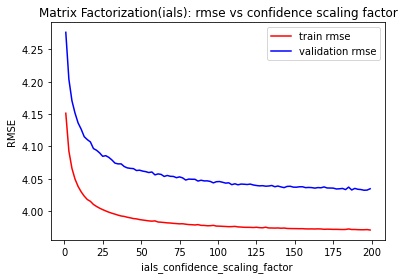

In [83]:
# optimal scale = 40
plt.plot(ials_scale, ials_train_scale, color= 'r' ,label='train rmse' )
plt.plot(ials_scale,  ials_val_scale, color= 'b',label='validation rmse' )
plt.xlabel('ials_confidence_scaling_factor ')
plt.ylabel('RMSE')
plt.title('Matrix Factorization(ials): rmse vs confidence scaling factor')
plt.legend()
plt.show()

In [84]:
# hyperparameter tuning for user_reg
reg = np.logspace(-10, -1, 10)
def test_reg_vals():
    reg_list = []
    train = []
    val = []
    for loc, R in enumerate(reg):
        model = tc.ranking_factorization_recommender.create(train3,item_id = item_id, target = target,\
                                                                   user_id = user_id, binary_target = False,\
                                                                   solver = 'ials', num_factors = 2, regularization = R,\
                                                                   ials_confidence_scaling_factor = 40 )
        rmse_train = tc.recommender.util.compare_models(train3, [model],exclude_known_for_precision_recall=False)
        rmse_train = rmse_train[0]['rmse_overall']
        reg_list.append(np.log10(R))
        train.append(rmse_train)
        rmse_val = tc.recommender.util.compare_models(validation, [model], model_names=["m1"], metric='rmse')
        rmse_val = rmse_val[0]['rmse_overall']
        val.append(rmse_val)
    return reg_list,train,val

In [85]:
ials_reg, ials_train_reg, ials_val_reg = test_reg_vals()

Preparing data set.

Data has 101335 observations with 22098 users and 246 items.

Data prepared in: 0.115735s

Training ranking_factorization_recommender for recommendations.

+------------------------------+--------------------------------------------------+----------+

| Parameter                    | Description                                      | Value    |

+------------------------------+--------------------------------------------------+----------+

| num_factors                  | Factor Dimension                                 | 2        |

| regularization               | L2 Regularization on Factors                     | 1e-10    |

| max_iterations               | Maximum Number of Iterations                     | 25       |

| solver                       | Solver used for training                         | ials     |

+------------------------------+--------------------------------------------------+----------+

+---------+--------------+---------------------------+

| Iter.   | Elapsed time | Estimated Objective Value |

+---------+--------------+---------------------------+

| Initial | 206us        | NA                        |

+---------+--------------+---------------------------+

| 0       | 28.549ms     | 4.21001                   |

| 1       | 53.966ms     | 4.0306                    |

| 2       | 77.539ms     | 3.99789                   |

| 3       | 103.563ms    | 3.99483                   |

| 4       | 130.182ms    | 3.99312                   |

| 5       | 154.788ms    | 3.99221                   |

| 6       | 178.296ms    | 3.99193                   |

| 7       | 205.317ms    | 3.99181                   |

| 8       | 233.258ms    | 3.99173                   |

| 9       | 259.401ms    | 3.9917                    |

| 10      | 294.943ms    | 3.99167                   |

| 11      | 320.566ms    | 3.99165                   |

| 12      | 348.535ms    | 3.99163                   |

| 13      | 375.739ms    | 3.99161                   |

| 14      | 403.837ms    | 3.99159                   |

| 15      | 442.81ms     | 3.99158                   |

| 16      | 470.859ms    | 3.99156                   |

| 17      | 496.764ms    | 3.99156                   |

| 18      | 519.817ms    | 3.99155                   |

| 19      | 546.297ms    | 3.99155                   |

| 20      | 573.459ms    | 3.99155                   |

| 21      | 595.363ms    | 3.99155                   |

| 22      | 623.447ms    | 3.99156                   |

| 23      | 666.545ms    | 3.99156                   |

| 24      | 694.562ms    | 3.99156                   |

| FINAL   | 694.641ms    | 3.99156                   |

+---------+--------------+---------------------------+

Optimization Complete: Iteration limit reached.

PROGRESS: Evaluate model M0


recommendations finished on 1000/22098 queries. users per second: 65235.8

recommendations finished on 2000/22098 queries. users per second: 82922.2

recommendations finished on 3000/22098 queries. users per second: 85331.5

recommendations finished on 4000/22098 queries. users per second: 87161.2

recommendations finished on 5000/22098 queries. users per second: 92070.9

recommendations finished on 6000/22098 queries. users per second: 86193.3

recommendations finished on 7000/22098 queries. users per second: 87348.2

recommendations finished on 8000/22098 queries. users per second: 87675.1

recommendations finished on 9000/22098 queries. users per second: 87506.1

recommendations finished on 10000/22098 queries. users per second: 89403.1

recommendations finished on 11000/22098 queries. users per second: 80754.1

recommendations finished on 12000/22098 queries. users per second: 79211.1

recommendations finished on 13000/22098 queries. users per second: 80159.8

recommendations finished on 14000/22098 queries. users per second: 79478.6

recommendations finished on 15000/22098 queries. users per second: 80618.3

recommendations finished on 16000/22098 queries. users per second: 81110.8

recommendations finished on 17000/22098 queries. users per second: 81514.8

recommendations finished on 18000/22098 queries. users per second: 82114.5

recommendations finished on 19000/22098 queries. users per second: 82047.9

recommendations finished on 20000/22098 queries. users per second: 82627.2

recommendations finished on 21000/22098 queries. users per second: 82658.6

recommendations finished on 22000/22098 queries. users per second: 82240.5


Precision and recall summary statistics by cutoff
+--------+---------------------+---------------------+
| cutoff |    mean_precision   |     mean_recall     |
+--------+---------------------+---------------------+
|   1    |  0.3970495067426916 | 0.09654465823198226 |
|   2    | 0.38847407005158896 |  0.1872085301944445 |
|   3    | 0.33199082873261493 | 0.23789189947489187 |
|   4    | 0.30638519323015717 |  0.2906039128676521 |
|   5    |  0.2924699067788939 | 0.34375031197461087 |
|   6    |  0.279323920716807  | 0.39047143066040746 |
|   7    |  0.2608057613487969 | 0.42299116712590246 |
|   8    | 0.24886867589827114 |  0.4593033723087523 |
|   9    | 0.23746744300640593 |  0.4911797135572663 |
|   10   | 0.22799800886958116 |  0.5238457882192452 |
+--------+---------------------+---------------------+
[10 rows x 3 columns]


Overall RMSE: 3.991561221227842

Per User RMSE (best)
+-----------+---------------------+-------+
|  user_id  |         rmse        | count |
+-----------+

Preparing data set.

Data has 101335 observations with 22098 users and 246 items.

Data prepared in: 0.166549s

Training ranking_factorization_recommender for recommendations.

+------------------------------+--------------------------------------------------+----------+

| Parameter                    | Description                                      | Value    |

+------------------------------+--------------------------------------------------+----------+

| num_factors                  | Factor Dimension                                 | 2        |

| regularization               | L2 Regularization on Factors                     | 1e-09    |

| max_iterations               | Maximum Number of Iterations                     | 25       |

| solver                       | Solver used for training                         | ials     |

+------------------------------+--------------------------------------------------+----------+

+---------+--------------+---------------------------+

| Iter.   | Elapsed time | Estimated Objective Value |

+---------+--------------+---------------------------+

| Initial | 205us        | NA                        |

+---------+--------------+---------------------------+

| 0       | 42.168ms     | 4.12388                   |

| 1       | 82.204ms     | 4.0001                    |

| 2       | 121.028ms    | 3.99345                   |

| 3       | 153.492ms    | 3.99201                   |

| 4       | 188.079ms    | 3.99149                   |

| 5       | 219.427ms    | 3.99127                   |

| 6       | 250.838ms    | 3.99109                   |

| 7       | 280.582ms    | 3.99095                   |

| 8       | 324.454ms    | 3.99092                   |

| 9       | 360.446ms    | 3.99085                   |

| 10      | 396.836ms    | 3.99076                   |

| 11      | 436.009ms    | 3.99078                   |

| 12      | 471.236ms    | 3.9908                    |

| 13      | 504.734ms    | 3.99082                   |

| 14      | 535.401ms    | 3.99085                   |

| 15      | 569.757ms    | 3.99088                   |

| 16      | 604.755ms    | 3.9909                    |

| 17      | 639.74ms     | 3.99093                   |

| 18      | 677.503ms    | 3.99096                   |

| 19      | 714.338ms    | 3.99098                   |

| 20      | 762.335ms    | 3.991                     |

| 21      | 796.954ms    | 3.99103                   |

| 22      | 856.404ms    | 3.99105                   |

| 23      | 920.575ms    | 3.99107                   |

| 24      | 983.873ms    | 3.99109                   |

| FINAL   | 983.971ms    | 3.99109                   |

+---------+--------------+---------------------------+

Optimization Complete: Iteration limit reached.

PROGRESS: Evaluate model M0


recommendations finished on 1000/22098 queries. users per second: 41562.8

recommendations finished on 2000/22098 queries. users per second: 48443.7

recommendations finished on 3000/22098 queries. users per second: 48808.3

recommendations finished on 4000/22098 queries. users per second: 48476.6

recommendations finished on 5000/22098 queries. users per second: 50018.5

recommendations finished on 6000/22098 queries. users per second: 49036.4

recommendations finished on 7000/22098 queries. users per second: 49191.8

recommendations finished on 8000/22098 queries. users per second: 48697.3

recommendations finished on 9000/22098 queries. users per second: 49877.5

recommendations finished on 10000/22098 queries. users per second: 50806.6

recommendations finished on 11000/22098 queries. users per second: 50749.2

recommendations finished on 12000/22098 queries. users per second: 50223.7

recommendations finished on 13000/22098 queries. users per second: 50894.2

recommendations finished on 14000/22098 queries. users per second: 50287.7

recommendations finished on 15000/22098 queries. users per second: 49615.2

recommendations finished on 16000/22098 queries. users per second: 50169.8

recommendations finished on 17000/22098 queries. users per second: 51242.8

recommendations finished on 18000/22098 queries. users per second: 50293.1

recommendations finished on 19000/22098 queries. users per second: 51078.4

recommendations finished on 20000/22098 queries. users per second: 49203.8

recommendations finished on 21000/22098 queries. users per second: 49710.4

recommendations finished on 22000/22098 queries. users per second: 50134.7


Precision and recall summary statistics by cutoff
+--------+---------------------+---------------------+
| cutoff |    mean_precision   |     mean_recall     |
+--------+---------------------+---------------------+
|   1    | 0.39718526563489887 | 0.09656227619692592 |
|   2    | 0.38806679337496613 | 0.18685075510881227 |
|   3    |   0.33226234651703  |  0.2381918655434168 |
|   4    |  0.3058082179382751 |  0.2902226637404611 |
|   5    | 0.29216218662322396 | 0.34372049376016095 |
|   6    |  0.2787808851479777 |  0.390151295176602  |
|   7    |  0.2608251554762551 |  0.4229905251394777 |
|   8    | 0.24887433251878052 |  0.4595328713488624 |
|   9    |  0.2379702537182848 | 0.49492690746104595 |
|   10   | 0.22896642230066064 |  0.5286473914065183 |
+--------+---------------------+---------------------+
[10 rows x 3 columns]


Overall RMSE: 3.991085489344397

Per User RMSE (best)
+-----------+---------------------+-------+
|  user_id  |         rmse        | count |
+-----------+

Preparing data set.

Data has 101335 observations with 22098 users and 246 items.

Data prepared in: 0.10897s

Training ranking_factorization_recommender for recommendations.

+------------------------------+--------------------------------------------------+----------+

| Parameter                    | Description                                      | Value    |

+------------------------------+--------------------------------------------------+----------+

| num_factors                  | Factor Dimension                                 | 2        |

| regularization               | L2 Regularization on Factors                     | 1e-08    |

| max_iterations               | Maximum Number of Iterations                     | 25       |

| solver                       | Solver used for training                         | ials     |

+------------------------------+--------------------------------------------------+----------+

+---------+--------------+---------------------------+

| Iter.   | Elapsed time | Estimated Objective Value |

+---------+--------------+---------------------------+

| Initial | 178us        | NA                        |

+---------+--------------+---------------------------+

| 0       | 40.881ms     | 4.26494                   |

| 1       | 79.956ms     | 4.05817                   |

| 2       | 111.22ms     | 3.99704                   |

| 3       | 143.205ms    | 3.99395                   |

| 4       | 176.275ms    | 3.99271                   |

| 5       | 210.11ms     | 3.99208                   |

| 6       | 247.872ms    | 3.99164                   |

| 7       | 272.814ms    | 3.99112                   |

| 8       | 334.932ms    | 3.99102                   |

| 9       | 372.387ms    | 3.99106                   |

| 10      | 413.979ms    | 3.99111                   |

| 11      | 447.013ms    | 3.99114                   |

| 12      | 483.78ms     | 3.99114                   |

| 13      | 515.886ms    | 3.9911                    |

| 14      | 544.119ms    | 3.99098                   |

| 15      | 573.969ms    | 3.99082                   |

| 16      | 605.647ms    | 3.99069                   |

| 17      | 640.513ms    | 3.99058                   |

| 18      | 674.347ms    | 3.99057                   |

| 19      | 704.526ms    | 3.99059                   |

| 20      | 747.785ms    | 3.99062                   |

| 21      | 781.998ms    | 3.99064                   |

| 22      | 814.872ms    | 3.99067                   |

| 23      | 853.601ms    | 3.9907                    |

| 24      | 885.487ms    | 3.99074                   |

| FINAL   | 885.553ms    | 3.99074                   |

+---------+--------------+---------------------------+

Optimization Complete: Iteration limit reached.

PROGRESS: Evaluate model M0


recommendations finished on 1000/22098 queries. users per second: 36735

recommendations finished on 2000/22098 queries. users per second: 50414.7

recommendations finished on 3000/22098 queries. users per second: 52800.2

recommendations finished on 4000/22098 queries. users per second: 56477.2

recommendations finished on 5000/22098 queries. users per second: 59763.6

recommendations finished on 6000/22098 queries. users per second: 59060.3

recommendations finished on 7000/22098 queries. users per second: 61307.2

recommendations finished on 8000/22098 queries. users per second: 60792.1

recommendations finished on 9000/22098 queries. users per second: 61124.3

recommendations finished on 10000/22098 queries. users per second: 63055.7

recommendations finished on 11000/22098 queries. users per second: 63222.4

recommendations finished on 12000/22098 queries. users per second: 63281.1

recommendations finished on 13000/22098 queries. users per second: 63165.7

recommendations finished on 14000/22098 queries. users per second: 62809.6

recommendations finished on 15000/22098 queries. users per second: 62731.8

recommendations finished on 16000/22098 queries. users per second: 62075.2

recommendations finished on 17000/22098 queries. users per second: 61779.8

recommendations finished on 18000/22098 queries. users per second: 62385.6

recommendations finished on 19000/22098 queries. users per second: 63181.5

recommendations finished on 20000/22098 queries. users per second: 63857.2

recommendations finished on 21000/22098 queries. users per second: 64437.9

recommendations finished on 22000/22098 queries. users per second: 64125.4


Precision and recall summary statistics by cutoff
+--------+---------------------+---------------------+
| cutoff |    mean_precision   |     mean_recall     |
+--------+---------------------+---------------------+
|   1    | 0.39700425377862264 | 0.09655789173523728 |
|   2    |  0.3883835641234498 |  0.1872681536580286 |
|   3    |  0.3365010408181754 | 0.24115263674517726 |
|   4    | 0.30831975744411355 | 0.29285141052764707 |
|   5    |  0.2916010498687665 |  0.3433143854085642 |
|   6    | 0.27881859595136776 | 0.39054656500632795 |
|   7    | 0.26162031470204095 | 0.42555078332851015 |
|   8    |  0.2480993755090954 |  0.4588165354370641 |
|   9    | 0.23734174032843536 |  0.4948332475246408 |
|   10   |  0.2281518689474167 |  0.5272211581112196 |
+--------+---------------------+---------------------+
[10 rows x 3 columns]


Overall RMSE: 3.9907397488104412

Per User RMSE (best)
+-----------+---------------------+-------+
|  user_id  |         rmse        | count |
+-----------

Preparing data set.

Data has 101335 observations with 22098 users and 246 items.

Data prepared in: 0.131953s

Training ranking_factorization_recommender for recommendations.

+------------------------------+--------------------------------------------------+----------+

| Parameter                    | Description                                      | Value    |

+------------------------------+--------------------------------------------------+----------+

| num_factors                  | Factor Dimension                                 | 2        |

| regularization               | L2 Regularization on Factors                     | 1e-07    |

| max_iterations               | Maximum Number of Iterations                     | 25       |

| solver                       | Solver used for training                         | ials     |

+------------------------------+--------------------------------------------------+----------+

+---------+--------------+---------------------------+

| Iter.   | Elapsed time | Estimated Objective Value |

+---------+--------------+---------------------------+

| Initial | 152us        | NA                        |

+---------+--------------+---------------------------+

| 0       | 48.165ms     | 4.28438                   |

| 1       | 74.869ms     | 4.03238                   |

| 2       | 109.946ms    | 3.99388                   |

| 3       | 144.367ms    | 3.99155                   |

| 4       | 178.337ms    | 3.99096                   |

| 5       | 217.411ms    | 3.99078                   |

| 6       | 252.25ms     | 3.99078                   |

| 7       | 287.01ms     | 3.99076                   |

| 8       | 321.53ms     | 3.9908                    |

| 9       | 358.591ms    | 3.99089                   |

| 10      | 398.026ms    | 3.99099                   |

| 11      | 442.824ms    | 3.99108                   |

| 12      | 482.581ms    | 3.99115                   |

| 13      | 527.481ms    | 3.99119                   |

| 14      | 580.885ms    | 3.99122                   |

| 15      | 619.745ms    | 3.9912                    |

| 16      | 667.533ms    | 3.99109                   |

| 17      | 713.552ms    | 3.99096                   |

| 18      | 759.329ms    | 3.99096                   |

| 19      | 796.796ms    | 3.99095                   |

| 20      | 841.086ms    | 3.99092                   |

| 21      | 878.262ms    | 3.99093                   |

| 22      | 913.403ms    | 3.99096                   |

| 23      | 961.509ms    | 3.99099                   |

| 24      | 1.01s        | 3.99102                   |

| FINAL   | 1.01s        | 3.99102                   |

+---------+--------------+---------------------------+

Optimization Complete: Iteration limit reached.

PROGRESS: Evaluate model M0


recommendations finished on 1000/22098 queries. users per second: 28863.4

recommendations finished on 2000/22098 queries. users per second: 38796.5

recommendations finished on 3000/22098 queries. users per second: 41803.1

recommendations finished on 4000/22098 queries. users per second: 46168.6

recommendations finished on 5000/22098 queries. users per second: 49840.5

recommendations finished on 6000/22098 queries. users per second: 51643.6

recommendations finished on 7000/22098 queries. users per second: 50911.7

recommendations finished on 8000/22098 queries. users per second: 52306

recommendations finished on 9000/22098 queries. users per second: 54478.4

recommendations finished on 10000/22098 queries. users per second: 56234.7

recommendations finished on 11000/22098 queries. users per second: 54510

recommendations finished on 12000/22098 queries. users per second: 54766.3

recommendations finished on 13000/22098 queries. users per second: 54393.5

recommendations finished on 14000/22098 queries. users per second: 54687.3

recommendations finished on 15000/22098 queries. users per second: 55397.8

recommendations finished on 16000/22098 queries. users per second: 56621.7

recommendations finished on 17000/22098 queries. users per second: 57654.7

recommendations finished on 18000/22098 queries. users per second: 58719.5

recommendations finished on 19000/22098 queries. users per second: 59514.3

recommendations finished on 20000/22098 queries. users per second: 59360.2

recommendations finished on 21000/22098 queries. users per second: 59627.6

recommendations finished on 22000/22098 queries. users per second: 58992.5


Precision and recall summary statistics by cutoff
+--------+---------------------+---------------------+
| cutoff |    mean_precision   |     mean_recall     |
+--------+---------------------+---------------------+
|   1    |  0.392162186623224  |  0.0951454472418267 |
|   2    |  0.3850122183002998 |  0.1856912717214825 |
|   3    |  0.3348719341116844 | 0.24046578270143137 |
|   4    | 0.31000543035568756 |  0.2947874992309675 |
|   5    |  0.2908860530364741 | 0.34260914790430963 |
|   6    | 0.27783057290252616 |  0.3894769513059811 |
|   7    |  0.2632300272810725 |  0.429027158504501  |
|   8    | 0.25102384831206537 |  0.4652783514826147 |
|   9    | 0.23911163403425084 | 0.49703915906142415 |
|   10   | 0.22794823060910463 |  0.524847977619814  |
+--------+---------------------+---------------------+
[10 rows x 3 columns]


Overall RMSE: 3.991016387216966

Per User RMSE (best)
+-----------+--------------------+-------+
|  user_id  |        rmse        | count |
+-----------+--

Preparing data set.

Data has 101335 observations with 22098 users and 246 items.

Data prepared in: 0.125668s

Training ranking_factorization_recommender for recommendations.

+------------------------------+--------------------------------------------------+----------+

| Parameter                    | Description                                      | Value    |

+------------------------------+--------------------------------------------------+----------+

| num_factors                  | Factor Dimension                                 | 2        |

| regularization               | L2 Regularization on Factors                     | 1e-06    |

| max_iterations               | Maximum Number of Iterations                     | 25       |

| solver                       | Solver used for training                         | ials     |

+------------------------------+--------------------------------------------------+----------+

+---------+--------------+---------------------------+

| Iter.   | Elapsed time | Estimated Objective Value |

+---------+--------------+---------------------------+

| Initial | 218us        | NA                        |

+---------+--------------+---------------------------+

| 0       | 38.025ms     | 4.33628                   |

| 1       | 78.142ms     | 4.04143                   |

| 2       | 107.444ms    | 3.99836                   |

| 3       | 141.142ms    | 3.9945                    |

| 4       | 171.849ms    | 3.99365                   |

| 5       | 206.027ms    | 3.99337                   |

| 6       | 243.833ms    | 3.99322                   |

| 7       | 277.758ms    | 3.99307                   |

| 8       | 319.139ms    | 3.99294                   |

| 9       | 359.218ms    | 3.99285                   |

| 10      | 399.015ms    | 3.99278                   |

| 11      | 432.63ms     | 3.99269                   |

| 12      | 467.733ms    | 3.99258                   |

| 13      | 503.332ms    | 3.99247                   |

| 14      | 535.546ms    | 3.99235                   |

| 15      | 565.764ms    | 3.99227                   |

| 16      | 602.343ms    | 3.99218                   |

| 17      | 634.688ms    | 3.99208                   |

| 18      | 667.824ms    | 3.992                     |

| 19      | 704.567ms    | 3.9919                    |

| 20      | 740.081ms    | 3.99178                   |

| 21      | 773.708ms    | 3.99166                   |

| 22      | 809.013ms    | 3.99159                   |

| 23      | 841.353ms    | 3.99155                   |

| 24      | 872.106ms    | 3.99151                   |

| FINAL   | 872.18ms     | 3.99151                   |

+---------+--------------+---------------------------+

Optimization Complete: Iteration limit reached.

PROGRESS: Evaluate model M0


recommendations finished on 1000/22098 queries. users per second: 65325.3

recommendations finished on 2000/22098 queries. users per second: 72191.7

recommendations finished on 3000/22098 queries. users per second: 70323.5

recommendations finished on 4000/22098 queries. users per second: 71452.8

recommendations finished on 5000/22098 queries. users per second: 68412.6

recommendations finished on 6000/22098 queries. users per second: 66301.3

recommendations finished on 7000/22098 queries. users per second: 67993.5

recommendations finished on 8000/22098 queries. users per second: 70008.4

recommendations finished on 9000/22098 queries. users per second: 71461.5

recommendations finished on 10000/22098 queries. users per second: 69358.2

recommendations finished on 11000/22098 queries. users per second: 70359.5

recommendations finished on 12000/22098 queries. users per second: 68242.3

recommendations finished on 13000/22098 queries. users per second: 69031.8

recommendations finished on 14000/22098 queries. users per second: 69373.2

recommendations finished on 15000/22098 queries. users per second: 69994.7

recommendations finished on 16000/22098 queries. users per second: 69883

recommendations finished on 17000/22098 queries. users per second: 71413.6

recommendations finished on 18000/22098 queries. users per second: 71427.4

recommendations finished on 19000/22098 queries. users per second: 71989.6

recommendations finished on 20000/22098 queries. users per second: 72325.9

recommendations finished on 21000/22098 queries. users per second: 71714.2

recommendations finished on 22000/22098 queries. users per second: 70412.4


Precision and recall summary statistics by cutoff
+--------+---------------------+---------------------+
| cutoff |    mean_precision   |     mean_recall     |
+--------+---------------------+---------------------+
|   1    | 0.39311249886867566 | 0.09507272845736252 |
|   2    | 0.38976377952755964 | 0.18801754262451043 |
|   3    |  0.334977524361179  | 0.24052697648534377 |
|   4    |  0.3105824056475697 |  0.2950534288984893 |
|   5    |  0.292659969227985  | 0.34481356976206434 |
|   6    |  0.2786979213805169 | 0.39089371384725075 |
|   7    | 0.26355326273870844 |  0.4302011809922724 |
|   8    |  0.2507240474251063 |  0.465814885164518  |
|   9    | 0.23640148429722146 |  0.4910068850627464 |
|   10   |  0.2256267535523577 |  0.5192620597245728 |
+--------+---------------------+---------------------+
[10 rows x 3 columns]


Overall RMSE: 3.991512676737816

Per User RMSE (best)
+-----------+---------------------+-------+
|  user_id  |         rmse        | count |
+-----------+

Preparing data set.

Data has 101335 observations with 22098 users and 246 items.

Data prepared in: 0.151472s

Training ranking_factorization_recommender for recommendations.

+------------------------------+--------------------------------------------------+----------+

| Parameter                    | Description                                      | Value    |

+------------------------------+--------------------------------------------------+----------+

| num_factors                  | Factor Dimension                                 | 2        |

| regularization               | L2 Regularization on Factors                     | 1e-05    |

| max_iterations               | Maximum Number of Iterations                     | 25       |

| solver                       | Solver used for training                         | ials     |

+------------------------------+--------------------------------------------------+----------+

+---------+--------------+---------------------------+

| Iter.   | Elapsed time | Estimated Objective Value |

+---------+--------------+---------------------------+

| Initial | 119us        | NA                        |

+---------+--------------+---------------------------+

| 0       | 41.764ms     | 4.34489                   |

| 1       | 80.535ms     | 4.03594                   |

| 2       | 117.524ms    | 3.99728                   |

| 3       | 152.431ms    | 3.99373                   |

| 4       | 190.452ms    | 3.99259                   |

| 5       | 231.465ms    | 3.99201                   |

| 6       | 281.244ms    | 3.99176                   |

| 7       | 323.931ms    | 3.99165                   |

| 8       | 364.8ms      | 3.99159                   |

| 9       | 404.083ms    | 3.99153                   |

| 10      | 439.475ms    | 3.99149                   |

| 11      | 477.561ms    | 3.99146                   |

| 12      | 513.285ms    | 3.99145                   |

| 13      | 554.303ms    | 3.99145                   |

| 14      | 596.041ms    | 3.99145                   |

| 15      | 636.729ms    | 3.99145                   |

| 16      | 680.376ms    | 3.99146                   |

| 17      | 723.361ms    | 3.99146                   |

| 18      | 758.057ms    | 3.99146                   |

| 19      | 799.032ms    | 3.99146                   |

| 20      | 840.753ms    | 3.99147                   |

| 21      | 880.13ms     | 3.99147                   |

| 22      | 914.45ms     | 3.99148                   |

| 23      | 954.146ms    | 3.99148                   |

| 24      | 990.695ms    | 3.99149                   |

| FINAL   | 990.755ms    | 3.99149                   |

+---------+--------------+---------------------------+

Optimization Complete: Iteration limit reached.

PROGRESS: Evaluate model M0


recommendations finished on 1000/22098 queries. users per second: 45898.9

recommendations finished on 2000/22098 queries. users per second: 59348.9

recommendations finished on 3000/22098 queries. users per second: 63430.3

recommendations finished on 4000/22098 queries. users per second: 68033

recommendations finished on 5000/22098 queries. users per second: 71354.2

recommendations finished on 6000/22098 queries. users per second: 70953

recommendations finished on 7000/22098 queries. users per second: 71035

recommendations finished on 8000/22098 queries. users per second: 72067.5

recommendations finished on 9000/22098 queries. users per second: 73204.1

recommendations finished on 10000/22098 queries. users per second: 73251.5

recommendations finished on 11000/22098 queries. users per second: 73096.5

recommendations finished on 12000/22098 queries. users per second: 71334.7

recommendations finished on 13000/22098 queries. users per second: 70376.8

recommendations finished on 14000/22098 queries. users per second: 70570.6

recommendations finished on 15000/22098 queries. users per second: 70729

recommendations finished on 16000/22098 queries. users per second: 71230.1

recommendations finished on 17000/22098 queries. users per second: 70404.2

recommendations finished on 18000/22098 queries. users per second: 69531.4

recommendations finished on 19000/22098 queries. users per second: 69835.5

recommendations finished on 20000/22098 queries. users per second: 70253.3

recommendations finished on 21000/22098 queries. users per second: 70423

recommendations finished on 22000/22098 queries. users per second: 67973.6


Precision and recall summary statistics by cutoff
+--------+---------------------+---------------------+
| cutoff |    mean_precision   |     mean_recall     |
+--------+---------------------+---------------------+
|   1    | 0.40130328536519144 | 0.09738537419684552 |
|   2    | 0.39053307991673497 |  0.1884290682904336 |
|   3    | 0.33045222795426377 |  0.2378108068777425 |
|   4    |  0.3054688207077568 | 0.29002008528297546 |
|   5    | 0.29179111231785737 | 0.34407522362635273 |
|   6    |  0.2787808851479769 |  0.3912650205580127 |
|   7    | 0.26008817863284495 | 0.42332548397524783 |
|   8    | 0.24552561317766314 |  0.4554491435442251 |
|   9    |  0.2335455194537462 | 0.48693533657383403 |
|   10   | 0.22367182550457035 |  0.516656546216338  |
+--------+---------------------+---------------------+
[10 rows x 3 columns]


Overall RMSE: 3.991487479950499

Per User RMSE (best)
+-----------+---------------------+-------+
|  user_id  |         rmse        | count |
+-----------+

Preparing data set.

Data has 101335 observations with 22098 users and 246 items.

Data prepared in: 0.152005s

Training ranking_factorization_recommender for recommendations.

+------------------------------+--------------------------------------------------+----------+

| Parameter                    | Description                                      | Value    |

+------------------------------+--------------------------------------------------+----------+

| num_factors                  | Factor Dimension                                 | 2        |

| regularization               | L2 Regularization on Factors                     | 0.0001   |

| max_iterations               | Maximum Number of Iterations                     | 25       |

| solver                       | Solver used for training                         | ials     |

+------------------------------+--------------------------------------------------+----------+

+---------+--------------+---------------------------+

| Iter.   | Elapsed time | Estimated Objective Value |

+---------+--------------+---------------------------+

| Initial | 389us        | NA                        |

+---------+--------------+---------------------------+

| 0       | 47.532ms     | 4.28591                   |

| 1       | 84.382ms     | 4.00218                   |

| 2       | 126.709ms    | 3.99665                   |

| 3       | 178.943ms    | 3.99567                   |

| 4       | 219.725ms    | 3.9951                    |

| 5       | 273.674ms    | 3.99473                   |

| 6       | 317.857ms    | 3.99454                   |

| 7       | 357.095ms    | 3.99439                   |

| 8       | 397.147ms    | 3.99427                   |

| 9       | 432.213ms    | 3.99419                   |

| 10      | 466.538ms    | 3.99413                   |

| 11      | 509.903ms    | 3.99406                   |

| 12      | 554.262ms    | 3.994                     |

| 13      | 597.487ms    | 3.99395                   |

| 14      | 642.506ms    | 3.99389                   |

| 15      | 686.656ms    | 3.99383                   |

| 16      | 727.907ms    | 3.99377                   |

| 17      | 769.862ms    | 3.99371                   |

| 18      | 806.054ms    | 3.99365                   |

| 19      | 847.435ms    | 3.99357                   |

| 20      | 882.779ms    | 3.99348                   |

| 21      | 920.067ms    | 3.99336                   |

| 22      | 950.502ms    | 3.99323                   |

| 23      | 987.647ms    | 3.99309                   |

| 24      | 1.02s        | 3.99297                   |

| FINAL   | 1.02s        | 3.99297                   |

+---------+--------------+---------------------------+

Optimization Complete: Iteration limit reached.

PROGRESS: Evaluate model M0


recommendations finished on 1000/22098 queries. users per second: 38279

recommendations finished on 2000/22098 queries. users per second: 46073.4

recommendations finished on 3000/22098 queries. users per second: 49650

recommendations finished on 4000/22098 queries. users per second: 50298.6

recommendations finished on 5000/22098 queries. users per second: 52388.4

recommendations finished on 6000/22098 queries. users per second: 50822.5

recommendations finished on 7000/22098 queries. users per second: 53216.2

recommendations finished on 8000/22098 queries. users per second: 54891.1

recommendations finished on 9000/22098 queries. users per second: 56194.9

recommendations finished on 10000/22098 queries. users per second: 57896.2

recommendations finished on 11000/22098 queries. users per second: 58055.5

recommendations finished on 12000/22098 queries. users per second: 57622.5

recommendations finished on 13000/22098 queries. users per second: 58288.9

recommendations finished on 14000/22098 queries. users per second: 58162

recommendations finished on 15000/22098 queries. users per second: 59237

recommendations finished on 16000/22098 queries. users per second: 59166.3

recommendations finished on 17000/22098 queries. users per second: 60525.8

recommendations finished on 18000/22098 queries. users per second: 61024.6

recommendations finished on 19000/22098 queries. users per second: 57043.7

recommendations finished on 20000/22098 queries. users per second: 57018.9

recommendations finished on 21000/22098 queries. users per second: 54483.2

recommendations finished on 22000/22098 queries. users per second: 52865.2


Precision and recall summary statistics by cutoff
+--------+---------------------+---------------------+
| cutoff |    mean_precision   |     mean_recall     |
+--------+---------------------+---------------------+
|   1    | 0.40673364105348925 | 0.09829615351233623 |
|   2    | 0.39379129332971324 | 0.18978967225620128 |
|   3    |  0.3372552568859921 | 0.24215741391390416 |
|   4    |  0.310944429360123  | 0.29440910989076025 |
|   5    | 0.29356502850936667 | 0.34548487219289975 |
|   6    | 0.27921078830663404 |  0.3920079701135406 |
|   7    |  0.2631395213529343 |  0.427925171310641  |
|   8    |  0.2509050592813823 | 0.46656996685972746 |
|   9    | 0.23671322693858676 |  0.4928560521899074 |
|   10   | 0.22563580414517131 |  0.5193141096165524 |
+--------+---------------------+---------------------+
[10 rows x 3 columns]


Overall RMSE: 3.9929745700121315

Per User RMSE (best)
+-----------+--------------------+-------+
|  user_id  |        rmse        | count |
+-----------+-

Preparing data set.

Data has 101335 observations with 22098 users and 246 items.

Data prepared in: 0.129243s

Training ranking_factorization_recommender for recommendations.

+------------------------------+--------------------------------------------------+----------+

| Parameter                    | Description                                      | Value    |

+------------------------------+--------------------------------------------------+----------+

| num_factors                  | Factor Dimension                                 | 2        |

| regularization               | L2 Regularization on Factors                     | 0.001    |

| max_iterations               | Maximum Number of Iterations                     | 25       |

| solver                       | Solver used for training                         | ials     |

+------------------------------+--------------------------------------------------+----------+

+---------+--------------+---------------------------+

| Iter.   | Elapsed time | Estimated Objective Value |

+---------+--------------+---------------------------+

| Initial | 1.72ms       | NA                        |

+---------+--------------+---------------------------+

| 0       | 55.984ms     | 4.38822                   |

| 1       | 95.309ms     | 4.06158                   |

| 2       | 139.238ms    | 4.03361                   |

| 3       | 182.851ms    | 4.02511                   |

| 4       | 239.627ms    | 4.01917                   |

| 5       | 279ms        | 4.0147                    |

| 6       | 328.74ms     | 4.01166                   |

| 7       | 368.167ms    | 4.00937                   |

| 8       | 404.356ms    | 4.00764                   |

| 9       | 442.396ms    | 4.00626                   |

| 10      | 481.527ms    | 4.00513                   |

| 11      | 524.835ms    | 4.0042                    |

| 12      | 574.868ms    | 4.00342                   |

| 13      | 617.367ms    | 4.00273                   |

| 14      | 660.798ms    | 4.00211                   |

| 15      | 702.259ms    | 4.00156                   |

| 16      | 739.968ms    | 4.00109                   |

| 17      | 780.822ms    | 4.00068                   |

| 18      | 817.989ms    | 4.00033                   |

| 19      | 864.392ms    | 4.00001                   |

| 20      | 912.807ms    | 3.99973                   |

| 21      | 961.475ms    | 3.99948                   |

| 22      | 1.00s        | 3.99925                   |

| 23      | 1.05s        | 3.99904                   |

| 24      | 1.10s        | 3.99885                   |

| FINAL   | 1.10s        | 3.99885                   |

+---------+--------------+---------------------------+

Optimization Complete: Iteration limit reached.

PROGRESS: Evaluate model M0


recommendations finished on 1000/22098 queries. users per second: 48962

recommendations finished on 2000/22098 queries. users per second: 54682.2

recommendations finished on 3000/22098 queries. users per second: 56774.1

recommendations finished on 4000/22098 queries. users per second: 60105.2

recommendations finished on 5000/22098 queries. users per second: 63038.2

recommendations finished on 6000/22098 queries. users per second: 58240.6

recommendations finished on 7000/22098 queries. users per second: 59598.3

recommendations finished on 8000/22098 queries. users per second: 60028.1

recommendations finished on 9000/22098 queries. users per second: 60197.9

recommendations finished on 10000/22098 queries. users per second: 60753.7

recommendations finished on 11000/22098 queries. users per second: 60614.4

recommendations finished on 12000/22098 queries. users per second: 60377.4

recommendations finished on 13000/22098 queries. users per second: 59207.4

recommendations finished on 14000/22098 queries. users per second: 59828.8

recommendations finished on 15000/22098 queries. users per second: 60826

recommendations finished on 16000/22098 queries. users per second: 61061.9

recommendations finished on 17000/22098 queries. users per second: 62072.8

recommendations finished on 18000/22098 queries. users per second: 62317.8

recommendations finished on 19000/22098 queries. users per second: 62506.6

recommendations finished on 20000/22098 queries. users per second: 62258.4

recommendations finished on 21000/22098 queries. users per second: 61503

recommendations finished on 22000/22098 queries. users per second: 59651


Precision and recall summary statistics by cutoff
+--------+---------------------+---------------------+
| cutoff |    mean_precision   |     mean_recall     |
+--------+---------------------+---------------------+
|   1    | 0.41030862521495165 |  0.0999262539437812 |
|   2    | 0.39680061544031153 | 0.19190640564541814 |
|   3    |  0.3329562252994237 | 0.24091303896274838 |
|   4    |  0.310073309801792  | 0.29457665144899686 |
|   5    | 0.29332066250339434 |  0.3464602070339366 |
|   6    |  0.2771593206021655 | 0.39019741827176124 |
|   7    |  0.2586918014558529 |  0.4218504569522935 |
|   8    | 0.24396438591727768 | 0.45401932282895785 |
|   9    | 0.22985488882855099 |  0.478121905127484  |
|   10   | 0.21996560774730795 |  0.5071301265015667 |
+--------+---------------------+---------------------+
[10 rows x 3 columns]


Overall RMSE: 3.9988473516808787

Per User RMSE (best)
+-----------+---------------------+-------+
|  user_id  |         rmse        | count |
+-----------

Preparing data set.

Data has 101335 observations with 22098 users and 246 items.

Data prepared in: 0.153421s

Training ranking_factorization_recommender for recommendations.

+------------------------------+--------------------------------------------------+----------+

| Parameter                    | Description                                      | Value    |

+------------------------------+--------------------------------------------------+----------+

| num_factors                  | Factor Dimension                                 | 2        |

| regularization               | L2 Regularization on Factors                     | 0.01     |

| max_iterations               | Maximum Number of Iterations                     | 25       |

| solver                       | Solver used for training                         | ials     |

+------------------------------+--------------------------------------------------+----------+

+---------+--------------+---------------------------+

| Iter.   | Elapsed time | Estimated Objective Value |

+---------+--------------+---------------------------+

| Initial | 150us        | NA                        |

+---------+--------------+---------------------------+

| 0       | 47.404ms     | 4.43883                   |

| 1       | 85.437ms     | 4.16422                   |

| 2       | 124.7ms      | 4.0217                    |

| 3       | 160.031ms    | 4.02246                   |

| 4       | 202.674ms    | 4.02413                   |

| 5       | 245.414ms    | 4.02576                   |

| 6       | 287.53ms     | 4.02724                   |

| 7       | 326.479ms    | 4.02847                   |

| 8       | 365.944ms    | 4.02944                   |

| 9       | 400.958ms    | 4.03016                   |

| 10      | 439.436ms    | 4.0307                    |

| 11      | 486.703ms    | 4.03109                   |

| 12      | 527.54ms     | 4.03137                   |

| 13      | 570.012ms    | 4.03158                   |

| 14      | 607.29ms     | 4.03172                   |

| 15      | 652.817ms    | 4.03183                   |

| 16      | 701.532ms    | 4.03191                   |

| 17      | 736.073ms    | 4.03196                   |

| 18      | 773.995ms    | 4.032                     |

| 19      | 811.307ms    | 4.03203                   |

| 20      | 843.95ms     | 4.03205                   |

| 21      | 877.488ms    | 4.03207                   |

| 22      | 914.716ms    | 4.03208                   |

| 23      | 947.164ms    | 4.03209                   |

| 24      | 991.804ms    | 4.0321                    |

| FINAL   | 991.88ms     | 4.0321                    |

+---------+--------------+---------------------------+

Optimization Complete: Iteration limit reached.

PROGRESS: Evaluate model M0


recommendations finished on 1000/22098 queries. users per second: 44521.6

recommendations finished on 2000/22098 queries. users per second: 50990.5

recommendations finished on 3000/22098 queries. users per second: 57350.4

recommendations finished on 4000/22098 queries. users per second: 62728.4

recommendations finished on 5000/22098 queries. users per second: 66162.9

recommendations finished on 6000/22098 queries. users per second: 66674.1

recommendations finished on 7000/22098 queries. users per second: 67411.4

recommendations finished on 8000/22098 queries. users per second: 67511.1

recommendations finished on 9000/22098 queries. users per second: 68023.1

recommendations finished on 10000/22098 queries. users per second: 68835

recommendations finished on 11000/22098 queries. users per second: 70104.3

recommendations finished on 12000/22098 queries. users per second: 65467.5

recommendations finished on 13000/22098 queries. users per second: 61295.3

recommendations finished on 14000/22098 queries. users per second: 62658.3

recommendations finished on 15000/22098 queries. users per second: 63968.9

recommendations finished on 16000/22098 queries. users per second: 65171

recommendations finished on 17000/22098 queries. users per second: 66029.2

recommendations finished on 18000/22098 queries. users per second: 67047.3

recommendations finished on 19000/22098 queries. users per second: 66488.4

recommendations finished on 20000/22098 queries. users per second: 66933.3

recommendations finished on 21000/22098 queries. users per second: 66369

recommendations finished on 22000/22098 queries. users per second: 64856.6


Precision and recall summary statistics by cutoff
+--------+---------------------+---------------------+
| cutoff |    mean_precision   |     mean_recall     |
+--------+---------------------+---------------------+
|   1    | 0.44275500045252975 | 0.10646577693630527 |
|   2    |  0.4249027061272515 | 0.20213443155213232 |
|   3    |  0.3503182791806216 | 0.24827692350571612 |
|   4    |  0.3192709747488468 |  0.2988022511207067 |
|   5    |  0.2988505747126448 | 0.34749618179400826 |
|   6    | 0.28295924216369617 |  0.391969770858817  |
|   7    |  0.2623508268363012 |  0.4209269369854288 |
|   8    | 0.24747714725314507 |  0.4522673407930763 |
|   9    |  0.234606450055811  |  0.4794342475551361 |
|   10   |  0.223617521947687  |  0.506157791792233  |
+--------+---------------------+---------------------+
[10 rows x 3 columns]


Overall RMSE: 4.032095501626541

Per User RMSE (best)
+-----------+--------------------+-------+
|  user_id  |        rmse        | count |
+-----------+--

Preparing data set.

Data has 101335 observations with 22098 users and 246 items.

Data prepared in: 0.130804s

Training ranking_factorization_recommender for recommendations.

+------------------------------+--------------------------------------------------+----------+

| Parameter                    | Description                                      | Value    |

+------------------------------+--------------------------------------------------+----------+

| num_factors                  | Factor Dimension                                 | 2        |

| regularization               | L2 Regularization on Factors                     | 0.1      |

| max_iterations               | Maximum Number of Iterations                     | 25       |

| solver                       | Solver used for training                         | ials     |

+------------------------------+--------------------------------------------------+----------+

+---------+--------------+---------------------------+

| Iter.   | Elapsed time | Estimated Objective Value |

+---------+--------------+---------------------------+

| Initial | 160us        | NA                        |

+---------+--------------+---------------------------+

| 0       | 41.693ms     | 4.43902                   |

| 1       | 72.805ms     | 4.43901                   |

| 2       | 107.907ms    | 4.43851                   |

| 3       | 136.058ms    | 4.41661                   |

| 4       | 172.663ms    | 4.32148                   |

| 5       | 215.867ms    | 4.28063                   |

| 6       | 249.48ms     | 4.27489                   |

| 7       | 282.534ms    | 4.27403                   |

| 8       | 315.473ms    | 4.27389                   |

| 9       | 354.736ms    | 4.27387                   |

| 10      | 388.644ms    | 4.27387                   |

| 11      | 423.81ms     | 4.27386                   |

| 12      | 460.067ms    | 4.27386                   |

| 13      | 495.748ms    | 4.27386                   |

| 14      | 532.219ms    | 4.27386                   |

| 15      | 568.327ms    | 4.27386                   |

| 16      | 623.624ms    | 4.27386                   |

| 17      | 661.308ms    | 4.27386                   |

| 18      | 695.253ms    | 4.27386                   |

| 19      | 732.237ms    | 4.27386                   |

| 20      | 775.076ms    | 4.27386                   |

| 21      | 812.533ms    | 4.27386                   |

| 22      | 854.547ms    | 4.27386                   |

| 23      | 892.845ms    | 4.27386                   |

| 24      | 929.06ms     | 4.27386                   |

| FINAL   | 929.149ms    | 4.27386                   |

+---------+--------------+---------------------------+

Optimization Complete: Iteration limit reached.

PROGRESS: Evaluate model M0


recommendations finished on 1000/22098 queries. users per second: 55922.2

recommendations finished on 2000/22098 queries. users per second: 66753.4

recommendations finished on 3000/22098 queries. users per second: 63167.2

recommendations finished on 4000/22098 queries. users per second: 66276.7

recommendations finished on 5000/22098 queries. users per second: 66232.2

recommendations finished on 6000/22098 queries. users per second: 67488.5

recommendations finished on 7000/22098 queries. users per second: 68861

recommendations finished on 8000/22098 queries. users per second: 69325.3

recommendations finished on 9000/22098 queries. users per second: 69475.5

recommendations finished on 10000/22098 queries. users per second: 65967

recommendations finished on 11000/22098 queries. users per second: 66468.9

recommendations finished on 12000/22098 queries. users per second: 66088.4

recommendations finished on 13000/22098 queries. users per second: 66237

recommendations finished on 14000/22098 queries. users per second: 66132.9

recommendations finished on 15000/22098 queries. users per second: 66446.7

recommendations finished on 16000/22098 queries. users per second: 66224.1

recommendations finished on 17000/22098 queries. users per second: 65804.5

recommendations finished on 18000/22098 queries. users per second: 65812.6

recommendations finished on 19000/22098 queries. users per second: 66212.5

recommendations finished on 20000/22098 queries. users per second: 66203

recommendations finished on 21000/22098 queries. users per second: 64372.7

recommendations finished on 22000/22098 queries. users per second: 61675.4


Precision and recall summary statistics by cutoff
+--------+---------------------+---------------------+
| cutoff |    mean_precision   |     mean_recall     |
+--------+---------------------+---------------------+
|   1    |  0.4375509095845779 | 0.10345141081884338 |
|   2    |  0.4225269255136218 |  0.1986161659049969 |
|   3    | 0.35034844782333247 |  0.243207972937314  |
|   4    | 0.30775409539324844 |  0.2845401161563074 |
|   5    |  0.2929224364195849 | 0.33673594513994687 |
|   6    | 0.27757413943946696 | 0.38002039223454614 |
|   7    | 0.25575035879135766 | 0.40596783760655275 |
|   8    | 0.24119264186804235 |  0.4365990122867082 |
|   9    |  0.2277179433030642 | 0.46139613823021375 |
|   10   | 0.21145352520590105 |  0.4753798968519455 |
+--------+---------------------+---------------------+
[10 rows x 3 columns]


Overall RMSE: 4.273864061717496

Per User RMSE (best)
+-----------+--------------------+-------+
|  user_id  |        rmse        | count |
+-----------+--

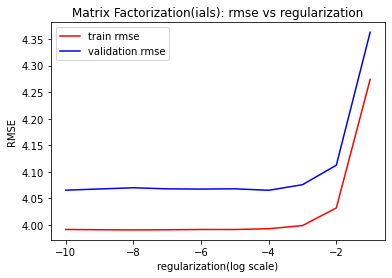

In [86]:
plt.plot(ials_reg, ials_train_reg, color= 'r' ,label='train rmse' )
plt.plot(ials_reg,  ials_val_reg, color= 'b',label='validation rmse' )
plt.xlabel('regularization(log scale)')
plt.ylabel('RMSE')
plt.title('Matrix Factorization(ials): rmse vs regularization')
plt.legend()
plt.show()

In [14]:
# hyperparameter tuning for max_iter
maxIter = np.arange(10,100, 10)
def test_iter_vals():
    maxIter_list = []
    train = []
    val = []
    for loc, iter_num in enumerate(maxIter):
        model = tc.ranking_factorization_recommender.create(train3,item_id = item_id, target = target,\
                                                            user_id = user_id, binary_target = False,\
                                                            solver = 'ials', num_factors = 2, regularization = 1e-4,\
                                                            ials_confidence_scaling_factor = 40 ,\
                                                            max_iterations = iter_num
                                                           )
        rmse_train = tc.recommender.util.compare_models(train3, [model],exclude_known_for_precision_recall=False)
        rmse_train = rmse_train[0]['rmse_overall']
        maxIter_list.append(iter_num)
        train.append(rmse_train)
        rmse_val = tc.recommender.util.compare_models(validation, [model], model_names=["m1"], metric='rmse')
        rmse_val = rmse_val[0]['rmse_overall']
        val.append(rmse_val)
    return maxIter_list,train,val

In [15]:
ials_iter, ials_train_iter, ials_val_iter = test_iter_vals() 

Preparing data set.

Data has 101335 observations with 22098 users and 246 items.

Data prepared in: 0.104749s

Training ranking_factorization_recommender for recommendations.

+------------------------------+--------------------------------------------------+----------+

| Parameter                    | Description                                      | Value    |

+------------------------------+--------------------------------------------------+----------+

| num_factors                  | Factor Dimension                                 | 2        |

| regularization               | L2 Regularization on Factors                     | 0.0001   |

| max_iterations               | Maximum Number of Iterations                     | 10       |

| solver                       | Solver used for training                         | ials     |

+------------------------------+--------------------------------------------------+----------+

+---------+--------------+---------------------------+

| Iter.   | Elapsed time | Estimated Objective Value |

+---------+--------------+---------------------------+

| Initial | 111us        | NA                        |

+---------+--------------+---------------------------+

| 0       | 30.985ms     | 4.33596                   |

| 1       | 57.244ms     | 4.00565                   |

| 2       | 83.332ms     | 3.99594                   |

| 3       | 110.984ms    | 3.99453                   |

| 4       | 136.834ms    | 3.99405                   |

| 5       | 162.593ms    | 3.99383                   |

| 6       | 187.03ms     | 3.99362                   |

| 7       | 213.078ms    | 3.99338                   |

| 8       | 234.042ms    | 3.99328                   |

| 9       | 263.943ms    | 3.9932                    |

| FINAL   | 264.001ms    | 3.9932                    |

+---------+--------------+---------------------------+

Optimization Complete: Iteration limit reached.

PROGRESS: Evaluate model M0


recommendations finished on 1000/22098 queries. users per second: 85792.7

recommendations finished on 2000/22098 queries. users per second: 97494.4

recommendations finished on 3000/22098 queries. users per second: 91942.8

recommendations finished on 4000/22098 queries. users per second: 96010.8

recommendations finished on 5000/22098 queries. users per second: 94325.4

recommendations finished on 6000/22098 queries. users per second: 93034.8

recommendations finished on 7000/22098 queries. users per second: 93024.5

recommendations finished on 8000/22098 queries. users per second: 94641

recommendations finished on 9000/22098 queries. users per second: 93961.4

recommendations finished on 10000/22098 queries. users per second: 87684.7

recommendations finished on 11000/22098 queries. users per second: 86910.5

recommendations finished on 12000/22098 queries. users per second: 85000.9

recommendations finished on 13000/22098 queries. users per second: 84529.2

recommendations finished on 14000/22098 queries. users per second: 79000.5

recommendations finished on 15000/22098 queries. users per second: 78673.7

recommendations finished on 16000/22098 queries. users per second: 76547

recommendations finished on 17000/22098 queries. users per second: 75397.4

recommendations finished on 18000/22098 queries. users per second: 76722.4

recommendations finished on 19000/22098 queries. users per second: 75839.2

recommendations finished on 20000/22098 queries. users per second: 76049.1

recommendations finished on 21000/22098 queries. users per second: 76226.7

recommendations finished on 22000/22098 queries. users per second: 75891.9


Precision and recall summary statistics by cutoff
+--------+---------------------+---------------------+
| cutoff |    mean_precision   |     mean_recall     |
+--------+---------------------+---------------------+
|   1    | 0.39931215494614863 | 0.09672633600761994 |
|   2    | 0.38996741786586986 |  0.1878626069801046 |
|   3    | 0.33315232147705565 |  0.2390679149632669 |
|   4    |  0.3064756991582945 |  0.2897363953496672 |
|   5    | 0.29356502850936705 |  0.3451813736018138 |
|   6    |  0.2806664253175247 | 0.39249724202336567 |
|   7    | 0.26226032090816287 | 0.42441318007564954 |
|   8    | 0.24976242193863574 |  0.4605678302527727 |
|   9    | 0.23776912943353318 | 0.49171118464223446 |
|   10   |  0.2295094578694909 |  0.5293530525050448 |
+--------+---------------------+---------------------+
[10 rows x 3 columns]


Overall RMSE: 3.9931977757215633

Per User RMSE (best)
+-----------+---------------------+-------+
|  user_id  |         rmse        | count |
+-----------

Preparing data set.

Data has 101335 observations with 22098 users and 246 items.

Data prepared in: 0.116221s

Training ranking_factorization_recommender for recommendations.

+------------------------------+--------------------------------------------------+----------+

| Parameter                    | Description                                      | Value    |

+------------------------------+--------------------------------------------------+----------+

| num_factors                  | Factor Dimension                                 | 2        |

| regularization               | L2 Regularization on Factors                     | 0.0001   |

| max_iterations               | Maximum Number of Iterations                     | 20       |

| solver                       | Solver used for training                         | ials     |

+------------------------------+--------------------------------------------------+----------+

+---------+--------------+---------------------------+

| Iter.   | Elapsed time | Estimated Objective Value |

+---------+--------------+---------------------------+

| Initial | 99us         | NA                        |

+---------+--------------+---------------------------+

| 0       | 40.212ms     | 4.35021                   |

| 1       | 78.232ms     | 4.05554                   |

| 2       | 111.907ms    | 3.99944                   |

| 3       | 172.484ms    | 3.99709                   |

| 4       | 208.866ms    | 3.9963                    |

| 5       | 244.707ms    | 3.99575                   |

| 6       | 277.987ms    | 3.99524                   |

| 7       | 312.358ms    | 3.99469                   |

| 8       | 343.65ms     | 3.9941                    |

| 9       | 373.889ms    | 3.9938                    |

| 10      | 406.454ms    | 3.99366                   |

| 11      | 454.133ms    | 3.99356                   |

| 12      | 494.438ms    | 3.99344                   |

| 13      | 530.75ms     | 3.99333                   |

| 14      | 568.446ms    | 3.99323                   |

| 15      | 604.649ms    | 3.9931                    |

| 16      | 640.23ms     | 3.99297                   |

| 17      | 673.414ms    | 3.99287                   |

| 18      | 710.673ms    | 3.99281                   |

| 19      | 747.855ms    | 3.99276                   |

| FINAL   | 747.932ms    | 3.99276                   |

+---------+--------------+---------------------------+

Optimization Complete: Iteration limit reached.

PROGRESS: Evaluate model M0


recommendations finished on 1000/22098 queries. users per second: 57468

recommendations finished on 2000/22098 queries. users per second: 72950.1

recommendations finished on 3000/22098 queries. users per second: 72595.3

recommendations finished on 4000/22098 queries. users per second: 62262.6

recommendations finished on 5000/22098 queries. users per second: 65703

recommendations finished on 6000/22098 queries. users per second: 65680

recommendations finished on 7000/22098 queries. users per second: 63754.6

recommendations finished on 8000/22098 queries. users per second: 64992.6

recommendations finished on 9000/22098 queries. users per second: 65745.7

recommendations finished on 10000/22098 queries. users per second: 64998.8

recommendations finished on 11000/22098 queries. users per second: 64540.7

recommendations finished on 12000/22098 queries. users per second: 61752.2

recommendations finished on 13000/22098 queries. users per second: 61997.5

recommendations finished on 14000/22098 queries. users per second: 63269.4

recommendations finished on 15000/22098 queries. users per second: 64329.1

recommendations finished on 16000/22098 queries. users per second: 65024

recommendations finished on 17000/22098 queries. users per second: 65644.2

recommendations finished on 18000/22098 queries. users per second: 65837.8

recommendations finished on 19000/22098 queries. users per second: 65311.8

recommendations finished on 20000/22098 queries. users per second: 65310.8

recommendations finished on 21000/22098 queries. users per second: 65645.7

recommendations finished on 22000/22098 queries. users per second: 64917.1


Precision and recall summary statistics by cutoff
+--------+---------------------+---------------------+
| cutoff |    mean_precision   |     mean_recall     |
+--------+---------------------+---------------------+
|   1    | 0.40076024979636166 | 0.09760349257666673 |
|   2    |  0.3898090324916285 |  0.1880115184885548 |
|   3    |  0.3329411409780664 | 0.23912713287806037 |
|   4    | 0.30772015567019567 | 0.29215200064556296 |
|   5    | 0.29078649651552035 |  0.3426160582654722 |
|   6    |  0.2776043080821791 | 0.38966271901155475 |
|   7    |   0.2619952678329   | 0.42594459574340743 |
|   8    |  0.2501357588922071 | 0.46528861898400325 |
|   9    |  0.2362405848694203 | 0.49198580618683885 |
|   10   | 0.22511992035478307 |  0.5179697653681322 |
+--------+---------------------+---------------------+
[10 rows x 3 columns]


Overall RMSE: 3.9927621135475753

Per User RMSE (best)
+-----------+---------------------+-------+
|  user_id  |         rmse        | count |
+-----------

Preparing data set.

Data has 101335 observations with 22098 users and 246 items.

Data prepared in: 0.188947s

Training ranking_factorization_recommender for recommendations.

+------------------------------+--------------------------------------------------+----------+

| Parameter                    | Description                                      | Value    |

+------------------------------+--------------------------------------------------+----------+

| num_factors                  | Factor Dimension                                 | 2        |

| regularization               | L2 Regularization on Factors                     | 0.0001   |

| max_iterations               | Maximum Number of Iterations                     | 30       |

| solver                       | Solver used for training                         | ials     |

+------------------------------+--------------------------------------------------+----------+

+---------+--------------+---------------------------+

| Iter.   | Elapsed time | Estimated Objective Value |

+---------+--------------+---------------------------+

| Initial | 114us        | NA                        |

+---------+--------------+---------------------------+

| 0       | 53.695ms     | 4.33593                   |

| 1       | 88.626ms     | 4.00683                   |

| 2       | 122.329ms    | 3.9973                    |

| 3       | 153.593ms    | 3.99603                   |

| 4       | 188.06ms     | 3.99508                   |

| 5       | 216.248ms    | 3.99421                   |

| 6       | 247.699ms    | 3.99379                   |

| 7       | 281.244ms    | 3.9936                    |

| 8       | 316.731ms    | 3.99348                   |

| 9       | 354.652ms    | 3.99338                   |

| 10      | 390.969ms    | 3.99326                   |

| 11      | 425.684ms    | 3.99322                   |

| 12      | 466.983ms    | 3.99319                   |

| 13      | 519.052ms    | 3.99315                   |

| 14      | 560.328ms    | 3.993                     |

| 15      | 597.625ms    | 3.99295                   |

| 16      | 633.076ms    | 3.99293                   |

| 17      | 676.053ms    | 3.99292                   |

| 18      | 718.495ms    | 3.99291                   |

| 19      | 751.727ms    | 3.9929                    |

| 20      | 789.679ms    | 3.99289                   |

| 21      | 827.848ms    | 3.99289                   |

| 22      | 858.907ms    | 3.99288                   |

| 23      | 892.728ms    | 3.99288                   |

| 24      | 925.814ms    | 3.99287                   |

| 25      | 962.742ms    | 3.99287                   |

| 26      | 997.107ms    | 3.99286                   |

| 27      | 1.02s        | 3.99286                   |

| 28      | 1.06s        | 3.99285                   |

| 29      | 1.10s        | 3.99285                   |

| FINAL   | 1.10s        | 3.99285                   |

+---------+--------------+---------------------------+

Optimization Complete: Iteration limit reached.

PROGRESS: Evaluate model M0


recommendations finished on 1000/22098 queries. users per second: 53579.1

recommendations finished on 2000/22098 queries. users per second: 63073.6

recommendations finished on 3000/22098 queries. users per second: 64230.2

recommendations finished on 4000/22098 queries. users per second: 62720.5

recommendations finished on 5000/22098 queries. users per second: 60902.1

recommendations finished on 6000/22098 queries. users per second: 59785.4

recommendations finished on 7000/22098 queries. users per second: 59495

recommendations finished on 8000/22098 queries. users per second: 60349.1

recommendations finished on 9000/22098 queries. users per second: 60195.4

recommendations finished on 10000/22098 queries. users per second: 60087.1

recommendations finished on 11000/22098 queries. users per second: 60181.6

recommendations finished on 12000/22098 queries. users per second: 58139.3

recommendations finished on 13000/22098 queries. users per second: 57803

recommendations finished on 14000/22098 queries. users per second: 57319.3

recommendations finished on 15000/22098 queries. users per second: 57039.6

recommendations finished on 16000/22098 queries. users per second: 58439.2

recommendations finished on 17000/22098 queries. users per second: 58318.8

recommendations finished on 18000/22098 queries. users per second: 59197.7

recommendations finished on 19000/22098 queries. users per second: 59713.9

recommendations finished on 20000/22098 queries. users per second: 60045.3

recommendations finished on 21000/22098 queries. users per second: 60695.7

recommendations finished on 22000/22098 queries. users per second: 59937.7


Precision and recall summary statistics by cutoff
+--------+---------------------+---------------------+
| cutoff |    mean_precision   |     mean_recall     |
+--------+---------------------+---------------------+
|   1    | 0.39777355416779814 | 0.09640054408985058 |
|   2    | 0.38636980722237224 | 0.18593494023128895 |
|   3    |  0.3326092859082262 | 0.23815141250951605 |
|   4    | 0.30683772287084843 |  0.2925334073760021 |
|   5    | 0.29202642773101667 |  0.3432989640039627 |
|   6    |  0.2790599450930695 |  0.3902437799611501 |
|   7    | 0.26347568622887707 |  0.4262798124192519 |
|   8    | 0.25082586659426176 |  0.461899028857972  |
|   9    | 0.23760823000573217 | 0.49080639943008725 |
|   10   | 0.22754095393248236 |  0.5219702145486839 |
+--------+---------------------+---------------------+
[10 rows x 3 columns]


Overall RMSE: 3.9928478194920554

Per User RMSE (best)
+-----------+---------------------+-------+
|  user_id  |         rmse        | count |
+-----------

Preparing data set.

Data has 101335 observations with 22098 users and 246 items.

Data prepared in: 0.1181s

Training ranking_factorization_recommender for recommendations.

+------------------------------+--------------------------------------------------+----------+

| Parameter                    | Description                                      | Value    |

+------------------------------+--------------------------------------------------+----------+

| num_factors                  | Factor Dimension                                 | 2        |

| regularization               | L2 Regularization on Factors                     | 0.0001   |

| max_iterations               | Maximum Number of Iterations                     | 40       |

| solver                       | Solver used for training                         | ials     |

+------------------------------+--------------------------------------------------+----------+

+---------+--------------+---------------------------+

| Iter.   | Elapsed time | Estimated Objective Value |

+---------+--------------+---------------------------+

| Initial | 374us        | NA                        |

+---------+--------------+---------------------------+

| 0       | 40.681ms     | 4.29826                   |

| 1       | 75.978ms     | 4.00209                   |

| 2       | 112.567ms    | 3.99676                   |

| 3       | 151.225ms    | 3.99528                   |

| 4       | 209.024ms    | 3.99429                   |

| 5       | 256.59ms     | 3.99366                   |

| 6       | 292.072ms    | 3.99328                   |

| 7       | 329.455ms    | 3.99306                   |

| 8       | 370.479ms    | 3.99295                   |

| 9       | 409.119ms    | 3.99287                   |

| 10      | 447.838ms    | 3.99281                   |

| 11      | 487.745ms    | 3.99275                   |

| 12      | 526.469ms    | 3.99269                   |

| 13      | 563.445ms    | 3.99264                   |

| 14      | 608.602ms    | 3.9926                    |

| 15      | 645.479ms    | 3.99258                   |

| 16      | 685.14ms     | 3.99256                   |

| 17      | 722.611ms    | 3.99255                   |

| 18      | 760.398ms    | 3.99254                   |

| 19      | 801.065ms    | 3.99253                   |

| 20      | 850.535ms    | 3.99253                   |

| 21      | 893.087ms    | 3.99252                   |

| 22      | 937.223ms    | 3.99251                   |

| 23      | 976.629ms    | 3.9925                    |

| 24      | 1.01s        | 3.99249                   |

| 25      | 1.05s        | 3.99249                   |

| 26      | 1.09s        | 3.99248                   |

| 27      | 1.14s        | 3.99247                   |

| 28      | 1.18s        | 3.99246                   |

| 29      | 1.22s        | 3.99246                   |

| 30      | 1.26s        | 3.99245                   |

| 31      | 1.30s        | 3.99245                   |

| 32      | 1.34s        | 3.99244                   |

| 33      | 1.38s        | 3.99244                   |

| 34      | 1.43s        | 3.99243                   |

| 35      | 1.47s        | 3.99243                   |

| 36      | 1.53s        | 3.99243                   |

| 37      | 1.57s        | 3.99242                   |

| 38      | 1.62s        | 3.99242                   |

| 39      | 1.66s        | 3.99242                   |

| FINAL   | 1.66s        | 3.99242                   |

+---------+--------------+---------------------------+

Optimization Complete: Iteration limit reached.

PROGRESS: Evaluate model M0


recommendations finished on 1000/22098 queries. users per second: 48381.6

recommendations finished on 2000/22098 queries. users per second: 52404

recommendations finished on 3000/22098 queries. users per second: 55721.7

recommendations finished on 4000/22098 queries. users per second: 60859.6

recommendations finished on 5000/22098 queries. users per second: 63542.9

recommendations finished on 6000/22098 queries. users per second: 63803.3

recommendations finished on 7000/22098 queries. users per second: 65315.6

recommendations finished on 8000/22098 queries. users per second: 64445.4

recommendations finished on 9000/22098 queries. users per second: 63602.4

recommendations finished on 10000/22098 queries. users per second: 64953.6

recommendations finished on 11000/22098 queries. users per second: 64076.1

recommendations finished on 12000/22098 queries. users per second: 63728.4

recommendations finished on 13000/22098 queries. users per second: 62836.5

recommendations finished on 14000/22098 queries. users per second: 63271.1

recommendations finished on 15000/22098 queries. users per second: 62639.4

recommendations finished on 16000/22098 queries. users per second: 64017.2

recommendations finished on 17000/22098 queries. users per second: 65034.2

recommendations finished on 18000/22098 queries. users per second: 65525.1

recommendations finished on 19000/22098 queries. users per second: 65856.1

recommendations finished on 20000/22098 queries. users per second: 66511.3

recommendations finished on 21000/22098 queries. users per second: 66490.8

recommendations finished on 22000/22098 queries. users per second: 65919.8


Precision and recall summary statistics by cutoff
+--------+---------------------+---------------------+
| cutoff |    mean_precision   |     mean_recall     |
+--------+---------------------+---------------------+
|   1    | 0.40098651461670726 | 0.09729456337489326 |
|   2    | 0.39223006606932737 |  0.189443085141464  |
|   3    |  0.3288532898904864 |  0.2370211247858534 |
|   4    |  0.306860349352883  | 0.29085565510778644 |
|   5    | 0.29124807674902625 |  0.343738823130193  |
|   6    |  0.2764880683018078 | 0.38856542236625724 |
|   7    |  0.2586336190734789 |  0.4211301528671819 |
|   8    |  0.244445198660512  |  0.453882205751344  |
|   9    | 0.23347512595408282 | 0.48732015140426194 |
|   10   | 0.22091591999275953 |  0.509643266979968  |
+--------+---------------------+---------------------+
[10 rows x 3 columns]


Overall RMSE: 3.9924191400421516

Per User RMSE (best)
+-----------+---------------------+-------+
|  user_id  |         rmse        | count |
+-----------

Preparing data set.

Data has 101335 observations with 22098 users and 246 items.

Data prepared in: 0.093195s

Training ranking_factorization_recommender for recommendations.

+------------------------------+--------------------------------------------------+----------+

| Parameter                    | Description                                      | Value    |

+------------------------------+--------------------------------------------------+----------+

| num_factors                  | Factor Dimension                                 | 2        |

| regularization               | L2 Regularization on Factors                     | 0.0001   |

| max_iterations               | Maximum Number of Iterations                     | 50       |

| solver                       | Solver used for training                         | ials     |

+------------------------------+--------------------------------------------------+----------+

+---------+--------------+---------------------------+

| Iter.   | Elapsed time | Estimated Objective Value |

+---------+--------------+---------------------------+

| Initial | 100us        | NA                        |

+---------+--------------+---------------------------+

| 0       | 52.012ms     | 4.33774                   |

| 1       | 93.127ms     | 4.00684                   |

| 2       | 138.431ms    | 3.99799                   |

| 3       | 178.36ms     | 3.99663                   |

| 4       | 217.479ms    | 3.99576                   |

| 5       | 257.801ms    | 3.99499                   |

| 6       | 294.872ms    | 3.99438                   |

| 7       | 329.358ms    | 3.99413                   |

| 8       | 364.545ms    | 3.994                     |

| 9       | 395.527ms    | 3.99391                   |

| 10      | 426.368ms    | 3.99384                   |

| 11      | 459.304ms    | 3.99378                   |

| 12      | 489.056ms    | 3.99373                   |

| 13      | 523.968ms    | 3.99369                   |

| 14      | 557.428ms    | 3.99366                   |

| 15      | 591.816ms    | 3.99363                   |

| 16      | 626.122ms    | 3.99361                   |

| 17      | 675.822ms    | 3.99359                   |

| 18      | 711.667ms    | 3.99356                   |

| 19      | 743.468ms    | 3.99353                   |

| 20      | 775.374ms    | 3.99347                   |

| 21      | 806.765ms    | 3.99343                   |

| 22      | 836.703ms    | 3.99339                   |

| 23      | 872.484ms    | 3.99333                   |

| 24      | 915.899ms    | 3.99323                   |

| 25      | 950.299ms    | 3.99306                   |

| 26      | 985.597ms    | 3.99285                   |

| 27      | 1.02s        | 3.99275                   |

| 28      | 1.05s        | 3.99267                   |

| 29      | 1.09s        | 3.99261                   |

| 30      | 1.12s        | 3.9926                    |

| 31      | 1.15s        | 3.99259                   |

| 32      | 1.19s        | 3.99259                   |

| 33      | 1.22s        | 3.99259                   |

| 34      | 1.25s        | 3.99258                   |

| 35      | 1.28s        | 3.99258                   |

| 36      | 1.31s        | 3.99258                   |

| 37      | 1.34s        | 3.99257                   |

| 38      | 1.37s        | 3.99257                   |

| 39      | 1.40s        | 3.99257                   |

| 40      | 1.44s        | 3.99256                   |

| 41      | 1.47s        | 3.99256                   |

| 42      | 1.50s        | 3.99256                   |

| 43      | 1.53s        | 3.99255                   |

| 44      | 1.56s        | 3.99255                   |

| 45      | 1.59s        | 3.99255                   |

| 46      | 1.62s        | 3.99254                   |

| 47      | 1.65s        | 3.99254                   |

| 48      | 1.68s        | 3.99254                   |

| 49      | 1.72s        | 3.99254                   |

| FINAL   | 1.72s        | 3.99254                   |

+---------+--------------+---------------------------+

Optimization Complete: Iteration limit reached.

PROGRESS: Evaluate model M0


recommendations finished on 1000/22098 queries. users per second: 55922.2

recommendations finished on 2000/22098 queries. users per second: 61954

recommendations finished on 3000/22098 queries. users per second: 61500.6

recommendations finished on 4000/22098 queries. users per second: 65866.4

recommendations finished on 5000/22098 queries. users per second: 69570.1

recommendations finished on 6000/22098 queries. users per second: 70239.5

recommendations finished on 7000/22098 queries. users per second: 73367.6

recommendations finished on 8000/22098 queries. users per second: 74273.5

recommendations finished on 9000/22098 queries. users per second: 75924.4

recommendations finished on 10000/22098 queries. users per second: 76834.4

recommendations finished on 11000/22098 queries. users per second: 75875.7

recommendations finished on 12000/22098 queries. users per second: 76042.7

recommendations finished on 13000/22098 queries. users per second: 76231.1

recommendations finished on 14000/22098 queries. users per second: 77035.2

recommendations finished on 15000/22098 queries. users per second: 77452.5

recommendations finished on 16000/22098 queries. users per second: 77804

recommendations finished on 17000/22098 queries. users per second: 79079.7

recommendations finished on 18000/22098 queries. users per second: 79289.6

recommendations finished on 19000/22098 queries. users per second: 79350.8

recommendations finished on 20000/22098 queries. users per second: 79893.9

recommendations finished on 21000/22098 queries. users per second: 79504.2

recommendations finished on 22000/22098 queries. users per second: 77777.8


Precision and recall summary statistics by cutoff
+--------+---------------------+---------------------+
| cutoff |    mean_precision   |     mean_recall     |
+--------+---------------------+---------------------+
|   1    |  0.4020725857543666 | 0.09751215890990506 |
|   2    |  0.390374694542492  |  0.1884873569969567 |
|   3    |  0.3283404229643697 |  0.2365687034295578 |
|   4    |  0.3052651823694452 | 0.28986481674812326 |
|   5    | 0.29115757082088817 |  0.3437945595553595 |
|   6    | 0.27620146619603586 |  0.3882364515136391 |
|   7    |  0.2582069482693983 | 0.42050165969395215 |
|   8    |  0.2440548918454161 |  0.4530041748087884 |
|   9    | 0.23253486992286887 | 0.48603786727908843 |
|   10   |  0.2219929405376051 |  0.5125702495997938 |
+--------+---------------------+---------------------+
[10 rows x 3 columns]


Overall RMSE: 3.992537432152018

Per User RMSE (best)
+-----------+--------------------+-------+
|  user_id  |        rmse        | count |
+-----------+--

Preparing data set.

Data has 101335 observations with 22098 users and 246 items.

Data prepared in: 0.110638s

Training ranking_factorization_recommender for recommendations.

+------------------------------+--------------------------------------------------+----------+

| Parameter                    | Description                                      | Value    |

+------------------------------+--------------------------------------------------+----------+

| num_factors                  | Factor Dimension                                 | 2        |

| regularization               | L2 Regularization on Factors                     | 0.0001   |

| max_iterations               | Maximum Number of Iterations                     | 60       |

| solver                       | Solver used for training                         | ials     |

+------------------------------+--------------------------------------------------+----------+

+---------+--------------+---------------------------+

| Iter.   | Elapsed time | Estimated Objective Value |

+---------+--------------+---------------------------+

| Initial | 161us        | NA                        |

+---------+--------------+---------------------------+

| 0       | 41.646ms     | 4.33697                   |

| 1       | 81.88ms      | 4.02293                   |

| 2       | 115.673ms    | 3.99769                   |

| 3       | 159.03ms     | 3.99547                   |

| 4       | 192.206ms    | 3.9945                    |

| 5       | 224.391ms    | 3.99411                   |

| 6       | 254.774ms    | 3.99395                   |

| 7       | 287.452ms    | 3.99379                   |

| 8       | 321.936ms    | 3.99366                   |

| 9       | 349.005ms    | 3.99354                   |

| 10      | 382.735ms    | 3.99345                   |

| 11      | 418.243ms    | 3.99339                   |

| 12      | 456.54ms     | 3.99334                   |

| 13      | 494.56ms     | 3.99327                   |

| 14      | 540.743ms    | 3.99318                   |

| 15      | 585.801ms    | 3.99305                   |

| 16      | 619.626ms    | 3.99291                   |

| 17      | 651.44ms     | 3.99274                   |

| 18      | 681.728ms    | 3.99254                   |

| 19      | 718.074ms    | 3.99245                   |

| 20      | 764.502ms    | 3.99243                   |

| 21      | 807.404ms    | 3.99242                   |

| 22      | 884.751ms    | 3.99241                   |

| 23      | 922.618ms    | 3.9924                    |

| 24      | 965.198ms    | 3.9924                    |

| 25      | 1.00s        | 3.99239                   |

| 26      | 1.04s        | 3.99239                   |

| 27      | 1.07s        | 3.99239                   |

| 28      | 1.11s        | 3.99238                   |

| 29      | 1.15s        | 3.99238                   |

| 30      | 1.20s        | 3.99238                   |

| 31      | 1.24s        | 3.99237                   |

| 32      | 1.27s        | 3.99237                   |

| 33      | 1.32s        | 3.99237                   |

| 34      | 1.36s        | 3.99236                   |

| 35      | 1.39s        | 3.99236                   |

| 36      | 1.44s        | 3.99236                   |

| 37      | 1.48s        | 3.99235                   |

| 38      | 1.52s        | 3.99235                   |

| 39      | 1.57s        | 3.99235                   |

| 40      | 1.62s        | 3.9923                    |

| 41      | 1.65s        | 3.9922                    |

| 42      | 1.70s        | 3.99219                   |

| 43      | 1.73s        | 3.99218                   |

| 44      | 1.76s        | 3.99218                   |

| 45      | 1.80s        | 3.99218                   |

| 46      | 1.84s        | 3.99218                   |

| 47      | 1.90s        | 3.99218                   |

| 48      | 1.95s        | 3.99218                   |

| 49      | 1.99s        | 3.99218                   |

| 50      | 2.04s        | 3.99218                   |

| 51      | 2.11s        | 3.99218                   |

| 52      | 2.14s        | 3.99218                   |

| 53      | 2.18s        | 3.99218                   |

| 54      | 2.21s        | 3.99217                   |

| 55      | 2.25s        | 3.99217                   |

| 56      | 2.29s        | 3.99217                   |

| 57      | 2.32s        | 3.99217                   |

| 58      | 2.36s        | 3.99217                   |

| 59      | 2.39s        | 3.99217                   |

| FINAL   | 2.39s        | 3.99217                   |

+---------+--------------+---------------------------+

Optimization Complete: Iteration limit reached.

PROGRESS: Evaluate model M0


recommendations finished on 1000/22098 queries. users per second: 58510.3

recommendations finished on 2000/22098 queries. users per second: 63227.1

recommendations finished on 3000/22098 queries. users per second: 63956.3

recommendations finished on 4000/22098 queries. users per second: 67560.7

recommendations finished on 5000/22098 queries. users per second: 68371.4

recommendations finished on 6000/22098 queries. users per second: 62487.6

recommendations finished on 7000/22098 queries. users per second: 64839.4

recommendations finished on 8000/22098 queries. users per second: 66289.9

recommendations finished on 9000/22098 queries. users per second: 67043.6

recommendations finished on 10000/22098 queries. users per second: 67218.8

recommendations finished on 11000/22098 queries. users per second: 67323.6

recommendations finished on 12000/22098 queries. users per second: 66423.1

recommendations finished on 13000/22098 queries. users per second: 67319.8

recommendations finished on 14000/22098 queries. users per second: 67334.6

recommendations finished on 15000/22098 queries. users per second: 66811.9

recommendations finished on 16000/22098 queries. users per second: 67559.3

recommendations finished on 17000/22098 queries. users per second: 67854.5

recommendations finished on 18000/22098 queries. users per second: 67963.3

recommendations finished on 19000/22098 queries. users per second: 68222.1

recommendations finished on 20000/22098 queries. users per second: 67828.8

recommendations finished on 21000/22098 queries. users per second: 67582.8

recommendations finished on 22000/22098 queries. users per second: 65644.8


Precision and recall summary statistics by cutoff
+--------+---------------------+---------------------+
| cutoff |    mean_precision   |     mean_recall     |
+--------+---------------------+---------------------+
|   1    |  0.4020725857543669 | 0.09746204471221732 |
|   2    |  0.3916417775364285 | 0.18859728384013164 |
|   3    | 0.32891362717591244 | 0.23699026833150583 |
|   4    |  0.3068603493528821 |  0.2908414464092645 |
|   5    | 0.29253326092859033 |  0.3448557755888143 |
|   6    | 0.27700093522792385 |  0.3888309695608611 |
|   7    |  0.2591507958056971 | 0.42152093598748847 |
|   8    | 0.24537854104443776 | 0.45497155256023875 |
|   9    |  0.2337164750957848 | 0.48809387796155906 |
|   10   | 0.22276224092678068 |  0.5138197341314659 |
+--------+---------------------+---------------------+
[10 rows x 3 columns]


Overall RMSE: 3.9921712526004347

Per User RMSE (best)
+-----------+---------------------+-------+
|  user_id  |         rmse        | count |
+-----------

Preparing data set.

Data has 101335 observations with 22098 users and 246 items.

Data prepared in: 0.09968s

Training ranking_factorization_recommender for recommendations.

+------------------------------+--------------------------------------------------+----------+

| Parameter                    | Description                                      | Value    |

+------------------------------+--------------------------------------------------+----------+

| num_factors                  | Factor Dimension                                 | 2        |

| regularization               | L2 Regularization on Factors                     | 0.0001   |

| max_iterations               | Maximum Number of Iterations                     | 70       |

| solver                       | Solver used for training                         | ials     |

+------------------------------+--------------------------------------------------+----------+

+---------+--------------+---------------------------+

| Iter.   | Elapsed time | Estimated Objective Value |

+---------+--------------+---------------------------+

| Initial | 488us        | NA                        |

+---------+--------------+---------------------------+

| 0       | 53.945ms     | 4.33283                   |

| 1       | 96.847ms     | 4.01318                   |

| 2       | 137.69ms     | 3.99631                   |

| 3       | 194.138ms    | 3.99468                   |

| 4       | 300.933ms    | 3.99413                   |

| 5       | 360.672ms    | 3.99383                   |

| 6       | 409.56ms     | 3.99362                   |

| 7       | 443.645ms    | 3.99349                   |

| 8       | 491.666ms    | 3.99342                   |

| 9       | 530.917ms    | 3.99336                   |

| 10      | 573.048ms    | 3.9933                    |

| 11      | 619.313ms    | 3.99324                   |

| 12      | 661.81ms     | 3.9932                    |

| 13      | 705.69ms     | 3.99316                   |

| 14      | 750.653ms    | 3.99313                   |

| 15      | 786.76ms     | 3.99311                   |

| 16      | 824.224ms    | 3.99309                   |

| 17      | 876.301ms    | 3.99307                   |

| 18      | 942.888ms    | 3.99306                   |

| 19      | 977.47ms     | 3.99304                   |

| 20      | 1.00s        | 3.99303                   |

| 21      | 1.04s        | 3.99302                   |

| 22      | 1.07s        | 3.99301                   |

| 23      | 1.12s        | 3.993                     |

| 24      | 1.15s        | 3.99299                   |

| 25      | 1.19s        | 3.99298                   |

| 26      | 1.23s        | 3.99298                   |

| 27      | 1.26s        | 3.99297                   |

| 28      | 1.30s        | 3.99296                   |

| 29      | 1.33s        | 3.99295                   |

| 30      | 1.36s        | 3.99295                   |

| 31      | 1.40s        | 3.99294                   |

| 32      | 1.43s        | 3.99293                   |

| 33      | 1.48s        | 3.99292                   |

| 34      | 1.51s        | 3.99291                   |

| 35      | 1.54s        | 3.99289                   |

| 36      | 1.57s        | 3.99287                   |

| 37      | 1.61s        | 3.99285                   |

| 38      | 1.64s        | 3.99283                   |

| 39      | 1.68s        | 3.99281                   |

| 40      | 1.71s        | 3.99279                   |

| 41      | 1.75s        | 3.99278                   |

| 42      | 1.78s        | 3.99277                   |

| 43      | 1.82s        | 3.99277                   |

| 44      | 1.85s        | 3.99276                   |

| 45      | 1.88s        | 3.99276                   |

| 46      | 1.91s        | 3.99275                   |

| 47      | 1.94s        | 3.99275                   |

| 48      | 1.99s        | 3.99274                   |

| 49      | 2.02s        | 3.99274                   |

| 50      | 2.06s        | 3.99274                   |

| 51      | 2.10s        | 3.99273                   |

| 52      | 2.13s        | 3.99273                   |

| 53      | 2.16s        | 3.99272                   |

| 54      | 2.20s        | 3.99272                   |

| 55      | 2.23s        | 3.99272                   |

| 56      | 2.26s        | 3.99271                   |

| 57      | 2.30s        | 3.99271                   |

| 58      | 2.33s        | 3.99271                   |

| 59      | 2.36s        | 3.99271                   |

| 60      | 2.40s        | 3.9927                    |

| 61      | 2.43s        | 3.9927                    |

| 62      | 2.47s        | 3.9927                    |

| 63      | 2.50s        | 3.99269                   |

| 64      | 2.54s        | 3.99269                   |

| 65      | 2.58s        | 3.99269                   |

| 66      | 2.61s        | 3.99269                   |

| 67      | 2.65s        | 3.99268                   |

| 68      | 2.68s        | 3.99268                   |

| 69      | 2.72s        | 3.99268                   |

| FINAL   | 2.72s        | 3.99268                   |

+---------+--------------+---------------------------+

Optimization Complete: Iteration limit reached.

PROGRESS: Evaluate model M0


recommendations finished on 1000/22098 queries. users per second: 61398.7

recommendations finished on 2000/22098 queries. users per second: 72246.5

recommendations finished on 3000/22098 queries. users per second: 74893.3

recommendations finished on 4000/22098 queries. users per second: 76509.6

recommendations finished on 5000/22098 queries. users per second: 79146.5

recommendations finished on 6000/22098 queries. users per second: 74138.1

recommendations finished on 7000/22098 queries. users per second: 72540.4

recommendations finished on 8000/22098 queries. users per second: 74162

recommendations finished on 9000/22098 queries. users per second: 74603.4

recommendations finished on 10000/22098 queries. users per second: 75565.2

recommendations finished on 11000/22098 queries. users per second: 74338.4

recommendations finished on 12000/22098 queries. users per second: 71978.7

recommendations finished on 13000/22098 queries. users per second: 72285.3

recommendations finished on 14000/22098 queries. users per second: 71299.4

recommendations finished on 15000/22098 queries. users per second: 70072.8

recommendations finished on 16000/22098 queries. users per second: 70241.7

recommendations finished on 17000/22098 queries. users per second: 71006.7

recommendations finished on 18000/22098 queries. users per second: 70734.7

recommendations finished on 19000/22098 queries. users per second: 71433.9

recommendations finished on 20000/22098 queries. users per second: 71569.2

recommendations finished on 21000/22098 queries. users per second: 72108.9

recommendations finished on 22000/22098 queries. users per second: 71597.1


Precision and recall summary statistics by cutoff
+--------+---------------------+---------------------+
| cutoff |    mean_precision   |     mean_recall     |
+--------+---------------------+---------------------+
|   1    | 0.39591818264096296 | 0.09600864958098594 |
|   2    | 0.38743325187799754 | 0.18678277744294827 |
|   3    | 0.33170422662684396 | 0.23798045061046202 |
|   4    | 0.30572902525115414 | 0.29014165827124666 |
|   5    |  0.2924880079645195 |  0.3436813490513085 |
|   6    |  0.2793767158415539 | 0.39061357173378364 |
|   7    |  0.2612324321528776 |  0.4233230974369184 |
|   8    | 0.24901009141098734 |  0.459360931735397  |
|   9    |  0.2372311219718224 |  0.4908239238871974 |
|   10   | 0.22801611005520855 |  0.5234660390403607 |
+--------+---------------------+---------------------+
[10 rows x 3 columns]


Overall RMSE: 3.992679484122602

Per User RMSE (best)
+-----------+---------------------+-------+
|  user_id  |         rmse        | count |
+-----------+

Preparing data set.

Data has 101335 observations with 22098 users and 246 items.

Data prepared in: 0.115098s

Training ranking_factorization_recommender for recommendations.

+------------------------------+--------------------------------------------------+----------+

| Parameter                    | Description                                      | Value    |

+------------------------------+--------------------------------------------------+----------+

| num_factors                  | Factor Dimension                                 | 2        |

| regularization               | L2 Regularization on Factors                     | 0.0001   |

| max_iterations               | Maximum Number of Iterations                     | 80       |

| solver                       | Solver used for training                         | ials     |

+------------------------------+--------------------------------------------------+----------+

+---------+--------------+---------------------------+

| Iter.   | Elapsed time | Estimated Objective Value |

+---------+--------------+---------------------------+

| Initial | 199us        | NA                        |

+---------+--------------+---------------------------+

| 0       | 40.023ms     | 4.31329                   |

| 1       | 72.895ms     | 4.00248                   |

| 2       | 106.531ms    | 3.99628                   |

| 3       | 148.703ms    | 3.99511                   |

| 4       | 180.341ms    | 3.9946                    |

| 5       | 213.129ms    | 3.99435                   |

| 6       | 244.651ms    | 3.99425                   |

| 7       | 277.117ms    | 3.9942                    |

| 8       | 309.346ms    | 3.99414                   |

| 9       | 347.344ms    | 3.99408                   |

| 10      | 390.064ms    | 3.99404                   |

| 11      | 421.985ms    | 3.994                     |

| 12      | 451.492ms    | 3.99397                   |

| 13      | 483.625ms    | 3.99394                   |

| 14      | 516.871ms    | 3.99389                   |

| 15      | 552.906ms    | 3.99385                   |

| 16      | 594.297ms    | 3.99379                   |

| 17      | 631.124ms    | 3.99371                   |

| 18      | 671.627ms    | 3.9936                    |

| 19      | 708.51ms     | 3.99346                   |

| 20      | 741.185ms    | 3.99334                   |

| 21      | 773.745ms    | 3.99326                   |

| 22      | 806.754ms    | 3.99321                   |

| 23      | 838.787ms    | 3.99314                   |

| 24      | 870.895ms    | 3.99305                   |

| 25      | 907.621ms    | 3.99301                   |

| 26      | 945.815ms    | 3.99299                   |

| 27      | 977.145ms    | 3.99297                   |

| 28      | 1.00s        | 3.99294                   |

| 29      | 1.03s        | 3.99293                   |

| 30      | 1.07s        | 3.99291                   |

| 31      | 1.10s        | 3.9929                    |

| 32      | 1.13s        | 3.99289                   |

| 33      | 1.16s        | 3.99288                   |

| 34      | 1.19s        | 3.99287                   |

| 35      | 1.23s        | 3.99286                   |

| 36      | 1.26s        | 3.99286                   |

| 37      | 1.29s        | 3.99285                   |

| 38      | 1.32s        | 3.99284                   |

| 39      | 1.35s        | 3.99284                   |

| 40      | 1.39s        | 3.99283                   |

| 41      | 1.42s        | 3.99283                   |

| 42      | 1.45s        | 3.99282                   |

| 43      | 1.48s        | 3.99282                   |

| 44      | 1.52s        | 3.99281                   |

| 45      | 1.55s        | 3.99281                   |

| 46      | 1.58s        | 3.9928                    |

| 47      | 1.62s        | 3.9928                    |

| 48      | 1.65s        | 3.99279                   |

| 49      | 1.68s        | 3.99278                   |

| 50      | 1.71s        | 3.99277                   |

| 51      | 1.76s        | 3.99274                   |

| 52      | 1.79s        | 3.99272                   |

| 53      | 1.83s        | 3.9927                    |

| 54      | 1.87s        | 3.99268                   |

| 55      | 1.91s        | 3.99267                   |

| 56      | 1.95s        | 3.99266                   |

| 57      | 1.98s        | 3.99266                   |

| 58      | 2.02s        | 3.99266                   |

| 59      | 2.05s        | 3.99265                   |

| 60      | 2.09s        | 3.99265                   |

| 61      | 2.14s        | 3.99265                   |

| 62      | 2.19s        | 3.99264                   |

| 63      | 2.23s        | 3.99264                   |

| 64      | 2.26s        | 3.99264                   |

| 65      | 2.31s        | 3.99264                   |

| 66      | 2.36s        | 3.99263                   |

| 67      | 2.39s        | 3.99263                   |

| 68      | 2.44s        | 3.99263                   |

| 69      | 2.50s        | 3.99263                   |

| 70      | 2.53s        | 3.99263                   |

| 71      | 2.57s        | 3.99262                   |

| 72      | 2.61s        | 3.99262                   |

| 73      | 2.66s        | 3.99262                   |

| 74      | 2.70s        | 3.99262                   |

| 75      | 2.73s        | 3.99262                   |

| 76      | 2.77s        | 3.99262                   |

| 77      | 2.80s        | 3.99261                   |

| 78      | 2.84s        | 3.99261                   |

| 79      | 2.87s        | 3.99261                   |

| FINAL   | 2.87s        | 3.99261                   |

+---------+--------------+---------------------------+

Optimization Complete: Iteration limit reached.

PROGRESS: Evaluate model M0


recommendations finished on 1000/22098 queries. users per second: 64283.9

recommendations finished on 2000/22098 queries. users per second: 59733.6

recommendations finished on 3000/22098 queries. users per second: 61945.1

recommendations finished on 4000/22098 queries. users per second: 61239.8

recommendations finished on 5000/22098 queries. users per second: 65572.9

recommendations finished on 6000/22098 queries. users per second: 68620.8

recommendations finished on 7000/22098 queries. users per second: 69224

recommendations finished on 8000/22098 queries. users per second: 72083.1

recommendations finished on 9000/22098 queries. users per second: 72827.9

recommendations finished on 10000/22098 queries. users per second: 73684.9

recommendations finished on 11000/22098 queries. users per second: 75631

recommendations finished on 12000/22098 queries. users per second: 74877.9

recommendations finished on 13000/22098 queries. users per second: 75135.4

recommendations finished on 14000/22098 queries. users per second: 75742.4

recommendations finished on 15000/22098 queries. users per second: 76660.9

recommendations finished on 16000/22098 queries. users per second: 77154.2

recommendations finished on 17000/22098 queries. users per second: 78455.6

recommendations finished on 18000/22098 queries. users per second: 79621

recommendations finished on 19000/22098 queries. users per second: 79692.6

recommendations finished on 20000/22098 queries. users per second: 79306.5

recommendations finished on 21000/22098 queries. users per second: 79655

recommendations finished on 22000/22098 queries. users per second: 77960


Precision and recall summary statistics by cutoff
+--------+---------------------+---------------------+
| cutoff |    mean_precision   |     mean_recall     |
+--------+---------------------+---------------------+
|   1    | 0.39628020635351624 | 0.09610595864856376 |
|   2    | 0.38754638428817056 | 0.18683104727128863 |
|   3    | 0.33152321477056745 | 0.23791849664543954 |
|   4    | 0.30585347090234355 | 0.29027459108773224 |
|   5    | 0.29252421033577647 | 0.34374071077255774 |
|   6    | 0.27943705312698014 |  0.3907495142825017 |
|   7    |  0.2613294027901673 |  0.4234478743141551 |
|   8    |  0.2490949407186169 | 0.45951270874028305 |
|   9    | 0.23728140304301013 | 0.49099177304723646 |
|   10   | 0.22807946420490557 |  0.5236775742946593 |
+--------+---------------------+---------------------+
[10 rows x 3 columns]


Overall RMSE: 3.992610728705762

Per User RMSE (best)
+-----------+---------------------+-------+
|  user_id  |         rmse        | count |
+-----------+

Preparing data set.

Data has 101335 observations with 22098 users and 246 items.

Data prepared in: 0.095133s

Training ranking_factorization_recommender for recommendations.

+------------------------------+--------------------------------------------------+----------+

| Parameter                    | Description                                      | Value    |

+------------------------------+--------------------------------------------------+----------+

| num_factors                  | Factor Dimension                                 | 2        |

| regularization               | L2 Regularization on Factors                     | 0.0001   |

| max_iterations               | Maximum Number of Iterations                     | 90       |

| solver                       | Solver used for training                         | ials     |

+------------------------------+--------------------------------------------------+----------+

+---------+--------------+---------------------------+

| Iter.   | Elapsed time | Estimated Objective Value |

+---------+--------------+---------------------------+

| Initial | 99us         | NA                        |

+---------+--------------+---------------------------+

| 0       | 41.04ms      | 4.36294                   |

| 1       | 73.851ms     | 4.07077                   |

| 2       | 105.05ms     | 4.00686                   |

| 3       | 136.245ms    | 3.9984                    |

| 4       | 166.97ms     | 3.9963                    |

| 5       | 200.765ms    | 3.99546                   |

| 6       | 232.49ms     | 3.99479                   |

| 7       | 263.102ms    | 3.9941                    |

| 8       | 297.356ms    | 3.99329                   |

| 9       | 332.078ms    | 3.99276                   |

| 10      | 368.172ms    | 3.99261                   |

| 11      | 399.789ms    | 3.99254                   |

| 12      | 430.841ms    | 3.9925                    |

| 13      | 462.204ms    | 3.99247                   |

| 14      | 491.486ms    | 3.99246                   |

| 15      | 522.637ms    | 3.99245                   |

| 16      | 553.377ms    | 3.99244                   |

| 17      | 585.018ms    | 3.99244                   |

| 18      | 616.256ms    | 3.99243                   |

| 19      | 646.809ms    | 3.99243                   |

| 20      | 677.761ms    | 3.99242                   |

| 21      | 710.628ms    | 3.99242                   |

| 22      | 739.82ms     | 3.99241                   |

| 23      | 779.277ms    | 3.99241                   |

| 24      | 805.749ms    | 3.9924                    |

| 25      | 836.318ms    | 3.9924                    |

| 26      | 875.542ms    | 3.9924                    |

| 27      | 901.649ms    | 3.9924                    |

| 28      | 933.476ms    | 3.99239                   |

| 29      | 965.407ms    | 3.99239                   |

| 30      | 995.954ms    | 3.99239                   |

| 31      | 1.02s        | 3.99238                   |

| 32      | 1.05s        | 3.99238                   |

| 33      | 1.08s        | 3.99238                   |

| 34      | 1.11s        | 3.99238                   |

| 35      | 1.14s        | 3.99237                   |

| 36      | 1.17s        | 3.99237                   |

| 37      | 1.20s        | 3.99237                   |

| 38      | 1.23s        | 3.99237                   |

| 39      | 1.27s        | 3.99237                   |

| 40      | 1.30s        | 3.99236                   |

| 41      | 1.34s        | 3.99236                   |

| 42      | 1.37s        | 3.99236                   |

| 43      | 1.41s        | 3.99236                   |

| 44      | 1.44s        | 3.99236                   |

| 45      | 1.47s        | 3.99236                   |

| 46      | 1.50s        | 3.99235                   |

| 47      | 1.53s        | 3.99235                   |

| 48      | 1.56s        | 3.99235                   |

| 49      | 1.59s        | 3.99235                   |

| 50      | 1.62s        | 3.99235                   |

| 51      | 1.65s        | 3.99235                   |

| 52      | 1.68s        | 3.99234                   |

| 53      | 1.71s        | 3.99234                   |

| 54      | 1.74s        | 3.99234                   |

| 55      | 1.78s        | 3.99234                   |

| 56      | 1.81s        | 3.99234                   |

| 57      | 1.84s        | 3.99234                   |

| 58      | 1.87s        | 3.99233                   |

| 59      | 1.91s        | 3.99233                   |

| 60      | 1.94s        | 3.99233                   |

| 61      | 1.97s        | 3.99233                   |

| 62      | 2.00s        | 3.99233                   |

| 63      | 2.03s        | 3.99233                   |

| 64      | 2.06s        | 3.99233                   |

| 65      | 2.09s        | 3.99233                   |

| 66      | 2.12s        | 3.99232                   |

| 67      | 2.15s        | 3.99232                   |

| 68      | 2.18s        | 3.99232                   |

| 69      | 2.22s        | 3.99232                   |

| 70      | 2.25s        | 3.99232                   |

| 71      | 2.28s        | 3.99232                   |

| 72      | 2.31s        | 3.99232                   |

| 73      | 2.34s        | 3.99231                   |

| 74      | 2.37s        | 3.99231                   |

| 75      | 2.40s        | 3.99231                   |

| 76      | 2.44s        | 3.99231                   |

| 77      | 2.47s        | 3.99231                   |

| 78      | 2.51s        | 3.99231                   |

| 79      | 2.54s        | 3.99231                   |

| 80      | 2.57s        | 3.99231                   |

| 81      | 2.60s        | 3.99231                   |

| 82      | 2.63s        | 3.9923                    |

| 83      | 2.66s        | 3.9923                    |

| 84      | 2.69s        | 3.9923                    |

| 85      | 2.72s        | 3.9923                    |

| 86      | 2.75s        | 3.9923                    |

| 87      | 2.78s        | 3.9923                    |

| 88      | 2.82s        | 3.9923                    |

| 89      | 2.85s        | 3.9923                    |

| FINAL   | 2.85s        | 3.9923                    |

+---------+--------------+---------------------------+

Optimization Complete: Iteration limit reached.

PROGRESS: Evaluate model M0


recommendations finished on 1000/22098 queries. users per second: 68446.3

recommendations finished on 2000/22098 queries. users per second: 74836.3

recommendations finished on 3000/22098 queries. users per second: 73726.4

recommendations finished on 4000/22098 queries. users per second: 76732.7

recommendations finished on 5000/22098 queries. users per second: 78520.1

recommendations finished on 6000/22098 queries. users per second: 75818.8

recommendations finished on 7000/22098 queries. users per second: 78522

recommendations finished on 8000/22098 queries. users per second: 79137.4

recommendations finished on 9000/22098 queries. users per second: 80110.4

recommendations finished on 10000/22098 queries. users per second: 81479.7

recommendations finished on 11000/22098 queries. users per second: 80582.5

recommendations finished on 12000/22098 queries. users per second: 78998.8

recommendations finished on 13000/22098 queries. users per second: 80080.8

recommendations finished on 14000/22098 queries. users per second: 81329.6

recommendations finished on 15000/22098 queries. users per second: 82052.9

recommendations finished on 16000/22098 queries. users per second: 80871

recommendations finished on 17000/22098 queries. users per second: 81431.3

recommendations finished on 18000/22098 queries. users per second: 80853.8

recommendations finished on 19000/22098 queries. users per second: 81489.5

recommendations finished on 20000/22098 queries. users per second: 81383.9

recommendations finished on 21000/22098 queries. users per second: 81892.1

recommendations finished on 22000/22098 queries. users per second: 79403.2


Precision and recall summary statistics by cutoff
+--------+---------------------+---------------------+
| cutoff |    mean_precision   |     mean_recall     |
+--------+---------------------+---------------------+
|   1    |  0.402887139107611  | 0.09755849554156616 |
|   2    | 0.39168703050049763 | 0.18897805244653137 |
|   3    | 0.32904938606811956 | 0.23696310499997036 |
|   4    |  0.3069847950040725 | 0.29096405210477394 |
|   5    |  0.292406552629199  | 0.34468512767683257 |
|   6    | 0.27730262165505093 |  0.389113004471796  |
|   7    |  0.2592800899887505 |  0.4214468688532922 |
|   8    | 0.24499954747035935 | 0.45427547170549903 |
|   9    | 0.23402318963003121 |  0.4886316182575503 |
|   10   |  0.2227169879627117 |  0.5144362082516237 |
+--------+---------------------+---------------------+
[10 rows x 3 columns]


Overall RMSE: 3.9922959095074657

Per User RMSE (best)
+-----------+---------------------+-------+
|  user_id  |         rmse        | count |
+-----------

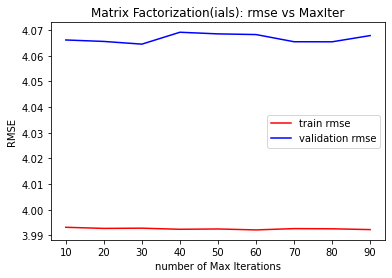

In [16]:
plt.plot(ials_iter,  ials_train_iter, color= 'r',label='train rmse' )
plt.plot(ials_iter,  ials_val_iter, color= 'b',label='validation rmse' )
plt.xlabel('number of Max Iterations')
plt.ylabel('RMSE')
plt.title('Matrix Factorization(ials): rmse vs MaxIter')
plt.legend()
plt.show()

In [104]:
IALS_model = tc.ranking_factorization_recommender.create(train4,item_id = item_id, target = target,\
                                                            user_id = user_id, binary_target = False,\
                                                            solver = 'ials', num_factors = 2,\
                                                            regularization = 1e-4,\
                                                            ials_confidence_scaling_factor = 40 ,\
                                                            max_iterations = 60)

Preparing data set.

Data has 135114 observations with 22183 users and 248 items.

Data prepared in: 0.148259s

Training ranking_factorization_recommender for recommendations.

+------------------------------+--------------------------------------------------+----------+

| Parameter                    | Description                                      | Value    |

+------------------------------+--------------------------------------------------+----------+

| num_factors                  | Factor Dimension                                 | 2        |

| regularization               | L2 Regularization on Factors                     | 0.0001   |

| max_iterations               | Maximum Number of Iterations                     | 60       |

| solver                       | Solver used for training                         | ials     |

+------------------------------+--------------------------------------------------+----------+

+---------+--------------+---------------------------+

| Iter.   | Elapsed time | Estimated Objective Value |

+---------+--------------+---------------------------+

| Initial | 137us        | NA                        |

+---------+--------------+---------------------------+

| 0       | 50.015ms     | 4.33169                   |

| 1       | 85.321ms     | 4.01108                   |

| 2       | 128.821ms    | 4.00235                   |

| 3       | 158.264ms    | 4.00117                   |

| 4       | 194.623ms    | 4.00036                   |

| 5       | 239.68ms     | 3.99981                   |

| 6       | 283.82ms     | 3.99921                   |

| 7       | 326.542ms    | 3.99888                   |

| 8       | 372.533ms    | 3.99876                   |

| 9       | 423.808ms    | 3.99867                   |

| 10      | 465.976ms    | 3.99858                   |

| 11      | 515.332ms    | 3.9985                    |

| 12      | 556.406ms    | 3.99832                   |

| 13      | 601.864ms    | 3.99824                   |

| 14      | 641.668ms    | 3.9982                    |

| 15      | 684.969ms    | 3.99817                   |

| 16      | 737.312ms    | 3.99814                   |

| 17      | 786.59ms     | 3.99811                   |

| 18      | 833.582ms    | 3.99809                   |

| 19      | 880.793ms    | 3.99807                   |

| 20      | 929.314ms    | 3.99805                   |

| 21      | 981.962ms    | 3.99803                   |

| 22      | 1.02s        | 3.998                     |

| 23      | 1.08s        | 3.99792                   |

| 24      | 1.12s        | 3.99787                   |

| 25      | 1.16s        | 3.99786                   |

| 26      | 1.21s        | 3.99785                   |

| 27      | 1.26s        | 3.99785                   |

| 28      | 1.30s        | 3.99784                   |

| 29      | 1.35s        | 3.99784                   |

| 30      | 1.39s        | 3.99783                   |

| 31      | 1.43s        | 3.99783                   |

| 32      | 1.48s        | 3.99782                   |

| 33      | 1.54s        | 3.99781                   |

| 34      | 1.58s        | 3.99781                   |

| 35      | 1.66s        | 3.9978                    |

| 36      | 1.70s        | 3.9978                    |

| 37      | 1.74s        | 3.99779                   |

| 38      | 1.78s        | 3.99777                   |

| 39      | 1.84s        | 3.99776                   |

| 40      | 1.89s        | 3.99775                   |

| 41      | 1.93s        | 3.99774                   |

| 42      | 1.97s        | 3.99774                   |

| 43      | 2.02s        | 3.99774                   |

| 44      | 2.06s        | 3.99773                   |

| 45      | 2.11s        | 3.99773                   |

| 46      | 2.17s        | 3.99772                   |

| 47      | 2.22s        | 3.99772                   |

| 48      | 2.27s        | 3.99771                   |

| 49      | 2.32s        | 3.99771                   |

| 50      | 2.37s        | 3.99771                   |

| 51      | 2.41s        | 3.99771                   |

| 52      | 2.46s        | 3.9977                    |

| 53      | 2.50s        | 3.9977                    |

| 54      | 2.54s        | 3.9977                    |

| 55      | 2.57s        | 3.99769                   |

| 56      | 2.62s        | 3.99769                   |

| 57      | 2.66s        | 3.99768                   |

| 58      | 2.71s        | 3.99768                   |

| 59      | 2.75s        | 3.99768                   |

| FINAL   | 2.75s        | 3.99768                   |

+---------+--------------+---------------------------+

Optimization Complete: Iteration limit reached.

In [105]:
IALS_evaluation = IALS_model.evaluate_precision_recall(test,cutoffs = list(range(1, 31)))

recommendations finished on 1000/17326 queries. users per second: 66317.4

recommendations finished on 2000/17326 queries. users per second: 86801.8

recommendations finished on 3000/17326 queries. users per second: 98762.2

recommendations finished on 4000/17326 queries. users per second: 98831.3

recommendations finished on 5000/17326 queries. users per second: 103625

recommendations finished on 6000/17326 queries. users per second: 109097

recommendations finished on 7000/17326 queries. users per second: 108446

recommendations finished on 8000/17326 queries. users per second: 107114

recommendations finished on 9000/17326 queries. users per second: 92284

recommendations finished on 10000/17326 queries. users per second: 93855.3

recommendations finished on 11000/17326 queries. users per second: 95597.3

recommendations finished on 12000/17326 queries. users per second: 96433.6

recommendations finished on 13000/17326 queries. users per second: 89404.2

recommendations finished on 14000/17326 queries. users per second: 91660.2

recommendations finished on 15000/17326 queries. users per second: 92687.6

recommendations finished on 16000/17326 queries. users per second: 94881.2

recommendations finished on 17000/17326 queries. users per second: 95527.6

In [106]:
col_names =  ['cutoff', 'precision', 'recall'] 
IALS_results  = pd.DataFrame(columns = col_names)
IALS_results['cutoff'] = np.array(IALS_evaluation['precision_recall_overall']['cutoff'])
IALS_results['precision'] = np.array(IALS_evaluation['precision_recall_overall']['precision'])
IALS_results['recall'] = np.array(IALS_evaluation['precision_recall_overall']['recall'])

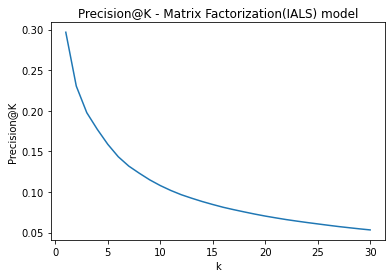

In [107]:
plt.plot(IALS_results['cutoff'],IALS_results['precision'] )
plt.title('Precision@K - Matrix Factorization(IALS) model')
plt.xlabel('k')
plt.ylabel('Precision@K')
plt.show()